In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Input, Activation, Dropout, Add, LSTM, GRU, RNN, LayerNormalization, BatchNormalization, SpectralNormalization, Conv1D, MaxPooling1D, Flatten, Layer
from keras import backend as K
from keras.optimizers import Adam,SGD
import tensorflow as tf
from keras import Model, regularizers, activations, initializers
from keras.constraints import Constraint
import pickle

In [2]:
# specifying constant parameters

T_0 = 300
V = 1
k_0 = 8.46*(np.power(10,6))
C_p = 0.231
rho_L = 1000
Q_s = 0.0
T_s = 401.8727
F = 5
E = 5*(np.power(10,4))
delta_H = -1.15*(np.power(10,4))
R = 8.314
C_A0s = 4
C_As = 1.9537
t_final = 0.005
t_step = 1e-4
P = np.array([[1060, 22], [22, 0.52]])

num_step = 10

In [3]:
# generating inputs and initial states for CSTR, all expressed in deviation form

u1_list = np.linspace(-3.5, 3.5, 4, endpoint=True)
u2_list = np.linspace(-5e5, 5e5, 4, endpoint=True)
T_initial = np.linspace(300, 600, 100, endpoint=True) - T_s
CA_initial = np.linspace(0, 6, 100, endpoint=True) - C_As

In [4]:
# sieve out initial states that lie outside of stability region

T_start = list()
CA_start = list()

for T in T_initial:
    for CA in CA_initial:
        x = np.array([CA, T])
        if x @ P @ x < 372:
            CA_start.append(CA)
            T_start.append(T)
print("number of initial conditions: {}".format(len(CA_start)))

# convert to np.arrays
CA_start = np.array([CA_start])
T_start = np.array([T_start])
x_deviation = np.concatenate((CA_start.T, T_start.T), axis=1)  # every row is a pair of initial states within stability region
print("shape of x_deviation is {}".format(x_deviation.shape))

number of initial conditions: 772
shape of x_deviation is (772, 2)


In [5]:
def CSTR_simulation(F, V, C_A0, k_0, E, R, T_0, delta_H, rho_L, C_p, Q, t_final, t_step, C_A_initial, T_initial):
    """
        simulating CSTR using forward Euler method
    """

    C_A_list = list()  # evolution of CA over time
    T_list = list()  # evolution of T over time

    C_A = C_A_initial + C_As
    T = T_initial + T_s

    for i in range(int(t_final / t_step)):
        dCAdt = F / V * (C_A0 - C_A) - k_0 * np.exp(-E / (R * T)) * C_A**2
        dTdt = F / V * (T_0 - T) - delta_H / (rho_L * C_p) * k_0 * np.exp(-E / (R * T)) * C_A**2 + Q / (rho_L * C_p * V)

        T += dTdt * t_step
        C_A += dCAdt * t_step

        if (i+1) % 5 == 0:
            C_A_list.append(C_A - C_As)  # in deviation form
            T_list.append(T - T_s)  # in deviation form

    return C_A_list, T_list

In [6]:
# get X and y data for training and testing

CA_output = list()
T_output = list()
CA_input = list()
T_input = list()
CA0_input = list()
Q_input = list()

for u1 in u1_list:
    C_A0 = u1 + C_A0s

    for u2 in u2_list:
        Q = u2 + Q_s

        for C_A_initial, T_initial in x_deviation:
            CA0_input.append(u1)
            Q_input.append(u2)
            CA_input.append(C_A_initial)
            T_input.append(T_initial)

            C_A_list, T_list = CSTR_simulation(F, V, C_A0, k_0, E, R, T_0, delta_H, rho_L, C_p, Q, t_final, t_step, C_A_initial, T_initial)
            CA_output.append(C_A_list)
            T_output.append(T_list)

In [7]:
CA0_input = np.array(CA0_input)
print(CA0_input.shape)
CA_output = np.array(CA_output)
print(CA_output.shape)

(12352,)
(12352, 10)


In [8]:
# collate input for RNN

CA0_input = np.array(CA0_input)
CA0_input = CA0_input.reshape(-1,1,1)

Q_input = np.array(Q_input)
Q_input = Q_input.reshape(-1,1,1)

CA_input = np.array(CA_input)
CA_input = CA_input.reshape(-1,1,1)

T_input = np.array(T_input)
T_input = T_input.reshape(-1,1,1)

RNN_input = np.concatenate((T_input, CA_input, Q_input, CA0_input), axis=2)
# RNN_input = np.concatenate((T_input, CA_input, Q_input, CA0_input, -T_input, -CA_input, -Q_input, -CA0_input), axis=2)

"""
    the input to RNN is in the shape [number of samples x timestep x variables], and the input variables are same for every
    time step, not sure if my treatment here is correct
"""

RNN_input = RNN_input.repeat(num_step, axis=1)
print("RNN_input shape is {}".format(RNN_input.shape))

RNN_input shape is (12352, 10, 4)


In [9]:
# checking the input is duplicated 100 times for each time step
print(RNN_input[0, 0])
print(RNN_input[0, 1])

[-7.45999727e+01  1.44023939e+00 -5.00000000e+05 -3.50000000e+00]
[-7.45999727e+01  1.44023939e+00 -5.00000000e+05 -3.50000000e+00]


In [10]:
# collate output for RNN

CA_output = np.array(CA_output)
CA_output = CA_output.reshape(-1, num_step, 1)

T_output = np.array(T_output)
T_output = T_output.reshape(-1, num_step, 1)

RNN_output = np.concatenate((T_output, CA_output), axis=2)
print("RNN_output shape is {}".format(RNN_output.shape))  # output shape: number of samples x timestep x variables

RNN_output shape is (12352, 10, 2)


In [11]:
# checking output
print(RNN_output[0, :5])

[[-75.72458929   1.4325163 ]
 [-76.84802004   1.4248451 ]
 [-77.97016868   1.41722366]
 [-79.09094468   1.40964998]
 [-80.21026299   1.40212216]]


In [12]:
class MyLRNNCell(tf.keras.layers.Layer):

    def __init__(self, units, eps=0.01, gamma=0.01, beta=0.8, alpha=1, **kwargs):
        self.units = units
        self.state_size = units
        self.I = tf.eye(units)
        self.eps = eps
        self.gamma = gamma
        self.beta = beta
        self.alpha = alpha
        super(MyLRNNCell, self).__init__(**kwargs)

    def build(self, input_shape):
        self.C = self.add_weight(shape=(self.units, self.units),
                                      initializer='random_normal',
                                      name='C',
                                      trainable=True)
        self.B = self.add_weight(shape=(self.units, self.units),
                                                initializer='random_normal',
                                                name='B',
                                                trainable=True)
        self.U = self.add_weight(shape=(input_shape[-1], self.units),
                                                initializer='random_normal',
                                                name='U',
                                                trainable=True)
        self.b = self.add_weight(shape=(self.units,),
                                    initializer='zeros',
                                    name='b',
                                    trainable=True)
        self.built = True

    def call(self, inputs, states):
        prev_h = states[0]

        A = self.beta * (self.B - tf.transpose(self.B)) + (1 - self.beta) * (self.B + tf.transpose(self.B)) - self.gamma * self.I
        W = self.beta * (self.C - tf.transpose(self.C)) + (1 - self.beta) * (self.C + tf.transpose(self.C)) - self.gamma * self.I

        h = prev_h + self.eps * self.alpha * K.dot(prev_h, A) + self.eps * tf.nn.tanh(K.dot(prev_h, W) + K.dot(inputs, self.U) + self.b)
        return h, [h]

    def get_config(self):
        config = super(MyLRNNCell, self).get_config()
        config.update({"units": self.units, "eps":self.eps, "gamma":self.gamma, "beta":self.beta, "alpha":self.alpha})
        return config

In [13]:
def check_non_negative_weights_ignore_bias(model):
    all_non_negative = True
    for layer in model.layers:
        weights = layer.get_weights()
        if weights:  # tf the layer has weights
            # check only the weight matrices (ignoring biases if present)
            weight_only = weights[0]  # assume weights are the first element, bias (if any) is second
            if not np.all(weight_only >= 0):
                print(f"Non-negative check failed in layer: {layer.name}")
                all_non_negative = False
    if all_non_negative:
        print("All weights are non-negative (ignoring biases).")
    else:
        print("Some weights are negative (ignoring biases).")

In [14]:
def evaluate_lip_const(model: Model, x, eps, seed=None):
    """
    Evaluate the Lipschitz constant of a model, with the naive method.
    Please note that the estimation of the lipschitz constant is done locally around
    input sample. This may not correctly estimate the behaviour in the whole domain.

    Args:
        model: built keras model used to make predictions
        x: inputs used to compute the lipschitz constant
        eps (float): magnitude of noise to add to input in order to compute the constant
        seed (int): seed used when generating the noise ( can be set to None )

    Returns:
        float: the empirically evaluated lipschitz constant. The computation might also
            be inaccurate in high dimensional space.

    """
    y_pred = model.predict(x)
    x_var = x + K.random_uniform(
        shape=x.shape, minval=eps * 0.25, maxval=eps, seed=seed
    )
#     x_var = x + K.random_normal(
#         shape=x.shape, mean=0, stddev=eps, seed=seed
#     )
    y_pred_var = model.predict(x_var)
    dx = x - x_var
    dfx = y_pred - y_pred_var
    ndx = K.sqrt(K.sum(K.square(dx), axis=range(1, len(x.shape))))
    ndfx = K.sqrt(K.sum(K.square(dfx), axis=range(1, len(y_pred.shape))))
    lip_cst = K.max(ndfx / ndx)
    print(f"lip cst: {lip_cst:.3f}")
    return lip_cst

In [15]:
# set the seed for reproducibility
tf.random.set_seed(42)

training_loss = [0]*19
test_loss = [0]*19
lip = [0]*19
noise = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]

for i in range(19):
    num_dims = 4

    # split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(RNN_input, RNN_output, test_size=0.3, random_state=123)

    # define scalers for both X and y base on training data only
    scaler_X = preprocessing.MinMaxScaler().fit(X_train.reshape(-1, num_dims))
    scaler_y = preprocessing.MinMaxScaler().fit(y_train.reshape(-1, 2))

    X_train = scaler_X.transform(X_train.reshape(-1, num_dims)).reshape(-1,num_step,num_dims)
    X_test = scaler_X.transform(X_test.reshape(-1, num_dims)).reshape(-1,num_step,num_dims)
    y_train = scaler_y.transform(y_train.reshape(-1,2)).reshape(-1,num_step,2)
    y_test_normalized = scaler_y.transform(y_test.reshape(-1,2)).reshape(-1,num_step,2)

    # X is just the initial condition, so we introduce noise to the output trajectory y
    y_train = y_train + np.random.normal(0, noise[i], y_train.shape)

    # LRNN
    model = Sequential()
    model.add(RNN(MyLRNNCell(units=64),return_sequences=True))
    model.add(RNN(MyLRNNCell(units=64),return_sequences=True))
    model.add(Dense(2, activation='linear'))

    model.compile(optimizer='adam', loss='mean_squared_error', metrics=[tf.keras.metrics.MeanSquaredError()])
    history = model.fit(X_train, y_train, epochs=1000, batch_size=256, validation_split=0.25, verbose=2)

    training_loss[i] = history.history['val_loss'][-1]
    print(noise)
    print(training_loss)

    loss = model.evaluate(X_test, y_test_normalized, batch_size=256)
    test_loss[i] = loss[0]
    print(test_loss)
    
    # check convexity by checking the weights
    check_non_negative_weights_ignore_bias(model)
    
    # compute the Lipschitz constant for the 2-layer RNN
    lipschitz_constant = evaluate_lip_const(model, X_train, 1e-04, 42)
    print(f"Estimated Lipschitz constant of the 2-layer RNN: {lipschitz_constant}")
    
    lip[i] = lipschitz_constant

model.summary()

Epoch 1/1000
26/26 - 8s - loss: 0.2857 - mean_squared_error: 0.2857 - val_loss: 0.2651 - val_mean_squared_error: 0.2651 - 8s/epoch - 292ms/step
Epoch 2/1000
26/26 - 0s - loss: 0.2426 - mean_squared_error: 0.2426 - val_loss: 0.2149 - val_mean_squared_error: 0.2149 - 373ms/epoch - 14ms/step
Epoch 3/1000
26/26 - 0s - loss: 0.1865 - mean_squared_error: 0.1865 - val_loss: 0.1546 - val_mean_squared_error: 0.1546 - 360ms/epoch - 14ms/step
Epoch 4/1000
26/26 - 0s - loss: 0.1327 - mean_squared_error: 0.1327 - val_loss: 0.1155 - val_mean_squared_error: 0.1155 - 345ms/epoch - 13ms/step
Epoch 5/1000
26/26 - 0s - loss: 0.1109 - mean_squared_error: 0.1109 - val_loss: 0.1077 - val_mean_squared_error: 0.1077 - 358ms/epoch - 14ms/step
Epoch 6/1000
26/26 - 0s - loss: 0.1056 - mean_squared_error: 0.1056 - val_loss: 0.1029 - val_mean_squared_error: 0.1029 - 349ms/epoch - 13ms/step
Epoch 7/1000
26/26 - 0s - loss: 0.1008 - mean_squared_error: 0.1008 - val_loss: 0.0980 - val_mean_squared_error: 0.0980 - 378m

Epoch 57/1000
26/26 - 0s - loss: 0.0140 - mean_squared_error: 0.0140 - val_loss: 0.0138 - val_mean_squared_error: 0.0138 - 350ms/epoch - 13ms/step
Epoch 58/1000
26/26 - 0s - loss: 0.0138 - mean_squared_error: 0.0138 - val_loss: 0.0137 - val_mean_squared_error: 0.0137 - 352ms/epoch - 14ms/step
Epoch 59/1000
26/26 - 0s - loss: 0.0136 - mean_squared_error: 0.0136 - val_loss: 0.0135 - val_mean_squared_error: 0.0135 - 351ms/epoch - 14ms/step
Epoch 60/1000
26/26 - 0s - loss: 0.0134 - mean_squared_error: 0.0134 - val_loss: 0.0133 - val_mean_squared_error: 0.0133 - 342ms/epoch - 13ms/step
Epoch 61/1000
26/26 - 0s - loss: 0.0132 - mean_squared_error: 0.0132 - val_loss: 0.0131 - val_mean_squared_error: 0.0131 - 385ms/epoch - 15ms/step
Epoch 62/1000
26/26 - 0s - loss: 0.0130 - mean_squared_error: 0.0130 - val_loss: 0.0128 - val_mean_squared_error: 0.0128 - 380ms/epoch - 15ms/step
Epoch 63/1000
26/26 - 0s - loss: 0.0128 - mean_squared_error: 0.0128 - val_loss: 0.0126 - val_mean_squared_error: 0.01

Epoch 113/1000
26/26 - 0s - loss: 0.0063 - mean_squared_error: 0.0063 - val_loss: 0.0062 - val_mean_squared_error: 0.0062 - 413ms/epoch - 16ms/step
Epoch 114/1000
26/26 - 0s - loss: 0.0062 - mean_squared_error: 0.0062 - val_loss: 0.0062 - val_mean_squared_error: 0.0062 - 419ms/epoch - 16ms/step
Epoch 115/1000
26/26 - 0s - loss: 0.0062 - mean_squared_error: 0.0062 - val_loss: 0.0061 - val_mean_squared_error: 0.0061 - 434ms/epoch - 17ms/step
Epoch 116/1000
26/26 - 0s - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0060 - val_mean_squared_error: 0.0060 - 419ms/epoch - 16ms/step
Epoch 117/1000
26/26 - 0s - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0060 - val_mean_squared_error: 0.0060 - 435ms/epoch - 17ms/step
Epoch 118/1000
26/26 - 0s - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - 418ms/epoch - 16ms/step
Epoch 119/1000
26/26 - 0s - loss: 0.0059 - mean_squared_error: 0.0059 - val_loss: 0.0058 - val_mean_squared_erro

Epoch 169/1000
26/26 - 0s - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0030 - val_mean_squared_error: 0.0030 - 452ms/epoch - 17ms/step
Epoch 170/1000
26/26 - 0s - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0030 - val_mean_squared_error: 0.0030 - 434ms/epoch - 17ms/step
Epoch 171/1000
26/26 - 0s - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0029 - val_mean_squared_error: 0.0029 - 421ms/epoch - 16ms/step
Epoch 172/1000
26/26 - 0s - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0029 - val_mean_squared_error: 0.0029 - 420ms/epoch - 16ms/step
Epoch 173/1000
26/26 - 0s - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0029 - val_mean_squared_error: 0.0029 - 404ms/epoch - 16ms/step
Epoch 174/1000
26/26 - 0s - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0028 - val_mean_squared_error: 0.0028 - 448ms/epoch - 17ms/step
Epoch 175/1000
26/26 - 0s - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0028 - val_mean_squared_erro

Epoch 225/1000
26/26 - 0s - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0017 - val_mean_squared_error: 0.0017 - 427ms/epoch - 16ms/step
Epoch 226/1000
26/26 - 0s - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0016 - val_mean_squared_error: 0.0016 - 448ms/epoch - 17ms/step
Epoch 227/1000
26/26 - 0s - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0016 - val_mean_squared_error: 0.0016 - 454ms/epoch - 17ms/step
Epoch 228/1000
26/26 - 0s - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0016 - val_mean_squared_error: 0.0016 - 466ms/epoch - 18ms/step
Epoch 229/1000
26/26 - 0s - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0016 - val_mean_squared_error: 0.0016 - 466ms/epoch - 18ms/step
Epoch 230/1000
26/26 - 0s - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0016 - val_mean_squared_error: 0.0016 - 468ms/epoch - 18ms/step
Epoch 231/1000
26/26 - 0s - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0016 - val_mean_squared_erro

Epoch 280/1000
26/26 - 0s - loss: 9.0028e-04 - mean_squared_error: 9.0028e-04 - val_loss: 8.8783e-04 - val_mean_squared_error: 8.8783e-04 - 467ms/epoch - 18ms/step
Epoch 281/1000
26/26 - 0s - loss: 8.8932e-04 - mean_squared_error: 8.8932e-04 - val_loss: 8.7760e-04 - val_mean_squared_error: 8.7760e-04 - 454ms/epoch - 17ms/step
Epoch 282/1000
26/26 - 0s - loss: 8.7913e-04 - mean_squared_error: 8.7913e-04 - val_loss: 8.6761e-04 - val_mean_squared_error: 8.6761e-04 - 450ms/epoch - 17ms/step
Epoch 283/1000
26/26 - 0s - loss: 8.6878e-04 - mean_squared_error: 8.6878e-04 - val_loss: 8.5734e-04 - val_mean_squared_error: 8.5734e-04 - 483ms/epoch - 19ms/step
Epoch 284/1000
26/26 - 0s - loss: 8.5869e-04 - mean_squared_error: 8.5869e-04 - val_loss: 8.4752e-04 - val_mean_squared_error: 8.4752e-04 - 455ms/epoch - 17ms/step
Epoch 285/1000
26/26 - 0s - loss: 8.4880e-04 - mean_squared_error: 8.4880e-04 - val_loss: 8.3765e-04 - val_mean_squared_error: 8.3765e-04 - 435ms/epoch - 17ms/step
Epoch 286/1000
2

Epoch 330/1000
26/26 - 0s - loss: 5.2662e-04 - mean_squared_error: 5.2662e-04 - val_loss: 5.2061e-04 - val_mean_squared_error: 5.2061e-04 - 451ms/epoch - 17ms/step
Epoch 331/1000
26/26 - 0s - loss: 5.2109e-04 - mean_squared_error: 5.2109e-04 - val_loss: 5.1515e-04 - val_mean_squared_error: 5.1515e-04 - 452ms/epoch - 17ms/step
Epoch 332/1000
26/26 - 0s - loss: 5.1617e-04 - mean_squared_error: 5.1617e-04 - val_loss: 5.1052e-04 - val_mean_squared_error: 5.1052e-04 - 451ms/epoch - 17ms/step
Epoch 333/1000
26/26 - 0s - loss: 5.1192e-04 - mean_squared_error: 5.1192e-04 - val_loss: 5.0693e-04 - val_mean_squared_error: 5.0693e-04 - 452ms/epoch - 17ms/step
Epoch 334/1000
26/26 - 0s - loss: 5.0706e-04 - mean_squared_error: 5.0706e-04 - val_loss: 5.0141e-04 - val_mean_squared_error: 5.0141e-04 - 452ms/epoch - 17ms/step
Epoch 335/1000
26/26 - 0s - loss: 5.0207e-04 - mean_squared_error: 5.0207e-04 - val_loss: 4.9681e-04 - val_mean_squared_error: 4.9681e-04 - 436ms/epoch - 17ms/step
Epoch 336/1000
2

Epoch 380/1000
26/26 - 0s - loss: 3.3477e-04 - mean_squared_error: 3.3477e-04 - val_loss: 3.3103e-04 - val_mean_squared_error: 3.3103e-04 - 437ms/epoch - 17ms/step
Epoch 381/1000
26/26 - 0s - loss: 3.3173e-04 - mean_squared_error: 3.3173e-04 - val_loss: 3.3114e-04 - val_mean_squared_error: 3.3114e-04 - 468ms/epoch - 18ms/step
Epoch 382/1000
26/26 - 0s - loss: 3.2930e-04 - mean_squared_error: 3.2930e-04 - val_loss: 3.2714e-04 - val_mean_squared_error: 3.2714e-04 - 468ms/epoch - 18ms/step
Epoch 383/1000
26/26 - 0s - loss: 3.2633e-04 - mean_squared_error: 3.2633e-04 - val_loss: 3.2235e-04 - val_mean_squared_error: 3.2235e-04 - 484ms/epoch - 19ms/step
Epoch 384/1000
26/26 - 0s - loss: 3.2289e-04 - mean_squared_error: 3.2289e-04 - val_loss: 3.1966e-04 - val_mean_squared_error: 3.1966e-04 - 451ms/epoch - 17ms/step
Epoch 385/1000
26/26 - 0s - loss: 3.2016e-04 - mean_squared_error: 3.2016e-04 - val_loss: 3.1701e-04 - val_mean_squared_error: 3.1701e-04 - 453ms/epoch - 17ms/step
Epoch 386/1000
2

Epoch 430/1000
26/26 - 0s - loss: 2.1725e-04 - mean_squared_error: 2.1725e-04 - val_loss: 2.1542e-04 - val_mean_squared_error: 2.1542e-04 - 461ms/epoch - 18ms/step
Epoch 431/1000
26/26 - 0s - loss: 2.1560e-04 - mean_squared_error: 2.1560e-04 - val_loss: 2.1357e-04 - val_mean_squared_error: 2.1357e-04 - 450ms/epoch - 17ms/step
Epoch 432/1000
26/26 - 0s - loss: 2.1359e-04 - mean_squared_error: 2.1359e-04 - val_loss: 2.1206e-04 - val_mean_squared_error: 2.1206e-04 - 453ms/epoch - 17ms/step
Epoch 433/1000
26/26 - 0s - loss: 2.1190e-04 - mean_squared_error: 2.1190e-04 - val_loss: 2.1001e-04 - val_mean_squared_error: 2.1001e-04 - 419ms/epoch - 16ms/step
Epoch 434/1000
26/26 - 0s - loss: 2.1031e-04 - mean_squared_error: 2.1031e-04 - val_loss: 2.0899e-04 - val_mean_squared_error: 2.0899e-04 - 467ms/epoch - 18ms/step
Epoch 435/1000
26/26 - 0s - loss: 2.0886e-04 - mean_squared_error: 2.0886e-04 - val_loss: 2.0939e-04 - val_mean_squared_error: 2.0939e-04 - 453ms/epoch - 17ms/step
Epoch 436/1000
2

Epoch 480/1000
26/26 - 0s - loss: 1.4921e-04 - mean_squared_error: 1.4921e-04 - val_loss: 1.4853e-04 - val_mean_squared_error: 1.4853e-04 - 463ms/epoch - 18ms/step
Epoch 481/1000
26/26 - 0s - loss: 1.4815e-04 - mean_squared_error: 1.4815e-04 - val_loss: 1.4737e-04 - val_mean_squared_error: 1.4737e-04 - 454ms/epoch - 17ms/step
Epoch 482/1000
26/26 - 0s - loss: 1.4712e-04 - mean_squared_error: 1.4712e-04 - val_loss: 1.4650e-04 - val_mean_squared_error: 1.4650e-04 - 434ms/epoch - 17ms/step
Epoch 483/1000
26/26 - 0s - loss: 1.4619e-04 - mean_squared_error: 1.4619e-04 - val_loss: 1.4644e-04 - val_mean_squared_error: 1.4644e-04 - 455ms/epoch - 18ms/step
Epoch 484/1000
26/26 - 0s - loss: 1.4548e-04 - mean_squared_error: 1.4548e-04 - val_loss: 1.4431e-04 - val_mean_squared_error: 1.4431e-04 - 466ms/epoch - 18ms/step
Epoch 485/1000
26/26 - 0s - loss: 1.4459e-04 - mean_squared_error: 1.4459e-04 - val_loss: 1.4334e-04 - val_mean_squared_error: 1.4334e-04 - 481ms/epoch - 18ms/step
Epoch 486/1000
2

Epoch 530/1000
26/26 - 0s - loss: 1.0973e-04 - mean_squared_error: 1.0973e-04 - val_loss: 1.0911e-04 - val_mean_squared_error: 1.0911e-04 - 468ms/epoch - 18ms/step
Epoch 531/1000
26/26 - 0s - loss: 1.0903e-04 - mean_squared_error: 1.0903e-04 - val_loss: 1.0860e-04 - val_mean_squared_error: 1.0860e-04 - 436ms/epoch - 17ms/step
Epoch 532/1000
26/26 - 0s - loss: 1.0844e-04 - mean_squared_error: 1.0844e-04 - val_loss: 1.0774e-04 - val_mean_squared_error: 1.0774e-04 - 468ms/epoch - 18ms/step
Epoch 533/1000
26/26 - 0s - loss: 1.0808e-04 - mean_squared_error: 1.0808e-04 - val_loss: 1.0737e-04 - val_mean_squared_error: 1.0737e-04 - 452ms/epoch - 17ms/step
Epoch 534/1000
26/26 - 0s - loss: 1.0729e-04 - mean_squared_error: 1.0729e-04 - val_loss: 1.0704e-04 - val_mean_squared_error: 1.0704e-04 - 437ms/epoch - 17ms/step
Epoch 535/1000
26/26 - 0s - loss: 1.0672e-04 - mean_squared_error: 1.0672e-04 - val_loss: 1.0600e-04 - val_mean_squared_error: 1.0600e-04 - 468ms/epoch - 18ms/step
Epoch 536/1000
2

Epoch 580/1000
26/26 - 0s - loss: 8.4276e-05 - mean_squared_error: 8.4276e-05 - val_loss: 8.3942e-05 - val_mean_squared_error: 8.3942e-05 - 451ms/epoch - 17ms/step
Epoch 581/1000
26/26 - 0s - loss: 8.3897e-05 - mean_squared_error: 8.3897e-05 - val_loss: 8.3747e-05 - val_mean_squared_error: 8.3747e-05 - 452ms/epoch - 17ms/step
Epoch 582/1000
26/26 - 0s - loss: 8.3918e-05 - mean_squared_error: 8.3918e-05 - val_loss: 8.5060e-05 - val_mean_squared_error: 8.5060e-05 - 467ms/epoch - 18ms/step
Epoch 583/1000
26/26 - 0s - loss: 8.3602e-05 - mean_squared_error: 8.3602e-05 - val_loss: 8.3364e-05 - val_mean_squared_error: 8.3364e-05 - 484ms/epoch - 19ms/step
Epoch 584/1000
26/26 - 0s - loss: 8.2696e-05 - mean_squared_error: 8.2696e-05 - val_loss: 8.2387e-05 - val_mean_squared_error: 8.2387e-05 - 468ms/epoch - 18ms/step
Epoch 585/1000
26/26 - 0s - loss: 8.2213e-05 - mean_squared_error: 8.2213e-05 - val_loss: 8.2327e-05 - val_mean_squared_error: 8.2327e-05 - 469ms/epoch - 18ms/step
Epoch 586/1000
2

Epoch 630/1000
26/26 - 1s - loss: 6.6678e-05 - mean_squared_error: 6.6678e-05 - val_loss: 6.6173e-05 - val_mean_squared_error: 6.6173e-05 - 505ms/epoch - 19ms/step
Epoch 631/1000
26/26 - 0s - loss: 6.6299e-05 - mean_squared_error: 6.6299e-05 - val_loss: 6.6001e-05 - val_mean_squared_error: 6.6001e-05 - 499ms/epoch - 19ms/step
Epoch 632/1000
26/26 - 0s - loss: 6.6099e-05 - mean_squared_error: 6.6099e-05 - val_loss: 6.5712e-05 - val_mean_squared_error: 6.5712e-05 - 478ms/epoch - 18ms/step
Epoch 633/1000
26/26 - 0s - loss: 6.6213e-05 - mean_squared_error: 6.6213e-05 - val_loss: 6.5970e-05 - val_mean_squared_error: 6.5970e-05 - 451ms/epoch - 17ms/step
Epoch 634/1000
26/26 - 0s - loss: 6.5560e-05 - mean_squared_error: 6.5560e-05 - val_loss: 6.5155e-05 - val_mean_squared_error: 6.5155e-05 - 436ms/epoch - 17ms/step
Epoch 635/1000
26/26 - 0s - loss: 6.5368e-05 - mean_squared_error: 6.5368e-05 - val_loss: 6.5649e-05 - val_mean_squared_error: 6.5649e-05 - 453ms/epoch - 17ms/step
Epoch 636/1000
2

Epoch 680/1000
26/26 - 0s - loss: 5.3212e-05 - mean_squared_error: 5.3212e-05 - val_loss: 5.3168e-05 - val_mean_squared_error: 5.3168e-05 - 452ms/epoch - 17ms/step
Epoch 681/1000
26/26 - 0s - loss: 5.3446e-05 - mean_squared_error: 5.3446e-05 - val_loss: 5.2631e-05 - val_mean_squared_error: 5.2631e-05 - 453ms/epoch - 17ms/step
Epoch 682/1000
26/26 - 0s - loss: 5.2851e-05 - mean_squared_error: 5.2851e-05 - val_loss: 5.3075e-05 - val_mean_squared_error: 5.3075e-05 - 467ms/epoch - 18ms/step
Epoch 683/1000
26/26 - 0s - loss: 5.2674e-05 - mean_squared_error: 5.2674e-05 - val_loss: 5.2370e-05 - val_mean_squared_error: 5.2370e-05 - 423ms/epoch - 16ms/step
Epoch 684/1000
26/26 - 0s - loss: 5.2424e-05 - mean_squared_error: 5.2424e-05 - val_loss: 5.2539e-05 - val_mean_squared_error: 5.2539e-05 - 456ms/epoch - 18ms/step
Epoch 685/1000
26/26 - 0s - loss: 5.2085e-05 - mean_squared_error: 5.2085e-05 - val_loss: 5.2261e-05 - val_mean_squared_error: 5.2261e-05 - 467ms/epoch - 18ms/step
Epoch 686/1000
2

Epoch 730/1000
26/26 - 0s - loss: 4.3113e-05 - mean_squared_error: 4.3113e-05 - val_loss: 4.3228e-05 - val_mean_squared_error: 4.3228e-05 - 427ms/epoch - 16ms/step
Epoch 731/1000
26/26 - 0s - loss: 4.2884e-05 - mean_squared_error: 4.2884e-05 - val_loss: 4.2945e-05 - val_mean_squared_error: 4.2945e-05 - 467ms/epoch - 18ms/step
Epoch 732/1000
26/26 - 0s - loss: 4.2902e-05 - mean_squared_error: 4.2902e-05 - val_loss: 4.2142e-05 - val_mean_squared_error: 4.2142e-05 - 469ms/epoch - 18ms/step
Epoch 733/1000
26/26 - 0s - loss: 4.2233e-05 - mean_squared_error: 4.2233e-05 - val_loss: 4.2433e-05 - val_mean_squared_error: 4.2433e-05 - 466ms/epoch - 18ms/step
Epoch 734/1000
26/26 - 0s - loss: 4.2052e-05 - mean_squared_error: 4.2052e-05 - val_loss: 4.1741e-05 - val_mean_squared_error: 4.1741e-05 - 467ms/epoch - 18ms/step
Epoch 735/1000
26/26 - 0s - loss: 4.1707e-05 - mean_squared_error: 4.1707e-05 - val_loss: 4.1520e-05 - val_mean_squared_error: 4.1520e-05 - 453ms/epoch - 17ms/step
Epoch 736/1000
2

Epoch 780/1000
26/26 - 0s - loss: 3.4550e-05 - mean_squared_error: 3.4550e-05 - val_loss: 3.4214e-05 - val_mean_squared_error: 3.4214e-05 - 497ms/epoch - 19ms/step
Epoch 781/1000
26/26 - 0s - loss: 3.4251e-05 - mean_squared_error: 3.4251e-05 - val_loss: 3.4137e-05 - val_mean_squared_error: 3.4137e-05 - 470ms/epoch - 18ms/step
Epoch 782/1000
26/26 - 0s - loss: 3.3970e-05 - mean_squared_error: 3.3970e-05 - val_loss: 3.3793e-05 - val_mean_squared_error: 3.3793e-05 - 484ms/epoch - 19ms/step
Epoch 783/1000
26/26 - 0s - loss: 3.3890e-05 - mean_squared_error: 3.3890e-05 - val_loss: 3.3776e-05 - val_mean_squared_error: 3.3776e-05 - 480ms/epoch - 18ms/step
Epoch 784/1000
26/26 - 0s - loss: 3.3813e-05 - mean_squared_error: 3.3813e-05 - val_loss: 3.3868e-05 - val_mean_squared_error: 3.3868e-05 - 470ms/epoch - 18ms/step
Epoch 785/1000
26/26 - 0s - loss: 3.3588e-05 - mean_squared_error: 3.3588e-05 - val_loss: 3.3298e-05 - val_mean_squared_error: 3.3298e-05 - 490ms/epoch - 19ms/step
Epoch 786/1000
2

Epoch 830/1000
26/26 - 0s - loss: 2.7471e-05 - mean_squared_error: 2.7471e-05 - val_loss: 2.7395e-05 - val_mean_squared_error: 2.7395e-05 - 480ms/epoch - 18ms/step
Epoch 831/1000
26/26 - 0s - loss: 2.7346e-05 - mean_squared_error: 2.7346e-05 - val_loss: 2.7094e-05 - val_mean_squared_error: 2.7094e-05 - 449ms/epoch - 17ms/step
Epoch 832/1000
26/26 - 0s - loss: 2.7179e-05 - mean_squared_error: 2.7179e-05 - val_loss: 2.7785e-05 - val_mean_squared_error: 2.7785e-05 - 467ms/epoch - 18ms/step
Epoch 833/1000
26/26 - 0s - loss: 2.7261e-05 - mean_squared_error: 2.7261e-05 - val_loss: 2.6880e-05 - val_mean_squared_error: 2.6880e-05 - 470ms/epoch - 18ms/step
Epoch 834/1000
26/26 - 0s - loss: 2.6923e-05 - mean_squared_error: 2.6923e-05 - val_loss: 2.6790e-05 - val_mean_squared_error: 2.6790e-05 - 488ms/epoch - 19ms/step
Epoch 835/1000
26/26 - 0s - loss: 2.6983e-05 - mean_squared_error: 2.6983e-05 - val_loss: 2.6626e-05 - val_mean_squared_error: 2.6626e-05 - 478ms/epoch - 18ms/step
Epoch 836/1000
2

Epoch 880/1000
26/26 - 0s - loss: 2.1835e-05 - mean_squared_error: 2.1835e-05 - val_loss: 2.1691e-05 - val_mean_squared_error: 2.1691e-05 - 453ms/epoch - 17ms/step
Epoch 881/1000
26/26 - 0s - loss: 2.1723e-05 - mean_squared_error: 2.1723e-05 - val_loss: 2.1606e-05 - val_mean_squared_error: 2.1606e-05 - 498ms/epoch - 19ms/step
Epoch 882/1000
26/26 - 0s - loss: 2.1842e-05 - mean_squared_error: 2.1842e-05 - val_loss: 2.1944e-05 - val_mean_squared_error: 2.1944e-05 - 484ms/epoch - 19ms/step
Epoch 883/1000
26/26 - 0s - loss: 2.1734e-05 - mean_squared_error: 2.1734e-05 - val_loss: 2.2595e-05 - val_mean_squared_error: 2.2595e-05 - 468ms/epoch - 18ms/step
Epoch 884/1000
26/26 - 0s - loss: 2.1557e-05 - mean_squared_error: 2.1557e-05 - val_loss: 2.1697e-05 - val_mean_squared_error: 2.1697e-05 - 451ms/epoch - 17ms/step
Epoch 885/1000
26/26 - 0s - loss: 2.1547e-05 - mean_squared_error: 2.1547e-05 - val_loss: 2.1369e-05 - val_mean_squared_error: 2.1369e-05 - 453ms/epoch - 17ms/step
Epoch 886/1000
2

Epoch 930/1000
26/26 - 0s - loss: 1.7893e-05 - mean_squared_error: 1.7893e-05 - val_loss: 1.7219e-05 - val_mean_squared_error: 1.7219e-05 - 466ms/epoch - 18ms/step
Epoch 931/1000
26/26 - 0s - loss: 1.7506e-05 - mean_squared_error: 1.7506e-05 - val_loss: 1.7769e-05 - val_mean_squared_error: 1.7769e-05 - 466ms/epoch - 18ms/step
Epoch 932/1000
26/26 - 0s - loss: 1.7263e-05 - mean_squared_error: 1.7263e-05 - val_loss: 1.7259e-05 - val_mean_squared_error: 1.7259e-05 - 466ms/epoch - 18ms/step
Epoch 933/1000
26/26 - 0s - loss: 1.7215e-05 - mean_squared_error: 1.7215e-05 - val_loss: 1.7479e-05 - val_mean_squared_error: 1.7479e-05 - 451ms/epoch - 17ms/step
Epoch 934/1000
26/26 - 0s - loss: 1.7070e-05 - mean_squared_error: 1.7070e-05 - val_loss: 1.6953e-05 - val_mean_squared_error: 1.6953e-05 - 489ms/epoch - 19ms/step
Epoch 935/1000
26/26 - 0s - loss: 1.6903e-05 - mean_squared_error: 1.6903e-05 - val_loss: 1.7013e-05 - val_mean_squared_error: 1.7013e-05 - 462ms/epoch - 18ms/step
Epoch 936/1000
2

Epoch 980/1000
26/26 - 0s - loss: 1.4084e-05 - mean_squared_error: 1.4084e-05 - val_loss: 1.4071e-05 - val_mean_squared_error: 1.4071e-05 - 482ms/epoch - 19ms/step
Epoch 981/1000
26/26 - 0s - loss: 1.3971e-05 - mean_squared_error: 1.3971e-05 - val_loss: 1.3732e-05 - val_mean_squared_error: 1.3732e-05 - 498ms/epoch - 19ms/step
Epoch 982/1000
26/26 - 0s - loss: 1.4017e-05 - mean_squared_error: 1.4017e-05 - val_loss: 1.4883e-05 - val_mean_squared_error: 1.4883e-05 - 468ms/epoch - 18ms/step
Epoch 983/1000
26/26 - 0s - loss: 1.3831e-05 - mean_squared_error: 1.3831e-05 - val_loss: 1.3662e-05 - val_mean_squared_error: 1.3662e-05 - 498ms/epoch - 19ms/step
Epoch 984/1000
26/26 - 0s - loss: 1.3722e-05 - mean_squared_error: 1.3722e-05 - val_loss: 1.3776e-05 - val_mean_squared_error: 1.3776e-05 - 483ms/epoch - 19ms/step
Epoch 985/1000
26/26 - 0s - loss: 1.3557e-05 - mean_squared_error: 1.3557e-05 - val_loss: 1.3546e-05 - val_mean_squared_error: 1.3546e-05 - 465ms/epoch - 18ms/step
Epoch 986/1000
2

Epoch 29/1000
26/26 - 0s - loss: 0.0360 - mean_squared_error: 0.0360 - val_loss: 0.0340 - val_mean_squared_error: 0.0340 - 451ms/epoch - 17ms/step
Epoch 30/1000
26/26 - 0s - loss: 0.0332 - mean_squared_error: 0.0332 - val_loss: 0.0322 - val_mean_squared_error: 0.0322 - 467ms/epoch - 18ms/step
Epoch 31/1000
26/26 - 0s - loss: 0.0320 - mean_squared_error: 0.0320 - val_loss: 0.0315 - val_mean_squared_error: 0.0315 - 467ms/epoch - 18ms/step
Epoch 32/1000
26/26 - 0s - loss: 0.0315 - mean_squared_error: 0.0315 - val_loss: 0.0310 - val_mean_squared_error: 0.0310 - 434ms/epoch - 17ms/step
Epoch 33/1000
26/26 - 0s - loss: 0.0310 - mean_squared_error: 0.0310 - val_loss: 0.0306 - val_mean_squared_error: 0.0306 - 467ms/epoch - 18ms/step
Epoch 34/1000
26/26 - 0s - loss: 0.0306 - mean_squared_error: 0.0306 - val_loss: 0.0302 - val_mean_squared_error: 0.0302 - 498ms/epoch - 19ms/step
Epoch 35/1000
26/26 - 0s - loss: 0.0302 - mean_squared_error: 0.0302 - val_loss: 0.0297 - val_mean_squared_error: 0.02

Epoch 85/1000
26/26 - 0s - loss: 0.0110 - mean_squared_error: 0.0110 - val_loss: 0.0109 - val_mean_squared_error: 0.0109 - 451ms/epoch - 17ms/step
Epoch 86/1000
26/26 - 0s - loss: 0.0109 - mean_squared_error: 0.0109 - val_loss: 0.0108 - val_mean_squared_error: 0.0108 - 467ms/epoch - 18ms/step
Epoch 87/1000
26/26 - 0s - loss: 0.0108 - mean_squared_error: 0.0108 - val_loss: 0.0107 - val_mean_squared_error: 0.0107 - 467ms/epoch - 18ms/step
Epoch 88/1000
26/26 - 0s - loss: 0.0108 - mean_squared_error: 0.0108 - val_loss: 0.0107 - val_mean_squared_error: 0.0107 - 451ms/epoch - 17ms/step
Epoch 89/1000
26/26 - 0s - loss: 0.0107 - mean_squared_error: 0.0107 - val_loss: 0.0106 - val_mean_squared_error: 0.0106 - 481ms/epoch - 19ms/step
Epoch 90/1000
26/26 - 0s - loss: 0.0106 - mean_squared_error: 0.0106 - val_loss: 0.0105 - val_mean_squared_error: 0.0105 - 451ms/epoch - 17ms/step
Epoch 91/1000
26/26 - 0s - loss: 0.0105 - mean_squared_error: 0.0105 - val_loss: 0.0104 - val_mean_squared_error: 0.01

Epoch 141/1000
26/26 - 0s - loss: 0.0073 - mean_squared_error: 0.0073 - val_loss: 0.0072 - val_mean_squared_error: 0.0072 - 450ms/epoch - 17ms/step
Epoch 142/1000
26/26 - 0s - loss: 0.0072 - mean_squared_error: 0.0072 - val_loss: 0.0071 - val_mean_squared_error: 0.0071 - 449ms/epoch - 17ms/step
Epoch 143/1000
26/26 - 0s - loss: 0.0071 - mean_squared_error: 0.0071 - val_loss: 0.0070 - val_mean_squared_error: 0.0070 - 453ms/epoch - 17ms/step
Epoch 144/1000
26/26 - 0s - loss: 0.0071 - mean_squared_error: 0.0071 - val_loss: 0.0070 - val_mean_squared_error: 0.0070 - 451ms/epoch - 17ms/step
Epoch 145/1000
26/26 - 0s - loss: 0.0070 - mean_squared_error: 0.0070 - val_loss: 0.0069 - val_mean_squared_error: 0.0069 - 467ms/epoch - 18ms/step
Epoch 146/1000
26/26 - 0s - loss: 0.0069 - mean_squared_error: 0.0069 - val_loss: 0.0068 - val_mean_squared_error: 0.0068 - 482ms/epoch - 19ms/step
Epoch 147/1000
26/26 - 0s - loss: 0.0068 - mean_squared_error: 0.0068 - val_loss: 0.0068 - val_mean_squared_erro

Epoch 197/1000
26/26 - 0s - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0050 - val_mean_squared_error: 0.0050 - 482ms/epoch - 19ms/step
Epoch 198/1000
26/26 - 0s - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0050 - val_mean_squared_error: 0.0050 - 465ms/epoch - 18ms/step
Epoch 199/1000
26/26 - 0s - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0050 - val_mean_squared_error: 0.0050 - 452ms/epoch - 17ms/step
Epoch 200/1000
26/26 - 0s - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0049 - val_mean_squared_error: 0.0049 - 436ms/epoch - 17ms/step
Epoch 201/1000
26/26 - 0s - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0049 - val_mean_squared_error: 0.0049 - 466ms/epoch - 18ms/step
Epoch 202/1000
26/26 - 0s - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0049 - val_mean_squared_error: 0.0049 - 482ms/epoch - 19ms/step
Epoch 203/1000
26/26 - 0s - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0049 - val_mean_squared_erro

Epoch 253/1000
26/26 - 0s - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0041 - val_mean_squared_error: 0.0041 - 467ms/epoch - 18ms/step
Epoch 254/1000
26/26 - 0s - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0041 - val_mean_squared_error: 0.0041 - 467ms/epoch - 18ms/step
Epoch 255/1000
26/26 - 0s - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0041 - val_mean_squared_error: 0.0041 - 469ms/epoch - 18ms/step
Epoch 256/1000
26/26 - 0s - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0041 - val_mean_squared_error: 0.0041 - 466ms/epoch - 18ms/step
Epoch 257/1000
26/26 - 0s - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0041 - val_mean_squared_error: 0.0041 - 467ms/epoch - 18ms/step
Epoch 258/1000
26/26 - 0s - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0040 - val_mean_squared_error: 0.0040 - 484ms/epoch - 19ms/step
Epoch 259/1000
26/26 - 1s - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0040 - val_mean_squared_erro

Epoch 309/1000
26/26 - 0s - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0036 - val_mean_squared_error: 0.0036 - 467ms/epoch - 18ms/step
Epoch 310/1000
26/26 - 0s - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0036 - val_mean_squared_error: 0.0036 - 467ms/epoch - 18ms/step
Epoch 311/1000
26/26 - 0s - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0036 - val_mean_squared_error: 0.0036 - 467ms/epoch - 18ms/step
Epoch 312/1000
26/26 - 0s - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0035 - val_mean_squared_error: 0.0035 - 467ms/epoch - 18ms/step
Epoch 313/1000
26/26 - 0s - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0035 - val_mean_squared_error: 0.0035 - 466ms/epoch - 18ms/step
Epoch 314/1000
26/26 - 0s - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0035 - val_mean_squared_error: 0.0035 - 468ms/epoch - 18ms/step
Epoch 315/1000
26/26 - 0s - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0035 - val_mean_squared_erro

Epoch 365/1000
26/26 - 0s - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0032 - val_mean_squared_error: 0.0032 - 451ms/epoch - 17ms/step
Epoch 366/1000
26/26 - 0s - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0032 - val_mean_squared_error: 0.0032 - 451ms/epoch - 17ms/step
Epoch 367/1000
26/26 - 0s - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0032 - val_mean_squared_error: 0.0032 - 451ms/epoch - 17ms/step
Epoch 368/1000
26/26 - 0s - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0032 - val_mean_squared_error: 0.0032 - 467ms/epoch - 18ms/step
Epoch 369/1000
26/26 - 0s - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0032 - val_mean_squared_error: 0.0032 - 482ms/epoch - 19ms/step
Epoch 370/1000
26/26 - 0s - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0032 - val_mean_squared_error: 0.0032 - 468ms/epoch - 18ms/step
Epoch 371/1000
26/26 - 0s - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0032 - val_mean_squared_erro

Epoch 421/1000
26/26 - 0s - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0030 - val_mean_squared_error: 0.0030 - 468ms/epoch - 18ms/step
Epoch 422/1000
26/26 - 0s - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0030 - val_mean_squared_error: 0.0030 - 466ms/epoch - 18ms/step
Epoch 423/1000
26/26 - 0s - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0030 - val_mean_squared_error: 0.0030 - 467ms/epoch - 18ms/step
Epoch 424/1000
26/26 - 0s - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0030 - val_mean_squared_error: 0.0030 - 467ms/epoch - 18ms/step
Epoch 425/1000
26/26 - 0s - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0030 - val_mean_squared_error: 0.0030 - 435ms/epoch - 17ms/step
Epoch 426/1000
26/26 - 0s - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0030 - val_mean_squared_error: 0.0030 - 451ms/epoch - 17ms/step
Epoch 427/1000
26/26 - 0s - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0030 - val_mean_squared_erro

Epoch 477/1000
26/26 - 0s - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0029 - val_mean_squared_error: 0.0029 - 452ms/epoch - 17ms/step
Epoch 478/1000
26/26 - 0s - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0029 - val_mean_squared_error: 0.0029 - 465ms/epoch - 18ms/step
Epoch 479/1000
26/26 - 0s - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0029 - val_mean_squared_error: 0.0029 - 483ms/epoch - 19ms/step
Epoch 480/1000
26/26 - 0s - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0029 - val_mean_squared_error: 0.0029 - 483ms/epoch - 19ms/step
Epoch 481/1000
26/26 - 0s - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0029 - val_mean_squared_error: 0.0029 - 467ms/epoch - 18ms/step
Epoch 482/1000
26/26 - 0s - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0029 - val_mean_squared_error: 0.0029 - 451ms/epoch - 17ms/step
Epoch 483/1000
26/26 - 0s - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0029 - val_mean_squared_erro

Epoch 533/1000
26/26 - 0s - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0028 - val_mean_squared_error: 0.0028 - 479ms/epoch - 18ms/step
Epoch 534/1000
26/26 - 0s - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0028 - val_mean_squared_error: 0.0028 - 468ms/epoch - 18ms/step
Epoch 535/1000
26/26 - 0s - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0028 - val_mean_squared_error: 0.0028 - 467ms/epoch - 18ms/step
Epoch 536/1000
26/26 - 0s - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0028 - val_mean_squared_error: 0.0028 - 468ms/epoch - 18ms/step
Epoch 537/1000
26/26 - 0s - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0028 - val_mean_squared_error: 0.0028 - 449ms/epoch - 17ms/step
Epoch 538/1000
26/26 - 0s - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0028 - val_mean_squared_error: 0.0028 - 483ms/epoch - 19ms/step
Epoch 539/1000
26/26 - 0s - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0028 - val_mean_squared_erro

Epoch 589/1000
26/26 - 0s - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0028 - val_mean_squared_error: 0.0028 - 451ms/epoch - 17ms/step
Epoch 590/1000
26/26 - 0s - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0028 - val_mean_squared_error: 0.0028 - 468ms/epoch - 18ms/step
Epoch 591/1000
26/26 - 0s - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0028 - val_mean_squared_error: 0.0028 - 468ms/epoch - 18ms/step
Epoch 592/1000
26/26 - 0s - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0028 - val_mean_squared_error: 0.0028 - 466ms/epoch - 18ms/step
Epoch 593/1000
26/26 - 0s - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0028 - val_mean_squared_error: 0.0028 - 467ms/epoch - 18ms/step
Epoch 594/1000
26/26 - 0s - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0028 - val_mean_squared_error: 0.0028 - 468ms/epoch - 18ms/step
Epoch 595/1000
26/26 - 0s - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0028 - val_mean_squared_erro

Epoch 645/1000
26/26 - 0s - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0027 - val_mean_squared_error: 0.0027 - 451ms/epoch - 17ms/step
Epoch 646/1000
26/26 - 0s - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0027 - val_mean_squared_error: 0.0027 - 466ms/epoch - 18ms/step
Epoch 647/1000
26/26 - 0s - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0027 - val_mean_squared_error: 0.0027 - 483ms/epoch - 19ms/step
Epoch 648/1000
26/26 - 0s - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0027 - val_mean_squared_error: 0.0027 - 466ms/epoch - 18ms/step
Epoch 649/1000
26/26 - 0s - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0027 - val_mean_squared_error: 0.0027 - 451ms/epoch - 17ms/step
Epoch 650/1000
26/26 - 0s - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0027 - val_mean_squared_error: 0.0027 - 467ms/epoch - 18ms/step
Epoch 651/1000
26/26 - 0s - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0027 - val_mean_squared_erro

Epoch 701/1000
26/26 - 0s - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0027 - val_mean_squared_error: 0.0027 - 467ms/epoch - 18ms/step
Epoch 702/1000
26/26 - 0s - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0027 - val_mean_squared_error: 0.0027 - 466ms/epoch - 18ms/step
Epoch 703/1000
26/26 - 0s - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0027 - val_mean_squared_error: 0.0027 - 468ms/epoch - 18ms/step
Epoch 704/1000
26/26 - 0s - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0027 - val_mean_squared_error: 0.0027 - 451ms/epoch - 17ms/step
Epoch 705/1000
26/26 - 0s - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0027 - val_mean_squared_error: 0.0027 - 452ms/epoch - 17ms/step
Epoch 706/1000
26/26 - 0s - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0027 - val_mean_squared_error: 0.0027 - 450ms/epoch - 17ms/step
Epoch 707/1000
26/26 - 0s - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0027 - val_mean_squared_erro

Epoch 757/1000
26/26 - 0s - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0027 - val_mean_squared_error: 0.0027 - 467ms/epoch - 18ms/step
Epoch 758/1000
26/26 - 0s - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 466ms/epoch - 18ms/step
Epoch 759/1000
26/26 - 0s - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0027 - val_mean_squared_error: 0.0027 - 467ms/epoch - 18ms/step
Epoch 760/1000
26/26 - 0s - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0027 - val_mean_squared_error: 0.0027 - 466ms/epoch - 18ms/step
Epoch 761/1000
26/26 - 0s - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 467ms/epoch - 18ms/step
Epoch 762/1000
26/26 - 0s - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0027 - val_mean_squared_error: 0.0027 - 451ms/epoch - 17ms/step
Epoch 763/1000
26/26 - 0s - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0026 - val_mean_squared_erro

Epoch 813/1000
26/26 - 0s - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 450ms/epoch - 17ms/step
Epoch 814/1000
26/26 - 0s - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 452ms/epoch - 17ms/step
Epoch 815/1000
26/26 - 0s - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 449ms/epoch - 17ms/step
Epoch 816/1000
26/26 - 0s - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 483ms/epoch - 19ms/step
Epoch 817/1000
26/26 - 0s - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 482ms/epoch - 19ms/step
Epoch 818/1000
26/26 - 0s - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 466ms/epoch - 18ms/step
Epoch 819/1000
26/26 - 0s - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0026 - val_mean_squared_erro

Epoch 869/1000
26/26 - 0s - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 466ms/epoch - 18ms/step
Epoch 870/1000
26/26 - 0s - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 452ms/epoch - 17ms/step
Epoch 871/1000
26/26 - 0s - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 467ms/epoch - 18ms/step
Epoch 872/1000
26/26 - 0s - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 484ms/epoch - 19ms/step
Epoch 873/1000
26/26 - 0s - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 466ms/epoch - 18ms/step
Epoch 874/1000
26/26 - 0s - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 467ms/epoch - 18ms/step
Epoch 875/1000
26/26 - 0s - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0026 - val_mean_squared_erro

Epoch 925/1000
26/26 - 0s - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 451ms/epoch - 17ms/step
Epoch 926/1000
26/26 - 0s - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 451ms/epoch - 17ms/step
Epoch 927/1000
26/26 - 0s - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 452ms/epoch - 17ms/step
Epoch 928/1000
26/26 - 0s - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 465ms/epoch - 18ms/step
Epoch 929/1000
26/26 - 0s - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 466ms/epoch - 18ms/step
Epoch 930/1000
26/26 - 0s - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 468ms/epoch - 18ms/step
Epoch 931/1000
26/26 - 0s - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0026 - val_mean_squared_erro

Epoch 981/1000
26/26 - 0s - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 467ms/epoch - 18ms/step
Epoch 982/1000
26/26 - 0s - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 482ms/epoch - 19ms/step
Epoch 983/1000
26/26 - 0s - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 451ms/epoch - 17ms/step
Epoch 984/1000
26/26 - 0s - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 436ms/epoch - 17ms/step
Epoch 985/1000
26/26 - 0s - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 468ms/epoch - 18ms/step
Epoch 986/1000
26/26 - 0s - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 466ms/epoch - 18ms/step
Epoch 987/1000
26/26 - 0s - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0026 - val_mean_squared_erro

Epoch 32/1000
26/26 - 0s - loss: 0.0391 - mean_squared_error: 0.0391 - val_loss: 0.0385 - val_mean_squared_error: 0.0385 - 500ms/epoch - 19ms/step
Epoch 33/1000
26/26 - 1s - loss: 0.0387 - mean_squared_error: 0.0387 - val_loss: 0.0381 - val_mean_squared_error: 0.0381 - 507ms/epoch - 20ms/step
Epoch 34/1000
26/26 - 0s - loss: 0.0382 - mean_squared_error: 0.0382 - val_loss: 0.0377 - val_mean_squared_error: 0.0377 - 483ms/epoch - 19ms/step
Epoch 35/1000
26/26 - 0s - loss: 0.0378 - mean_squared_error: 0.0378 - val_loss: 0.0373 - val_mean_squared_error: 0.0373 - 483ms/epoch - 19ms/step
Epoch 36/1000
26/26 - 0s - loss: 0.0374 - mean_squared_error: 0.0374 - val_loss: 0.0368 - val_mean_squared_error: 0.0368 - 469ms/epoch - 18ms/step
Epoch 37/1000
26/26 - 0s - loss: 0.0369 - mean_squared_error: 0.0369 - val_loss: 0.0364 - val_mean_squared_error: 0.0364 - 468ms/epoch - 18ms/step
Epoch 38/1000
26/26 - 0s - loss: 0.0364 - mean_squared_error: 0.0364 - val_loss: 0.0358 - val_mean_squared_error: 0.03

Epoch 88/1000
26/26 - 0s - loss: 0.0183 - mean_squared_error: 0.0183 - val_loss: 0.0182 - val_mean_squared_error: 0.0182 - 478ms/epoch - 18ms/step
Epoch 89/1000
26/26 - 0s - loss: 0.0183 - mean_squared_error: 0.0183 - val_loss: 0.0181 - val_mean_squared_error: 0.0181 - 478ms/epoch - 18ms/step
Epoch 90/1000
26/26 - 0s - loss: 0.0182 - mean_squared_error: 0.0182 - val_loss: 0.0181 - val_mean_squared_error: 0.0181 - 480ms/epoch - 18ms/step
Epoch 91/1000
26/26 - 0s - loss: 0.0181 - mean_squared_error: 0.0181 - val_loss: 0.0180 - val_mean_squared_error: 0.0180 - 480ms/epoch - 18ms/step
Epoch 92/1000
26/26 - 0s - loss: 0.0181 - mean_squared_error: 0.0181 - val_loss: 0.0179 - val_mean_squared_error: 0.0179 - 487ms/epoch - 19ms/step
Epoch 93/1000
26/26 - 0s - loss: 0.0180 - mean_squared_error: 0.0180 - val_loss: 0.0179 - val_mean_squared_error: 0.0179 - 490ms/epoch - 19ms/step
Epoch 94/1000
26/26 - 0s - loss: 0.0179 - mean_squared_error: 0.0179 - val_loss: 0.0178 - val_mean_squared_error: 0.01

Epoch 144/1000
26/26 - 0s - loss: 0.0151 - mean_squared_error: 0.0151 - val_loss: 0.0150 - val_mean_squared_error: 0.0150 - 452ms/epoch - 17ms/step
Epoch 145/1000
26/26 - 0s - loss: 0.0150 - mean_squared_error: 0.0150 - val_loss: 0.0150 - val_mean_squared_error: 0.0150 - 482ms/epoch - 19ms/step
Epoch 146/1000
26/26 - 0s - loss: 0.0150 - mean_squared_error: 0.0150 - val_loss: 0.0149 - val_mean_squared_error: 0.0149 - 467ms/epoch - 18ms/step
Epoch 147/1000
26/26 - 0s - loss: 0.0149 - mean_squared_error: 0.0149 - val_loss: 0.0149 - val_mean_squared_error: 0.0149 - 466ms/epoch - 18ms/step
Epoch 148/1000
26/26 - 0s - loss: 0.0149 - mean_squared_error: 0.0149 - val_loss: 0.0148 - val_mean_squared_error: 0.0148 - 452ms/epoch - 17ms/step
Epoch 149/1000
26/26 - 0s - loss: 0.0148 - mean_squared_error: 0.0148 - val_loss: 0.0148 - val_mean_squared_error: 0.0148 - 450ms/epoch - 17ms/step
Epoch 150/1000
26/26 - 0s - loss: 0.0148 - mean_squared_error: 0.0148 - val_loss: 0.0147 - val_mean_squared_erro

Epoch 200/1000
26/26 - 0s - loss: 0.0127 - mean_squared_error: 0.0127 - val_loss: 0.0127 - val_mean_squared_error: 0.0127 - 481ms/epoch - 18ms/step
Epoch 201/1000
26/26 - 0s - loss: 0.0127 - mean_squared_error: 0.0127 - val_loss: 0.0127 - val_mean_squared_error: 0.0127 - 472ms/epoch - 18ms/step
Epoch 202/1000
26/26 - 0s - loss: 0.0127 - mean_squared_error: 0.0127 - val_loss: 0.0127 - val_mean_squared_error: 0.0127 - 494ms/epoch - 19ms/step
Epoch 203/1000
26/26 - 0s - loss: 0.0127 - mean_squared_error: 0.0127 - val_loss: 0.0126 - val_mean_squared_error: 0.0126 - 472ms/epoch - 18ms/step
Epoch 204/1000
26/26 - 0s - loss: 0.0127 - mean_squared_error: 0.0127 - val_loss: 0.0126 - val_mean_squared_error: 0.0126 - 469ms/epoch - 18ms/step
Epoch 205/1000
26/26 - 0s - loss: 0.0126 - mean_squared_error: 0.0126 - val_loss: 0.0126 - val_mean_squared_error: 0.0126 - 464ms/epoch - 18ms/step
Epoch 206/1000
26/26 - 0s - loss: 0.0126 - mean_squared_error: 0.0126 - val_loss: 0.0126 - val_mean_squared_erro

Epoch 256/1000
26/26 - 0s - loss: 0.0119 - mean_squared_error: 0.0119 - val_loss: 0.0118 - val_mean_squared_error: 0.0118 - 465ms/epoch - 18ms/step
Epoch 257/1000
26/26 - 0s - loss: 0.0118 - mean_squared_error: 0.0118 - val_loss: 0.0118 - val_mean_squared_error: 0.0118 - 483ms/epoch - 19ms/step
Epoch 258/1000
26/26 - 0s - loss: 0.0118 - mean_squared_error: 0.0118 - val_loss: 0.0118 - val_mean_squared_error: 0.0118 - 467ms/epoch - 18ms/step
Epoch 259/1000
26/26 - 0s - loss: 0.0118 - mean_squared_error: 0.0118 - val_loss: 0.0118 - val_mean_squared_error: 0.0118 - 452ms/epoch - 17ms/step
Epoch 260/1000
26/26 - 0s - loss: 0.0118 - mean_squared_error: 0.0118 - val_loss: 0.0118 - val_mean_squared_error: 0.0118 - 497ms/epoch - 19ms/step
Epoch 261/1000
26/26 - 0s - loss: 0.0118 - mean_squared_error: 0.0118 - val_loss: 0.0118 - val_mean_squared_error: 0.0118 - 451ms/epoch - 17ms/step
Epoch 262/1000
26/26 - 0s - loss: 0.0118 - mean_squared_error: 0.0118 - val_loss: 0.0118 - val_mean_squared_erro

Epoch 312/1000
26/26 - 0s - loss: 0.0113 - mean_squared_error: 0.0113 - val_loss: 0.0113 - val_mean_squared_error: 0.0113 - 467ms/epoch - 18ms/step
Epoch 313/1000
26/26 - 0s - loss: 0.0113 - mean_squared_error: 0.0113 - val_loss: 0.0113 - val_mean_squared_error: 0.0113 - 466ms/epoch - 18ms/step
Epoch 314/1000
26/26 - 0s - loss: 0.0113 - mean_squared_error: 0.0113 - val_loss: 0.0113 - val_mean_squared_error: 0.0113 - 482ms/epoch - 19ms/step
Epoch 315/1000
26/26 - 0s - loss: 0.0113 - mean_squared_error: 0.0113 - val_loss: 0.0113 - val_mean_squared_error: 0.0113 - 467ms/epoch - 18ms/step
Epoch 316/1000
26/26 - 0s - loss: 0.0113 - mean_squared_error: 0.0113 - val_loss: 0.0113 - val_mean_squared_error: 0.0113 - 467ms/epoch - 18ms/step
Epoch 317/1000
26/26 - 0s - loss: 0.0113 - mean_squared_error: 0.0113 - val_loss: 0.0113 - val_mean_squared_error: 0.0113 - 451ms/epoch - 17ms/step
Epoch 318/1000
26/26 - 0s - loss: 0.0113 - mean_squared_error: 0.0113 - val_loss: 0.0112 - val_mean_squared_erro

Epoch 368/1000
26/26 - 0s - loss: 0.0109 - mean_squared_error: 0.0109 - val_loss: 0.0109 - val_mean_squared_error: 0.0109 - 451ms/epoch - 17ms/step
Epoch 369/1000
26/26 - 0s - loss: 0.0109 - mean_squared_error: 0.0109 - val_loss: 0.0109 - val_mean_squared_error: 0.0109 - 468ms/epoch - 18ms/step
Epoch 370/1000
26/26 - 0s - loss: 0.0109 - mean_squared_error: 0.0109 - val_loss: 0.0109 - val_mean_squared_error: 0.0109 - 483ms/epoch - 19ms/step
Epoch 371/1000
26/26 - 0s - loss: 0.0109 - mean_squared_error: 0.0109 - val_loss: 0.0109 - val_mean_squared_error: 0.0109 - 466ms/epoch - 18ms/step
Epoch 372/1000
26/26 - 0s - loss: 0.0109 - mean_squared_error: 0.0109 - val_loss: 0.0109 - val_mean_squared_error: 0.0109 - 482ms/epoch - 19ms/step
Epoch 373/1000
26/26 - 0s - loss: 0.0109 - mean_squared_error: 0.0109 - val_loss: 0.0109 - val_mean_squared_error: 0.0109 - 466ms/epoch - 18ms/step
Epoch 374/1000
26/26 - 0s - loss: 0.0109 - mean_squared_error: 0.0109 - val_loss: 0.0109 - val_mean_squared_erro

Epoch 424/1000
26/26 - 0s - loss: 0.0107 - mean_squared_error: 0.0107 - val_loss: 0.0107 - val_mean_squared_error: 0.0107 - 466ms/epoch - 18ms/step
Epoch 425/1000
26/26 - 0s - loss: 0.0107 - mean_squared_error: 0.0107 - val_loss: 0.0107 - val_mean_squared_error: 0.0107 - 467ms/epoch - 18ms/step
Epoch 426/1000
26/26 - 0s - loss: 0.0107 - mean_squared_error: 0.0107 - val_loss: 0.0107 - val_mean_squared_error: 0.0107 - 467ms/epoch - 18ms/step
Epoch 427/1000
26/26 - 0s - loss: 0.0107 - mean_squared_error: 0.0107 - val_loss: 0.0107 - val_mean_squared_error: 0.0107 - 467ms/epoch - 18ms/step
Epoch 428/1000
26/26 - 0s - loss: 0.0107 - mean_squared_error: 0.0107 - val_loss: 0.0107 - val_mean_squared_error: 0.0107 - 482ms/epoch - 19ms/step
Epoch 429/1000
26/26 - 0s - loss: 0.0107 - mean_squared_error: 0.0107 - val_loss: 0.0107 - val_mean_squared_error: 0.0107 - 468ms/epoch - 18ms/step
Epoch 430/1000
26/26 - 0s - loss: 0.0107 - mean_squared_error: 0.0107 - val_loss: 0.0107 - val_mean_squared_erro

Epoch 480/1000
26/26 - 0s - loss: 0.0105 - mean_squared_error: 0.0105 - val_loss: 0.0105 - val_mean_squared_error: 0.0105 - 489ms/epoch - 19ms/step
Epoch 481/1000
26/26 - 0s - loss: 0.0105 - mean_squared_error: 0.0105 - val_loss: 0.0106 - val_mean_squared_error: 0.0106 - 443ms/epoch - 17ms/step
Epoch 482/1000
26/26 - 0s - loss: 0.0105 - mean_squared_error: 0.0105 - val_loss: 0.0105 - val_mean_squared_error: 0.0105 - 446ms/epoch - 17ms/step
Epoch 483/1000
26/26 - 0s - loss: 0.0105 - mean_squared_error: 0.0105 - val_loss: 0.0105 - val_mean_squared_error: 0.0105 - 481ms/epoch - 19ms/step
Epoch 484/1000
26/26 - 0s - loss: 0.0105 - mean_squared_error: 0.0105 - val_loss: 0.0105 - val_mean_squared_error: 0.0105 - 452ms/epoch - 17ms/step
Epoch 485/1000
26/26 - 0s - loss: 0.0105 - mean_squared_error: 0.0105 - val_loss: 0.0105 - val_mean_squared_error: 0.0105 - 466ms/epoch - 18ms/step
Epoch 486/1000
26/26 - 0s - loss: 0.0105 - mean_squared_error: 0.0105 - val_loss: 0.0105 - val_mean_squared_erro

Epoch 536/1000
26/26 - 0s - loss: 0.0104 - mean_squared_error: 0.0104 - val_loss: 0.0104 - val_mean_squared_error: 0.0104 - 449ms/epoch - 17ms/step
Epoch 537/1000
26/26 - 0s - loss: 0.0104 - mean_squared_error: 0.0104 - val_loss: 0.0105 - val_mean_squared_error: 0.0105 - 452ms/epoch - 17ms/step
Epoch 538/1000
26/26 - 1s - loss: 0.0104 - mean_squared_error: 0.0104 - val_loss: 0.0104 - val_mean_squared_error: 0.0104 - 507ms/epoch - 20ms/step
Epoch 539/1000
26/26 - 0s - loss: 0.0104 - mean_squared_error: 0.0104 - val_loss: 0.0104 - val_mean_squared_error: 0.0104 - 450ms/epoch - 17ms/step
Epoch 540/1000
26/26 - 0s - loss: 0.0104 - mean_squared_error: 0.0104 - val_loss: 0.0104 - val_mean_squared_error: 0.0104 - 482ms/epoch - 19ms/step
Epoch 541/1000
26/26 - 0s - loss: 0.0104 - mean_squared_error: 0.0104 - val_loss: 0.0104 - val_mean_squared_error: 0.0104 - 468ms/epoch - 18ms/step
Epoch 542/1000
26/26 - 0s - loss: 0.0104 - mean_squared_error: 0.0104 - val_loss: 0.0104 - val_mean_squared_erro

Epoch 592/1000
26/26 - 0s - loss: 0.0103 - mean_squared_error: 0.0103 - val_loss: 0.0104 - val_mean_squared_error: 0.0104 - 483ms/epoch - 19ms/step
Epoch 593/1000
26/26 - 0s - loss: 0.0103 - mean_squared_error: 0.0103 - val_loss: 0.0104 - val_mean_squared_error: 0.0104 - 467ms/epoch - 18ms/step
Epoch 594/1000
26/26 - 0s - loss: 0.0103 - mean_squared_error: 0.0103 - val_loss: 0.0104 - val_mean_squared_error: 0.0104 - 460ms/epoch - 18ms/step
Epoch 595/1000
26/26 - 0s - loss: 0.0103 - mean_squared_error: 0.0103 - val_loss: 0.0104 - val_mean_squared_error: 0.0104 - 482ms/epoch - 19ms/step
Epoch 596/1000
26/26 - 0s - loss: 0.0103 - mean_squared_error: 0.0103 - val_loss: 0.0104 - val_mean_squared_error: 0.0104 - 481ms/epoch - 19ms/step
Epoch 597/1000
26/26 - 0s - loss: 0.0103 - mean_squared_error: 0.0103 - val_loss: 0.0104 - val_mean_squared_error: 0.0104 - 469ms/epoch - 18ms/step
Epoch 598/1000
26/26 - 0s - loss: 0.0103 - mean_squared_error: 0.0103 - val_loss: 0.0104 - val_mean_squared_erro

Epoch 648/1000
26/26 - 0s - loss: 0.0103 - mean_squared_error: 0.0103 - val_loss: 0.0103 - val_mean_squared_error: 0.0103 - 451ms/epoch - 17ms/step
Epoch 649/1000
26/26 - 0s - loss: 0.0103 - mean_squared_error: 0.0103 - val_loss: 0.0103 - val_mean_squared_error: 0.0103 - 465ms/epoch - 18ms/step
Epoch 650/1000
26/26 - 0s - loss: 0.0103 - mean_squared_error: 0.0103 - val_loss: 0.0103 - val_mean_squared_error: 0.0103 - 467ms/epoch - 18ms/step
Epoch 651/1000
26/26 - 0s - loss: 0.0103 - mean_squared_error: 0.0103 - val_loss: 0.0103 - val_mean_squared_error: 0.0103 - 466ms/epoch - 18ms/step
Epoch 652/1000
26/26 - 0s - loss: 0.0103 - mean_squared_error: 0.0103 - val_loss: 0.0103 - val_mean_squared_error: 0.0103 - 467ms/epoch - 18ms/step
Epoch 653/1000
26/26 - 0s - loss: 0.0103 - mean_squared_error: 0.0103 - val_loss: 0.0103 - val_mean_squared_error: 0.0103 - 468ms/epoch - 18ms/step
Epoch 654/1000
26/26 - 0s - loss: 0.0103 - mean_squared_error: 0.0103 - val_loss: 0.0103 - val_mean_squared_erro

Epoch 704/1000
26/26 - 0s - loss: 0.0103 - mean_squared_error: 0.0103 - val_loss: 0.0103 - val_mean_squared_error: 0.0103 - 464ms/epoch - 18ms/step
Epoch 705/1000
26/26 - 0s - loss: 0.0102 - mean_squared_error: 0.0102 - val_loss: 0.0103 - val_mean_squared_error: 0.0103 - 436ms/epoch - 17ms/step
Epoch 706/1000
26/26 - 0s - loss: 0.0102 - mean_squared_error: 0.0102 - val_loss: 0.0103 - val_mean_squared_error: 0.0103 - 466ms/epoch - 18ms/step
Epoch 707/1000
26/26 - 0s - loss: 0.0103 - mean_squared_error: 0.0103 - val_loss: 0.0103 - val_mean_squared_error: 0.0103 - 485ms/epoch - 19ms/step
Epoch 708/1000
26/26 - 0s - loss: 0.0102 - mean_squared_error: 0.0102 - val_loss: 0.0103 - val_mean_squared_error: 0.0103 - 452ms/epoch - 17ms/step
Epoch 709/1000
26/26 - 0s - loss: 0.0103 - mean_squared_error: 0.0103 - val_loss: 0.0103 - val_mean_squared_error: 0.0103 - 467ms/epoch - 18ms/step
Epoch 710/1000
26/26 - 0s - loss: 0.0103 - mean_squared_error: 0.0103 - val_loss: 0.0103 - val_mean_squared_erro

Epoch 760/1000
26/26 - 0s - loss: 0.0102 - mean_squared_error: 0.0102 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - 434ms/epoch - 17ms/step
Epoch 761/1000
26/26 - 0s - loss: 0.0102 - mean_squared_error: 0.0102 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - 481ms/epoch - 19ms/step
Epoch 762/1000
26/26 - 0s - loss: 0.0102 - mean_squared_error: 0.0102 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - 463ms/epoch - 18ms/step
Epoch 763/1000
26/26 - 0s - loss: 0.0102 - mean_squared_error: 0.0102 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - 447ms/epoch - 17ms/step
Epoch 764/1000
26/26 - 0s - loss: 0.0102 - mean_squared_error: 0.0102 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - 468ms/epoch - 18ms/step
Epoch 765/1000
26/26 - 0s - loss: 0.0102 - mean_squared_error: 0.0102 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - 449ms/epoch - 17ms/step
Epoch 766/1000
26/26 - 0s - loss: 0.0102 - mean_squared_error: 0.0102 - val_loss: 0.0102 - val_mean_squared_erro

Epoch 816/1000
26/26 - 0s - loss: 0.0102 - mean_squared_error: 0.0102 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - 452ms/epoch - 17ms/step
Epoch 817/1000
26/26 - 0s - loss: 0.0102 - mean_squared_error: 0.0102 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - 465ms/epoch - 18ms/step
Epoch 818/1000
26/26 - 0s - loss: 0.0102 - mean_squared_error: 0.0102 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - 431ms/epoch - 17ms/step
Epoch 819/1000
26/26 - 0s - loss: 0.0102 - mean_squared_error: 0.0102 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - 465ms/epoch - 18ms/step
Epoch 820/1000
26/26 - 0s - loss: 0.0102 - mean_squared_error: 0.0102 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - 451ms/epoch - 17ms/step
Epoch 821/1000
26/26 - 0s - loss: 0.0102 - mean_squared_error: 0.0102 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - 431ms/epoch - 17ms/step
Epoch 822/1000
26/26 - 0s - loss: 0.0102 - mean_squared_error: 0.0102 - val_loss: 0.0102 - val_mean_squared_erro

Epoch 872/1000
26/26 - 0s - loss: 0.0102 - mean_squared_error: 0.0102 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - 436ms/epoch - 17ms/step
Epoch 873/1000
26/26 - 0s - loss: 0.0102 - mean_squared_error: 0.0102 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - 431ms/epoch - 17ms/step
Epoch 874/1000
26/26 - 0s - loss: 0.0102 - mean_squared_error: 0.0102 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - 466ms/epoch - 18ms/step
Epoch 875/1000
26/26 - 0s - loss: 0.0102 - mean_squared_error: 0.0102 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - 444ms/epoch - 17ms/step
Epoch 876/1000
26/26 - 0s - loss: 0.0102 - mean_squared_error: 0.0102 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - 465ms/epoch - 18ms/step
Epoch 877/1000
26/26 - 0s - loss: 0.0102 - mean_squared_error: 0.0102 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - 453ms/epoch - 17ms/step
Epoch 878/1000
26/26 - 0s - loss: 0.0102 - mean_squared_error: 0.0102 - val_loss: 0.0102 - val_mean_squared_erro

Epoch 928/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - 358ms/epoch - 14ms/step
Epoch 929/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - 335ms/epoch - 13ms/step
Epoch 930/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - 349ms/epoch - 13ms/step
Epoch 931/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - 351ms/epoch - 13ms/step
Epoch 932/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - 365ms/epoch - 14ms/step
Epoch 933/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - 335ms/epoch - 13ms/step
Epoch 934/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0102 - val_mean_squared_erro

Epoch 984/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - 469ms/epoch - 18ms/step
Epoch 985/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0101 - val_mean_squared_error: 0.0101 - 476ms/epoch - 18ms/step
Epoch 986/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0101 - val_mean_squared_error: 0.0101 - 482ms/epoch - 19ms/step
Epoch 987/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0101 - val_mean_squared_error: 0.0101 - 467ms/epoch - 18ms/step
Epoch 988/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0101 - val_mean_squared_error: 0.0101 - 467ms/epoch - 18ms/step
Epoch 989/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - 458ms/epoch - 18ms/step
Epoch 990/1000
26/26 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0101 - val_mean_squared_erro

Epoch 35/1000
26/26 - 0s - loss: 0.0498 - mean_squared_error: 0.0498 - val_loss: 0.0492 - val_mean_squared_error: 0.0492 - 482ms/epoch - 19ms/step
Epoch 36/1000
26/26 - 0s - loss: 0.0492 - mean_squared_error: 0.0492 - val_loss: 0.0486 - val_mean_squared_error: 0.0486 - 444ms/epoch - 17ms/step
Epoch 37/1000
26/26 - 0s - loss: 0.0486 - mean_squared_error: 0.0486 - val_loss: 0.0479 - val_mean_squared_error: 0.0479 - 434ms/epoch - 17ms/step
Epoch 38/1000
26/26 - 0s - loss: 0.0479 - mean_squared_error: 0.0479 - val_loss: 0.0471 - val_mean_squared_error: 0.0471 - 454ms/epoch - 17ms/step
Epoch 39/1000
26/26 - 0s - loss: 0.0470 - mean_squared_error: 0.0470 - val_loss: 0.0462 - val_mean_squared_error: 0.0462 - 465ms/epoch - 18ms/step
Epoch 40/1000
26/26 - 0s - loss: 0.0460 - mean_squared_error: 0.0460 - val_loss: 0.0451 - val_mean_squared_error: 0.0451 - 437ms/epoch - 17ms/step
Epoch 41/1000
26/26 - 0s - loss: 0.0449 - mean_squared_error: 0.0449 - val_loss: 0.0440 - val_mean_squared_error: 0.04

Epoch 91/1000
26/26 - 0s - loss: 0.0306 - mean_squared_error: 0.0306 - val_loss: 0.0306 - val_mean_squared_error: 0.0306 - 468ms/epoch - 18ms/step
Epoch 92/1000
26/26 - 0s - loss: 0.0305 - mean_squared_error: 0.0305 - val_loss: 0.0305 - val_mean_squared_error: 0.0305 - 468ms/epoch - 18ms/step
Epoch 93/1000
26/26 - 0s - loss: 0.0305 - mean_squared_error: 0.0305 - val_loss: 0.0304 - val_mean_squared_error: 0.0304 - 474ms/epoch - 18ms/step
Epoch 94/1000
26/26 - 0s - loss: 0.0304 - mean_squared_error: 0.0304 - val_loss: 0.0304 - val_mean_squared_error: 0.0304 - 460ms/epoch - 18ms/step
Epoch 95/1000
26/26 - 0s - loss: 0.0304 - mean_squared_error: 0.0304 - val_loss: 0.0303 - val_mean_squared_error: 0.0303 - 466ms/epoch - 18ms/step
Epoch 96/1000
26/26 - 0s - loss: 0.0303 - mean_squared_error: 0.0303 - val_loss: 0.0302 - val_mean_squared_error: 0.0302 - 435ms/epoch - 17ms/step
Epoch 97/1000
26/26 - 0s - loss: 0.0302 - mean_squared_error: 0.0302 - val_loss: 0.0302 - val_mean_squared_error: 0.03

Epoch 147/1000
26/26 - 0s - loss: 0.0276 - mean_squared_error: 0.0276 - val_loss: 0.0276 - val_mean_squared_error: 0.0276 - 466ms/epoch - 18ms/step
Epoch 148/1000
26/26 - 0s - loss: 0.0276 - mean_squared_error: 0.0276 - val_loss: 0.0275 - val_mean_squared_error: 0.0275 - 482ms/epoch - 19ms/step
Epoch 149/1000
26/26 - 0s - loss: 0.0275 - mean_squared_error: 0.0275 - val_loss: 0.0275 - val_mean_squared_error: 0.0275 - 452ms/epoch - 17ms/step
Epoch 150/1000
26/26 - 0s - loss: 0.0275 - mean_squared_error: 0.0275 - val_loss: 0.0274 - val_mean_squared_error: 0.0274 - 450ms/epoch - 17ms/step
Epoch 151/1000
26/26 - 0s - loss: 0.0274 - mean_squared_error: 0.0274 - val_loss: 0.0274 - val_mean_squared_error: 0.0274 - 451ms/epoch - 17ms/step
Epoch 152/1000
26/26 - 0s - loss: 0.0274 - mean_squared_error: 0.0274 - val_loss: 0.0273 - val_mean_squared_error: 0.0273 - 448ms/epoch - 17ms/step
Epoch 153/1000
26/26 - 0s - loss: 0.0273 - mean_squared_error: 0.0273 - val_loss: 0.0273 - val_mean_squared_erro

Epoch 203/1000
26/26 - 0s - loss: 0.0255 - mean_squared_error: 0.0255 - val_loss: 0.0254 - val_mean_squared_error: 0.0254 - 445ms/epoch - 17ms/step
Epoch 204/1000
26/26 - 0s - loss: 0.0255 - mean_squared_error: 0.0255 - val_loss: 0.0254 - val_mean_squared_error: 0.0254 - 465ms/epoch - 18ms/step
Epoch 205/1000
26/26 - 0s - loss: 0.0255 - mean_squared_error: 0.0255 - val_loss: 0.0254 - val_mean_squared_error: 0.0254 - 482ms/epoch - 19ms/step
Epoch 206/1000
26/26 - 0s - loss: 0.0254 - mean_squared_error: 0.0254 - val_loss: 0.0254 - val_mean_squared_error: 0.0254 - 469ms/epoch - 18ms/step
Epoch 207/1000
26/26 - 0s - loss: 0.0254 - mean_squared_error: 0.0254 - val_loss: 0.0254 - val_mean_squared_error: 0.0254 - 455ms/epoch - 18ms/step
Epoch 208/1000
26/26 - 0s - loss: 0.0254 - mean_squared_error: 0.0254 - val_loss: 0.0253 - val_mean_squared_error: 0.0253 - 435ms/epoch - 17ms/step
Epoch 209/1000
26/26 - 0s - loss: 0.0254 - mean_squared_error: 0.0254 - val_loss: 0.0253 - val_mean_squared_erro

Epoch 259/1000
26/26 - 0s - loss: 0.0248 - mean_squared_error: 0.0248 - val_loss: 0.0247 - val_mean_squared_error: 0.0247 - 466ms/epoch - 18ms/step
Epoch 260/1000
26/26 - 0s - loss: 0.0247 - mean_squared_error: 0.0247 - val_loss: 0.0247 - val_mean_squared_error: 0.0247 - 447ms/epoch - 17ms/step
Epoch 261/1000
26/26 - 0s - loss: 0.0247 - mean_squared_error: 0.0247 - val_loss: 0.0247 - val_mean_squared_error: 0.0247 - 467ms/epoch - 18ms/step
Epoch 262/1000
26/26 - 0s - loss: 0.0247 - mean_squared_error: 0.0247 - val_loss: 0.0247 - val_mean_squared_error: 0.0247 - 457ms/epoch - 18ms/step
Epoch 263/1000
26/26 - 0s - loss: 0.0247 - mean_squared_error: 0.0247 - val_loss: 0.0246 - val_mean_squared_error: 0.0246 - 450ms/epoch - 17ms/step
Epoch 264/1000
26/26 - 0s - loss: 0.0247 - mean_squared_error: 0.0247 - val_loss: 0.0246 - val_mean_squared_error: 0.0246 - 466ms/epoch - 18ms/step
Epoch 265/1000
26/26 - 0s - loss: 0.0247 - mean_squared_error: 0.0247 - val_loss: 0.0246 - val_mean_squared_erro

Epoch 315/1000
26/26 - 0s - loss: 0.0243 - mean_squared_error: 0.0243 - val_loss: 0.0242 - val_mean_squared_error: 0.0242 - 436ms/epoch - 17ms/step
Epoch 316/1000
26/26 - 0s - loss: 0.0242 - mean_squared_error: 0.0242 - val_loss: 0.0242 - val_mean_squared_error: 0.0242 - 481ms/epoch - 19ms/step
Epoch 317/1000
26/26 - 0s - loss: 0.0242 - mean_squared_error: 0.0242 - val_loss: 0.0242 - val_mean_squared_error: 0.0242 - 452ms/epoch - 17ms/step
Epoch 318/1000
26/26 - 0s - loss: 0.0242 - mean_squared_error: 0.0242 - val_loss: 0.0242 - val_mean_squared_error: 0.0242 - 467ms/epoch - 18ms/step
Epoch 319/1000
26/26 - 0s - loss: 0.0242 - mean_squared_error: 0.0242 - val_loss: 0.0242 - val_mean_squared_error: 0.0242 - 452ms/epoch - 17ms/step
Epoch 320/1000
26/26 - 0s - loss: 0.0242 - mean_squared_error: 0.0242 - val_loss: 0.0242 - val_mean_squared_error: 0.0242 - 466ms/epoch - 18ms/step
Epoch 321/1000
26/26 - 0s - loss: 0.0242 - mean_squared_error: 0.0242 - val_loss: 0.0242 - val_mean_squared_erro

Epoch 371/1000
26/26 - 0s - loss: 0.0239 - mean_squared_error: 0.0239 - val_loss: 0.0238 - val_mean_squared_error: 0.0238 - 461ms/epoch - 18ms/step
Epoch 372/1000
26/26 - 0s - loss: 0.0239 - mean_squared_error: 0.0239 - val_loss: 0.0238 - val_mean_squared_error: 0.0238 - 451ms/epoch - 17ms/step
Epoch 373/1000
26/26 - 0s - loss: 0.0239 - mean_squared_error: 0.0239 - val_loss: 0.0239 - val_mean_squared_error: 0.0239 - 466ms/epoch - 18ms/step
Epoch 374/1000
26/26 - 0s - loss: 0.0239 - mean_squared_error: 0.0239 - val_loss: 0.0238 - val_mean_squared_error: 0.0238 - 467ms/epoch - 18ms/step
Epoch 375/1000
26/26 - 0s - loss: 0.0239 - mean_squared_error: 0.0239 - val_loss: 0.0238 - val_mean_squared_error: 0.0238 - 444ms/epoch - 17ms/step
Epoch 376/1000
26/26 - 0s - loss: 0.0238 - mean_squared_error: 0.0238 - val_loss: 0.0238 - val_mean_squared_error: 0.0238 - 484ms/epoch - 19ms/step
Epoch 377/1000
26/26 - 0s - loss: 0.0238 - mean_squared_error: 0.0238 - val_loss: 0.0238 - val_mean_squared_erro

Epoch 427/1000
26/26 - 0s - loss: 0.0236 - mean_squared_error: 0.0236 - val_loss: 0.0236 - val_mean_squared_error: 0.0236 - 464ms/epoch - 18ms/step
Epoch 428/1000
26/26 - 0s - loss: 0.0236 - mean_squared_error: 0.0236 - val_loss: 0.0236 - val_mean_squared_error: 0.0236 - 467ms/epoch - 18ms/step
Epoch 429/1000
26/26 - 0s - loss: 0.0236 - mean_squared_error: 0.0236 - val_loss: 0.0236 - val_mean_squared_error: 0.0236 - 451ms/epoch - 17ms/step
Epoch 430/1000
26/26 - 0s - loss: 0.0236 - mean_squared_error: 0.0236 - val_loss: 0.0236 - val_mean_squared_error: 0.0236 - 465ms/epoch - 18ms/step
Epoch 431/1000
26/26 - 0s - loss: 0.0236 - mean_squared_error: 0.0236 - val_loss: 0.0236 - val_mean_squared_error: 0.0236 - 452ms/epoch - 17ms/step
Epoch 432/1000
26/26 - 0s - loss: 0.0236 - mean_squared_error: 0.0236 - val_loss: 0.0236 - val_mean_squared_error: 0.0236 - 449ms/epoch - 17ms/step
Epoch 433/1000
26/26 - 0s - loss: 0.0236 - mean_squared_error: 0.0236 - val_loss: 0.0236 - val_mean_squared_erro

Epoch 483/1000
26/26 - 0s - loss: 0.0234 - mean_squared_error: 0.0234 - val_loss: 0.0234 - val_mean_squared_error: 0.0234 - 467ms/epoch - 18ms/step
Epoch 484/1000
26/26 - 0s - loss: 0.0234 - mean_squared_error: 0.0234 - val_loss: 0.0234 - val_mean_squared_error: 0.0234 - 467ms/epoch - 18ms/step
Epoch 485/1000
26/26 - 0s - loss: 0.0234 - mean_squared_error: 0.0234 - val_loss: 0.0234 - val_mean_squared_error: 0.0234 - 446ms/epoch - 17ms/step
Epoch 486/1000
26/26 - 0s - loss: 0.0234 - mean_squared_error: 0.0234 - val_loss: 0.0234 - val_mean_squared_error: 0.0234 - 454ms/epoch - 17ms/step
Epoch 487/1000
26/26 - 0s - loss: 0.0234 - mean_squared_error: 0.0234 - val_loss: 0.0234 - val_mean_squared_error: 0.0234 - 467ms/epoch - 18ms/step
Epoch 488/1000
26/26 - 0s - loss: 0.0234 - mean_squared_error: 0.0234 - val_loss: 0.0234 - val_mean_squared_error: 0.0234 - 467ms/epoch - 18ms/step
Epoch 489/1000
26/26 - 0s - loss: 0.0234 - mean_squared_error: 0.0234 - val_loss: 0.0234 - val_mean_squared_erro

Epoch 539/1000
26/26 - 0s - loss: 0.0232 - mean_squared_error: 0.0232 - val_loss: 0.0233 - val_mean_squared_error: 0.0233 - 467ms/epoch - 18ms/step
Epoch 540/1000
26/26 - 0s - loss: 0.0233 - mean_squared_error: 0.0233 - val_loss: 0.0232 - val_mean_squared_error: 0.0232 - 463ms/epoch - 18ms/step
Epoch 541/1000
26/26 - 0s - loss: 0.0232 - mean_squared_error: 0.0232 - val_loss: 0.0233 - val_mean_squared_error: 0.0233 - 468ms/epoch - 18ms/step
Epoch 542/1000
26/26 - 0s - loss: 0.0232 - mean_squared_error: 0.0232 - val_loss: 0.0233 - val_mean_squared_error: 0.0233 - 466ms/epoch - 18ms/step
Epoch 543/1000
26/26 - 0s - loss: 0.0232 - mean_squared_error: 0.0232 - val_loss: 0.0233 - val_mean_squared_error: 0.0233 - 441ms/epoch - 17ms/step
Epoch 544/1000
26/26 - 0s - loss: 0.0232 - mean_squared_error: 0.0232 - val_loss: 0.0233 - val_mean_squared_error: 0.0233 - 465ms/epoch - 18ms/step
Epoch 545/1000
26/26 - 0s - loss: 0.0232 - mean_squared_error: 0.0232 - val_loss: 0.0233 - val_mean_squared_erro

Epoch 595/1000
26/26 - 0s - loss: 0.0231 - mean_squared_error: 0.0231 - val_loss: 0.0232 - val_mean_squared_error: 0.0232 - 468ms/epoch - 18ms/step
Epoch 596/1000
26/26 - 0s - loss: 0.0231 - mean_squared_error: 0.0231 - val_loss: 0.0232 - val_mean_squared_error: 0.0232 - 460ms/epoch - 18ms/step
Epoch 597/1000
26/26 - 0s - loss: 0.0231 - mean_squared_error: 0.0231 - val_loss: 0.0232 - val_mean_squared_error: 0.0232 - 451ms/epoch - 17ms/step
Epoch 598/1000
26/26 - 0s - loss: 0.0231 - mean_squared_error: 0.0231 - val_loss: 0.0232 - val_mean_squared_error: 0.0232 - 482ms/epoch - 19ms/step
Epoch 599/1000
26/26 - 0s - loss: 0.0231 - mean_squared_error: 0.0231 - val_loss: 0.0232 - val_mean_squared_error: 0.0232 - 467ms/epoch - 18ms/step
Epoch 600/1000
26/26 - 0s - loss: 0.0231 - mean_squared_error: 0.0231 - val_loss: 0.0231 - val_mean_squared_error: 0.0231 - 482ms/epoch - 19ms/step
Epoch 601/1000
26/26 - 0s - loss: 0.0231 - mean_squared_error: 0.0231 - val_loss: 0.0231 - val_mean_squared_erro

Epoch 651/1000
26/26 - 0s - loss: 0.0230 - mean_squared_error: 0.0230 - val_loss: 0.0231 - val_mean_squared_error: 0.0231 - 467ms/epoch - 18ms/step
Epoch 652/1000
26/26 - 0s - loss: 0.0230 - mean_squared_error: 0.0230 - val_loss: 0.0231 - val_mean_squared_error: 0.0231 - 435ms/epoch - 17ms/step
Epoch 653/1000
26/26 - 0s - loss: 0.0230 - mean_squared_error: 0.0230 - val_loss: 0.0231 - val_mean_squared_error: 0.0231 - 433ms/epoch - 17ms/step
Epoch 654/1000
26/26 - 0s - loss: 0.0230 - mean_squared_error: 0.0230 - val_loss: 0.0231 - val_mean_squared_error: 0.0231 - 450ms/epoch - 17ms/step
Epoch 655/1000
26/26 - 0s - loss: 0.0230 - mean_squared_error: 0.0230 - val_loss: 0.0231 - val_mean_squared_error: 0.0231 - 467ms/epoch - 18ms/step
Epoch 656/1000
26/26 - 0s - loss: 0.0230 - mean_squared_error: 0.0230 - val_loss: 0.0231 - val_mean_squared_error: 0.0231 - 482ms/epoch - 19ms/step
Epoch 657/1000
26/26 - 0s - loss: 0.0230 - mean_squared_error: 0.0230 - val_loss: 0.0231 - val_mean_squared_erro

Epoch 707/1000
26/26 - 0s - loss: 0.0230 - mean_squared_error: 0.0230 - val_loss: 0.0230 - val_mean_squared_error: 0.0230 - 434ms/epoch - 17ms/step
Epoch 708/1000
26/26 - 0s - loss: 0.0230 - mean_squared_error: 0.0230 - val_loss: 0.0230 - val_mean_squared_error: 0.0230 - 450ms/epoch - 17ms/step
Epoch 709/1000
26/26 - 0s - loss: 0.0230 - mean_squared_error: 0.0230 - val_loss: 0.0230 - val_mean_squared_error: 0.0230 - 465ms/epoch - 18ms/step
Epoch 710/1000
26/26 - 0s - loss: 0.0230 - mean_squared_error: 0.0230 - val_loss: 0.0230 - val_mean_squared_error: 0.0230 - 451ms/epoch - 17ms/step
Epoch 711/1000
26/26 - 0s - loss: 0.0230 - mean_squared_error: 0.0230 - val_loss: 0.0231 - val_mean_squared_error: 0.0231 - 450ms/epoch - 17ms/step
Epoch 712/1000
26/26 - 0s - loss: 0.0230 - mean_squared_error: 0.0230 - val_loss: 0.0230 - val_mean_squared_error: 0.0230 - 430ms/epoch - 17ms/step
Epoch 713/1000
26/26 - 0s - loss: 0.0230 - mean_squared_error: 0.0230 - val_loss: 0.0230 - val_mean_squared_erro

Epoch 763/1000
26/26 - 0s - loss: 0.0230 - mean_squared_error: 0.0230 - val_loss: 0.0230 - val_mean_squared_error: 0.0230 - 454ms/epoch - 17ms/step
Epoch 764/1000
26/26 - 0s - loss: 0.0230 - mean_squared_error: 0.0230 - val_loss: 0.0230 - val_mean_squared_error: 0.0230 - 463ms/epoch - 18ms/step
Epoch 765/1000
26/26 - 0s - loss: 0.0229 - mean_squared_error: 0.0229 - val_loss: 0.0230 - val_mean_squared_error: 0.0230 - 451ms/epoch - 17ms/step
Epoch 766/1000
26/26 - 0s - loss: 0.0229 - mean_squared_error: 0.0229 - val_loss: 0.0230 - val_mean_squared_error: 0.0230 - 466ms/epoch - 18ms/step
Epoch 767/1000
26/26 - 0s - loss: 0.0229 - mean_squared_error: 0.0229 - val_loss: 0.0231 - val_mean_squared_error: 0.0231 - 467ms/epoch - 18ms/step
Epoch 768/1000
26/26 - 0s - loss: 0.0229 - mean_squared_error: 0.0229 - val_loss: 0.0230 - val_mean_squared_error: 0.0230 - 467ms/epoch - 18ms/step
Epoch 769/1000
26/26 - 0s - loss: 0.0229 - mean_squared_error: 0.0229 - val_loss: 0.0230 - val_mean_squared_erro

Epoch 819/1000
26/26 - 0s - loss: 0.0229 - mean_squared_error: 0.0229 - val_loss: 0.0229 - val_mean_squared_error: 0.0229 - 420ms/epoch - 16ms/step
Epoch 820/1000
26/26 - 0s - loss: 0.0229 - mean_squared_error: 0.0229 - val_loss: 0.0229 - val_mean_squared_error: 0.0229 - 447ms/epoch - 17ms/step
Epoch 821/1000
26/26 - 0s - loss: 0.0229 - mean_squared_error: 0.0229 - val_loss: 0.0229 - val_mean_squared_error: 0.0229 - 433ms/epoch - 17ms/step
Epoch 822/1000
26/26 - 0s - loss: 0.0229 - mean_squared_error: 0.0229 - val_loss: 0.0229 - val_mean_squared_error: 0.0229 - 450ms/epoch - 17ms/step
Epoch 823/1000
26/26 - 0s - loss: 0.0229 - mean_squared_error: 0.0229 - val_loss: 0.0230 - val_mean_squared_error: 0.0230 - 449ms/epoch - 17ms/step
Epoch 824/1000
26/26 - 0s - loss: 0.0229 - mean_squared_error: 0.0229 - val_loss: 0.0229 - val_mean_squared_error: 0.0229 - 436ms/epoch - 17ms/step
Epoch 825/1000
26/26 - 0s - loss: 0.0229 - mean_squared_error: 0.0229 - val_loss: 0.0229 - val_mean_squared_erro

Epoch 875/1000
26/26 - 0s - loss: 0.0229 - mean_squared_error: 0.0229 - val_loss: 0.0229 - val_mean_squared_error: 0.0229 - 468ms/epoch - 18ms/step
Epoch 876/1000
26/26 - 0s - loss: 0.0229 - mean_squared_error: 0.0229 - val_loss: 0.0229 - val_mean_squared_error: 0.0229 - 451ms/epoch - 17ms/step
Epoch 877/1000
26/26 - 0s - loss: 0.0229 - mean_squared_error: 0.0229 - val_loss: 0.0229 - val_mean_squared_error: 0.0229 - 466ms/epoch - 18ms/step
Epoch 878/1000
26/26 - 0s - loss: 0.0229 - mean_squared_error: 0.0229 - val_loss: 0.0229 - val_mean_squared_error: 0.0229 - 468ms/epoch - 18ms/step
Epoch 879/1000
26/26 - 0s - loss: 0.0229 - mean_squared_error: 0.0229 - val_loss: 0.0229 - val_mean_squared_error: 0.0229 - 467ms/epoch - 18ms/step
Epoch 880/1000
26/26 - 0s - loss: 0.0229 - mean_squared_error: 0.0229 - val_loss: 0.0229 - val_mean_squared_error: 0.0229 - 458ms/epoch - 18ms/step
Epoch 881/1000
26/26 - 0s - loss: 0.0228 - mean_squared_error: 0.0228 - val_loss: 0.0229 - val_mean_squared_erro

Epoch 931/1000
26/26 - 0s - loss: 0.0228 - mean_squared_error: 0.0228 - val_loss: 0.0229 - val_mean_squared_error: 0.0229 - 364ms/epoch - 14ms/step
Epoch 932/1000
26/26 - 0s - loss: 0.0228 - mean_squared_error: 0.0228 - val_loss: 0.0229 - val_mean_squared_error: 0.0229 - 349ms/epoch - 13ms/step
Epoch 933/1000
26/26 - 0s - loss: 0.0228 - mean_squared_error: 0.0228 - val_loss: 0.0230 - val_mean_squared_error: 0.0230 - 351ms/epoch - 13ms/step
Epoch 934/1000
26/26 - 0s - loss: 0.0228 - mean_squared_error: 0.0228 - val_loss: 0.0229 - val_mean_squared_error: 0.0229 - 351ms/epoch - 14ms/step
Epoch 935/1000
26/26 - 0s - loss: 0.0228 - mean_squared_error: 0.0228 - val_loss: 0.0229 - val_mean_squared_error: 0.0229 - 333ms/epoch - 13ms/step
Epoch 936/1000
26/26 - 0s - loss: 0.0228 - mean_squared_error: 0.0228 - val_loss: 0.0229 - val_mean_squared_error: 0.0229 - 333ms/epoch - 13ms/step
Epoch 937/1000
26/26 - 0s - loss: 0.0228 - mean_squared_error: 0.0228 - val_loss: 0.0229 - val_mean_squared_erro

Epoch 987/1000
26/26 - 0s - loss: 0.0228 - mean_squared_error: 0.0228 - val_loss: 0.0229 - val_mean_squared_error: 0.0229 - 439ms/epoch - 17ms/step
Epoch 988/1000
26/26 - 0s - loss: 0.0228 - mean_squared_error: 0.0228 - val_loss: 0.0229 - val_mean_squared_error: 0.0229 - 468ms/epoch - 18ms/step
Epoch 989/1000
26/26 - 0s - loss: 0.0228 - mean_squared_error: 0.0228 - val_loss: 0.0229 - val_mean_squared_error: 0.0229 - 438ms/epoch - 17ms/step
Epoch 990/1000
26/26 - 0s - loss: 0.0228 - mean_squared_error: 0.0228 - val_loss: 0.0229 - val_mean_squared_error: 0.0229 - 451ms/epoch - 17ms/step
Epoch 991/1000
26/26 - 0s - loss: 0.0228 - mean_squared_error: 0.0228 - val_loss: 0.0229 - val_mean_squared_error: 0.0229 - 435ms/epoch - 17ms/step
Epoch 992/1000
26/26 - 0s - loss: 0.0228 - mean_squared_error: 0.0228 - val_loss: 0.0229 - val_mean_squared_error: 0.0229 - 468ms/epoch - 18ms/step
Epoch 993/1000
26/26 - 0s - loss: 0.0228 - mean_squared_error: 0.0228 - val_loss: 0.0229 - val_mean_squared_erro

Epoch 37/1000
26/26 - 1s - loss: 0.0663 - mean_squared_error: 0.0663 - val_loss: 0.0660 - val_mean_squared_error: 0.0660 - 566ms/epoch - 22ms/step
Epoch 38/1000
26/26 - 1s - loss: 0.0656 - mean_squared_error: 0.0656 - val_loss: 0.0652 - val_mean_squared_error: 0.0652 - 575ms/epoch - 22ms/step
Epoch 39/1000
26/26 - 1s - loss: 0.0648 - mean_squared_error: 0.0648 - val_loss: 0.0644 - val_mean_squared_error: 0.0644 - 552ms/epoch - 21ms/step
Epoch 40/1000
26/26 - 1s - loss: 0.0640 - mean_squared_error: 0.0640 - val_loss: 0.0635 - val_mean_squared_error: 0.0635 - 566ms/epoch - 22ms/step
Epoch 41/1000
26/26 - 1s - loss: 0.0630 - mean_squared_error: 0.0630 - val_loss: 0.0625 - val_mean_squared_error: 0.0625 - 567ms/epoch - 22ms/step
Epoch 42/1000
26/26 - 1s - loss: 0.0620 - mean_squared_error: 0.0620 - val_loss: 0.0615 - val_mean_squared_error: 0.0615 - 572ms/epoch - 22ms/step
Epoch 43/1000
26/26 - 1s - loss: 0.0609 - mean_squared_error: 0.0609 - val_loss: 0.0604 - val_mean_squared_error: 0.06

Epoch 93/1000
26/26 - 1s - loss: 0.0483 - mean_squared_error: 0.0483 - val_loss: 0.0483 - val_mean_squared_error: 0.0483 - 566ms/epoch - 22ms/step
Epoch 94/1000
26/26 - 1s - loss: 0.0483 - mean_squared_error: 0.0483 - val_loss: 0.0483 - val_mean_squared_error: 0.0483 - 530ms/epoch - 20ms/step
Epoch 95/1000
26/26 - 1s - loss: 0.0482 - mean_squared_error: 0.0482 - val_loss: 0.0482 - val_mean_squared_error: 0.0482 - 566ms/epoch - 22ms/step
Epoch 96/1000
26/26 - 1s - loss: 0.0482 - mean_squared_error: 0.0482 - val_loss: 0.0482 - val_mean_squared_error: 0.0482 - 559ms/epoch - 22ms/step
Epoch 97/1000
26/26 - 1s - loss: 0.0481 - mean_squared_error: 0.0481 - val_loss: 0.0481 - val_mean_squared_error: 0.0481 - 551ms/epoch - 21ms/step
Epoch 98/1000
26/26 - 1s - loss: 0.0480 - mean_squared_error: 0.0480 - val_loss: 0.0481 - val_mean_squared_error: 0.0481 - 550ms/epoch - 21ms/step
Epoch 99/1000
26/26 - 1s - loss: 0.0480 - mean_squared_error: 0.0480 - val_loss: 0.0480 - val_mean_squared_error: 0.04

Epoch 149/1000
26/26 - 1s - loss: 0.0453 - mean_squared_error: 0.0453 - val_loss: 0.0453 - val_mean_squared_error: 0.0453 - 568ms/epoch - 22ms/step
Epoch 150/1000
26/26 - 1s - loss: 0.0453 - mean_squared_error: 0.0453 - val_loss: 0.0453 - val_mean_squared_error: 0.0453 - 549ms/epoch - 21ms/step
Epoch 151/1000
26/26 - 1s - loss: 0.0452 - mean_squared_error: 0.0452 - val_loss: 0.0453 - val_mean_squared_error: 0.0453 - 535ms/epoch - 21ms/step
Epoch 152/1000
26/26 - 1s - loss: 0.0452 - mean_squared_error: 0.0452 - val_loss: 0.0452 - val_mean_squared_error: 0.0452 - 537ms/epoch - 21ms/step
Epoch 153/1000
26/26 - 1s - loss: 0.0451 - mean_squared_error: 0.0451 - val_loss: 0.0452 - val_mean_squared_error: 0.0452 - 548ms/epoch - 21ms/step
Epoch 154/1000
26/26 - 1s - loss: 0.0451 - mean_squared_error: 0.0451 - val_loss: 0.0451 - val_mean_squared_error: 0.0451 - 566ms/epoch - 22ms/step
Epoch 155/1000
26/26 - 1s - loss: 0.0450 - mean_squared_error: 0.0450 - val_loss: 0.0451 - val_mean_squared_erro

Epoch 205/1000
26/26 - 1s - loss: 0.0432 - mean_squared_error: 0.0432 - val_loss: 0.0433 - val_mean_squared_error: 0.0433 - 533ms/epoch - 21ms/step
Epoch 206/1000
26/26 - 1s - loss: 0.0432 - mean_squared_error: 0.0432 - val_loss: 0.0432 - val_mean_squared_error: 0.0432 - 551ms/epoch - 21ms/step
Epoch 207/1000
26/26 - 1s - loss: 0.0432 - mean_squared_error: 0.0432 - val_loss: 0.0432 - val_mean_squared_error: 0.0432 - 532ms/epoch - 20ms/step
Epoch 208/1000
26/26 - 1s - loss: 0.0432 - mean_squared_error: 0.0432 - val_loss: 0.0432 - val_mean_squared_error: 0.0432 - 550ms/epoch - 21ms/step
Epoch 209/1000
26/26 - 1s - loss: 0.0431 - mean_squared_error: 0.0431 - val_loss: 0.0431 - val_mean_squared_error: 0.0431 - 557ms/epoch - 21ms/step
Epoch 210/1000
26/26 - 1s - loss: 0.0431 - mean_squared_error: 0.0431 - val_loss: 0.0431 - val_mean_squared_error: 0.0431 - 566ms/epoch - 22ms/step
Epoch 211/1000
26/26 - 1s - loss: 0.0431 - mean_squared_error: 0.0431 - val_loss: 0.0431 - val_mean_squared_erro

Epoch 261/1000
26/26 - 1s - loss: 0.0425 - mean_squared_error: 0.0425 - val_loss: 0.0424 - val_mean_squared_error: 0.0424 - 566ms/epoch - 22ms/step
Epoch 262/1000
26/26 - 1s - loss: 0.0425 - mean_squared_error: 0.0425 - val_loss: 0.0424 - val_mean_squared_error: 0.0424 - 565ms/epoch - 22ms/step
Epoch 263/1000
26/26 - 1s - loss: 0.0424 - mean_squared_error: 0.0424 - val_loss: 0.0424 - val_mean_squared_error: 0.0424 - 569ms/epoch - 22ms/step
Epoch 264/1000
26/26 - 1s - loss: 0.0425 - mean_squared_error: 0.0425 - val_loss: 0.0424 - val_mean_squared_error: 0.0424 - 551ms/epoch - 21ms/step
Epoch 265/1000
26/26 - 1s - loss: 0.0425 - mean_squared_error: 0.0425 - val_loss: 0.0424 - val_mean_squared_error: 0.0424 - 555ms/epoch - 21ms/step
Epoch 266/1000
26/26 - 1s - loss: 0.0424 - mean_squared_error: 0.0424 - val_loss: 0.0424 - val_mean_squared_error: 0.0424 - 536ms/epoch - 21ms/step
Epoch 267/1000
26/26 - 1s - loss: 0.0424 - mean_squared_error: 0.0424 - val_loss: 0.0423 - val_mean_squared_erro

Epoch 317/1000
26/26 - 1s - loss: 0.0420 - mean_squared_error: 0.0420 - val_loss: 0.0419 - val_mean_squared_error: 0.0419 - 547ms/epoch - 21ms/step
Epoch 318/1000
26/26 - 1s - loss: 0.0420 - mean_squared_error: 0.0420 - val_loss: 0.0419 - val_mean_squared_error: 0.0419 - 567ms/epoch - 22ms/step
Epoch 319/1000
26/26 - 1s - loss: 0.0420 - mean_squared_error: 0.0420 - val_loss: 0.0419 - val_mean_squared_error: 0.0419 - 581ms/epoch - 22ms/step
Epoch 320/1000
26/26 - 1s - loss: 0.0420 - mean_squared_error: 0.0420 - val_loss: 0.0419 - val_mean_squared_error: 0.0419 - 560ms/epoch - 22ms/step
Epoch 321/1000
26/26 - 1s - loss: 0.0420 - mean_squared_error: 0.0420 - val_loss: 0.0419 - val_mean_squared_error: 0.0419 - 566ms/epoch - 22ms/step
Epoch 322/1000
26/26 - 1s - loss: 0.0420 - mean_squared_error: 0.0420 - val_loss: 0.0420 - val_mean_squared_error: 0.0420 - 552ms/epoch - 21ms/step
Epoch 323/1000
26/26 - 1s - loss: 0.0419 - mean_squared_error: 0.0419 - val_loss: 0.0419 - val_mean_squared_erro

Epoch 373/1000
26/26 - 1s - loss: 0.0417 - mean_squared_error: 0.0417 - val_loss: 0.0416 - val_mean_squared_error: 0.0416 - 582ms/epoch - 22ms/step
Epoch 374/1000
26/26 - 1s - loss: 0.0417 - mean_squared_error: 0.0417 - val_loss: 0.0416 - val_mean_squared_error: 0.0416 - 558ms/epoch - 21ms/step
Epoch 375/1000
26/26 - 1s - loss: 0.0417 - mean_squared_error: 0.0417 - val_loss: 0.0415 - val_mean_squared_error: 0.0415 - 551ms/epoch - 21ms/step
Epoch 376/1000
26/26 - 1s - loss: 0.0416 - mean_squared_error: 0.0416 - val_loss: 0.0415 - val_mean_squared_error: 0.0415 - 532ms/epoch - 20ms/step
Epoch 377/1000
26/26 - 1s - loss: 0.0416 - mean_squared_error: 0.0416 - val_loss: 0.0415 - val_mean_squared_error: 0.0415 - 550ms/epoch - 21ms/step
Epoch 378/1000
26/26 - 1s - loss: 0.0416 - mean_squared_error: 0.0416 - val_loss: 0.0415 - val_mean_squared_error: 0.0415 - 534ms/epoch - 21ms/step
Epoch 379/1000
26/26 - 1s - loss: 0.0416 - mean_squared_error: 0.0416 - val_loss: 0.0416 - val_mean_squared_erro

Epoch 429/1000
26/26 - 1s - loss: 0.0414 - mean_squared_error: 0.0414 - val_loss: 0.0413 - val_mean_squared_error: 0.0413 - 578ms/epoch - 22ms/step
Epoch 430/1000
26/26 - 1s - loss: 0.0414 - mean_squared_error: 0.0414 - val_loss: 0.0413 - val_mean_squared_error: 0.0413 - 569ms/epoch - 22ms/step
Epoch 431/1000
26/26 - 1s - loss: 0.0414 - mean_squared_error: 0.0414 - val_loss: 0.0413 - val_mean_squared_error: 0.0413 - 562ms/epoch - 22ms/step
Epoch 432/1000
26/26 - 1s - loss: 0.0414 - mean_squared_error: 0.0414 - val_loss: 0.0413 - val_mean_squared_error: 0.0413 - 567ms/epoch - 22ms/step
Epoch 433/1000
26/26 - 1s - loss: 0.0414 - mean_squared_error: 0.0414 - val_loss: 0.0413 - val_mean_squared_error: 0.0413 - 598ms/epoch - 23ms/step
Epoch 434/1000
26/26 - 1s - loss: 0.0414 - mean_squared_error: 0.0414 - val_loss: 0.0413 - val_mean_squared_error: 0.0413 - 553ms/epoch - 21ms/step
Epoch 435/1000
26/26 - 1s - loss: 0.0414 - mean_squared_error: 0.0414 - val_loss: 0.0413 - val_mean_squared_erro

Epoch 485/1000
26/26 - 1s - loss: 0.0412 - mean_squared_error: 0.0412 - val_loss: 0.0411 - val_mean_squared_error: 0.0411 - 550ms/epoch - 21ms/step
Epoch 486/1000
26/26 - 1s - loss: 0.0412 - mean_squared_error: 0.0412 - val_loss: 0.0411 - val_mean_squared_error: 0.0411 - 534ms/epoch - 21ms/step
Epoch 487/1000
26/26 - 1s - loss: 0.0412 - mean_squared_error: 0.0412 - val_loss: 0.0411 - val_mean_squared_error: 0.0411 - 550ms/epoch - 21ms/step
Epoch 488/1000
26/26 - 1s - loss: 0.0412 - mean_squared_error: 0.0412 - val_loss: 0.0411 - val_mean_squared_error: 0.0411 - 565ms/epoch - 22ms/step
Epoch 489/1000
26/26 - 1s - loss: 0.0412 - mean_squared_error: 0.0412 - val_loss: 0.0411 - val_mean_squared_error: 0.0411 - 567ms/epoch - 22ms/step
Epoch 490/1000
26/26 - 1s - loss: 0.0412 - mean_squared_error: 0.0412 - val_loss: 0.0411 - val_mean_squared_error: 0.0411 - 551ms/epoch - 21ms/step
Epoch 491/1000
26/26 - 1s - loss: 0.0412 - mean_squared_error: 0.0412 - val_loss: 0.0411 - val_mean_squared_erro

Epoch 541/1000
26/26 - 1s - loss: 0.0411 - mean_squared_error: 0.0411 - val_loss: 0.0410 - val_mean_squared_error: 0.0410 - 550ms/epoch - 21ms/step
Epoch 542/1000
26/26 - 1s - loss: 0.0411 - mean_squared_error: 0.0411 - val_loss: 0.0411 - val_mean_squared_error: 0.0411 - 583ms/epoch - 22ms/step
Epoch 543/1000
26/26 - 1s - loss: 0.0411 - mean_squared_error: 0.0411 - val_loss: 0.0410 - val_mean_squared_error: 0.0410 - 568ms/epoch - 22ms/step
Epoch 544/1000
26/26 - 1s - loss: 0.0410 - mean_squared_error: 0.0410 - val_loss: 0.0409 - val_mean_squared_error: 0.0409 - 551ms/epoch - 21ms/step
Epoch 545/1000
26/26 - 1s - loss: 0.0410 - mean_squared_error: 0.0410 - val_loss: 0.0410 - val_mean_squared_error: 0.0410 - 550ms/epoch - 21ms/step
Epoch 546/1000
26/26 - 1s - loss: 0.0411 - mean_squared_error: 0.0411 - val_loss: 0.0410 - val_mean_squared_error: 0.0410 - 550ms/epoch - 21ms/step
Epoch 547/1000
26/26 - 1s - loss: 0.0411 - mean_squared_error: 0.0411 - val_loss: 0.0410 - val_mean_squared_erro

Epoch 597/1000
26/26 - 1s - loss: 0.0409 - mean_squared_error: 0.0409 - val_loss: 0.0408 - val_mean_squared_error: 0.0408 - 565ms/epoch - 22ms/step
Epoch 598/1000
26/26 - 1s - loss: 0.0409 - mean_squared_error: 0.0409 - val_loss: 0.0408 - val_mean_squared_error: 0.0408 - 551ms/epoch - 21ms/step
Epoch 599/1000
26/26 - 1s - loss: 0.0409 - mean_squared_error: 0.0409 - val_loss: 0.0409 - val_mean_squared_error: 0.0409 - 583ms/epoch - 22ms/step
Epoch 600/1000
26/26 - 1s - loss: 0.0409 - mean_squared_error: 0.0409 - val_loss: 0.0408 - val_mean_squared_error: 0.0408 - 566ms/epoch - 22ms/step
Epoch 601/1000
26/26 - 1s - loss: 0.0409 - mean_squared_error: 0.0409 - val_loss: 0.0408 - val_mean_squared_error: 0.0408 - 567ms/epoch - 22ms/step
Epoch 602/1000
26/26 - 1s - loss: 0.0409 - mean_squared_error: 0.0409 - val_loss: 0.0408 - val_mean_squared_error: 0.0408 - 566ms/epoch - 22ms/step
Epoch 603/1000
26/26 - 1s - loss: 0.0409 - mean_squared_error: 0.0409 - val_loss: 0.0408 - val_mean_squared_erro

Epoch 653/1000
26/26 - 1s - loss: 0.0408 - mean_squared_error: 0.0408 - val_loss: 0.0407 - val_mean_squared_error: 0.0407 - 553ms/epoch - 21ms/step
Epoch 654/1000
26/26 - 1s - loss: 0.0408 - mean_squared_error: 0.0408 - val_loss: 0.0407 - val_mean_squared_error: 0.0407 - 572ms/epoch - 22ms/step
Epoch 655/1000
26/26 - 1s - loss: 0.0408 - mean_squared_error: 0.0408 - val_loss: 0.0407 - val_mean_squared_error: 0.0407 - 548ms/epoch - 21ms/step
Epoch 656/1000
26/26 - 1s - loss: 0.0408 - mean_squared_error: 0.0408 - val_loss: 0.0407 - val_mean_squared_error: 0.0407 - 598ms/epoch - 23ms/step
Epoch 657/1000
26/26 - 1s - loss: 0.0408 - mean_squared_error: 0.0408 - val_loss: 0.0408 - val_mean_squared_error: 0.0408 - 557ms/epoch - 21ms/step
Epoch 658/1000
26/26 - 1s - loss: 0.0408 - mean_squared_error: 0.0408 - val_loss: 0.0407 - val_mean_squared_error: 0.0407 - 566ms/epoch - 22ms/step
Epoch 659/1000
26/26 - 1s - loss: 0.0408 - mean_squared_error: 0.0408 - val_loss: 0.0408 - val_mean_squared_erro

Epoch 709/1000
26/26 - 1s - loss: 0.0407 - mean_squared_error: 0.0407 - val_loss: 0.0407 - val_mean_squared_error: 0.0407 - 582ms/epoch - 22ms/step
Epoch 710/1000
26/26 - 1s - loss: 0.0407 - mean_squared_error: 0.0407 - val_loss: 0.0406 - val_mean_squared_error: 0.0406 - 579ms/epoch - 22ms/step
Epoch 711/1000
26/26 - 1s - loss: 0.0407 - mean_squared_error: 0.0407 - val_loss: 0.0407 - val_mean_squared_error: 0.0407 - 548ms/epoch - 21ms/step
Epoch 712/1000
26/26 - 1s - loss: 0.0407 - mean_squared_error: 0.0407 - val_loss: 0.0407 - val_mean_squared_error: 0.0407 - 536ms/epoch - 21ms/step
Epoch 713/1000
26/26 - 1s - loss: 0.0407 - mean_squared_error: 0.0407 - val_loss: 0.0407 - val_mean_squared_error: 0.0407 - 551ms/epoch - 21ms/step
Epoch 714/1000
26/26 - 1s - loss: 0.0407 - mean_squared_error: 0.0407 - val_loss: 0.0406 - val_mean_squared_error: 0.0406 - 554ms/epoch - 21ms/step
Epoch 715/1000
26/26 - 1s - loss: 0.0407 - mean_squared_error: 0.0407 - val_loss: 0.0406 - val_mean_squared_erro

Epoch 765/1000
26/26 - 1s - loss: 0.0407 - mean_squared_error: 0.0407 - val_loss: 0.0406 - val_mean_squared_error: 0.0406 - 569ms/epoch - 22ms/step
Epoch 766/1000
26/26 - 1s - loss: 0.0406 - mean_squared_error: 0.0406 - val_loss: 0.0406 - val_mean_squared_error: 0.0406 - 568ms/epoch - 22ms/step
Epoch 767/1000
26/26 - 1s - loss: 0.0407 - mean_squared_error: 0.0407 - val_loss: 0.0407 - val_mean_squared_error: 0.0407 - 566ms/epoch - 22ms/step
Epoch 768/1000
26/26 - 1s - loss: 0.0407 - mean_squared_error: 0.0407 - val_loss: 0.0406 - val_mean_squared_error: 0.0406 - 536ms/epoch - 21ms/step
Epoch 769/1000
26/26 - 1s - loss: 0.0406 - mean_squared_error: 0.0406 - val_loss: 0.0406 - val_mean_squared_error: 0.0406 - 566ms/epoch - 22ms/step
Epoch 770/1000
26/26 - 1s - loss: 0.0406 - mean_squared_error: 0.0406 - val_loss: 0.0405 - val_mean_squared_error: 0.0405 - 550ms/epoch - 21ms/step
Epoch 771/1000
26/26 - 1s - loss: 0.0406 - mean_squared_error: 0.0406 - val_loss: 0.0406 - val_mean_squared_erro

Epoch 821/1000
26/26 - 1s - loss: 0.0406 - mean_squared_error: 0.0406 - val_loss: 0.0405 - val_mean_squared_error: 0.0405 - 585ms/epoch - 22ms/step
Epoch 822/1000
26/26 - 1s - loss: 0.0406 - mean_squared_error: 0.0406 - val_loss: 0.0405 - val_mean_squared_error: 0.0405 - 580ms/epoch - 22ms/step
Epoch 823/1000
26/26 - 1s - loss: 0.0406 - mean_squared_error: 0.0406 - val_loss: 0.0406 - val_mean_squared_error: 0.0406 - 602ms/epoch - 23ms/step
Epoch 824/1000
26/26 - 1s - loss: 0.0406 - mean_squared_error: 0.0406 - val_loss: 0.0405 - val_mean_squared_error: 0.0405 - 551ms/epoch - 21ms/step
Epoch 825/1000
26/26 - 1s - loss: 0.0406 - mean_squared_error: 0.0406 - val_loss: 0.0406 - val_mean_squared_error: 0.0406 - 565ms/epoch - 22ms/step
Epoch 826/1000
26/26 - 1s - loss: 0.0406 - mean_squared_error: 0.0406 - val_loss: 0.0405 - val_mean_squared_error: 0.0405 - 576ms/epoch - 22ms/step
Epoch 827/1000
26/26 - 1s - loss: 0.0406 - mean_squared_error: 0.0406 - val_loss: 0.0405 - val_mean_squared_erro

Epoch 877/1000
26/26 - 1s - loss: 0.0406 - mean_squared_error: 0.0406 - val_loss: 0.0405 - val_mean_squared_error: 0.0405 - 557ms/epoch - 21ms/step
Epoch 878/1000
26/26 - 1s - loss: 0.0406 - mean_squared_error: 0.0406 - val_loss: 0.0405 - val_mean_squared_error: 0.0405 - 567ms/epoch - 22ms/step
Epoch 879/1000
26/26 - 1s - loss: 0.0406 - mean_squared_error: 0.0406 - val_loss: 0.0405 - val_mean_squared_error: 0.0405 - 536ms/epoch - 21ms/step
Epoch 880/1000
26/26 - 1s - loss: 0.0405 - mean_squared_error: 0.0405 - val_loss: 0.0405 - val_mean_squared_error: 0.0405 - 580ms/epoch - 22ms/step
Epoch 881/1000
26/26 - 1s - loss: 0.0405 - mean_squared_error: 0.0405 - val_loss: 0.0405 - val_mean_squared_error: 0.0405 - 573ms/epoch - 22ms/step
Epoch 882/1000
26/26 - 1s - loss: 0.0405 - mean_squared_error: 0.0405 - val_loss: 0.0405 - val_mean_squared_error: 0.0405 - 592ms/epoch - 23ms/step
Epoch 883/1000
26/26 - 1s - loss: 0.0405 - mean_squared_error: 0.0405 - val_loss: 0.0405 - val_mean_squared_erro

Epoch 933/1000
26/26 - 1s - loss: 0.0405 - mean_squared_error: 0.0405 - val_loss: 0.0405 - val_mean_squared_error: 0.0405 - 566ms/epoch - 22ms/step
Epoch 934/1000
26/26 - 1s - loss: 0.0405 - mean_squared_error: 0.0405 - val_loss: 0.0404 - val_mean_squared_error: 0.0404 - 554ms/epoch - 21ms/step
Epoch 935/1000
26/26 - 1s - loss: 0.0405 - mean_squared_error: 0.0405 - val_loss: 0.0405 - val_mean_squared_error: 0.0405 - 545ms/epoch - 21ms/step
Epoch 936/1000
26/26 - 1s - loss: 0.0405 - mean_squared_error: 0.0405 - val_loss: 0.0404 - val_mean_squared_error: 0.0404 - 534ms/epoch - 21ms/step
Epoch 937/1000
26/26 - 1s - loss: 0.0405 - mean_squared_error: 0.0405 - val_loss: 0.0404 - val_mean_squared_error: 0.0404 - 565ms/epoch - 22ms/step
Epoch 938/1000
26/26 - 1s - loss: 0.0405 - mean_squared_error: 0.0405 - val_loss: 0.0404 - val_mean_squared_error: 0.0404 - 567ms/epoch - 22ms/step
Epoch 939/1000
26/26 - 1s - loss: 0.0405 - mean_squared_error: 0.0405 - val_loss: 0.0404 - val_mean_squared_erro

Epoch 989/1000
26/26 - 1s - loss: 0.0405 - mean_squared_error: 0.0405 - val_loss: 0.0404 - val_mean_squared_error: 0.0404 - 549ms/epoch - 21ms/step
Epoch 990/1000
26/26 - 1s - loss: 0.0405 - mean_squared_error: 0.0405 - val_loss: 0.0404 - val_mean_squared_error: 0.0404 - 535ms/epoch - 21ms/step
Epoch 991/1000
26/26 - 1s - loss: 0.0404 - mean_squared_error: 0.0404 - val_loss: 0.0404 - val_mean_squared_error: 0.0404 - 581ms/epoch - 22ms/step
Epoch 992/1000
26/26 - 1s - loss: 0.0404 - mean_squared_error: 0.0404 - val_loss: 0.0404 - val_mean_squared_error: 0.0404 - 567ms/epoch - 22ms/step
Epoch 993/1000
26/26 - 1s - loss: 0.0405 - mean_squared_error: 0.0405 - val_loss: 0.0404 - val_mean_squared_error: 0.0404 - 551ms/epoch - 21ms/step
Epoch 994/1000
26/26 - 1s - loss: 0.0404 - mean_squared_error: 0.0404 - val_loss: 0.0404 - val_mean_squared_error: 0.0404 - 542ms/epoch - 21ms/step
Epoch 995/1000
26/26 - 1s - loss: 0.0405 - mean_squared_error: 0.0405 - val_loss: 0.0405 - val_mean_squared_erro

Epoch 39/1000
26/26 - 1s - loss: 0.0889 - mean_squared_error: 0.0889 - val_loss: 0.0881 - val_mean_squared_error: 0.0881 - 516ms/epoch - 20ms/step
Epoch 40/1000
26/26 - 1s - loss: 0.0885 - mean_squared_error: 0.0885 - val_loss: 0.0876 - val_mean_squared_error: 0.0876 - 502ms/epoch - 19ms/step
Epoch 41/1000
26/26 - 0s - loss: 0.0879 - mean_squared_error: 0.0879 - val_loss: 0.0870 - val_mean_squared_error: 0.0870 - 499ms/epoch - 19ms/step
Epoch 42/1000
26/26 - 1s - loss: 0.0873 - mean_squared_error: 0.0873 - val_loss: 0.0863 - val_mean_squared_error: 0.0863 - 502ms/epoch - 19ms/step
Epoch 43/1000
26/26 - 1s - loss: 0.0866 - mean_squared_error: 0.0866 - val_loss: 0.0855 - val_mean_squared_error: 0.0855 - 500ms/epoch - 19ms/step
Epoch 44/1000
26/26 - 1s - loss: 0.0857 - mean_squared_error: 0.0857 - val_loss: 0.0846 - val_mean_squared_error: 0.0846 - 516ms/epoch - 20ms/step
Epoch 45/1000
26/26 - 0s - loss: 0.0847 - mean_squared_error: 0.0847 - val_loss: 0.0836 - val_mean_squared_error: 0.08

Epoch 95/1000
26/26 - 1s - loss: 0.0709 - mean_squared_error: 0.0709 - val_loss: 0.0707 - val_mean_squared_error: 0.0707 - 515ms/epoch - 20ms/step
Epoch 96/1000
26/26 - 1s - loss: 0.0709 - mean_squared_error: 0.0709 - val_loss: 0.0706 - val_mean_squared_error: 0.0706 - 516ms/epoch - 20ms/step
Epoch 97/1000
26/26 - 1s - loss: 0.0708 - mean_squared_error: 0.0708 - val_loss: 0.0706 - val_mean_squared_error: 0.0706 - 501ms/epoch - 19ms/step
Epoch 98/1000
26/26 - 1s - loss: 0.0708 - mean_squared_error: 0.0708 - val_loss: 0.0705 - val_mean_squared_error: 0.0705 - 500ms/epoch - 19ms/step
Epoch 99/1000
26/26 - 0s - loss: 0.0707 - mean_squared_error: 0.0707 - val_loss: 0.0705 - val_mean_squared_error: 0.0705 - 462ms/epoch - 18ms/step
Epoch 100/1000
26/26 - 1s - loss: 0.0707 - mean_squared_error: 0.0707 - val_loss: 0.0704 - val_mean_squared_error: 0.0704 - 500ms/epoch - 19ms/step
Epoch 101/1000
26/26 - 0s - loss: 0.0706 - mean_squared_error: 0.0706 - val_loss: 0.0704 - val_mean_squared_error: 0.

Epoch 151/1000
26/26 - 0s - loss: 0.0683 - mean_squared_error: 0.0683 - val_loss: 0.0681 - val_mean_squared_error: 0.0681 - 499ms/epoch - 19ms/step
Epoch 152/1000
26/26 - 0s - loss: 0.0683 - mean_squared_error: 0.0683 - val_loss: 0.0681 - val_mean_squared_error: 0.0681 - 500ms/epoch - 19ms/step
Epoch 153/1000
26/26 - 0s - loss: 0.0682 - mean_squared_error: 0.0682 - val_loss: 0.0680 - val_mean_squared_error: 0.0680 - 484ms/epoch - 19ms/step
Epoch 154/1000
26/26 - 0s - loss: 0.0682 - mean_squared_error: 0.0682 - val_loss: 0.0680 - val_mean_squared_error: 0.0680 - 499ms/epoch - 19ms/step
Epoch 155/1000
26/26 - 0s - loss: 0.0681 - mean_squared_error: 0.0681 - val_loss: 0.0680 - val_mean_squared_error: 0.0680 - 485ms/epoch - 19ms/step
Epoch 156/1000
26/26 - 0s - loss: 0.0681 - mean_squared_error: 0.0681 - val_loss: 0.0679 - val_mean_squared_error: 0.0679 - 452ms/epoch - 17ms/step
Epoch 157/1000
26/26 - 0s - loss: 0.0681 - mean_squared_error: 0.0681 - val_loss: 0.0679 - val_mean_squared_erro

Epoch 207/1000
26/26 - 0s - loss: 0.0661 - mean_squared_error: 0.0661 - val_loss: 0.0660 - val_mean_squared_error: 0.0660 - 500ms/epoch - 19ms/step
Epoch 208/1000
26/26 - 1s - loss: 0.0661 - mean_squared_error: 0.0661 - val_loss: 0.0660 - val_mean_squared_error: 0.0660 - 501ms/epoch - 19ms/step
Epoch 209/1000
26/26 - 0s - loss: 0.0661 - mean_squared_error: 0.0661 - val_loss: 0.0660 - val_mean_squared_error: 0.0660 - 499ms/epoch - 19ms/step
Epoch 210/1000
26/26 - 0s - loss: 0.0661 - mean_squared_error: 0.0661 - val_loss: 0.0659 - val_mean_squared_error: 0.0659 - 485ms/epoch - 19ms/step
Epoch 211/1000
26/26 - 0s - loss: 0.0660 - mean_squared_error: 0.0660 - val_loss: 0.0660 - val_mean_squared_error: 0.0660 - 499ms/epoch - 19ms/step
Epoch 212/1000
26/26 - 0s - loss: 0.0660 - mean_squared_error: 0.0660 - val_loss: 0.0659 - val_mean_squared_error: 0.0659 - 500ms/epoch - 19ms/step
Epoch 213/1000
26/26 - 0s - loss: 0.0660 - mean_squared_error: 0.0660 - val_loss: 0.0659 - val_mean_squared_erro

Epoch 263/1000
26/26 - 1s - loss: 0.0653 - mean_squared_error: 0.0653 - val_loss: 0.0653 - val_mean_squared_error: 0.0653 - 500ms/epoch - 19ms/step
Epoch 264/1000
26/26 - 1s - loss: 0.0653 - mean_squared_error: 0.0653 - val_loss: 0.0652 - val_mean_squared_error: 0.0652 - 515ms/epoch - 20ms/step
Epoch 265/1000
26/26 - 0s - loss: 0.0653 - mean_squared_error: 0.0653 - val_loss: 0.0653 - val_mean_squared_error: 0.0653 - 485ms/epoch - 19ms/step
Epoch 266/1000
26/26 - 1s - loss: 0.0653 - mean_squared_error: 0.0653 - val_loss: 0.0653 - val_mean_squared_error: 0.0653 - 507ms/epoch - 20ms/step
Epoch 267/1000
26/26 - 1s - loss: 0.0653 - mean_squared_error: 0.0653 - val_loss: 0.0652 - val_mean_squared_error: 0.0652 - 501ms/epoch - 19ms/step
Epoch 268/1000
26/26 - 1s - loss: 0.0653 - mean_squared_error: 0.0653 - val_loss: 0.0652 - val_mean_squared_error: 0.0652 - 518ms/epoch - 20ms/step
Epoch 269/1000
26/26 - 1s - loss: 0.0653 - mean_squared_error: 0.0653 - val_loss: 0.0653 - val_mean_squared_erro

Epoch 319/1000
26/26 - 0s - loss: 0.0649 - mean_squared_error: 0.0649 - val_loss: 0.0648 - val_mean_squared_error: 0.0648 - 491ms/epoch - 19ms/step
Epoch 320/1000
26/26 - 0s - loss: 0.0649 - mean_squared_error: 0.0649 - val_loss: 0.0648 - val_mean_squared_error: 0.0648 - 486ms/epoch - 19ms/step
Epoch 321/1000
26/26 - 0s - loss: 0.0648 - mean_squared_error: 0.0648 - val_loss: 0.0648 - val_mean_squared_error: 0.0648 - 499ms/epoch - 19ms/step
Epoch 322/1000
26/26 - 0s - loss: 0.0648 - mean_squared_error: 0.0648 - val_loss: 0.0648 - val_mean_squared_error: 0.0648 - 479ms/epoch - 18ms/step
Epoch 323/1000
26/26 - 0s - loss: 0.0648 - mean_squared_error: 0.0648 - val_loss: 0.0648 - val_mean_squared_error: 0.0648 - 496ms/epoch - 19ms/step
Epoch 324/1000
26/26 - 0s - loss: 0.0648 - mean_squared_error: 0.0648 - val_loss: 0.0648 - val_mean_squared_error: 0.0648 - 489ms/epoch - 19ms/step
Epoch 325/1000
26/26 - 0s - loss: 0.0648 - mean_squared_error: 0.0648 - val_loss: 0.0648 - val_mean_squared_erro

Epoch 375/1000
26/26 - 1s - loss: 0.0645 - mean_squared_error: 0.0645 - val_loss: 0.0645 - val_mean_squared_error: 0.0645 - 531ms/epoch - 20ms/step
Epoch 376/1000
26/26 - 1s - loss: 0.0645 - mean_squared_error: 0.0645 - val_loss: 0.0644 - val_mean_squared_error: 0.0644 - 521ms/epoch - 20ms/step
Epoch 377/1000
26/26 - 1s - loss: 0.0645 - mean_squared_error: 0.0645 - val_loss: 0.0645 - val_mean_squared_error: 0.0645 - 532ms/epoch - 20ms/step
Epoch 378/1000
26/26 - 1s - loss: 0.0645 - mean_squared_error: 0.0645 - val_loss: 0.0645 - val_mean_squared_error: 0.0645 - 534ms/epoch - 21ms/step
Epoch 379/1000
26/26 - 1s - loss: 0.0645 - mean_squared_error: 0.0645 - val_loss: 0.0644 - val_mean_squared_error: 0.0644 - 502ms/epoch - 19ms/step
Epoch 380/1000
26/26 - 0s - loss: 0.0645 - mean_squared_error: 0.0645 - val_loss: 0.0644 - val_mean_squared_error: 0.0644 - 484ms/epoch - 19ms/step
Epoch 381/1000
26/26 - 1s - loss: 0.0644 - mean_squared_error: 0.0644 - val_loss: 0.0644 - val_mean_squared_erro

Epoch 431/1000
26/26 - 1s - loss: 0.0642 - mean_squared_error: 0.0642 - val_loss: 0.0642 - val_mean_squared_error: 0.0642 - 520ms/epoch - 20ms/step
Epoch 432/1000
26/26 - 0s - loss: 0.0642 - mean_squared_error: 0.0642 - val_loss: 0.0642 - val_mean_squared_error: 0.0642 - 479ms/epoch - 18ms/step
Epoch 433/1000
26/26 - 0s - loss: 0.0642 - mean_squared_error: 0.0642 - val_loss: 0.0641 - val_mean_squared_error: 0.0641 - 483ms/epoch - 19ms/step
Epoch 434/1000
26/26 - 0s - loss: 0.0642 - mean_squared_error: 0.0642 - val_loss: 0.0641 - val_mean_squared_error: 0.0641 - 499ms/epoch - 19ms/step
Epoch 435/1000
26/26 - 1s - loss: 0.0642 - mean_squared_error: 0.0642 - val_loss: 0.0641 - val_mean_squared_error: 0.0641 - 501ms/epoch - 19ms/step
Epoch 436/1000
26/26 - 1s - loss: 0.0642 - mean_squared_error: 0.0642 - val_loss: 0.0641 - val_mean_squared_error: 0.0641 - 516ms/epoch - 20ms/step
Epoch 437/1000
26/26 - 1s - loss: 0.0642 - mean_squared_error: 0.0642 - val_loss: 0.0641 - val_mean_squared_erro

Epoch 487/1000
26/26 - 0s - loss: 0.0640 - mean_squared_error: 0.0640 - val_loss: 0.0640 - val_mean_squared_error: 0.0640 - 485ms/epoch - 19ms/step
Epoch 488/1000
26/26 - 0s - loss: 0.0640 - mean_squared_error: 0.0640 - val_loss: 0.0640 - val_mean_squared_error: 0.0640 - 483ms/epoch - 19ms/step
Epoch 489/1000
26/26 - 0s - loss: 0.0640 - mean_squared_error: 0.0640 - val_loss: 0.0639 - val_mean_squared_error: 0.0639 - 481ms/epoch - 18ms/step
Epoch 490/1000
26/26 - 0s - loss: 0.0639 - mean_squared_error: 0.0639 - val_loss: 0.0640 - val_mean_squared_error: 0.0640 - 499ms/epoch - 19ms/step
Epoch 491/1000
26/26 - 0s - loss: 0.0640 - mean_squared_error: 0.0640 - val_loss: 0.0640 - val_mean_squared_error: 0.0640 - 495ms/epoch - 19ms/step
Epoch 492/1000
26/26 - 1s - loss: 0.0639 - mean_squared_error: 0.0639 - val_loss: 0.0640 - val_mean_squared_error: 0.0640 - 516ms/epoch - 20ms/step
Epoch 493/1000
26/26 - 0s - loss: 0.0640 - mean_squared_error: 0.0640 - val_loss: 0.0639 - val_mean_squared_erro

Epoch 543/1000
26/26 - 1s - loss: 0.0638 - mean_squared_error: 0.0638 - val_loss: 0.0638 - val_mean_squared_error: 0.0638 - 500ms/epoch - 19ms/step
Epoch 544/1000
26/26 - 0s - loss: 0.0638 - mean_squared_error: 0.0638 - val_loss: 0.0638 - val_mean_squared_error: 0.0638 - 482ms/epoch - 19ms/step
Epoch 545/1000
26/26 - 1s - loss: 0.0638 - mean_squared_error: 0.0638 - val_loss: 0.0637 - val_mean_squared_error: 0.0637 - 510ms/epoch - 20ms/step
Epoch 546/1000
26/26 - 1s - loss: 0.0638 - mean_squared_error: 0.0638 - val_loss: 0.0638 - val_mean_squared_error: 0.0638 - 501ms/epoch - 19ms/step
Epoch 547/1000
26/26 - 0s - loss: 0.0638 - mean_squared_error: 0.0638 - val_loss: 0.0638 - val_mean_squared_error: 0.0638 - 494ms/epoch - 19ms/step
Epoch 548/1000
26/26 - 0s - loss: 0.0638 - mean_squared_error: 0.0638 - val_loss: 0.0638 - val_mean_squared_error: 0.0638 - 484ms/epoch - 19ms/step
Epoch 549/1000
26/26 - 1s - loss: 0.0638 - mean_squared_error: 0.0638 - val_loss: 0.0638 - val_mean_squared_erro

Epoch 599/1000
26/26 - 0s - loss: 0.0637 - mean_squared_error: 0.0637 - val_loss: 0.0637 - val_mean_squared_error: 0.0637 - 486ms/epoch - 19ms/step
Epoch 600/1000
26/26 - 1s - loss: 0.0636 - mean_squared_error: 0.0636 - val_loss: 0.0637 - val_mean_squared_error: 0.0637 - 501ms/epoch - 19ms/step
Epoch 601/1000
26/26 - 0s - loss: 0.0637 - mean_squared_error: 0.0637 - val_loss: 0.0636 - val_mean_squared_error: 0.0636 - 482ms/epoch - 19ms/step
Epoch 602/1000
26/26 - 1s - loss: 0.0636 - mean_squared_error: 0.0636 - val_loss: 0.0636 - val_mean_squared_error: 0.0636 - 516ms/epoch - 20ms/step
Epoch 603/1000
26/26 - 1s - loss: 0.0636 - mean_squared_error: 0.0636 - val_loss: 0.0637 - val_mean_squared_error: 0.0637 - 500ms/epoch - 19ms/step
Epoch 604/1000
26/26 - 0s - loss: 0.0636 - mean_squared_error: 0.0636 - val_loss: 0.0636 - val_mean_squared_error: 0.0636 - 490ms/epoch - 19ms/step
Epoch 605/1000
26/26 - 1s - loss: 0.0636 - mean_squared_error: 0.0636 - val_loss: 0.0636 - val_mean_squared_erro

Epoch 655/1000
26/26 - 1s - loss: 0.0635 - mean_squared_error: 0.0635 - val_loss: 0.0635 - val_mean_squared_error: 0.0635 - 516ms/epoch - 20ms/step
Epoch 656/1000
26/26 - 1s - loss: 0.0635 - mean_squared_error: 0.0635 - val_loss: 0.0635 - val_mean_squared_error: 0.0635 - 501ms/epoch - 19ms/step
Epoch 657/1000
26/26 - 0s - loss: 0.0635 - mean_squared_error: 0.0635 - val_loss: 0.0635 - val_mean_squared_error: 0.0635 - 486ms/epoch - 19ms/step
Epoch 658/1000
26/26 - 0s - loss: 0.0635 - mean_squared_error: 0.0635 - val_loss: 0.0635 - val_mean_squared_error: 0.0635 - 483ms/epoch - 19ms/step
Epoch 659/1000
26/26 - 0s - loss: 0.0635 - mean_squared_error: 0.0635 - val_loss: 0.0635 - val_mean_squared_error: 0.0635 - 498ms/epoch - 19ms/step
Epoch 660/1000
26/26 - 0s - loss: 0.0635 - mean_squared_error: 0.0635 - val_loss: 0.0636 - val_mean_squared_error: 0.0636 - 469ms/epoch - 18ms/step
Epoch 661/1000
26/26 - 0s - loss: 0.0635 - mean_squared_error: 0.0635 - val_loss: 0.0635 - val_mean_squared_erro

Epoch 711/1000
26/26 - 0s - loss: 0.0634 - mean_squared_error: 0.0634 - val_loss: 0.0634 - val_mean_squared_error: 0.0634 - 498ms/epoch - 19ms/step
Epoch 712/1000
26/26 - 0s - loss: 0.0634 - mean_squared_error: 0.0634 - val_loss: 0.0634 - val_mean_squared_error: 0.0634 - 484ms/epoch - 19ms/step
Epoch 713/1000
26/26 - 0s - loss: 0.0634 - mean_squared_error: 0.0634 - val_loss: 0.0635 - val_mean_squared_error: 0.0635 - 499ms/epoch - 19ms/step
Epoch 714/1000
26/26 - 0s - loss: 0.0634 - mean_squared_error: 0.0634 - val_loss: 0.0634 - val_mean_squared_error: 0.0634 - 382ms/epoch - 15ms/step
Epoch 715/1000
26/26 - 0s - loss: 0.0634 - mean_squared_error: 0.0634 - val_loss: 0.0634 - val_mean_squared_error: 0.0634 - 369ms/epoch - 14ms/step
Epoch 716/1000
26/26 - 0s - loss: 0.0634 - mean_squared_error: 0.0634 - val_loss: 0.0635 - val_mean_squared_error: 0.0635 - 381ms/epoch - 15ms/step
Epoch 717/1000
26/26 - 0s - loss: 0.0634 - mean_squared_error: 0.0634 - val_loss: 0.0634 - val_mean_squared_erro

Epoch 767/1000
26/26 - 0s - loss: 0.0633 - mean_squared_error: 0.0633 - val_loss: 0.0634 - val_mean_squared_error: 0.0634 - 483ms/epoch - 19ms/step
Epoch 768/1000
26/26 - 0s - loss: 0.0633 - mean_squared_error: 0.0633 - val_loss: 0.0634 - val_mean_squared_error: 0.0634 - 469ms/epoch - 18ms/step
Epoch 769/1000
26/26 - 0s - loss: 0.0634 - mean_squared_error: 0.0634 - val_loss: 0.0633 - val_mean_squared_error: 0.0633 - 466ms/epoch - 18ms/step
Epoch 770/1000
26/26 - 0s - loss: 0.0633 - mean_squared_error: 0.0633 - val_loss: 0.0635 - val_mean_squared_error: 0.0635 - 469ms/epoch - 18ms/step
Epoch 771/1000
26/26 - 0s - loss: 0.0634 - mean_squared_error: 0.0634 - val_loss: 0.0633 - val_mean_squared_error: 0.0633 - 497ms/epoch - 19ms/step
Epoch 772/1000
26/26 - 0s - loss: 0.0634 - mean_squared_error: 0.0634 - val_loss: 0.0634 - val_mean_squared_error: 0.0634 - 469ms/epoch - 18ms/step
Epoch 773/1000
26/26 - 0s - loss: 0.0633 - mean_squared_error: 0.0633 - val_loss: 0.0634 - val_mean_squared_erro

Epoch 823/1000
26/26 - 0s - loss: 0.0633 - mean_squared_error: 0.0633 - val_loss: 0.0633 - val_mean_squared_error: 0.0633 - 467ms/epoch - 18ms/step
Epoch 824/1000
26/26 - 0s - loss: 0.0633 - mean_squared_error: 0.0633 - val_loss: 0.0634 - val_mean_squared_error: 0.0634 - 499ms/epoch - 19ms/step
Epoch 825/1000
26/26 - 0s - loss: 0.0633 - mean_squared_error: 0.0633 - val_loss: 0.0633 - val_mean_squared_error: 0.0633 - 499ms/epoch - 19ms/step
Epoch 826/1000
26/26 - 0s - loss: 0.0632 - mean_squared_error: 0.0632 - val_loss: 0.0634 - val_mean_squared_error: 0.0634 - 495ms/epoch - 19ms/step
Epoch 827/1000
26/26 - 0s - loss: 0.0633 - mean_squared_error: 0.0633 - val_loss: 0.0633 - val_mean_squared_error: 0.0633 - 489ms/epoch - 19ms/step
Epoch 828/1000
26/26 - 1s - loss: 0.0632 - mean_squared_error: 0.0632 - val_loss: 0.0633 - val_mean_squared_error: 0.0633 - 500ms/epoch - 19ms/step
Epoch 829/1000
26/26 - 0s - loss: 0.0632 - mean_squared_error: 0.0632 - val_loss: 0.0633 - val_mean_squared_erro

Epoch 879/1000
26/26 - 0s - loss: 0.0632 - mean_squared_error: 0.0632 - val_loss: 0.0632 - val_mean_squared_error: 0.0632 - 499ms/epoch - 19ms/step
Epoch 880/1000
26/26 - 0s - loss: 0.0632 - mean_squared_error: 0.0632 - val_loss: 0.0632 - val_mean_squared_error: 0.0632 - 484ms/epoch - 19ms/step
Epoch 881/1000
26/26 - 0s - loss: 0.0632 - mean_squared_error: 0.0632 - val_loss: 0.0633 - val_mean_squared_error: 0.0633 - 485ms/epoch - 19ms/step
Epoch 882/1000
26/26 - 0s - loss: 0.0632 - mean_squared_error: 0.0632 - val_loss: 0.0632 - val_mean_squared_error: 0.0632 - 483ms/epoch - 19ms/step
Epoch 883/1000
26/26 - 0s - loss: 0.0632 - mean_squared_error: 0.0632 - val_loss: 0.0632 - val_mean_squared_error: 0.0632 - 465ms/epoch - 18ms/step
Epoch 884/1000
26/26 - 0s - loss: 0.0632 - mean_squared_error: 0.0632 - val_loss: 0.0632 - val_mean_squared_error: 0.0632 - 472ms/epoch - 18ms/step
Epoch 885/1000
26/26 - 0s - loss: 0.0632 - mean_squared_error: 0.0632 - val_loss: 0.0633 - val_mean_squared_erro

Epoch 935/1000
26/26 - 1s - loss: 0.0632 - mean_squared_error: 0.0632 - val_loss: 0.0632 - val_mean_squared_error: 0.0632 - 501ms/epoch - 19ms/step
Epoch 936/1000
26/26 - 0s - loss: 0.0632 - mean_squared_error: 0.0632 - val_loss: 0.0632 - val_mean_squared_error: 0.0632 - 483ms/epoch - 19ms/step
Epoch 937/1000
26/26 - 0s - loss: 0.0631 - mean_squared_error: 0.0631 - val_loss: 0.0632 - val_mean_squared_error: 0.0632 - 467ms/epoch - 18ms/step
Epoch 938/1000
26/26 - 0s - loss: 0.0631 - mean_squared_error: 0.0631 - val_loss: 0.0632 - val_mean_squared_error: 0.0632 - 483ms/epoch - 19ms/step
Epoch 939/1000
26/26 - 0s - loss: 0.0632 - mean_squared_error: 0.0632 - val_loss: 0.0633 - val_mean_squared_error: 0.0633 - 468ms/epoch - 18ms/step
Epoch 940/1000
26/26 - 0s - loss: 0.0632 - mean_squared_error: 0.0632 - val_loss: 0.0633 - val_mean_squared_error: 0.0633 - 485ms/epoch - 19ms/step
Epoch 941/1000
26/26 - 0s - loss: 0.0632 - mean_squared_error: 0.0632 - val_loss: 0.0632 - val_mean_squared_erro

Epoch 991/1000
26/26 - 1s - loss: 0.0631 - mean_squared_error: 0.0631 - val_loss: 0.0632 - val_mean_squared_error: 0.0632 - 513ms/epoch - 20ms/step
Epoch 992/1000
26/26 - 1s - loss: 0.0631 - mean_squared_error: 0.0631 - val_loss: 0.0631 - val_mean_squared_error: 0.0631 - 501ms/epoch - 19ms/step
Epoch 993/1000
26/26 - 0s - loss: 0.0631 - mean_squared_error: 0.0631 - val_loss: 0.0631 - val_mean_squared_error: 0.0631 - 500ms/epoch - 19ms/step
Epoch 994/1000
26/26 - 0s - loss: 0.0631 - mean_squared_error: 0.0631 - val_loss: 0.0631 - val_mean_squared_error: 0.0631 - 485ms/epoch - 19ms/step
Epoch 995/1000
26/26 - 0s - loss: 0.0631 - mean_squared_error: 0.0631 - val_loss: 0.0632 - val_mean_squared_error: 0.0632 - 469ms/epoch - 18ms/step
Epoch 996/1000
26/26 - 0s - loss: 0.0631 - mean_squared_error: 0.0631 - val_loss: 0.0631 - val_mean_squared_error: 0.0631 - 481ms/epoch - 19ms/step
Epoch 997/1000
26/26 - 0s - loss: 0.0631 - mean_squared_error: 0.0631 - val_loss: 0.0631 - val_mean_squared_erro

Epoch 41/1000
26/26 - 0s - loss: 0.1161 - mean_squared_error: 0.1161 - val_loss: 0.1159 - val_mean_squared_error: 0.1159 - 484ms/epoch - 19ms/step
Epoch 42/1000
26/26 - 0s - loss: 0.1156 - mean_squared_error: 0.1156 - val_loss: 0.1154 - val_mean_squared_error: 0.1154 - 483ms/epoch - 19ms/step
Epoch 43/1000
26/26 - 0s - loss: 0.1151 - mean_squared_error: 0.1151 - val_loss: 0.1148 - val_mean_squared_error: 0.1148 - 451ms/epoch - 17ms/step
Epoch 44/1000
26/26 - 0s - loss: 0.1145 - mean_squared_error: 0.1145 - val_loss: 0.1141 - val_mean_squared_error: 0.1141 - 465ms/epoch - 18ms/step
Epoch 45/1000
26/26 - 0s - loss: 0.1137 - mean_squared_error: 0.1137 - val_loss: 0.1133 - val_mean_squared_error: 0.1133 - 467ms/epoch - 18ms/step
Epoch 46/1000
26/26 - 0s - loss: 0.1128 - mean_squared_error: 0.1128 - val_loss: 0.1123 - val_mean_squared_error: 0.1123 - 468ms/epoch - 18ms/step
Epoch 47/1000
26/26 - 0s - loss: 0.1118 - mean_squared_error: 0.1118 - val_loss: 0.1112 - val_mean_squared_error: 0.11

Epoch 97/1000
26/26 - 0s - loss: 0.0984 - mean_squared_error: 0.0984 - val_loss: 0.0980 - val_mean_squared_error: 0.0980 - 467ms/epoch - 18ms/step
Epoch 98/1000
26/26 - 0s - loss: 0.0983 - mean_squared_error: 0.0983 - val_loss: 0.0980 - val_mean_squared_error: 0.0980 - 483ms/epoch - 19ms/step
Epoch 99/1000
26/26 - 0s - loss: 0.0983 - mean_squared_error: 0.0983 - val_loss: 0.0979 - val_mean_squared_error: 0.0979 - 484ms/epoch - 19ms/step
Epoch 100/1000
26/26 - 0s - loss: 0.0982 - mean_squared_error: 0.0982 - val_loss: 0.0978 - val_mean_squared_error: 0.0978 - 452ms/epoch - 17ms/step
Epoch 101/1000
26/26 - 0s - loss: 0.0982 - mean_squared_error: 0.0982 - val_loss: 0.0979 - val_mean_squared_error: 0.0979 - 498ms/epoch - 19ms/step
Epoch 102/1000
26/26 - 0s - loss: 0.0981 - mean_squared_error: 0.0981 - val_loss: 0.0977 - val_mean_squared_error: 0.0977 - 465ms/epoch - 18ms/step
Epoch 103/1000
26/26 - 0s - loss: 0.0981 - mean_squared_error: 0.0981 - val_loss: 0.0977 - val_mean_squared_error: 

Epoch 153/1000
26/26 - 0s - loss: 0.0958 - mean_squared_error: 0.0958 - val_loss: 0.0956 - val_mean_squared_error: 0.0956 - 468ms/epoch - 18ms/step
Epoch 154/1000
26/26 - 1s - loss: 0.0958 - mean_squared_error: 0.0958 - val_loss: 0.0955 - val_mean_squared_error: 0.0955 - 515ms/epoch - 20ms/step
Epoch 155/1000
26/26 - 1s - loss: 0.0957 - mean_squared_error: 0.0957 - val_loss: 0.0955 - val_mean_squared_error: 0.0955 - 501ms/epoch - 19ms/step
Epoch 156/1000
26/26 - 0s - loss: 0.0957 - mean_squared_error: 0.0957 - val_loss: 0.0955 - val_mean_squared_error: 0.0955 - 488ms/epoch - 19ms/step
Epoch 157/1000
26/26 - 1s - loss: 0.0957 - mean_squared_error: 0.0957 - val_loss: 0.0955 - val_mean_squared_error: 0.0955 - 517ms/epoch - 20ms/step
Epoch 158/1000
26/26 - 1s - loss: 0.0957 - mean_squared_error: 0.0957 - val_loss: 0.0954 - val_mean_squared_error: 0.0954 - 500ms/epoch - 19ms/step
Epoch 159/1000
26/26 - 0s - loss: 0.0956 - mean_squared_error: 0.0956 - val_loss: 0.0954 - val_mean_squared_erro

Epoch 209/1000
26/26 - 0s - loss: 0.0941 - mean_squared_error: 0.0941 - val_loss: 0.0941 - val_mean_squared_error: 0.0941 - 470ms/epoch - 18ms/step
Epoch 210/1000
26/26 - 0s - loss: 0.0941 - mean_squared_error: 0.0941 - val_loss: 0.0940 - val_mean_squared_error: 0.0940 - 479ms/epoch - 18ms/step
Epoch 211/1000
26/26 - 1s - loss: 0.0941 - mean_squared_error: 0.0941 - val_loss: 0.0940 - val_mean_squared_error: 0.0940 - 502ms/epoch - 19ms/step
Epoch 212/1000
26/26 - 0s - loss: 0.0940 - mean_squared_error: 0.0940 - val_loss: 0.0939 - val_mean_squared_error: 0.0939 - 497ms/epoch - 19ms/step
Epoch 213/1000
26/26 - 0s - loss: 0.0940 - mean_squared_error: 0.0940 - val_loss: 0.0940 - val_mean_squared_error: 0.0940 - 491ms/epoch - 19ms/step
Epoch 214/1000
26/26 - 0s - loss: 0.0940 - mean_squared_error: 0.0940 - val_loss: 0.0939 - val_mean_squared_error: 0.0939 - 476ms/epoch - 18ms/step
Epoch 215/1000
26/26 - 0s - loss: 0.0939 - mean_squared_error: 0.0939 - val_loss: 0.0940 - val_mean_squared_erro

Epoch 265/1000
26/26 - 0s - loss: 0.0928 - mean_squared_error: 0.0928 - val_loss: 0.0928 - val_mean_squared_error: 0.0928 - 454ms/epoch - 17ms/step
Epoch 266/1000
26/26 - 0s - loss: 0.0928 - mean_squared_error: 0.0928 - val_loss: 0.0928 - val_mean_squared_error: 0.0928 - 483ms/epoch - 19ms/step
Epoch 267/1000
26/26 - 0s - loss: 0.0928 - mean_squared_error: 0.0928 - val_loss: 0.0929 - val_mean_squared_error: 0.0929 - 498ms/epoch - 19ms/step
Epoch 268/1000
26/26 - 0s - loss: 0.0928 - mean_squared_error: 0.0928 - val_loss: 0.0928 - val_mean_squared_error: 0.0928 - 469ms/epoch - 18ms/step
Epoch 269/1000
26/26 - 0s - loss: 0.0927 - mean_squared_error: 0.0927 - val_loss: 0.0928 - val_mean_squared_error: 0.0928 - 483ms/epoch - 19ms/step
Epoch 270/1000
26/26 - 0s - loss: 0.0928 - mean_squared_error: 0.0928 - val_loss: 0.0928 - val_mean_squared_error: 0.0928 - 484ms/epoch - 19ms/step
Epoch 271/1000
26/26 - 0s - loss: 0.0927 - mean_squared_error: 0.0927 - val_loss: 0.0928 - val_mean_squared_erro

Epoch 321/1000
26/26 - 1s - loss: 0.0923 - mean_squared_error: 0.0923 - val_loss: 0.0924 - val_mean_squared_error: 0.0924 - 509ms/epoch - 20ms/step
Epoch 322/1000
26/26 - 1s - loss: 0.0923 - mean_squared_error: 0.0923 - val_loss: 0.0924 - val_mean_squared_error: 0.0924 - 517ms/epoch - 20ms/step
Epoch 323/1000
26/26 - 1s - loss: 0.0923 - mean_squared_error: 0.0923 - val_loss: 0.0924 - val_mean_squared_error: 0.0924 - 528ms/epoch - 20ms/step
Epoch 324/1000
26/26 - 1s - loss: 0.0923 - mean_squared_error: 0.0923 - val_loss: 0.0923 - val_mean_squared_error: 0.0923 - 514ms/epoch - 20ms/step
Epoch 325/1000
26/26 - 1s - loss: 0.0923 - mean_squared_error: 0.0923 - val_loss: 0.0923 - val_mean_squared_error: 0.0923 - 532ms/epoch - 20ms/step
Epoch 326/1000
26/26 - 1s - loss: 0.0923 - mean_squared_error: 0.0923 - val_loss: 0.0924 - val_mean_squared_error: 0.0924 - 503ms/epoch - 19ms/step
Epoch 327/1000
26/26 - 0s - loss: 0.0923 - mean_squared_error: 0.0923 - val_loss: 0.0924 - val_mean_squared_erro

Epoch 377/1000
26/26 - 0s - loss: 0.0920 - mean_squared_error: 0.0920 - val_loss: 0.0920 - val_mean_squared_error: 0.0920 - 498ms/epoch - 19ms/step
Epoch 378/1000
26/26 - 0s - loss: 0.0920 - mean_squared_error: 0.0920 - val_loss: 0.0920 - val_mean_squared_error: 0.0920 - 469ms/epoch - 18ms/step
Epoch 379/1000
26/26 - 0s - loss: 0.0920 - mean_squared_error: 0.0920 - val_loss: 0.0920 - val_mean_squared_error: 0.0920 - 483ms/epoch - 19ms/step
Epoch 380/1000
26/26 - 0s - loss: 0.0920 - mean_squared_error: 0.0920 - val_loss: 0.0922 - val_mean_squared_error: 0.0922 - 451ms/epoch - 17ms/step
Epoch 381/1000
26/26 - 0s - loss: 0.0920 - mean_squared_error: 0.0920 - val_loss: 0.0920 - val_mean_squared_error: 0.0920 - 450ms/epoch - 17ms/step
Epoch 382/1000
26/26 - 0s - loss: 0.0919 - mean_squared_error: 0.0919 - val_loss: 0.0920 - val_mean_squared_error: 0.0920 - 449ms/epoch - 17ms/step
Epoch 383/1000
26/26 - 0s - loss: 0.0919 - mean_squared_error: 0.0919 - val_loss: 0.0920 - val_mean_squared_erro

Epoch 433/1000
26/26 - 0s - loss: 0.0917 - mean_squared_error: 0.0917 - val_loss: 0.0918 - val_mean_squared_error: 0.0918 - 484ms/epoch - 19ms/step
Epoch 434/1000
26/26 - 0s - loss: 0.0917 - mean_squared_error: 0.0917 - val_loss: 0.0917 - val_mean_squared_error: 0.0917 - 467ms/epoch - 18ms/step
Epoch 435/1000
26/26 - 0s - loss: 0.0917 - mean_squared_error: 0.0917 - val_loss: 0.0918 - val_mean_squared_error: 0.0918 - 460ms/epoch - 18ms/step
Epoch 436/1000
26/26 - 0s - loss: 0.0917 - mean_squared_error: 0.0917 - val_loss: 0.0917 - val_mean_squared_error: 0.0917 - 481ms/epoch - 19ms/step
Epoch 437/1000
26/26 - 0s - loss: 0.0917 - mean_squared_error: 0.0917 - val_loss: 0.0918 - val_mean_squared_error: 0.0918 - 483ms/epoch - 19ms/step
Epoch 438/1000
26/26 - 0s - loss: 0.0917 - mean_squared_error: 0.0917 - val_loss: 0.0917 - val_mean_squared_error: 0.0917 - 483ms/epoch - 19ms/step
Epoch 439/1000
26/26 - 0s - loss: 0.0917 - mean_squared_error: 0.0917 - val_loss: 0.0917 - val_mean_squared_erro

Epoch 489/1000
26/26 - 0s - loss: 0.0915 - mean_squared_error: 0.0915 - val_loss: 0.0915 - val_mean_squared_error: 0.0915 - 473ms/epoch - 18ms/step
Epoch 490/1000
26/26 - 0s - loss: 0.0915 - mean_squared_error: 0.0915 - val_loss: 0.0916 - val_mean_squared_error: 0.0916 - 500ms/epoch - 19ms/step
Epoch 491/1000
26/26 - 0s - loss: 0.0915 - mean_squared_error: 0.0915 - val_loss: 0.0917 - val_mean_squared_error: 0.0917 - 484ms/epoch - 19ms/step
Epoch 492/1000
26/26 - 0s - loss: 0.0915 - mean_squared_error: 0.0915 - val_loss: 0.0915 - val_mean_squared_error: 0.0915 - 482ms/epoch - 19ms/step
Epoch 493/1000
26/26 - 0s - loss: 0.0914 - mean_squared_error: 0.0914 - val_loss: 0.0915 - val_mean_squared_error: 0.0915 - 484ms/epoch - 19ms/step
Epoch 494/1000
26/26 - 0s - loss: 0.0914 - mean_squared_error: 0.0914 - val_loss: 0.0915 - val_mean_squared_error: 0.0915 - 468ms/epoch - 18ms/step
Epoch 495/1000
26/26 - 0s - loss: 0.0915 - mean_squared_error: 0.0915 - val_loss: 0.0915 - val_mean_squared_erro

Epoch 545/1000
26/26 - 0s - loss: 0.0913 - mean_squared_error: 0.0913 - val_loss: 0.0914 - val_mean_squared_error: 0.0914 - 468ms/epoch - 18ms/step
Epoch 546/1000
26/26 - 0s - loss: 0.0913 - mean_squared_error: 0.0913 - val_loss: 0.0914 - val_mean_squared_error: 0.0914 - 467ms/epoch - 18ms/step
Epoch 547/1000
26/26 - 0s - loss: 0.0913 - mean_squared_error: 0.0913 - val_loss: 0.0914 - val_mean_squared_error: 0.0914 - 481ms/epoch - 19ms/step
Epoch 548/1000
26/26 - 0s - loss: 0.0913 - mean_squared_error: 0.0913 - val_loss: 0.0913 - val_mean_squared_error: 0.0913 - 485ms/epoch - 19ms/step
Epoch 549/1000
26/26 - 0s - loss: 0.0913 - mean_squared_error: 0.0913 - val_loss: 0.0914 - val_mean_squared_error: 0.0914 - 452ms/epoch - 17ms/step
Epoch 550/1000
26/26 - 0s - loss: 0.0913 - mean_squared_error: 0.0913 - val_loss: 0.0913 - val_mean_squared_error: 0.0913 - 483ms/epoch - 19ms/step
Epoch 551/1000
26/26 - 0s - loss: 0.0913 - mean_squared_error: 0.0913 - val_loss: 0.0914 - val_mean_squared_erro

Epoch 601/1000
26/26 - 0s - loss: 0.0912 - mean_squared_error: 0.0912 - val_loss: 0.0912 - val_mean_squared_error: 0.0912 - 467ms/epoch - 18ms/step
Epoch 602/1000
26/26 - 0s - loss: 0.0912 - mean_squared_error: 0.0912 - val_loss: 0.0912 - val_mean_squared_error: 0.0912 - 478ms/epoch - 18ms/step
Epoch 603/1000
26/26 - 0s - loss: 0.0912 - mean_squared_error: 0.0912 - val_loss: 0.0912 - val_mean_squared_error: 0.0912 - 482ms/epoch - 19ms/step
Epoch 604/1000
26/26 - 0s - loss: 0.0912 - mean_squared_error: 0.0912 - val_loss: 0.0912 - val_mean_squared_error: 0.0912 - 499ms/epoch - 19ms/step
Epoch 605/1000
26/26 - 0s - loss: 0.0911 - mean_squared_error: 0.0911 - val_loss: 0.0912 - val_mean_squared_error: 0.0912 - 470ms/epoch - 18ms/step
Epoch 606/1000
26/26 - 0s - loss: 0.0911 - mean_squared_error: 0.0911 - val_loss: 0.0912 - val_mean_squared_error: 0.0912 - 484ms/epoch - 19ms/step
Epoch 607/1000
26/26 - 0s - loss: 0.0911 - mean_squared_error: 0.0911 - val_loss: 0.0913 - val_mean_squared_erro

Epoch 657/1000
26/26 - 0s - loss: 0.0911 - mean_squared_error: 0.0911 - val_loss: 0.0911 - val_mean_squared_error: 0.0911 - 483ms/epoch - 19ms/step
Epoch 658/1000
26/26 - 0s - loss: 0.0911 - mean_squared_error: 0.0911 - val_loss: 0.0911 - val_mean_squared_error: 0.0911 - 468ms/epoch - 18ms/step
Epoch 659/1000
26/26 - 0s - loss: 0.0911 - mean_squared_error: 0.0911 - val_loss: 0.0911 - val_mean_squared_error: 0.0911 - 451ms/epoch - 17ms/step
Epoch 660/1000
26/26 - 0s - loss: 0.0911 - mean_squared_error: 0.0911 - val_loss: 0.0911 - val_mean_squared_error: 0.0911 - 467ms/epoch - 18ms/step
Epoch 661/1000
26/26 - 0s - loss: 0.0910 - mean_squared_error: 0.0910 - val_loss: 0.0911 - val_mean_squared_error: 0.0911 - 452ms/epoch - 17ms/step
Epoch 662/1000
26/26 - 0s - loss: 0.0910 - mean_squared_error: 0.0910 - val_loss: 0.0910 - val_mean_squared_error: 0.0910 - 466ms/epoch - 18ms/step
Epoch 663/1000
26/26 - 0s - loss: 0.0910 - mean_squared_error: 0.0910 - val_loss: 0.0911 - val_mean_squared_erro

Epoch 713/1000
26/26 - 0s - loss: 0.0909 - mean_squared_error: 0.0909 - val_loss: 0.0909 - val_mean_squared_error: 0.0909 - 464ms/epoch - 18ms/step
Epoch 714/1000
26/26 - 0s - loss: 0.0909 - mean_squared_error: 0.0909 - val_loss: 0.0910 - val_mean_squared_error: 0.0910 - 468ms/epoch - 18ms/step
Epoch 715/1000
26/26 - 0s - loss: 0.0910 - mean_squared_error: 0.0910 - val_loss: 0.0909 - val_mean_squared_error: 0.0909 - 480ms/epoch - 18ms/step
Epoch 716/1000
26/26 - 0s - loss: 0.0910 - mean_squared_error: 0.0910 - val_loss: 0.0909 - val_mean_squared_error: 0.0909 - 474ms/epoch - 18ms/step
Epoch 717/1000
26/26 - 0s - loss: 0.0910 - mean_squared_error: 0.0910 - val_loss: 0.0909 - val_mean_squared_error: 0.0909 - 476ms/epoch - 18ms/step
Epoch 718/1000
26/26 - 0s - loss: 0.0909 - mean_squared_error: 0.0909 - val_loss: 0.0910 - val_mean_squared_error: 0.0910 - 453ms/epoch - 17ms/step
Epoch 719/1000
26/26 - 0s - loss: 0.0909 - mean_squared_error: 0.0909 - val_loss: 0.0909 - val_mean_squared_erro

Epoch 769/1000
26/26 - 0s - loss: 0.0909 - mean_squared_error: 0.0909 - val_loss: 0.0908 - val_mean_squared_error: 0.0908 - 449ms/epoch - 17ms/step
Epoch 770/1000
26/26 - 0s - loss: 0.0909 - mean_squared_error: 0.0909 - val_loss: 0.0909 - val_mean_squared_error: 0.0909 - 470ms/epoch - 18ms/step
Epoch 771/1000
26/26 - 0s - loss: 0.0909 - mean_squared_error: 0.0909 - val_loss: 0.0909 - val_mean_squared_error: 0.0909 - 433ms/epoch - 17ms/step
Epoch 772/1000
26/26 - 0s - loss: 0.0909 - mean_squared_error: 0.0909 - val_loss: 0.0908 - val_mean_squared_error: 0.0908 - 433ms/epoch - 17ms/step
Epoch 773/1000
26/26 - 0s - loss: 0.0909 - mean_squared_error: 0.0909 - val_loss: 0.0909 - val_mean_squared_error: 0.0909 - 449ms/epoch - 17ms/step
Epoch 774/1000
26/26 - 0s - loss: 0.0909 - mean_squared_error: 0.0909 - val_loss: 0.0909 - val_mean_squared_error: 0.0909 - 465ms/epoch - 18ms/step
Epoch 775/1000
26/26 - 0s - loss: 0.0909 - mean_squared_error: 0.0909 - val_loss: 0.0908 - val_mean_squared_erro

Epoch 825/1000
26/26 - 0s - loss: 0.0908 - mean_squared_error: 0.0908 - val_loss: 0.0907 - val_mean_squared_error: 0.0907 - 450ms/epoch - 17ms/step
Epoch 826/1000
26/26 - 0s - loss: 0.0908 - mean_squared_error: 0.0908 - val_loss: 0.0907 - val_mean_squared_error: 0.0907 - 466ms/epoch - 18ms/step
Epoch 827/1000
26/26 - 0s - loss: 0.0908 - mean_squared_error: 0.0908 - val_loss: 0.0908 - val_mean_squared_error: 0.0908 - 450ms/epoch - 17ms/step
Epoch 828/1000
26/26 - 0s - loss: 0.0908 - mean_squared_error: 0.0908 - val_loss: 0.0909 - val_mean_squared_error: 0.0909 - 451ms/epoch - 17ms/step
Epoch 829/1000
26/26 - 0s - loss: 0.0908 - mean_squared_error: 0.0908 - val_loss: 0.0908 - val_mean_squared_error: 0.0908 - 450ms/epoch - 17ms/step
Epoch 830/1000
26/26 - 0s - loss: 0.0908 - mean_squared_error: 0.0908 - val_loss: 0.0907 - val_mean_squared_error: 0.0907 - 434ms/epoch - 17ms/step
Epoch 831/1000
26/26 - 0s - loss: 0.0908 - mean_squared_error: 0.0908 - val_loss: 0.0908 - val_mean_squared_erro

Epoch 881/1000
26/26 - 0s - loss: 0.0907 - mean_squared_error: 0.0907 - val_loss: 0.0907 - val_mean_squared_error: 0.0907 - 452ms/epoch - 17ms/step
Epoch 882/1000
26/26 - 0s - loss: 0.0907 - mean_squared_error: 0.0907 - val_loss: 0.0907 - val_mean_squared_error: 0.0907 - 449ms/epoch - 17ms/step
Epoch 883/1000
26/26 - 0s - loss: 0.0908 - mean_squared_error: 0.0908 - val_loss: 0.0907 - val_mean_squared_error: 0.0907 - 465ms/epoch - 18ms/step
Epoch 884/1000
26/26 - 0s - loss: 0.0907 - mean_squared_error: 0.0907 - val_loss: 0.0907 - val_mean_squared_error: 0.0907 - 451ms/epoch - 17ms/step
Epoch 885/1000
26/26 - 0s - loss: 0.0907 - mean_squared_error: 0.0907 - val_loss: 0.0907 - val_mean_squared_error: 0.0907 - 466ms/epoch - 18ms/step
Epoch 886/1000
26/26 - 0s - loss: 0.0908 - mean_squared_error: 0.0908 - val_loss: 0.0908 - val_mean_squared_error: 0.0908 - 436ms/epoch - 17ms/step
Epoch 887/1000
26/26 - 0s - loss: 0.0907 - mean_squared_error: 0.0907 - val_loss: 0.0907 - val_mean_squared_erro

Epoch 937/1000
26/26 - 0s - loss: 0.0907 - mean_squared_error: 0.0907 - val_loss: 0.0906 - val_mean_squared_error: 0.0906 - 466ms/epoch - 18ms/step
Epoch 938/1000
26/26 - 0s - loss: 0.0907 - mean_squared_error: 0.0907 - val_loss: 0.0907 - val_mean_squared_error: 0.0907 - 451ms/epoch - 17ms/step
Epoch 939/1000
26/26 - 0s - loss: 0.0907 - mean_squared_error: 0.0907 - val_loss: 0.0907 - val_mean_squared_error: 0.0907 - 466ms/epoch - 18ms/step
Epoch 940/1000
26/26 - 0s - loss: 0.0907 - mean_squared_error: 0.0907 - val_loss: 0.0906 - val_mean_squared_error: 0.0906 - 467ms/epoch - 18ms/step
Epoch 941/1000
26/26 - 0s - loss: 0.0907 - mean_squared_error: 0.0907 - val_loss: 0.0906 - val_mean_squared_error: 0.0906 - 461ms/epoch - 18ms/step
Epoch 942/1000
26/26 - 0s - loss: 0.0907 - mean_squared_error: 0.0907 - val_loss: 0.0906 - val_mean_squared_error: 0.0906 - 451ms/epoch - 17ms/step
Epoch 943/1000
26/26 - 0s - loss: 0.0907 - mean_squared_error: 0.0907 - val_loss: 0.0906 - val_mean_squared_erro

Epoch 993/1000
26/26 - 0s - loss: 0.0907 - mean_squared_error: 0.0907 - val_loss: 0.0906 - val_mean_squared_error: 0.0906 - 450ms/epoch - 17ms/step
Epoch 994/1000
26/26 - 0s - loss: 0.0906 - mean_squared_error: 0.0906 - val_loss: 0.0906 - val_mean_squared_error: 0.0906 - 434ms/epoch - 17ms/step
Epoch 995/1000
26/26 - 0s - loss: 0.0907 - mean_squared_error: 0.0907 - val_loss: 0.0906 - val_mean_squared_error: 0.0906 - 466ms/epoch - 18ms/step
Epoch 996/1000
26/26 - 0s - loss: 0.0906 - mean_squared_error: 0.0906 - val_loss: 0.0906 - val_mean_squared_error: 0.0906 - 434ms/epoch - 17ms/step
Epoch 997/1000
26/26 - 0s - loss: 0.0906 - mean_squared_error: 0.0906 - val_loss: 0.0906 - val_mean_squared_error: 0.0906 - 465ms/epoch - 18ms/step
Epoch 998/1000
26/26 - 0s - loss: 0.0906 - mean_squared_error: 0.0906 - val_loss: 0.0906 - val_mean_squared_error: 0.0906 - 435ms/epoch - 17ms/step
Epoch 999/1000
26/26 - 0s - loss: 0.0906 - mean_squared_error: 0.0906 - val_loss: 0.0906 - val_mean_squared_erro

Epoch 43/1000
26/26 - 1s - loss: 0.1470 - mean_squared_error: 0.1470 - val_loss: 0.1469 - val_mean_squared_error: 0.1469 - 706ms/epoch - 27ms/step
Epoch 44/1000
26/26 - 1s - loss: 0.1463 - mean_squared_error: 0.1463 - val_loss: 0.1460 - val_mean_squared_error: 0.1460 - 732ms/epoch - 28ms/step
Epoch 45/1000
26/26 - 1s - loss: 0.1454 - mean_squared_error: 0.1454 - val_loss: 0.1451 - val_mean_squared_error: 0.1451 - 730ms/epoch - 28ms/step
Epoch 46/1000
26/26 - 1s - loss: 0.1444 - mean_squared_error: 0.1444 - val_loss: 0.1440 - val_mean_squared_error: 0.1440 - 719ms/epoch - 28ms/step
Epoch 47/1000
26/26 - 1s - loss: 0.1433 - mean_squared_error: 0.1433 - val_loss: 0.1428 - val_mean_squared_error: 0.1428 - 705ms/epoch - 27ms/step
Epoch 48/1000
26/26 - 1s - loss: 0.1422 - mean_squared_error: 0.1422 - val_loss: 0.1417 - val_mean_squared_error: 0.1417 - 717ms/epoch - 28ms/step
Epoch 49/1000
26/26 - 1s - loss: 0.1412 - mean_squared_error: 0.1412 - val_loss: 0.1406 - val_mean_squared_error: 0.14

Epoch 99/1000
26/26 - 1s - loss: 0.1310 - mean_squared_error: 0.1310 - val_loss: 0.1307 - val_mean_squared_error: 0.1307 - 715ms/epoch - 28ms/step
Epoch 100/1000
26/26 - 1s - loss: 0.1310 - mean_squared_error: 0.1310 - val_loss: 0.1307 - val_mean_squared_error: 0.1307 - 733ms/epoch - 28ms/step
Epoch 101/1000
26/26 - 1s - loss: 0.1309 - mean_squared_error: 0.1309 - val_loss: 0.1306 - val_mean_squared_error: 0.1306 - 721ms/epoch - 28ms/step
Epoch 102/1000
26/26 - 1s - loss: 0.1309 - mean_squared_error: 0.1309 - val_loss: 0.1305 - val_mean_squared_error: 0.1305 - 733ms/epoch - 28ms/step
Epoch 103/1000
26/26 - 1s - loss: 0.1308 - mean_squared_error: 0.1308 - val_loss: 0.1305 - val_mean_squared_error: 0.1305 - 717ms/epoch - 28ms/step
Epoch 104/1000
26/26 - 1s - loss: 0.1308 - mean_squared_error: 0.1308 - val_loss: 0.1304 - val_mean_squared_error: 0.1304 - 711ms/epoch - 27ms/step
Epoch 105/1000
26/26 - 1s - loss: 0.1307 - mean_squared_error: 0.1307 - val_loss: 0.1304 - val_mean_squared_error

Epoch 155/1000
26/26 - 1s - loss: 0.1288 - mean_squared_error: 0.1288 - val_loss: 0.1286 - val_mean_squared_error: 0.1286 - 693ms/epoch - 27ms/step
Epoch 156/1000
26/26 - 1s - loss: 0.1287 - mean_squared_error: 0.1287 - val_loss: 0.1285 - val_mean_squared_error: 0.1285 - 732ms/epoch - 28ms/step
Epoch 157/1000
26/26 - 1s - loss: 0.1287 - mean_squared_error: 0.1287 - val_loss: 0.1285 - val_mean_squared_error: 0.1285 - 686ms/epoch - 26ms/step
Epoch 158/1000
26/26 - 1s - loss: 0.1287 - mean_squared_error: 0.1287 - val_loss: 0.1284 - val_mean_squared_error: 0.1284 - 717ms/epoch - 28ms/step
Epoch 159/1000
26/26 - 1s - loss: 0.1286 - mean_squared_error: 0.1286 - val_loss: 0.1284 - val_mean_squared_error: 0.1284 - 731ms/epoch - 28ms/step
Epoch 160/1000
26/26 - 1s - loss: 0.1286 - mean_squared_error: 0.1286 - val_loss: 0.1285 - val_mean_squared_error: 0.1285 - 702ms/epoch - 27ms/step
Epoch 161/1000
26/26 - 1s - loss: 0.1287 - mean_squared_error: 0.1287 - val_loss: 0.1284 - val_mean_squared_erro

Epoch 211/1000
26/26 - 1s - loss: 0.1272 - mean_squared_error: 0.1272 - val_loss: 0.1271 - val_mean_squared_error: 0.1271 - 716ms/epoch - 28ms/step
Epoch 212/1000
26/26 - 1s - loss: 0.1272 - mean_squared_error: 0.1272 - val_loss: 0.1271 - val_mean_squared_error: 0.1271 - 718ms/epoch - 28ms/step
Epoch 213/1000
26/26 - 1s - loss: 0.1271 - mean_squared_error: 0.1271 - val_loss: 0.1269 - val_mean_squared_error: 0.1269 - 710ms/epoch - 27ms/step
Epoch 214/1000
26/26 - 1s - loss: 0.1271 - mean_squared_error: 0.1271 - val_loss: 0.1269 - val_mean_squared_error: 0.1269 - 735ms/epoch - 28ms/step
Epoch 215/1000
26/26 - 1s - loss: 0.1271 - mean_squared_error: 0.1271 - val_loss: 0.1269 - val_mean_squared_error: 0.1269 - 749ms/epoch - 29ms/step
Epoch 216/1000
26/26 - 1s - loss: 0.1270 - mean_squared_error: 0.1270 - val_loss: 0.1269 - val_mean_squared_error: 0.1269 - 748ms/epoch - 29ms/step
Epoch 217/1000
26/26 - 1s - loss: 0.1270 - mean_squared_error: 0.1270 - val_loss: 0.1268 - val_mean_squared_erro

Epoch 267/1000
26/26 - 1s - loss: 0.1259 - mean_squared_error: 0.1259 - val_loss: 0.1258 - val_mean_squared_error: 0.1258 - 700ms/epoch - 27ms/step
Epoch 268/1000
26/26 - 1s - loss: 0.1259 - mean_squared_error: 0.1259 - val_loss: 0.1258 - val_mean_squared_error: 0.1258 - 700ms/epoch - 27ms/step
Epoch 269/1000
26/26 - 1s - loss: 0.1258 - mean_squared_error: 0.1258 - val_loss: 0.1258 - val_mean_squared_error: 0.1258 - 701ms/epoch - 27ms/step
Epoch 270/1000
26/26 - 1s - loss: 0.1259 - mean_squared_error: 0.1259 - val_loss: 0.1258 - val_mean_squared_error: 0.1258 - 687ms/epoch - 26ms/step
Epoch 271/1000
26/26 - 1s - loss: 0.1258 - mean_squared_error: 0.1258 - val_loss: 0.1258 - val_mean_squared_error: 0.1258 - 716ms/epoch - 28ms/step
Epoch 272/1000
26/26 - 1s - loss: 0.1258 - mean_squared_error: 0.1258 - val_loss: 0.1257 - val_mean_squared_error: 0.1257 - 701ms/epoch - 27ms/step
Epoch 273/1000
26/26 - 1s - loss: 0.1258 - mean_squared_error: 0.1258 - val_loss: 0.1258 - val_mean_squared_erro

Epoch 323/1000
26/26 - 1s - loss: 0.1254 - mean_squared_error: 0.1254 - val_loss: 0.1255 - val_mean_squared_error: 0.1255 - 716ms/epoch - 28ms/step
Epoch 324/1000
26/26 - 1s - loss: 0.1254 - mean_squared_error: 0.1254 - val_loss: 0.1253 - val_mean_squared_error: 0.1253 - 729ms/epoch - 28ms/step
Epoch 325/1000
26/26 - 1s - loss: 0.1254 - mean_squared_error: 0.1254 - val_loss: 0.1254 - val_mean_squared_error: 0.1254 - 718ms/epoch - 28ms/step
Epoch 326/1000
26/26 - 1s - loss: 0.1254 - mean_squared_error: 0.1254 - val_loss: 0.1253 - val_mean_squared_error: 0.1253 - 702ms/epoch - 27ms/step
Epoch 327/1000
26/26 - 1s - loss: 0.1254 - mean_squared_error: 0.1254 - val_loss: 0.1253 - val_mean_squared_error: 0.1253 - 718ms/epoch - 28ms/step
Epoch 328/1000
26/26 - 1s - loss: 0.1254 - mean_squared_error: 0.1254 - val_loss: 0.1253 - val_mean_squared_error: 0.1253 - 728ms/epoch - 28ms/step
Epoch 329/1000
26/26 - 1s - loss: 0.1254 - mean_squared_error: 0.1254 - val_loss: 0.1253 - val_mean_squared_erro

Epoch 379/1000
26/26 - 1s - loss: 0.1251 - mean_squared_error: 0.1251 - val_loss: 0.1250 - val_mean_squared_error: 0.1250 - 744ms/epoch - 29ms/step
Epoch 380/1000
26/26 - 1s - loss: 0.1251 - mean_squared_error: 0.1251 - val_loss: 0.1250 - val_mean_squared_error: 0.1250 - 726ms/epoch - 28ms/step
Epoch 381/1000
26/26 - 1s - loss: 0.1251 - mean_squared_error: 0.1251 - val_loss: 0.1250 - val_mean_squared_error: 0.1250 - 718ms/epoch - 28ms/step
Epoch 382/1000
26/26 - 1s - loss: 0.1251 - mean_squared_error: 0.1251 - val_loss: 0.1250 - val_mean_squared_error: 0.1250 - 717ms/epoch - 28ms/step
Epoch 383/1000
26/26 - 1s - loss: 0.1250 - mean_squared_error: 0.1250 - val_loss: 0.1250 - val_mean_squared_error: 0.1250 - 718ms/epoch - 28ms/step
Epoch 384/1000
26/26 - 1s - loss: 0.1251 - mean_squared_error: 0.1251 - val_loss: 0.1250 - val_mean_squared_error: 0.1250 - 717ms/epoch - 28ms/step
Epoch 385/1000
26/26 - 1s - loss: 0.1251 - mean_squared_error: 0.1251 - val_loss: 0.1250 - val_mean_squared_erro

Epoch 435/1000
26/26 - 1s - loss: 0.1248 - mean_squared_error: 0.1248 - val_loss: 0.1247 - val_mean_squared_error: 0.1247 - 717ms/epoch - 28ms/step
Epoch 436/1000
26/26 - 1s - loss: 0.1248 - mean_squared_error: 0.1248 - val_loss: 0.1248 - val_mean_squared_error: 0.1248 - 717ms/epoch - 28ms/step
Epoch 437/1000
26/26 - 1s - loss: 0.1248 - mean_squared_error: 0.1248 - val_loss: 0.1247 - val_mean_squared_error: 0.1247 - 716ms/epoch - 28ms/step
Epoch 438/1000
26/26 - 1s - loss: 0.1248 - mean_squared_error: 0.1248 - val_loss: 0.1247 - val_mean_squared_error: 0.1247 - 710ms/epoch - 27ms/step
Epoch 439/1000
26/26 - 1s - loss: 0.1248 - mean_squared_error: 0.1248 - val_loss: 0.1248 - val_mean_squared_error: 0.1248 - 716ms/epoch - 28ms/step
Epoch 440/1000
26/26 - 1s - loss: 0.1248 - mean_squared_error: 0.1248 - val_loss: 0.1248 - val_mean_squared_error: 0.1248 - 717ms/epoch - 28ms/step
Epoch 441/1000
26/26 - 1s - loss: 0.1248 - mean_squared_error: 0.1248 - val_loss: 0.1247 - val_mean_squared_erro

Epoch 491/1000
26/26 - 1s - loss: 0.1247 - mean_squared_error: 0.1247 - val_loss: 0.1246 - val_mean_squared_error: 0.1246 - 733ms/epoch - 28ms/step
Epoch 492/1000
26/26 - 1s - loss: 0.1246 - mean_squared_error: 0.1246 - val_loss: 0.1245 - val_mean_squared_error: 0.1245 - 718ms/epoch - 28ms/step
Epoch 493/1000
26/26 - 1s - loss: 0.1246 - mean_squared_error: 0.1246 - val_loss: 0.1245 - val_mean_squared_error: 0.1245 - 712ms/epoch - 27ms/step
Epoch 494/1000
26/26 - 1s - loss: 0.1246 - mean_squared_error: 0.1246 - val_loss: 0.1245 - val_mean_squared_error: 0.1245 - 855ms/epoch - 33ms/step
Epoch 495/1000
26/26 - 1s - loss: 0.1246 - mean_squared_error: 0.1246 - val_loss: 0.1245 - val_mean_squared_error: 0.1245 - 862ms/epoch - 33ms/step
Epoch 496/1000
26/26 - 1s - loss: 0.1246 - mean_squared_error: 0.1246 - val_loss: 0.1245 - val_mean_squared_error: 0.1245 - 821ms/epoch - 32ms/step
Epoch 497/1000
26/26 - 1s - loss: 0.1246 - mean_squared_error: 0.1246 - val_loss: 0.1245 - val_mean_squared_erro

Epoch 547/1000
26/26 - 1s - loss: 0.1245 - mean_squared_error: 0.1245 - val_loss: 0.1244 - val_mean_squared_error: 0.1244 - 740ms/epoch - 28ms/step
Epoch 548/1000
26/26 - 1s - loss: 0.1244 - mean_squared_error: 0.1244 - val_loss: 0.1243 - val_mean_squared_error: 0.1243 - 734ms/epoch - 28ms/step
Epoch 549/1000
26/26 - 1s - loss: 0.1244 - mean_squared_error: 0.1244 - val_loss: 0.1244 - val_mean_squared_error: 0.1244 - 696ms/epoch - 27ms/step
Epoch 550/1000
26/26 - 1s - loss: 0.1244 - mean_squared_error: 0.1244 - val_loss: 0.1243 - val_mean_squared_error: 0.1243 - 747ms/epoch - 29ms/step
Epoch 551/1000
26/26 - 1s - loss: 0.1244 - mean_squared_error: 0.1244 - val_loss: 0.1243 - val_mean_squared_error: 0.1243 - 730ms/epoch - 28ms/step
Epoch 552/1000
26/26 - 1s - loss: 0.1245 - mean_squared_error: 0.1245 - val_loss: 0.1244 - val_mean_squared_error: 0.1244 - 750ms/epoch - 29ms/step
Epoch 553/1000
26/26 - 1s - loss: 0.1245 - mean_squared_error: 0.1245 - val_loss: 0.1243 - val_mean_squared_erro

Epoch 603/1000
26/26 - 1s - loss: 0.1243 - mean_squared_error: 0.1243 - val_loss: 0.1242 - val_mean_squared_error: 0.1242 - 734ms/epoch - 28ms/step
Epoch 604/1000
26/26 - 1s - loss: 0.1243 - mean_squared_error: 0.1243 - val_loss: 0.1242 - val_mean_squared_error: 0.1242 - 749ms/epoch - 29ms/step
Epoch 605/1000
26/26 - 1s - loss: 0.1243 - mean_squared_error: 0.1243 - val_loss: 0.1242 - val_mean_squared_error: 0.1242 - 704ms/epoch - 27ms/step
Epoch 606/1000
26/26 - 1s - loss: 0.1243 - mean_squared_error: 0.1243 - val_loss: 0.1242 - val_mean_squared_error: 0.1242 - 748ms/epoch - 29ms/step
Epoch 607/1000
26/26 - 1s - loss: 0.1243 - mean_squared_error: 0.1243 - val_loss: 0.1242 - val_mean_squared_error: 0.1242 - 746ms/epoch - 29ms/step
Epoch 608/1000
26/26 - 1s - loss: 0.1243 - mean_squared_error: 0.1243 - val_loss: 0.1241 - val_mean_squared_error: 0.1241 - 717ms/epoch - 28ms/step
Epoch 609/1000
26/26 - 1s - loss: 0.1243 - mean_squared_error: 0.1243 - val_loss: 0.1242 - val_mean_squared_erro

Epoch 659/1000
26/26 - 1s - loss: 0.1242 - mean_squared_error: 0.1242 - val_loss: 0.1240 - val_mean_squared_error: 0.1240 - 761ms/epoch - 29ms/step
Epoch 660/1000
26/26 - 1s - loss: 0.1242 - mean_squared_error: 0.1242 - val_loss: 0.1240 - val_mean_squared_error: 0.1240 - 744ms/epoch - 29ms/step
Epoch 661/1000
26/26 - 1s - loss: 0.1242 - mean_squared_error: 0.1242 - val_loss: 0.1240 - val_mean_squared_error: 0.1240 - 774ms/epoch - 30ms/step
Epoch 662/1000
26/26 - 1s - loss: 0.1242 - mean_squared_error: 0.1242 - val_loss: 0.1241 - val_mean_squared_error: 0.1241 - 734ms/epoch - 28ms/step
Epoch 663/1000
26/26 - 1s - loss: 0.1242 - mean_squared_error: 0.1242 - val_loss: 0.1240 - val_mean_squared_error: 0.1240 - 754ms/epoch - 29ms/step
Epoch 664/1000
26/26 - 1s - loss: 0.1242 - mean_squared_error: 0.1242 - val_loss: 0.1240 - val_mean_squared_error: 0.1240 - 744ms/epoch - 29ms/step
Epoch 665/1000
26/26 - 1s - loss: 0.1242 - mean_squared_error: 0.1242 - val_loss: 0.1240 - val_mean_squared_erro

Epoch 715/1000
26/26 - 1s - loss: 0.1240 - mean_squared_error: 0.1240 - val_loss: 0.1240 - val_mean_squared_error: 0.1240 - 734ms/epoch - 28ms/step
Epoch 716/1000
26/26 - 1s - loss: 0.1241 - mean_squared_error: 0.1241 - val_loss: 0.1239 - val_mean_squared_error: 0.1239 - 755ms/epoch - 29ms/step
Epoch 717/1000
26/26 - 1s - loss: 0.1241 - mean_squared_error: 0.1241 - val_loss: 0.1239 - val_mean_squared_error: 0.1239 - 761ms/epoch - 29ms/step
Epoch 718/1000
26/26 - 1s - loss: 0.1241 - mean_squared_error: 0.1241 - val_loss: 0.1239 - val_mean_squared_error: 0.1239 - 786ms/epoch - 30ms/step
Epoch 719/1000
26/26 - 1s - loss: 0.1240 - mean_squared_error: 0.1240 - val_loss: 0.1239 - val_mean_squared_error: 0.1239 - 743ms/epoch - 29ms/step
Epoch 720/1000
26/26 - 1s - loss: 0.1240 - mean_squared_error: 0.1240 - val_loss: 0.1239 - val_mean_squared_error: 0.1239 - 735ms/epoch - 28ms/step
Epoch 721/1000
26/26 - 1s - loss: 0.1240 - mean_squared_error: 0.1240 - val_loss: 0.1239 - val_mean_squared_erro

Epoch 771/1000
26/26 - 1s - loss: 0.1240 - mean_squared_error: 0.1240 - val_loss: 0.1238 - val_mean_squared_error: 0.1238 - 740ms/epoch - 28ms/step
Epoch 772/1000
26/26 - 1s - loss: 0.1239 - mean_squared_error: 0.1239 - val_loss: 0.1238 - val_mean_squared_error: 0.1238 - 733ms/epoch - 28ms/step
Epoch 773/1000
26/26 - 1s - loss: 0.1239 - mean_squared_error: 0.1239 - val_loss: 0.1238 - val_mean_squared_error: 0.1238 - 749ms/epoch - 29ms/step
Epoch 774/1000
26/26 - 1s - loss: 0.1240 - mean_squared_error: 0.1240 - val_loss: 0.1238 - val_mean_squared_error: 0.1238 - 749ms/epoch - 29ms/step
Epoch 775/1000
26/26 - 1s - loss: 0.1240 - mean_squared_error: 0.1240 - val_loss: 0.1238 - val_mean_squared_error: 0.1238 - 775ms/epoch - 30ms/step
Epoch 776/1000
26/26 - 1s - loss: 0.1240 - mean_squared_error: 0.1240 - val_loss: 0.1239 - val_mean_squared_error: 0.1239 - 738ms/epoch - 28ms/step
Epoch 777/1000
26/26 - 1s - loss: 0.1239 - mean_squared_error: 0.1239 - val_loss: 0.1238 - val_mean_squared_erro

Epoch 827/1000
26/26 - 1s - loss: 0.1239 - mean_squared_error: 0.1239 - val_loss: 0.1237 - val_mean_squared_error: 0.1237 - 629ms/epoch - 24ms/step
Epoch 828/1000
26/26 - 1s - loss: 0.1239 - mean_squared_error: 0.1239 - val_loss: 0.1237 - val_mean_squared_error: 0.1237 - 614ms/epoch - 24ms/step
Epoch 829/1000
26/26 - 1s - loss: 0.1239 - mean_squared_error: 0.1239 - val_loss: 0.1237 - val_mean_squared_error: 0.1237 - 620ms/epoch - 24ms/step
Epoch 830/1000
26/26 - 1s - loss: 0.1239 - mean_squared_error: 0.1239 - val_loss: 0.1237 - val_mean_squared_error: 0.1237 - 599ms/epoch - 23ms/step
Epoch 831/1000
26/26 - 1s - loss: 0.1239 - mean_squared_error: 0.1239 - val_loss: 0.1237 - val_mean_squared_error: 0.1237 - 586ms/epoch - 23ms/step
Epoch 832/1000
26/26 - 1s - loss: 0.1239 - mean_squared_error: 0.1239 - val_loss: 0.1237 - val_mean_squared_error: 0.1237 - 603ms/epoch - 23ms/step
Epoch 833/1000
26/26 - 1s - loss: 0.1239 - mean_squared_error: 0.1239 - val_loss: 0.1237 - val_mean_squared_erro

Epoch 883/1000
26/26 - 1s - loss: 0.1238 - mean_squared_error: 0.1238 - val_loss: 0.1236 - val_mean_squared_error: 0.1236 - 643ms/epoch - 25ms/step
Epoch 884/1000
26/26 - 1s - loss: 0.1238 - mean_squared_error: 0.1238 - val_loss: 0.1236 - val_mean_squared_error: 0.1236 - 647ms/epoch - 25ms/step
Epoch 885/1000
26/26 - 1s - loss: 0.1238 - mean_squared_error: 0.1238 - val_loss: 0.1236 - val_mean_squared_error: 0.1236 - 659ms/epoch - 25ms/step
Epoch 886/1000
26/26 - 1s - loss: 0.1238 - mean_squared_error: 0.1238 - val_loss: 0.1236 - val_mean_squared_error: 0.1236 - 637ms/epoch - 24ms/step
Epoch 887/1000
26/26 - 1s - loss: 0.1239 - mean_squared_error: 0.1239 - val_loss: 0.1237 - val_mean_squared_error: 0.1237 - 625ms/epoch - 24ms/step
Epoch 888/1000
26/26 - 1s - loss: 0.1238 - mean_squared_error: 0.1238 - val_loss: 0.1236 - val_mean_squared_error: 0.1236 - 628ms/epoch - 24ms/step
Epoch 889/1000
26/26 - 1s - loss: 0.1239 - mean_squared_error: 0.1239 - val_loss: 0.1237 - val_mean_squared_erro

Epoch 939/1000
26/26 - 1s - loss: 0.1237 - mean_squared_error: 0.1237 - val_loss: 0.1236 - val_mean_squared_error: 0.1236 - 579ms/epoch - 22ms/step
Epoch 940/1000
26/26 - 1s - loss: 0.1238 - mean_squared_error: 0.1238 - val_loss: 0.1235 - val_mean_squared_error: 0.1235 - 592ms/epoch - 23ms/step
Epoch 941/1000
26/26 - 1s - loss: 0.1237 - mean_squared_error: 0.1237 - val_loss: 0.1235 - val_mean_squared_error: 0.1235 - 748ms/epoch - 29ms/step
Epoch 942/1000
26/26 - 1s - loss: 0.1237 - mean_squared_error: 0.1237 - val_loss: 0.1236 - val_mean_squared_error: 0.1236 - 726ms/epoch - 28ms/step
Epoch 943/1000
26/26 - 1s - loss: 0.1237 - mean_squared_error: 0.1237 - val_loss: 0.1235 - val_mean_squared_error: 0.1235 - 728ms/epoch - 28ms/step
Epoch 944/1000
26/26 - 1s - loss: 0.1237 - mean_squared_error: 0.1237 - val_loss: 0.1235 - val_mean_squared_error: 0.1235 - 749ms/epoch - 29ms/step
Epoch 945/1000
26/26 - 1s - loss: 0.1237 - mean_squared_error: 0.1237 - val_loss: 0.1235 - val_mean_squared_erro

Epoch 995/1000
26/26 - 1s - loss: 0.1237 - mean_squared_error: 0.1237 - val_loss: 0.1235 - val_mean_squared_error: 0.1235 - 812ms/epoch - 31ms/step
Epoch 996/1000
26/26 - 1s - loss: 0.1237 - mean_squared_error: 0.1237 - val_loss: 0.1235 - val_mean_squared_error: 0.1235 - 799ms/epoch - 31ms/step
Epoch 997/1000
26/26 - 1s - loss: 0.1237 - mean_squared_error: 0.1237 - val_loss: 0.1236 - val_mean_squared_error: 0.1236 - 823ms/epoch - 32ms/step
Epoch 998/1000
26/26 - 1s - loss: 0.1237 - mean_squared_error: 0.1237 - val_loss: 0.1235 - val_mean_squared_error: 0.1235 - 798ms/epoch - 31ms/step
Epoch 999/1000
26/26 - 1s - loss: 0.1237 - mean_squared_error: 0.1237 - val_loss: 0.1235 - val_mean_squared_error: 0.1235 - 804ms/epoch - 31ms/step
Epoch 1000/1000
26/26 - 1s - loss: 0.1237 - mean_squared_error: 0.1237 - val_loss: 0.1235 - val_mean_squared_error: 0.1235 - 916ms/epoch - 35ms/step
[0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]
[1.27832

Epoch 44/1000
26/26 - 1s - loss: 0.1837 - mean_squared_error: 0.1837 - val_loss: 0.1813 - val_mean_squared_error: 0.1813 - 560ms/epoch - 22ms/step
Epoch 45/1000
26/26 - 1s - loss: 0.1827 - mean_squared_error: 0.1827 - val_loss: 0.1803 - val_mean_squared_error: 0.1803 - 560ms/epoch - 22ms/step
Epoch 46/1000
26/26 - 1s - loss: 0.1817 - mean_squared_error: 0.1817 - val_loss: 0.1792 - val_mean_squared_error: 0.1792 - 534ms/epoch - 21ms/step
Epoch 47/1000
26/26 - 1s - loss: 0.1806 - mean_squared_error: 0.1806 - val_loss: 0.1781 - val_mean_squared_error: 0.1781 - 550ms/epoch - 21ms/step
Epoch 48/1000
26/26 - 1s - loss: 0.1795 - mean_squared_error: 0.1795 - val_loss: 0.1771 - val_mean_squared_error: 0.1771 - 531ms/epoch - 20ms/step
Epoch 49/1000
26/26 - 1s - loss: 0.1785 - mean_squared_error: 0.1785 - val_loss: 0.1762 - val_mean_squared_error: 0.1762 - 549ms/epoch - 21ms/step
Epoch 50/1000
26/26 - 1s - loss: 0.1777 - mean_squared_error: 0.1777 - val_loss: 0.1755 - val_mean_squared_error: 0.17

Epoch 100/1000
26/26 - 1s - loss: 0.1691 - mean_squared_error: 0.1691 - val_loss: 0.1672 - val_mean_squared_error: 0.1672 - 558ms/epoch - 21ms/step
Epoch 101/1000
26/26 - 1s - loss: 0.1690 - mean_squared_error: 0.1690 - val_loss: 0.1671 - val_mean_squared_error: 0.1671 - 540ms/epoch - 21ms/step
Epoch 102/1000
26/26 - 1s - loss: 0.1690 - mean_squared_error: 0.1690 - val_loss: 0.1671 - val_mean_squared_error: 0.1671 - 568ms/epoch - 22ms/step
Epoch 103/1000
26/26 - 1s - loss: 0.1689 - mean_squared_error: 0.1689 - val_loss: 0.1670 - val_mean_squared_error: 0.1670 - 577ms/epoch - 22ms/step
Epoch 104/1000
26/26 - 1s - loss: 0.1689 - mean_squared_error: 0.1689 - val_loss: 0.1669 - val_mean_squared_error: 0.1669 - 554ms/epoch - 21ms/step
Epoch 105/1000
26/26 - 1s - loss: 0.1688 - mean_squared_error: 0.1688 - val_loss: 0.1669 - val_mean_squared_error: 0.1669 - 567ms/epoch - 22ms/step
Epoch 106/1000
26/26 - 1s - loss: 0.1688 - mean_squared_error: 0.1688 - val_loss: 0.1670 - val_mean_squared_erro

Epoch 156/1000
26/26 - 1s - loss: 0.1668 - mean_squared_error: 0.1668 - val_loss: 0.1649 - val_mean_squared_error: 0.1649 - 515ms/epoch - 20ms/step
Epoch 157/1000
26/26 - 1s - loss: 0.1668 - mean_squared_error: 0.1668 - val_loss: 0.1648 - val_mean_squared_error: 0.1648 - 519ms/epoch - 20ms/step
Epoch 158/1000
26/26 - 1s - loss: 0.1667 - mean_squared_error: 0.1667 - val_loss: 0.1649 - val_mean_squared_error: 0.1649 - 545ms/epoch - 21ms/step
Epoch 159/1000
26/26 - 1s - loss: 0.1667 - mean_squared_error: 0.1667 - val_loss: 0.1648 - val_mean_squared_error: 0.1648 - 535ms/epoch - 21ms/step
Epoch 160/1000
26/26 - 1s - loss: 0.1667 - mean_squared_error: 0.1667 - val_loss: 0.1648 - val_mean_squared_error: 0.1648 - 538ms/epoch - 21ms/step
Epoch 161/1000
26/26 - 1s - loss: 0.1667 - mean_squared_error: 0.1667 - val_loss: 0.1647 - val_mean_squared_error: 0.1647 - 526ms/epoch - 20ms/step
Epoch 162/1000
26/26 - 1s - loss: 0.1666 - mean_squared_error: 0.1666 - val_loss: 0.1647 - val_mean_squared_erro

Epoch 212/1000
26/26 - 1s - loss: 0.1655 - mean_squared_error: 0.1655 - val_loss: 0.1634 - val_mean_squared_error: 0.1634 - 551ms/epoch - 21ms/step
Epoch 213/1000
26/26 - 1s - loss: 0.1654 - mean_squared_error: 0.1654 - val_loss: 0.1634 - val_mean_squared_error: 0.1634 - 532ms/epoch - 20ms/step
Epoch 214/1000
26/26 - 1s - loss: 0.1654 - mean_squared_error: 0.1654 - val_loss: 0.1634 - val_mean_squared_error: 0.1634 - 540ms/epoch - 21ms/step
Epoch 215/1000
26/26 - 1s - loss: 0.1653 - mean_squared_error: 0.1653 - val_loss: 0.1634 - val_mean_squared_error: 0.1634 - 567ms/epoch - 22ms/step
Epoch 216/1000
26/26 - 1s - loss: 0.1653 - mean_squared_error: 0.1653 - val_loss: 0.1634 - val_mean_squared_error: 0.1634 - 552ms/epoch - 21ms/step
Epoch 217/1000
26/26 - 1s - loss: 0.1653 - mean_squared_error: 0.1653 - val_loss: 0.1633 - val_mean_squared_error: 0.1633 - 525ms/epoch - 20ms/step
Epoch 218/1000
26/26 - 1s - loss: 0.1653 - mean_squared_error: 0.1653 - val_loss: 0.1633 - val_mean_squared_erro

Epoch 268/1000
26/26 - 1s - loss: 0.1638 - mean_squared_error: 0.1638 - val_loss: 0.1620 - val_mean_squared_error: 0.1620 - 546ms/epoch - 21ms/step
Epoch 269/1000
26/26 - 1s - loss: 0.1638 - mean_squared_error: 0.1638 - val_loss: 0.1619 - val_mean_squared_error: 0.1619 - 561ms/epoch - 22ms/step
Epoch 270/1000
26/26 - 1s - loss: 0.1637 - mean_squared_error: 0.1637 - val_loss: 0.1619 - val_mean_squared_error: 0.1619 - 577ms/epoch - 22ms/step
Epoch 271/1000
26/26 - 1s - loss: 0.1638 - mean_squared_error: 0.1638 - val_loss: 0.1620 - val_mean_squared_error: 0.1620 - 576ms/epoch - 22ms/step
Epoch 272/1000
26/26 - 1s - loss: 0.1638 - mean_squared_error: 0.1638 - val_loss: 0.1619 - val_mean_squared_error: 0.1619 - 543ms/epoch - 21ms/step
Epoch 273/1000
26/26 - 1s - loss: 0.1638 - mean_squared_error: 0.1638 - val_loss: 0.1619 - val_mean_squared_error: 0.1619 - 576ms/epoch - 22ms/step
Epoch 274/1000
26/26 - 1s - loss: 0.1638 - mean_squared_error: 0.1638 - val_loss: 0.1620 - val_mean_squared_erro

Epoch 324/1000
26/26 - 1s - loss: 0.1633 - mean_squared_error: 0.1633 - val_loss: 0.1617 - val_mean_squared_error: 0.1617 - 563ms/epoch - 22ms/step
Epoch 325/1000
26/26 - 1s - loss: 0.1634 - mean_squared_error: 0.1634 - val_loss: 0.1615 - val_mean_squared_error: 0.1615 - 573ms/epoch - 22ms/step
Epoch 326/1000
26/26 - 1s - loss: 0.1633 - mean_squared_error: 0.1633 - val_loss: 0.1615 - val_mean_squared_error: 0.1615 - 589ms/epoch - 23ms/step
Epoch 327/1000
26/26 - 1s - loss: 0.1634 - mean_squared_error: 0.1634 - val_loss: 0.1615 - val_mean_squared_error: 0.1615 - 552ms/epoch - 21ms/step
Epoch 328/1000
26/26 - 1s - loss: 0.1634 - mean_squared_error: 0.1634 - val_loss: 0.1616 - val_mean_squared_error: 0.1616 - 562ms/epoch - 22ms/step
Epoch 329/1000
26/26 - 1s - loss: 0.1633 - mean_squared_error: 0.1633 - val_loss: 0.1615 - val_mean_squared_error: 0.1615 - 518ms/epoch - 20ms/step
Epoch 330/1000
26/26 - 1s - loss: 0.1633 - mean_squared_error: 0.1633 - val_loss: 0.1615 - val_mean_squared_erro

Epoch 380/1000
26/26 - 1s - loss: 0.1630 - mean_squared_error: 0.1630 - val_loss: 0.1612 - val_mean_squared_error: 0.1612 - 633ms/epoch - 24ms/step
Epoch 381/1000
26/26 - 1s - loss: 0.1630 - mean_squared_error: 0.1630 - val_loss: 0.1612 - val_mean_squared_error: 0.1612 - 632ms/epoch - 24ms/step
Epoch 382/1000
26/26 - 1s - loss: 0.1631 - mean_squared_error: 0.1631 - val_loss: 0.1613 - val_mean_squared_error: 0.1613 - 631ms/epoch - 24ms/step
Epoch 383/1000
26/26 - 1s - loss: 0.1630 - mean_squared_error: 0.1630 - val_loss: 0.1613 - val_mean_squared_error: 0.1613 - 631ms/epoch - 24ms/step
Epoch 384/1000
26/26 - 1s - loss: 0.1630 - mean_squared_error: 0.1630 - val_loss: 0.1613 - val_mean_squared_error: 0.1613 - 632ms/epoch - 24ms/step
Epoch 385/1000
26/26 - 1s - loss: 0.1630 - mean_squared_error: 0.1630 - val_loss: 0.1612 - val_mean_squared_error: 0.1612 - 644ms/epoch - 25ms/step
Epoch 386/1000
26/26 - 1s - loss: 0.1630 - mean_squared_error: 0.1630 - val_loss: 0.1612 - val_mean_squared_erro

Epoch 436/1000
26/26 - 1s - loss: 0.1628 - mean_squared_error: 0.1628 - val_loss: 0.1610 - val_mean_squared_error: 0.1610 - 610ms/epoch - 23ms/step
Epoch 437/1000
26/26 - 1s - loss: 0.1628 - mean_squared_error: 0.1628 - val_loss: 0.1610 - val_mean_squared_error: 0.1610 - 603ms/epoch - 23ms/step
Epoch 438/1000
26/26 - 1s - loss: 0.1628 - mean_squared_error: 0.1628 - val_loss: 0.1610 - val_mean_squared_error: 0.1610 - 580ms/epoch - 22ms/step
Epoch 439/1000
26/26 - 1s - loss: 0.1628 - mean_squared_error: 0.1628 - val_loss: 0.1612 - val_mean_squared_error: 0.1612 - 611ms/epoch - 23ms/step
Epoch 440/1000
26/26 - 1s - loss: 0.1628 - mean_squared_error: 0.1628 - val_loss: 0.1610 - val_mean_squared_error: 0.1610 - 626ms/epoch - 24ms/step
Epoch 441/1000
26/26 - 1s - loss: 0.1628 - mean_squared_error: 0.1628 - val_loss: 0.1611 - val_mean_squared_error: 0.1611 - 610ms/epoch - 23ms/step
Epoch 442/1000
26/26 - 1s - loss: 0.1628 - mean_squared_error: 0.1628 - val_loss: 0.1612 - val_mean_squared_erro

Epoch 492/1000
26/26 - 1s - loss: 0.1626 - mean_squared_error: 0.1626 - val_loss: 0.1608 - val_mean_squared_error: 0.1608 - 642ms/epoch - 25ms/step
Epoch 493/1000
26/26 - 1s - loss: 0.1626 - mean_squared_error: 0.1626 - val_loss: 0.1609 - val_mean_squared_error: 0.1609 - 595ms/epoch - 23ms/step
Epoch 494/1000
26/26 - 1s - loss: 0.1626 - mean_squared_error: 0.1626 - val_loss: 0.1609 - val_mean_squared_error: 0.1609 - 579ms/epoch - 22ms/step
Epoch 495/1000
26/26 - 1s - loss: 0.1626 - mean_squared_error: 0.1626 - val_loss: 0.1609 - val_mean_squared_error: 0.1609 - 595ms/epoch - 23ms/step
Epoch 496/1000
26/26 - 1s - loss: 0.1626 - mean_squared_error: 0.1626 - val_loss: 0.1608 - val_mean_squared_error: 0.1608 - 626ms/epoch - 24ms/step
Epoch 497/1000
26/26 - 1s - loss: 0.1626 - mean_squared_error: 0.1626 - val_loss: 0.1609 - val_mean_squared_error: 0.1609 - 630ms/epoch - 24ms/step
Epoch 498/1000
26/26 - 1s - loss: 0.1626 - mean_squared_error: 0.1626 - val_loss: 0.1608 - val_mean_squared_erro

Epoch 548/1000
26/26 - 1s - loss: 0.1624 - mean_squared_error: 0.1624 - val_loss: 0.1606 - val_mean_squared_error: 0.1606 - 611ms/epoch - 24ms/step
Epoch 549/1000
26/26 - 1s - loss: 0.1624 - mean_squared_error: 0.1624 - val_loss: 0.1607 - val_mean_squared_error: 0.1607 - 594ms/epoch - 23ms/step
Epoch 550/1000
26/26 - 1s - loss: 0.1624 - mean_squared_error: 0.1624 - val_loss: 0.1607 - val_mean_squared_error: 0.1607 - 627ms/epoch - 24ms/step
Epoch 551/1000
26/26 - 1s - loss: 0.1624 - mean_squared_error: 0.1624 - val_loss: 0.1607 - val_mean_squared_error: 0.1607 - 564ms/epoch - 22ms/step
Epoch 552/1000
26/26 - 1s - loss: 0.1624 - mean_squared_error: 0.1624 - val_loss: 0.1607 - val_mean_squared_error: 0.1607 - 611ms/epoch - 23ms/step
Epoch 553/1000
26/26 - 1s - loss: 0.1624 - mean_squared_error: 0.1624 - val_loss: 0.1607 - val_mean_squared_error: 0.1607 - 596ms/epoch - 23ms/step
Epoch 554/1000
26/26 - 1s - loss: 0.1625 - mean_squared_error: 0.1625 - val_loss: 0.1607 - val_mean_squared_erro

Epoch 604/1000
26/26 - 1s - loss: 0.1623 - mean_squared_error: 0.1623 - val_loss: 0.1605 - val_mean_squared_error: 0.1605 - 610ms/epoch - 23ms/step
Epoch 605/1000
26/26 - 1s - loss: 0.1623 - mean_squared_error: 0.1623 - val_loss: 0.1605 - val_mean_squared_error: 0.1605 - 627ms/epoch - 24ms/step
Epoch 606/1000
26/26 - 1s - loss: 0.1623 - mean_squared_error: 0.1623 - val_loss: 0.1605 - val_mean_squared_error: 0.1605 - 611ms/epoch - 23ms/step
Epoch 607/1000
26/26 - 1s - loss: 0.1623 - mean_squared_error: 0.1623 - val_loss: 0.1606 - val_mean_squared_error: 0.1606 - 626ms/epoch - 24ms/step
Epoch 608/1000
26/26 - 1s - loss: 0.1623 - mean_squared_error: 0.1623 - val_loss: 0.1607 - val_mean_squared_error: 0.1607 - 610ms/epoch - 23ms/step
Epoch 609/1000
26/26 - 1s - loss: 0.1623 - mean_squared_error: 0.1623 - val_loss: 0.1607 - val_mean_squared_error: 0.1607 - 610ms/epoch - 23ms/step
Epoch 610/1000
26/26 - 1s - loss: 0.1623 - mean_squared_error: 0.1623 - val_loss: 0.1605 - val_mean_squared_erro

Epoch 660/1000
26/26 - 1s - loss: 0.1621 - mean_squared_error: 0.1621 - val_loss: 0.1604 - val_mean_squared_error: 0.1604 - 610ms/epoch - 23ms/step
Epoch 661/1000
26/26 - 1s - loss: 0.1622 - mean_squared_error: 0.1622 - val_loss: 0.1605 - val_mean_squared_error: 0.1605 - 626ms/epoch - 24ms/step
Epoch 662/1000
26/26 - 1s - loss: 0.1621 - mean_squared_error: 0.1621 - val_loss: 0.1605 - val_mean_squared_error: 0.1605 - 595ms/epoch - 23ms/step
Epoch 663/1000
26/26 - 1s - loss: 0.1621 - mean_squared_error: 0.1621 - val_loss: 0.1605 - val_mean_squared_error: 0.1605 - 595ms/epoch - 23ms/step
Epoch 664/1000
26/26 - 1s - loss: 0.1622 - mean_squared_error: 0.1622 - val_loss: 0.1604 - val_mean_squared_error: 0.1604 - 627ms/epoch - 24ms/step
Epoch 665/1000
26/26 - 1s - loss: 0.1621 - mean_squared_error: 0.1621 - val_loss: 0.1605 - val_mean_squared_error: 0.1605 - 595ms/epoch - 23ms/step
Epoch 666/1000
26/26 - 1s - loss: 0.1622 - mean_squared_error: 0.1622 - val_loss: 0.1605 - val_mean_squared_erro

Epoch 716/1000
26/26 - 1s - loss: 0.1620 - mean_squared_error: 0.1620 - val_loss: 0.1603 - val_mean_squared_error: 0.1603 - 626ms/epoch - 24ms/step
Epoch 717/1000
26/26 - 1s - loss: 0.1620 - mean_squared_error: 0.1620 - val_loss: 0.1604 - val_mean_squared_error: 0.1604 - 642ms/epoch - 25ms/step
Epoch 718/1000
26/26 - 1s - loss: 0.1621 - mean_squared_error: 0.1621 - val_loss: 0.1604 - val_mean_squared_error: 0.1604 - 611ms/epoch - 24ms/step
Epoch 719/1000
26/26 - 1s - loss: 0.1620 - mean_squared_error: 0.1620 - val_loss: 0.1603 - val_mean_squared_error: 0.1603 - 626ms/epoch - 24ms/step
Epoch 720/1000
26/26 - 1s - loss: 0.1620 - mean_squared_error: 0.1620 - val_loss: 0.1603 - val_mean_squared_error: 0.1603 - 612ms/epoch - 24ms/step
Epoch 721/1000
26/26 - 1s - loss: 0.1620 - mean_squared_error: 0.1620 - val_loss: 0.1603 - val_mean_squared_error: 0.1603 - 563ms/epoch - 22ms/step
Epoch 722/1000
26/26 - 1s - loss: 0.1620 - mean_squared_error: 0.1620 - val_loss: 0.1603 - val_mean_squared_erro

Epoch 772/1000
26/26 - 0s - loss: 0.1619 - mean_squared_error: 0.1619 - val_loss: 0.1602 - val_mean_squared_error: 0.1602 - 470ms/epoch - 18ms/step
Epoch 773/1000
26/26 - 0s - loss: 0.1619 - mean_squared_error: 0.1619 - val_loss: 0.1602 - val_mean_squared_error: 0.1602 - 484ms/epoch - 19ms/step
Epoch 774/1000
26/26 - 0s - loss: 0.1619 - mean_squared_error: 0.1619 - val_loss: 0.1603 - val_mean_squared_error: 0.1603 - 470ms/epoch - 18ms/step
Epoch 775/1000
26/26 - 0s - loss: 0.1619 - mean_squared_error: 0.1619 - val_loss: 0.1602 - val_mean_squared_error: 0.1602 - 469ms/epoch - 18ms/step
Epoch 776/1000
26/26 - 1s - loss: 0.1619 - mean_squared_error: 0.1619 - val_loss: 0.1602 - val_mean_squared_error: 0.1602 - 548ms/epoch - 21ms/step
Epoch 777/1000
26/26 - 1s - loss: 0.1619 - mean_squared_error: 0.1619 - val_loss: 0.1602 - val_mean_squared_error: 0.1602 - 532ms/epoch - 20ms/step
Epoch 778/1000
26/26 - 0s - loss: 0.1619 - mean_squared_error: 0.1619 - val_loss: 0.1602 - val_mean_squared_erro

Epoch 828/1000
26/26 - 1s - loss: 0.1618 - mean_squared_error: 0.1618 - val_loss: 0.1601 - val_mean_squared_error: 0.1601 - 596ms/epoch - 23ms/step
Epoch 829/1000
26/26 - 1s - loss: 0.1618 - mean_squared_error: 0.1618 - val_loss: 0.1602 - val_mean_squared_error: 0.1602 - 610ms/epoch - 23ms/step
Epoch 830/1000
26/26 - 1s - loss: 0.1618 - mean_squared_error: 0.1618 - val_loss: 0.1601 - val_mean_squared_error: 0.1601 - 612ms/epoch - 24ms/step
Epoch 831/1000
26/26 - 1s - loss: 0.1618 - mean_squared_error: 0.1618 - val_loss: 0.1601 - val_mean_squared_error: 0.1601 - 622ms/epoch - 24ms/step
Epoch 832/1000
26/26 - 1s - loss: 0.1618 - mean_squared_error: 0.1618 - val_loss: 0.1601 - val_mean_squared_error: 0.1601 - 586ms/epoch - 23ms/step
Epoch 833/1000
26/26 - 1s - loss: 0.1618 - mean_squared_error: 0.1618 - val_loss: 0.1601 - val_mean_squared_error: 0.1601 - 595ms/epoch - 23ms/step
Epoch 834/1000
26/26 - 1s - loss: 0.1618 - mean_squared_error: 0.1618 - val_loss: 0.1602 - val_mean_squared_erro

Epoch 884/1000
26/26 - 1s - loss: 0.1617 - mean_squared_error: 0.1617 - val_loss: 0.1601 - val_mean_squared_error: 0.1601 - 606ms/epoch - 23ms/step
Epoch 885/1000
26/26 - 1s - loss: 0.1618 - mean_squared_error: 0.1618 - val_loss: 0.1601 - val_mean_squared_error: 0.1601 - 628ms/epoch - 24ms/step
Epoch 886/1000
26/26 - 1s - loss: 0.1618 - mean_squared_error: 0.1618 - val_loss: 0.1600 - val_mean_squared_error: 0.1600 - 643ms/epoch - 25ms/step
Epoch 887/1000
26/26 - 1s - loss: 0.1617 - mean_squared_error: 0.1617 - val_loss: 0.1600 - val_mean_squared_error: 0.1600 - 615ms/epoch - 24ms/step
Epoch 888/1000
26/26 - 1s - loss: 0.1617 - mean_squared_error: 0.1617 - val_loss: 0.1600 - val_mean_squared_error: 0.1600 - 633ms/epoch - 24ms/step
Epoch 889/1000
26/26 - 1s - loss: 0.1617 - mean_squared_error: 0.1617 - val_loss: 0.1601 - val_mean_squared_error: 0.1601 - 628ms/epoch - 24ms/step
Epoch 890/1000
26/26 - 1s - loss: 0.1617 - mean_squared_error: 0.1617 - val_loss: 0.1600 - val_mean_squared_erro

Epoch 940/1000
26/26 - 1s - loss: 0.1616 - mean_squared_error: 0.1616 - val_loss: 0.1599 - val_mean_squared_error: 0.1599 - 625ms/epoch - 24ms/step
Epoch 941/1000
26/26 - 1s - loss: 0.1617 - mean_squared_error: 0.1617 - val_loss: 0.1599 - val_mean_squared_error: 0.1599 - 610ms/epoch - 23ms/step
Epoch 942/1000
26/26 - 1s - loss: 0.1616 - mean_squared_error: 0.1616 - val_loss: 0.1600 - val_mean_squared_error: 0.1600 - 611ms/epoch - 23ms/step
Epoch 943/1000
26/26 - 1s - loss: 0.1617 - mean_squared_error: 0.1617 - val_loss: 0.1600 - val_mean_squared_error: 0.1600 - 564ms/epoch - 22ms/step
Epoch 944/1000
26/26 - 1s - loss: 0.1617 - mean_squared_error: 0.1617 - val_loss: 0.1600 - val_mean_squared_error: 0.1600 - 579ms/epoch - 22ms/step
Epoch 945/1000
26/26 - 1s - loss: 0.1617 - mean_squared_error: 0.1617 - val_loss: 0.1600 - val_mean_squared_error: 0.1600 - 610ms/epoch - 23ms/step
Epoch 946/1000
26/26 - 1s - loss: 0.1616 - mean_squared_error: 0.1616 - val_loss: 0.1600 - val_mean_squared_erro

Epoch 996/1000
26/26 - 1s - loss: 0.1616 - mean_squared_error: 0.1616 - val_loss: 0.1599 - val_mean_squared_error: 0.1599 - 594ms/epoch - 23ms/step
Epoch 997/1000
26/26 - 1s - loss: 0.1616 - mean_squared_error: 0.1616 - val_loss: 0.1598 - val_mean_squared_error: 0.1598 - 564ms/epoch - 22ms/step
Epoch 998/1000
26/26 - 1s - loss: 0.1616 - mean_squared_error: 0.1616 - val_loss: 0.1598 - val_mean_squared_error: 0.1598 - 610ms/epoch - 23ms/step
Epoch 999/1000
26/26 - 1s - loss: 0.1616 - mean_squared_error: 0.1616 - val_loss: 0.1599 - val_mean_squared_error: 0.1599 - 614ms/epoch - 24ms/step
Epoch 1000/1000
26/26 - 1s - loss: 0.1616 - mean_squared_error: 0.1616 - val_loss: 0.1598 - val_mean_squared_error: 0.1598 - 594ms/epoch - 23ms/step
[0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]
[1.278320632991381e-05, 0.002599119208753109, 0.010148204863071442, 0.02286299131810665, 0.040409743785858154, 0.06315882503986359, 0.09062451869249344, 0.1

Epoch 45/1000
26/26 - 1s - loss: 0.2259 - mean_squared_error: 0.2259 - val_loss: 0.2259 - val_mean_squared_error: 0.2259 - 563ms/epoch - 22ms/step
Epoch 46/1000
26/26 - 1s - loss: 0.2249 - mean_squared_error: 0.2249 - val_loss: 0.2249 - val_mean_squared_error: 0.2249 - 579ms/epoch - 22ms/step
Epoch 47/1000
26/26 - 1s - loss: 0.2238 - mean_squared_error: 0.2238 - val_loss: 0.2238 - val_mean_squared_error: 0.2238 - 579ms/epoch - 22ms/step
Epoch 48/1000
26/26 - 1s - loss: 0.2227 - mean_squared_error: 0.2227 - val_loss: 0.2226 - val_mean_squared_error: 0.2226 - 642ms/epoch - 25ms/step
Epoch 49/1000
26/26 - 1s - loss: 0.2215 - mean_squared_error: 0.2215 - val_loss: 0.2214 - val_mean_squared_error: 0.2214 - 610ms/epoch - 23ms/step
Epoch 50/1000
26/26 - 1s - loss: 0.2203 - mean_squared_error: 0.2203 - val_loss: 0.2204 - val_mean_squared_error: 0.2204 - 595ms/epoch - 23ms/step
Epoch 51/1000
26/26 - 1s - loss: 0.2194 - mean_squared_error: 0.2194 - val_loss: 0.2196 - val_mean_squared_error: 0.21

Epoch 101/1000
26/26 - 1s - loss: 0.2106 - mean_squared_error: 0.2106 - val_loss: 0.2114 - val_mean_squared_error: 0.2114 - 579ms/epoch - 22ms/step
Epoch 102/1000
26/26 - 1s - loss: 0.2105 - mean_squared_error: 0.2105 - val_loss: 0.2115 - val_mean_squared_error: 0.2115 - 595ms/epoch - 23ms/step
Epoch 103/1000
26/26 - 1s - loss: 0.2105 - mean_squared_error: 0.2105 - val_loss: 0.2114 - val_mean_squared_error: 0.2114 - 595ms/epoch - 23ms/step
Epoch 104/1000
26/26 - 1s - loss: 0.2104 - mean_squared_error: 0.2104 - val_loss: 0.2113 - val_mean_squared_error: 0.2113 - 595ms/epoch - 23ms/step
Epoch 105/1000
26/26 - 1s - loss: 0.2104 - mean_squared_error: 0.2104 - val_loss: 0.2113 - val_mean_squared_error: 0.2113 - 596ms/epoch - 23ms/step
Epoch 106/1000
26/26 - 1s - loss: 0.2104 - mean_squared_error: 0.2104 - val_loss: 0.2112 - val_mean_squared_error: 0.2112 - 625ms/epoch - 24ms/step
Epoch 107/1000
26/26 - 1s - loss: 0.2103 - mean_squared_error: 0.2103 - val_loss: 0.2112 - val_mean_squared_erro

Epoch 157/1000
26/26 - 1s - loss: 0.2087 - mean_squared_error: 0.2087 - val_loss: 0.2096 - val_mean_squared_error: 0.2096 - 595ms/epoch - 23ms/step
Epoch 158/1000
26/26 - 1s - loss: 0.2086 - mean_squared_error: 0.2086 - val_loss: 0.2096 - val_mean_squared_error: 0.2096 - 564ms/epoch - 22ms/step
Epoch 159/1000
26/26 - 1s - loss: 0.2086 - mean_squared_error: 0.2086 - val_loss: 0.2096 - val_mean_squared_error: 0.2096 - 595ms/epoch - 23ms/step
Epoch 160/1000
26/26 - 1s - loss: 0.2086 - mean_squared_error: 0.2086 - val_loss: 0.2095 - val_mean_squared_error: 0.2095 - 580ms/epoch - 22ms/step
Epoch 161/1000
26/26 - 1s - loss: 0.2086 - mean_squared_error: 0.2086 - val_loss: 0.2095 - val_mean_squared_error: 0.2095 - 583ms/epoch - 22ms/step
Epoch 162/1000
26/26 - 1s - loss: 0.2085 - mean_squared_error: 0.2085 - val_loss: 0.2095 - val_mean_squared_error: 0.2095 - 576ms/epoch - 22ms/step
Epoch 163/1000
26/26 - 1s - loss: 0.2085 - mean_squared_error: 0.2085 - val_loss: 0.2095 - val_mean_squared_erro

Epoch 213/1000
26/26 - 1s - loss: 0.2074 - mean_squared_error: 0.2074 - val_loss: 0.2084 - val_mean_squared_error: 0.2084 - 595ms/epoch - 23ms/step
Epoch 214/1000
26/26 - 1s - loss: 0.2073 - mean_squared_error: 0.2073 - val_loss: 0.2084 - val_mean_squared_error: 0.2084 - 610ms/epoch - 23ms/step
Epoch 215/1000
26/26 - 1s - loss: 0.2073 - mean_squared_error: 0.2073 - val_loss: 0.2085 - val_mean_squared_error: 0.2085 - 614ms/epoch - 24ms/step
Epoch 216/1000
26/26 - 1s - loss: 0.2073 - mean_squared_error: 0.2073 - val_loss: 0.2083 - val_mean_squared_error: 0.2083 - 596ms/epoch - 23ms/step
Epoch 217/1000
26/26 - 1s - loss: 0.2073 - mean_squared_error: 0.2073 - val_loss: 0.2085 - val_mean_squared_error: 0.2085 - 632ms/epoch - 24ms/step
Epoch 218/1000
26/26 - 1s - loss: 0.2073 - mean_squared_error: 0.2073 - val_loss: 0.2083 - val_mean_squared_error: 0.2083 - 641ms/epoch - 25ms/step
Epoch 219/1000
26/26 - 1s - loss: 0.2073 - mean_squared_error: 0.2073 - val_loss: 0.2082 - val_mean_squared_erro

Epoch 269/1000
26/26 - 1s - loss: 0.2060 - mean_squared_error: 0.2060 - val_loss: 0.2071 - val_mean_squared_error: 0.2071 - 579ms/epoch - 22ms/step
Epoch 270/1000
26/26 - 1s - loss: 0.2060 - mean_squared_error: 0.2060 - val_loss: 0.2070 - val_mean_squared_error: 0.2070 - 580ms/epoch - 22ms/step
Epoch 271/1000
26/26 - 1s - loss: 0.2060 - mean_squared_error: 0.2060 - val_loss: 0.2070 - val_mean_squared_error: 0.2070 - 563ms/epoch - 22ms/step
Epoch 272/1000
26/26 - 1s - loss: 0.2060 - mean_squared_error: 0.2060 - val_loss: 0.2070 - val_mean_squared_error: 0.2070 - 595ms/epoch - 23ms/step
Epoch 273/1000
26/26 - 1s - loss: 0.2060 - mean_squared_error: 0.2060 - val_loss: 0.2070 - val_mean_squared_error: 0.2070 - 594ms/epoch - 23ms/step
Epoch 274/1000
26/26 - 1s - loss: 0.2060 - mean_squared_error: 0.2060 - val_loss: 0.2070 - val_mean_squared_error: 0.2070 - 580ms/epoch - 22ms/step
Epoch 275/1000
26/26 - 1s - loss: 0.2059 - mean_squared_error: 0.2059 - val_loss: 0.2069 - val_mean_squared_erro

Epoch 325/1000
26/26 - 1s - loss: 0.2054 - mean_squared_error: 0.2054 - val_loss: 0.2065 - val_mean_squared_error: 0.2065 - 581ms/epoch - 22ms/step
Epoch 326/1000
26/26 - 1s - loss: 0.2054 - mean_squared_error: 0.2054 - val_loss: 0.2065 - val_mean_squared_error: 0.2065 - 563ms/epoch - 22ms/step
Epoch 327/1000
26/26 - 1s - loss: 0.2055 - mean_squared_error: 0.2055 - val_loss: 0.2066 - val_mean_squared_error: 0.2066 - 634ms/epoch - 24ms/step
Epoch 328/1000
26/26 - 1s - loss: 0.2054 - mean_squared_error: 0.2054 - val_loss: 0.2065 - val_mean_squared_error: 0.2065 - 609ms/epoch - 23ms/step
Epoch 329/1000
26/26 - 1s - loss: 0.2054 - mean_squared_error: 0.2054 - val_loss: 0.2065 - val_mean_squared_error: 0.2065 - 610ms/epoch - 23ms/step
Epoch 330/1000
26/26 - 1s - loss: 0.2054 - mean_squared_error: 0.2054 - val_loss: 0.2066 - val_mean_squared_error: 0.2066 - 595ms/epoch - 23ms/step
Epoch 331/1000
26/26 - 1s - loss: 0.2054 - mean_squared_error: 0.2054 - val_loss: 0.2064 - val_mean_squared_erro

Epoch 381/1000
26/26 - 1s - loss: 0.2051 - mean_squared_error: 0.2051 - val_loss: 0.2062 - val_mean_squared_error: 0.2062 - 600ms/epoch - 23ms/step
Epoch 382/1000
26/26 - 1s - loss: 0.2052 - mean_squared_error: 0.2052 - val_loss: 0.2062 - val_mean_squared_error: 0.2062 - 632ms/epoch - 24ms/step
Epoch 383/1000
26/26 - 1s - loss: 0.2051 - mean_squared_error: 0.2051 - val_loss: 0.2061 - val_mean_squared_error: 0.2061 - 631ms/epoch - 24ms/step
Epoch 384/1000
26/26 - 1s - loss: 0.2051 - mean_squared_error: 0.2051 - val_loss: 0.2062 - val_mean_squared_error: 0.2062 - 611ms/epoch - 24ms/step
Epoch 385/1000
26/26 - 1s - loss: 0.2051 - mean_squared_error: 0.2051 - val_loss: 0.2062 - val_mean_squared_error: 0.2062 - 611ms/epoch - 23ms/step
Epoch 386/1000
26/26 - 1s - loss: 0.2051 - mean_squared_error: 0.2051 - val_loss: 0.2061 - val_mean_squared_error: 0.2061 - 595ms/epoch - 23ms/step
Epoch 387/1000
26/26 - 1s - loss: 0.2051 - mean_squared_error: 0.2051 - val_loss: 0.2062 - val_mean_squared_erro

Epoch 437/1000
26/26 - 1s - loss: 0.2048 - mean_squared_error: 0.2048 - val_loss: 0.2059 - val_mean_squared_error: 0.2059 - 578ms/epoch - 22ms/step
Epoch 438/1000
26/26 - 1s - loss: 0.2049 - mean_squared_error: 0.2049 - val_loss: 0.2059 - val_mean_squared_error: 0.2059 - 579ms/epoch - 22ms/step
Epoch 439/1000
26/26 - 1s - loss: 0.2048 - mean_squared_error: 0.2048 - val_loss: 0.2059 - val_mean_squared_error: 0.2059 - 595ms/epoch - 23ms/step
Epoch 440/1000
26/26 - 1s - loss: 0.2048 - mean_squared_error: 0.2048 - val_loss: 0.2059 - val_mean_squared_error: 0.2059 - 580ms/epoch - 22ms/step
Epoch 441/1000
26/26 - 1s - loss: 0.2049 - mean_squared_error: 0.2049 - val_loss: 0.2061 - val_mean_squared_error: 0.2061 - 609ms/epoch - 23ms/step
Epoch 442/1000
26/26 - 1s - loss: 0.2049 - mean_squared_error: 0.2049 - val_loss: 0.2060 - val_mean_squared_error: 0.2060 - 579ms/epoch - 22ms/step
Epoch 443/1000
26/26 - 1s - loss: 0.2048 - mean_squared_error: 0.2048 - val_loss: 0.2059 - val_mean_squared_erro

Epoch 493/1000
26/26 - 1s - loss: 0.2046 - mean_squared_error: 0.2046 - val_loss: 0.2057 - val_mean_squared_error: 0.2057 - 578ms/epoch - 22ms/step
Epoch 494/1000
26/26 - 1s - loss: 0.2046 - mean_squared_error: 0.2046 - val_loss: 0.2057 - val_mean_squared_error: 0.2057 - 610ms/epoch - 23ms/step
Epoch 495/1000
26/26 - 1s - loss: 0.2046 - mean_squared_error: 0.2046 - val_loss: 0.2056 - val_mean_squared_error: 0.2056 - 563ms/epoch - 22ms/step
Epoch 496/1000
26/26 - 1s - loss: 0.2046 - mean_squared_error: 0.2046 - val_loss: 0.2057 - val_mean_squared_error: 0.2057 - 594ms/epoch - 23ms/step
Epoch 497/1000
26/26 - 1s - loss: 0.2046 - mean_squared_error: 0.2046 - val_loss: 0.2057 - val_mean_squared_error: 0.2057 - 610ms/epoch - 23ms/step
Epoch 498/1000
26/26 - 1s - loss: 0.2046 - mean_squared_error: 0.2046 - val_loss: 0.2056 - val_mean_squared_error: 0.2056 - 601ms/epoch - 23ms/step
Epoch 499/1000
26/26 - 1s - loss: 0.2046 - mean_squared_error: 0.2046 - val_loss: 0.2059 - val_mean_squared_erro

Epoch 549/1000
26/26 - 1s - loss: 0.2044 - mean_squared_error: 0.2044 - val_loss: 0.2055 - val_mean_squared_error: 0.2055 - 579ms/epoch - 22ms/step
Epoch 550/1000
26/26 - 1s - loss: 0.2044 - mean_squared_error: 0.2044 - val_loss: 0.2054 - val_mean_squared_error: 0.2054 - 579ms/epoch - 22ms/step
Epoch 551/1000
26/26 - 1s - loss: 0.2044 - mean_squared_error: 0.2044 - val_loss: 0.2056 - val_mean_squared_error: 0.2056 - 579ms/epoch - 22ms/step
Epoch 552/1000
26/26 - 1s - loss: 0.2044 - mean_squared_error: 0.2044 - val_loss: 0.2054 - val_mean_squared_error: 0.2054 - 563ms/epoch - 22ms/step
Epoch 553/1000
26/26 - 1s - loss: 0.2044 - mean_squared_error: 0.2044 - val_loss: 0.2054 - val_mean_squared_error: 0.2054 - 580ms/epoch - 22ms/step
Epoch 554/1000
26/26 - 1s - loss: 0.2044 - mean_squared_error: 0.2044 - val_loss: 0.2055 - val_mean_squared_error: 0.2055 - 564ms/epoch - 22ms/step
Epoch 555/1000
26/26 - 1s - loss: 0.2044 - mean_squared_error: 0.2044 - val_loss: 0.2055 - val_mean_squared_erro

Epoch 605/1000
26/26 - 1s - loss: 0.2042 - mean_squared_error: 0.2042 - val_loss: 0.2053 - val_mean_squared_error: 0.2053 - 611ms/epoch - 23ms/step
Epoch 606/1000
26/26 - 1s - loss: 0.2042 - mean_squared_error: 0.2042 - val_loss: 0.2054 - val_mean_squared_error: 0.2054 - 595ms/epoch - 23ms/step
Epoch 607/1000
26/26 - 1s - loss: 0.2042 - mean_squared_error: 0.2042 - val_loss: 0.2053 - val_mean_squared_error: 0.2053 - 579ms/epoch - 22ms/step
Epoch 608/1000
26/26 - 1s - loss: 0.2042 - mean_squared_error: 0.2042 - val_loss: 0.2054 - val_mean_squared_error: 0.2054 - 579ms/epoch - 22ms/step
Epoch 609/1000
26/26 - 1s - loss: 0.2042 - mean_squared_error: 0.2042 - val_loss: 0.2053 - val_mean_squared_error: 0.2053 - 579ms/epoch - 22ms/step
Epoch 610/1000
26/26 - 1s - loss: 0.2042 - mean_squared_error: 0.2042 - val_loss: 0.2053 - val_mean_squared_error: 0.2053 - 563ms/epoch - 22ms/step
Epoch 611/1000
26/26 - 1s - loss: 0.2042 - mean_squared_error: 0.2042 - val_loss: 0.2053 - val_mean_squared_erro

Epoch 661/1000
26/26 - 1s - loss: 0.2041 - mean_squared_error: 0.2041 - val_loss: 0.2052 - val_mean_squared_error: 0.2052 - 565ms/epoch - 22ms/step
Epoch 662/1000
26/26 - 1s - loss: 0.2041 - mean_squared_error: 0.2041 - val_loss: 0.2051 - val_mean_squared_error: 0.2051 - 579ms/epoch - 22ms/step
Epoch 663/1000
26/26 - 1s - loss: 0.2041 - mean_squared_error: 0.2041 - val_loss: 0.2052 - val_mean_squared_error: 0.2052 - 579ms/epoch - 22ms/step
Epoch 664/1000
26/26 - 1s - loss: 0.2041 - mean_squared_error: 0.2041 - val_loss: 0.2051 - val_mean_squared_error: 0.2051 - 595ms/epoch - 23ms/step
Epoch 665/1000
26/26 - 1s - loss: 0.2041 - mean_squared_error: 0.2041 - val_loss: 0.2051 - val_mean_squared_error: 0.2051 - 611ms/epoch - 23ms/step
Epoch 666/1000
26/26 - 1s - loss: 0.2041 - mean_squared_error: 0.2041 - val_loss: 0.2051 - val_mean_squared_error: 0.2051 - 594ms/epoch - 23ms/step
Epoch 667/1000
26/26 - 1s - loss: 0.2041 - mean_squared_error: 0.2041 - val_loss: 0.2051 - val_mean_squared_erro

Epoch 717/1000
26/26 - 1s - loss: 0.2040 - mean_squared_error: 0.2040 - val_loss: 0.2050 - val_mean_squared_error: 0.2050 - 595ms/epoch - 23ms/step
Epoch 718/1000
26/26 - 1s - loss: 0.2039 - mean_squared_error: 0.2039 - val_loss: 0.2051 - val_mean_squared_error: 0.2051 - 594ms/epoch - 23ms/step
Epoch 719/1000
26/26 - 1s - loss: 0.2039 - mean_squared_error: 0.2039 - val_loss: 0.2051 - val_mean_squared_error: 0.2051 - 580ms/epoch - 22ms/step
Epoch 720/1000
26/26 - 1s - loss: 0.2040 - mean_squared_error: 0.2040 - val_loss: 0.2051 - val_mean_squared_error: 0.2051 - 563ms/epoch - 22ms/step
Epoch 721/1000
26/26 - 1s - loss: 0.2039 - mean_squared_error: 0.2039 - val_loss: 0.2050 - val_mean_squared_error: 0.2050 - 625ms/epoch - 24ms/step
Epoch 722/1000
26/26 - 1s - loss: 0.2039 - mean_squared_error: 0.2039 - val_loss: 0.2050 - val_mean_squared_error: 0.2050 - 593ms/epoch - 23ms/step
Epoch 723/1000
26/26 - 1s - loss: 0.2039 - mean_squared_error: 0.2039 - val_loss: 0.2050 - val_mean_squared_erro

Epoch 773/1000
26/26 - 1s - loss: 0.2038 - mean_squared_error: 0.2038 - val_loss: 0.2049 - val_mean_squared_error: 0.2049 - 563ms/epoch - 22ms/step
Epoch 774/1000
26/26 - 1s - loss: 0.2038 - mean_squared_error: 0.2038 - val_loss: 0.2049 - val_mean_squared_error: 0.2049 - 564ms/epoch - 22ms/step
Epoch 775/1000
26/26 - 1s - loss: 0.2038 - mean_squared_error: 0.2038 - val_loss: 0.2049 - val_mean_squared_error: 0.2049 - 610ms/epoch - 23ms/step
Epoch 776/1000
26/26 - 1s - loss: 0.2038 - mean_squared_error: 0.2038 - val_loss: 0.2049 - val_mean_squared_error: 0.2049 - 580ms/epoch - 22ms/step
Epoch 777/1000
26/26 - 1s - loss: 0.2038 - mean_squared_error: 0.2038 - val_loss: 0.2049 - val_mean_squared_error: 0.2049 - 592ms/epoch - 23ms/step
Epoch 778/1000
26/26 - 1s - loss: 0.2038 - mean_squared_error: 0.2038 - val_loss: 0.2049 - val_mean_squared_error: 0.2049 - 586ms/epoch - 23ms/step
Epoch 779/1000
26/26 - 1s - loss: 0.2038 - mean_squared_error: 0.2038 - val_loss: 0.2049 - val_mean_squared_erro

Epoch 829/1000
26/26 - 1s - loss: 0.2037 - mean_squared_error: 0.2037 - val_loss: 0.2048 - val_mean_squared_error: 0.2048 - 564ms/epoch - 22ms/step
Epoch 830/1000
26/26 - 1s - loss: 0.2037 - mean_squared_error: 0.2037 - val_loss: 0.2049 - val_mean_squared_error: 0.2049 - 579ms/epoch - 22ms/step
Epoch 831/1000
26/26 - 1s - loss: 0.2037 - mean_squared_error: 0.2037 - val_loss: 0.2048 - val_mean_squared_error: 0.2048 - 596ms/epoch - 23ms/step
Epoch 832/1000
26/26 - 1s - loss: 0.2037 - mean_squared_error: 0.2037 - val_loss: 0.2048 - val_mean_squared_error: 0.2048 - 612ms/epoch - 24ms/step
Epoch 833/1000
26/26 - 1s - loss: 0.2037 - mean_squared_error: 0.2037 - val_loss: 0.2047 - val_mean_squared_error: 0.2047 - 594ms/epoch - 23ms/step
Epoch 834/1000
26/26 - 1s - loss: 0.2037 - mean_squared_error: 0.2037 - val_loss: 0.2048 - val_mean_squared_error: 0.2048 - 594ms/epoch - 23ms/step
Epoch 835/1000
26/26 - 1s - loss: 0.2036 - mean_squared_error: 0.2036 - val_loss: 0.2049 - val_mean_squared_erro

Epoch 885/1000
26/26 - 1s - loss: 0.2036 - mean_squared_error: 0.2036 - val_loss: 0.2047 - val_mean_squared_error: 0.2047 - 600ms/epoch - 23ms/step
Epoch 886/1000
26/26 - 1s - loss: 0.2035 - mean_squared_error: 0.2035 - val_loss: 0.2046 - val_mean_squared_error: 0.2046 - 608ms/epoch - 23ms/step
Epoch 887/1000
26/26 - 1s - loss: 0.2036 - mean_squared_error: 0.2036 - val_loss: 0.2047 - val_mean_squared_error: 0.2047 - 608ms/epoch - 23ms/step
Epoch 888/1000
26/26 - 1s - loss: 0.2037 - mean_squared_error: 0.2037 - val_loss: 0.2047 - val_mean_squared_error: 0.2047 - 600ms/epoch - 23ms/step
Epoch 889/1000
26/26 - 1s - loss: 0.2036 - mean_squared_error: 0.2036 - val_loss: 0.2047 - val_mean_squared_error: 0.2047 - 590ms/epoch - 23ms/step
Epoch 890/1000
26/26 - 1s - loss: 0.2036 - mean_squared_error: 0.2036 - val_loss: 0.2047 - val_mean_squared_error: 0.2047 - 581ms/epoch - 22ms/step
Epoch 891/1000
26/26 - 1s - loss: 0.2036 - mean_squared_error: 0.2036 - val_loss: 0.2047 - val_mean_squared_erro

Epoch 941/1000
26/26 - 1s - loss: 0.2035 - mean_squared_error: 0.2035 - val_loss: 0.2047 - val_mean_squared_error: 0.2047 - 595ms/epoch - 23ms/step
Epoch 942/1000
26/26 - 1s - loss: 0.2036 - mean_squared_error: 0.2036 - val_loss: 0.2046 - val_mean_squared_error: 0.2046 - 579ms/epoch - 22ms/step
Epoch 943/1000
26/26 - 1s - loss: 0.2035 - mean_squared_error: 0.2035 - val_loss: 0.2046 - val_mean_squared_error: 0.2046 - 579ms/epoch - 22ms/step
Epoch 944/1000
26/26 - 1s - loss: 0.2035 - mean_squared_error: 0.2035 - val_loss: 0.2046 - val_mean_squared_error: 0.2046 - 594ms/epoch - 23ms/step
Epoch 945/1000
26/26 - 1s - loss: 0.2035 - mean_squared_error: 0.2035 - val_loss: 0.2046 - val_mean_squared_error: 0.2046 - 568ms/epoch - 22ms/step
Epoch 946/1000
26/26 - 1s - loss: 0.2035 - mean_squared_error: 0.2035 - val_loss: 0.2046 - val_mean_squared_error: 0.2046 - 601ms/epoch - 23ms/step
Epoch 947/1000
26/26 - 1s - loss: 0.2035 - mean_squared_error: 0.2035 - val_loss: 0.2048 - val_mean_squared_erro

Epoch 997/1000
26/26 - 1s - loss: 0.2034 - mean_squared_error: 0.2034 - val_loss: 0.2046 - val_mean_squared_error: 0.2046 - 500ms/epoch - 19ms/step
Epoch 998/1000
26/26 - 1s - loss: 0.2034 - mean_squared_error: 0.2034 - val_loss: 0.2045 - val_mean_squared_error: 0.2045 - 520ms/epoch - 20ms/step
Epoch 999/1000
26/26 - 1s - loss: 0.2034 - mean_squared_error: 0.2034 - val_loss: 0.2045 - val_mean_squared_error: 0.2045 - 570ms/epoch - 22ms/step
Epoch 1000/1000
26/26 - 1s - loss: 0.2034 - mean_squared_error: 0.2034 - val_loss: 0.2046 - val_mean_squared_error: 0.2046 - 568ms/epoch - 22ms/step
[0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]
[1.278320632991381e-05, 0.002599119208753109, 0.010148204863071442, 0.02286299131810665, 0.040409743785858154, 0.06315882503986359, 0.09062451869249344, 0.1234554573893547, 0.15983864665031433, 0.20457874238491058, 0, 0, 0, 0, 0, 0, 0, 0, 0]
15/15 [==============================] - 0s 7ms/step - loss: 9

Epoch 46/1000
26/26 - 1s - loss: 0.2735 - mean_squared_error: 0.2735 - val_loss: 0.2754 - val_mean_squared_error: 0.2754 - 721ms/epoch - 28ms/step
Epoch 47/1000
26/26 - 1s - loss: 0.2727 - mean_squared_error: 0.2727 - val_loss: 0.2747 - val_mean_squared_error: 0.2747 - 734ms/epoch - 28ms/step
Epoch 48/1000
26/26 - 1s - loss: 0.2719 - mean_squared_error: 0.2719 - val_loss: 0.2738 - val_mean_squared_error: 0.2738 - 737ms/epoch - 28ms/step
Epoch 49/1000
26/26 - 1s - loss: 0.2710 - mean_squared_error: 0.2710 - val_loss: 0.2729 - val_mean_squared_error: 0.2729 - 720ms/epoch - 28ms/step
Epoch 50/1000
26/26 - 1s - loss: 0.2699 - mean_squared_error: 0.2699 - val_loss: 0.2720 - val_mean_squared_error: 0.2720 - 737ms/epoch - 28ms/step
Epoch 51/1000
26/26 - 1s - loss: 0.2689 - mean_squared_error: 0.2689 - val_loss: 0.2710 - val_mean_squared_error: 0.2710 - 704ms/epoch - 27ms/step
Epoch 52/1000
26/26 - 1s - loss: 0.2679 - mean_squared_error: 0.2679 - val_loss: 0.2701 - val_mean_squared_error: 0.27

Epoch 102/1000
26/26 - 1s - loss: 0.2587 - mean_squared_error: 0.2587 - val_loss: 0.2616 - val_mean_squared_error: 0.2616 - 752ms/epoch - 29ms/step
Epoch 103/1000
26/26 - 1s - loss: 0.2586 - mean_squared_error: 0.2586 - val_loss: 0.2614 - val_mean_squared_error: 0.2614 - 751ms/epoch - 29ms/step
Epoch 104/1000
26/26 - 1s - loss: 0.2585 - mean_squared_error: 0.2585 - val_loss: 0.2613 - val_mean_squared_error: 0.2613 - 707ms/epoch - 27ms/step
Epoch 105/1000
26/26 - 1s - loss: 0.2584 - mean_squared_error: 0.2584 - val_loss: 0.2612 - val_mean_squared_error: 0.2612 - 721ms/epoch - 28ms/step
Epoch 106/1000
26/26 - 1s - loss: 0.2583 - mean_squared_error: 0.2583 - val_loss: 0.2611 - val_mean_squared_error: 0.2611 - 753ms/epoch - 29ms/step
Epoch 107/1000
26/26 - 1s - loss: 0.2582 - mean_squared_error: 0.2582 - val_loss: 0.2611 - val_mean_squared_error: 0.2611 - 722ms/epoch - 28ms/step
Epoch 108/1000
26/26 - 1s - loss: 0.2582 - mean_squared_error: 0.2582 - val_loss: 0.2610 - val_mean_squared_erro

Epoch 158/1000
26/26 - 1s - loss: 0.2566 - mean_squared_error: 0.2566 - val_loss: 0.2593 - val_mean_squared_error: 0.2593 - 736ms/epoch - 28ms/step
Epoch 159/1000
26/26 - 1s - loss: 0.2565 - mean_squared_error: 0.2565 - val_loss: 0.2593 - val_mean_squared_error: 0.2593 - 752ms/epoch - 29ms/step
Epoch 160/1000
26/26 - 1s - loss: 0.2565 - mean_squared_error: 0.2565 - val_loss: 0.2592 - val_mean_squared_error: 0.2592 - 706ms/epoch - 27ms/step
Epoch 161/1000
26/26 - 1s - loss: 0.2565 - mean_squared_error: 0.2565 - val_loss: 0.2593 - val_mean_squared_error: 0.2593 - 736ms/epoch - 28ms/step
Epoch 162/1000
26/26 - 1s - loss: 0.2565 - mean_squared_error: 0.2565 - val_loss: 0.2592 - val_mean_squared_error: 0.2592 - 732ms/epoch - 28ms/step
Epoch 163/1000
26/26 - 1s - loss: 0.2565 - mean_squared_error: 0.2565 - val_loss: 0.2592 - val_mean_squared_error: 0.2592 - 751ms/epoch - 29ms/step
Epoch 164/1000
26/26 - 1s - loss: 0.2564 - mean_squared_error: 0.2564 - val_loss: 0.2591 - val_mean_squared_erro

Epoch 214/1000
26/26 - 1s - loss: 0.2554 - mean_squared_error: 0.2554 - val_loss: 0.2580 - val_mean_squared_error: 0.2580 - 721ms/epoch - 28ms/step
Epoch 215/1000
26/26 - 1s - loss: 0.2553 - mean_squared_error: 0.2553 - val_loss: 0.2580 - val_mean_squared_error: 0.2580 - 736ms/epoch - 28ms/step
Epoch 216/1000
26/26 - 1s - loss: 0.2554 - mean_squared_error: 0.2554 - val_loss: 0.2580 - val_mean_squared_error: 0.2580 - 721ms/epoch - 28ms/step
Epoch 217/1000
26/26 - 1s - loss: 0.2554 - mean_squared_error: 0.2554 - val_loss: 0.2580 - val_mean_squared_error: 0.2580 - 721ms/epoch - 28ms/step
Epoch 218/1000
26/26 - 1s - loss: 0.2553 - mean_squared_error: 0.2553 - val_loss: 0.2580 - val_mean_squared_error: 0.2580 - 722ms/epoch - 28ms/step
Epoch 219/1000
26/26 - 1s - loss: 0.2553 - mean_squared_error: 0.2553 - val_loss: 0.2580 - val_mean_squared_error: 0.2580 - 722ms/epoch - 28ms/step
Epoch 220/1000
26/26 - 1s - loss: 0.2553 - mean_squared_error: 0.2553 - val_loss: 0.2580 - val_mean_squared_erro

Epoch 270/1000
26/26 - 1s - loss: 0.2543 - mean_squared_error: 0.2543 - val_loss: 0.2568 - val_mean_squared_error: 0.2568 - 753ms/epoch - 29ms/step
Epoch 271/1000
26/26 - 1s - loss: 0.2542 - mean_squared_error: 0.2542 - val_loss: 0.2568 - val_mean_squared_error: 0.2568 - 722ms/epoch - 28ms/step
Epoch 272/1000
26/26 - 1s - loss: 0.2542 - mean_squared_error: 0.2542 - val_loss: 0.2568 - val_mean_squared_error: 0.2568 - 756ms/epoch - 29ms/step
Epoch 273/1000
26/26 - 1s - loss: 0.2542 - mean_squared_error: 0.2542 - val_loss: 0.2568 - val_mean_squared_error: 0.2568 - 733ms/epoch - 28ms/step
Epoch 274/1000
26/26 - 1s - loss: 0.2542 - mean_squared_error: 0.2542 - val_loss: 0.2568 - val_mean_squared_error: 0.2568 - 752ms/epoch - 29ms/step
Epoch 275/1000
26/26 - 1s - loss: 0.2541 - mean_squared_error: 0.2541 - val_loss: 0.2567 - val_mean_squared_error: 0.2567 - 721ms/epoch - 28ms/step
Epoch 276/1000
26/26 - 1s - loss: 0.2541 - mean_squared_error: 0.2541 - val_loss: 0.2567 - val_mean_squared_erro

Epoch 326/1000
26/26 - 1s - loss: 0.2534 - mean_squared_error: 0.2534 - val_loss: 0.2559 - val_mean_squared_error: 0.2559 - 736ms/epoch - 28ms/step
Epoch 327/1000
26/26 - 1s - loss: 0.2533 - mean_squared_error: 0.2533 - val_loss: 0.2559 - val_mean_squared_error: 0.2559 - 735ms/epoch - 28ms/step
Epoch 328/1000
26/26 - 1s - loss: 0.2534 - mean_squared_error: 0.2534 - val_loss: 0.2559 - val_mean_squared_error: 0.2559 - 753ms/epoch - 29ms/step
Epoch 329/1000
26/26 - 1s - loss: 0.2533 - mean_squared_error: 0.2533 - val_loss: 0.2559 - val_mean_squared_error: 0.2559 - 736ms/epoch - 28ms/step
Epoch 330/1000
26/26 - 1s - loss: 0.2533 - mean_squared_error: 0.2533 - val_loss: 0.2559 - val_mean_squared_error: 0.2559 - 736ms/epoch - 28ms/step
Epoch 331/1000
26/26 - 1s - loss: 0.2533 - mean_squared_error: 0.2533 - val_loss: 0.2559 - val_mean_squared_error: 0.2559 - 720ms/epoch - 28ms/step
Epoch 332/1000
26/26 - 1s - loss: 0.2534 - mean_squared_error: 0.2534 - val_loss: 0.2559 - val_mean_squared_erro

Epoch 382/1000
26/26 - 1s - loss: 0.2531 - mean_squared_error: 0.2531 - val_loss: 0.2556 - val_mean_squared_error: 0.2556 - 737ms/epoch - 28ms/step
Epoch 383/1000
26/26 - 1s - loss: 0.2531 - mean_squared_error: 0.2531 - val_loss: 0.2556 - val_mean_squared_error: 0.2556 - 738ms/epoch - 28ms/step
Epoch 384/1000
26/26 - 1s - loss: 0.2531 - mean_squared_error: 0.2531 - val_loss: 0.2557 - val_mean_squared_error: 0.2557 - 737ms/epoch - 28ms/step
Epoch 385/1000
26/26 - 1s - loss: 0.2531 - mean_squared_error: 0.2531 - val_loss: 0.2557 - val_mean_squared_error: 0.2557 - 720ms/epoch - 28ms/step
Epoch 386/1000
26/26 - 1s - loss: 0.2531 - mean_squared_error: 0.2531 - val_loss: 0.2556 - val_mean_squared_error: 0.2556 - 721ms/epoch - 28ms/step
Epoch 387/1000
26/26 - 1s - loss: 0.2531 - mean_squared_error: 0.2531 - val_loss: 0.2556 - val_mean_squared_error: 0.2556 - 753ms/epoch - 29ms/step
Epoch 388/1000
26/26 - 1s - loss: 0.2531 - mean_squared_error: 0.2531 - val_loss: 0.2556 - val_mean_squared_erro

Epoch 438/1000
26/26 - 1s - loss: 0.2528 - mean_squared_error: 0.2528 - val_loss: 0.2554 - val_mean_squared_error: 0.2554 - 737ms/epoch - 28ms/step
Epoch 439/1000
26/26 - 1s - loss: 0.2528 - mean_squared_error: 0.2528 - val_loss: 0.2554 - val_mean_squared_error: 0.2554 - 753ms/epoch - 29ms/step
Epoch 440/1000
26/26 - 1s - loss: 0.2528 - mean_squared_error: 0.2528 - val_loss: 0.2555 - val_mean_squared_error: 0.2555 - 752ms/epoch - 29ms/step
Epoch 441/1000
26/26 - 1s - loss: 0.2529 - mean_squared_error: 0.2529 - val_loss: 0.2554 - val_mean_squared_error: 0.2554 - 736ms/epoch - 28ms/step
Epoch 442/1000
26/26 - 1s - loss: 0.2528 - mean_squared_error: 0.2528 - val_loss: 0.2554 - val_mean_squared_error: 0.2554 - 737ms/epoch - 28ms/step
Epoch 443/1000
26/26 - 1s - loss: 0.2528 - mean_squared_error: 0.2528 - val_loss: 0.2553 - val_mean_squared_error: 0.2553 - 736ms/epoch - 28ms/step
Epoch 444/1000
26/26 - 1s - loss: 0.2528 - mean_squared_error: 0.2528 - val_loss: 0.2554 - val_mean_squared_erro

Epoch 494/1000
26/26 - 1s - loss: 0.2527 - mean_squared_error: 0.2527 - val_loss: 0.2552 - val_mean_squared_error: 0.2552 - 737ms/epoch - 28ms/step
Epoch 495/1000
26/26 - 1s - loss: 0.2527 - mean_squared_error: 0.2527 - val_loss: 0.2553 - val_mean_squared_error: 0.2553 - 721ms/epoch - 28ms/step
Epoch 496/1000
26/26 - 1s - loss: 0.2527 - mean_squared_error: 0.2527 - val_loss: 0.2553 - val_mean_squared_error: 0.2553 - 737ms/epoch - 28ms/step
Epoch 497/1000
26/26 - 1s - loss: 0.2526 - mean_squared_error: 0.2526 - val_loss: 0.2553 - val_mean_squared_error: 0.2553 - 736ms/epoch - 28ms/step
Epoch 498/1000
26/26 - 1s - loss: 0.2527 - mean_squared_error: 0.2527 - val_loss: 0.2552 - val_mean_squared_error: 0.2552 - 752ms/epoch - 29ms/step
Epoch 499/1000
26/26 - 1s - loss: 0.2526 - mean_squared_error: 0.2526 - val_loss: 0.2552 - val_mean_squared_error: 0.2552 - 721ms/epoch - 28ms/step
Epoch 500/1000
26/26 - 1s - loss: 0.2526 - mean_squared_error: 0.2526 - val_loss: 0.2552 - val_mean_squared_erro

Epoch 550/1000
26/26 - 1s - loss: 0.2525 - mean_squared_error: 0.2525 - val_loss: 0.2551 - val_mean_squared_error: 0.2551 - 720ms/epoch - 28ms/step
Epoch 551/1000
26/26 - 1s - loss: 0.2525 - mean_squared_error: 0.2525 - val_loss: 0.2551 - val_mean_squared_error: 0.2551 - 736ms/epoch - 28ms/step
Epoch 552/1000
26/26 - 1s - loss: 0.2524 - mean_squared_error: 0.2524 - val_loss: 0.2550 - val_mean_squared_error: 0.2550 - 736ms/epoch - 28ms/step
Epoch 553/1000
26/26 - 1s - loss: 0.2524 - mean_squared_error: 0.2524 - val_loss: 0.2551 - val_mean_squared_error: 0.2551 - 735ms/epoch - 28ms/step
Epoch 554/1000
26/26 - 1s - loss: 0.2525 - mean_squared_error: 0.2525 - val_loss: 0.2552 - val_mean_squared_error: 0.2552 - 721ms/epoch - 28ms/step
Epoch 555/1000
26/26 - 1s - loss: 0.2525 - mean_squared_error: 0.2525 - val_loss: 0.2550 - val_mean_squared_error: 0.2550 - 752ms/epoch - 29ms/step
Epoch 556/1000
26/26 - 1s - loss: 0.2524 - mean_squared_error: 0.2524 - val_loss: 0.2552 - val_mean_squared_erro

Epoch 606/1000
26/26 - 1s - loss: 0.2524 - mean_squared_error: 0.2524 - val_loss: 0.2550 - val_mean_squared_error: 0.2550 - 767ms/epoch - 30ms/step
Epoch 607/1000
26/26 - 1s - loss: 0.2523 - mean_squared_error: 0.2523 - val_loss: 0.2549 - val_mean_squared_error: 0.2549 - 735ms/epoch - 28ms/step
Epoch 608/1000
26/26 - 1s - loss: 0.2523 - mean_squared_error: 0.2523 - val_loss: 0.2550 - val_mean_squared_error: 0.2550 - 752ms/epoch - 29ms/step
Epoch 609/1000
26/26 - 1s - loss: 0.2523 - mean_squared_error: 0.2523 - val_loss: 0.2550 - val_mean_squared_error: 0.2550 - 752ms/epoch - 29ms/step
Epoch 610/1000
26/26 - 1s - loss: 0.2523 - mean_squared_error: 0.2523 - val_loss: 0.2549 - val_mean_squared_error: 0.2549 - 720ms/epoch - 28ms/step
Epoch 611/1000
26/26 - 1s - loss: 0.2523 - mean_squared_error: 0.2523 - val_loss: 0.2550 - val_mean_squared_error: 0.2550 - 752ms/epoch - 29ms/step
Epoch 612/1000
26/26 - 1s - loss: 0.2523 - mean_squared_error: 0.2523 - val_loss: 0.2550 - val_mean_squared_erro

Epoch 662/1000
26/26 - 1s - loss: 0.2522 - mean_squared_error: 0.2522 - val_loss: 0.2548 - val_mean_squared_error: 0.2548 - 736ms/epoch - 28ms/step
Epoch 663/1000
26/26 - 1s - loss: 0.2522 - mean_squared_error: 0.2522 - val_loss: 0.2549 - val_mean_squared_error: 0.2549 - 739ms/epoch - 28ms/step
Epoch 664/1000
26/26 - 1s - loss: 0.2522 - mean_squared_error: 0.2522 - val_loss: 0.2548 - val_mean_squared_error: 0.2548 - 733ms/epoch - 28ms/step
Epoch 665/1000
26/26 - 1s - loss: 0.2522 - mean_squared_error: 0.2522 - val_loss: 0.2549 - val_mean_squared_error: 0.2549 - 739ms/epoch - 28ms/step
Epoch 666/1000
26/26 - 1s - loss: 0.2522 - mean_squared_error: 0.2522 - val_loss: 0.2548 - val_mean_squared_error: 0.2548 - 733ms/epoch - 28ms/step
Epoch 667/1000
26/26 - 1s - loss: 0.2522 - mean_squared_error: 0.2522 - val_loss: 0.2548 - val_mean_squared_error: 0.2548 - 752ms/epoch - 29ms/step
Epoch 668/1000
26/26 - 1s - loss: 0.2521 - mean_squared_error: 0.2521 - val_loss: 0.2548 - val_mean_squared_erro

Epoch 718/1000
26/26 - 1s - loss: 0.2520 - mean_squared_error: 0.2520 - val_loss: 0.2551 - val_mean_squared_error: 0.2551 - 736ms/epoch - 28ms/step
Epoch 719/1000
26/26 - 1s - loss: 0.2523 - mean_squared_error: 0.2523 - val_loss: 0.2547 - val_mean_squared_error: 0.2547 - 705ms/epoch - 27ms/step
Epoch 720/1000
26/26 - 1s - loss: 0.2521 - mean_squared_error: 0.2521 - val_loss: 0.2547 - val_mean_squared_error: 0.2547 - 767ms/epoch - 30ms/step
Epoch 721/1000
26/26 - 1s - loss: 0.2520 - mean_squared_error: 0.2520 - val_loss: 0.2549 - val_mean_squared_error: 0.2549 - 739ms/epoch - 28ms/step
Epoch 722/1000
26/26 - 1s - loss: 0.2521 - mean_squared_error: 0.2521 - val_loss: 0.2546 - val_mean_squared_error: 0.2546 - 735ms/epoch - 28ms/step
Epoch 723/1000
26/26 - 1s - loss: 0.2520 - mean_squared_error: 0.2520 - val_loss: 0.2547 - val_mean_squared_error: 0.2547 - 768ms/epoch - 30ms/step
Epoch 724/1000
26/26 - 1s - loss: 0.2520 - mean_squared_error: 0.2520 - val_loss: 0.2547 - val_mean_squared_erro

Epoch 774/1000
26/26 - 1s - loss: 0.2519 - mean_squared_error: 0.2519 - val_loss: 0.2546 - val_mean_squared_error: 0.2546 - 736ms/epoch - 28ms/step
Epoch 775/1000
26/26 - 1s - loss: 0.2519 - mean_squared_error: 0.2519 - val_loss: 0.2546 - val_mean_squared_error: 0.2546 - 737ms/epoch - 28ms/step
Epoch 776/1000
26/26 - 1s - loss: 0.2519 - mean_squared_error: 0.2519 - val_loss: 0.2546 - val_mean_squared_error: 0.2546 - 722ms/epoch - 28ms/step
Epoch 777/1000
26/26 - 1s - loss: 0.2520 - mean_squared_error: 0.2520 - val_loss: 0.2547 - val_mean_squared_error: 0.2547 - 753ms/epoch - 29ms/step
Epoch 778/1000
26/26 - 1s - loss: 0.2519 - mean_squared_error: 0.2519 - val_loss: 0.2546 - val_mean_squared_error: 0.2546 - 704ms/epoch - 27ms/step
Epoch 779/1000
26/26 - 1s - loss: 0.2520 - mean_squared_error: 0.2520 - val_loss: 0.2546 - val_mean_squared_error: 0.2546 - 738ms/epoch - 28ms/step
Epoch 780/1000
26/26 - 1s - loss: 0.2519 - mean_squared_error: 0.2519 - val_loss: 0.2547 - val_mean_squared_erro

Epoch 830/1000
26/26 - 1s - loss: 0.2518 - mean_squared_error: 0.2518 - val_loss: 0.2545 - val_mean_squared_error: 0.2545 - 752ms/epoch - 29ms/step
Epoch 831/1000
26/26 - 1s - loss: 0.2518 - mean_squared_error: 0.2518 - val_loss: 0.2546 - val_mean_squared_error: 0.2546 - 737ms/epoch - 28ms/step
Epoch 832/1000
26/26 - 1s - loss: 0.2518 - mean_squared_error: 0.2518 - val_loss: 0.2545 - val_mean_squared_error: 0.2545 - 735ms/epoch - 28ms/step
Epoch 833/1000
26/26 - 1s - loss: 0.2519 - mean_squared_error: 0.2519 - val_loss: 0.2546 - val_mean_squared_error: 0.2546 - 752ms/epoch - 29ms/step
Epoch 834/1000
26/26 - 1s - loss: 0.2518 - mean_squared_error: 0.2518 - val_loss: 0.2545 - val_mean_squared_error: 0.2545 - 720ms/epoch - 28ms/step
Epoch 835/1000
26/26 - 1s - loss: 0.2518 - mean_squared_error: 0.2518 - val_loss: 0.2545 - val_mean_squared_error: 0.2545 - 737ms/epoch - 28ms/step
Epoch 836/1000
26/26 - 1s - loss: 0.2518 - mean_squared_error: 0.2518 - val_loss: 0.2545 - val_mean_squared_erro

Epoch 886/1000
26/26 - 1s - loss: 0.2517 - mean_squared_error: 0.2517 - val_loss: 0.2545 - val_mean_squared_error: 0.2545 - 736ms/epoch - 28ms/step
Epoch 887/1000
26/26 - 1s - loss: 0.2517 - mean_squared_error: 0.2517 - val_loss: 0.2544 - val_mean_squared_error: 0.2544 - 721ms/epoch - 28ms/step
Epoch 888/1000
26/26 - 1s - loss: 0.2517 - mean_squared_error: 0.2517 - val_loss: 0.2544 - val_mean_squared_error: 0.2544 - 753ms/epoch - 29ms/step
Epoch 889/1000
26/26 - 1s - loss: 0.2517 - mean_squared_error: 0.2517 - val_loss: 0.2544 - val_mean_squared_error: 0.2544 - 736ms/epoch - 28ms/step
Epoch 890/1000
26/26 - 1s - loss: 0.2518 - mean_squared_error: 0.2518 - val_loss: 0.2544 - val_mean_squared_error: 0.2544 - 752ms/epoch - 29ms/step
Epoch 891/1000
26/26 - 1s - loss: 0.2517 - mean_squared_error: 0.2517 - val_loss: 0.2545 - val_mean_squared_error: 0.2545 - 737ms/epoch - 28ms/step
Epoch 892/1000
26/26 - 1s - loss: 0.2518 - mean_squared_error: 0.2518 - val_loss: 0.2545 - val_mean_squared_erro

Epoch 942/1000
26/26 - 1s - loss: 0.2516 - mean_squared_error: 0.2516 - val_loss: 0.2543 - val_mean_squared_error: 0.2543 - 736ms/epoch - 28ms/step
Epoch 943/1000
26/26 - 1s - loss: 0.2516 - mean_squared_error: 0.2516 - val_loss: 0.2544 - val_mean_squared_error: 0.2544 - 737ms/epoch - 28ms/step
Epoch 944/1000
26/26 - 1s - loss: 0.2516 - mean_squared_error: 0.2516 - val_loss: 0.2543 - val_mean_squared_error: 0.2543 - 737ms/epoch - 28ms/step
Epoch 945/1000
26/26 - 1s - loss: 0.2517 - mean_squared_error: 0.2517 - val_loss: 0.2545 - val_mean_squared_error: 0.2545 - 736ms/epoch - 28ms/step
Epoch 946/1000
26/26 - 1s - loss: 0.2517 - mean_squared_error: 0.2517 - val_loss: 0.2543 - val_mean_squared_error: 0.2543 - 737ms/epoch - 28ms/step
Epoch 947/1000
26/26 - 1s - loss: 0.2516 - mean_squared_error: 0.2516 - val_loss: 0.2543 - val_mean_squared_error: 0.2543 - 721ms/epoch - 28ms/step
Epoch 948/1000
26/26 - 1s - loss: 0.2516 - mean_squared_error: 0.2516 - val_loss: 0.2544 - val_mean_squared_erro

Epoch 998/1000
26/26 - 1s - loss: 0.2515 - mean_squared_error: 0.2515 - val_loss: 0.2542 - val_mean_squared_error: 0.2542 - 705ms/epoch - 27ms/step
Epoch 999/1000
26/26 - 1s - loss: 0.2515 - mean_squared_error: 0.2515 - val_loss: 0.2543 - val_mean_squared_error: 0.2543 - 702ms/epoch - 27ms/step
Epoch 1000/1000
26/26 - 1s - loss: 0.2515 - mean_squared_error: 0.2515 - val_loss: 0.2542 - val_mean_squared_error: 0.2542 - 690ms/epoch - 27ms/step
[0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]
[1.278320632991381e-05, 0.002599119208753109, 0.010148204863071442, 0.02286299131810665, 0.040409743785858154, 0.06315882503986359, 0.09062451869249344, 0.1234554573893547, 0.15983864665031433, 0.20457874238491058, 0.2542332112789154, 0, 0, 0, 0, 0, 0, 0, 0]
15/15 [==============================] - 0s 9ms/step - loss: 0.0013 - mean_squared_error: 0.0013
[1.2967324437340721e-05, 0.00012733398762065917, 0.00015684918616898358, 0.0002650055685080588, 

Epoch 47/1000
26/26 - 1s - loss: 0.3203 - mean_squared_error: 0.3203 - val_loss: 0.3178 - val_mean_squared_error: 0.3178 - 526ms/epoch - 20ms/step
Epoch 48/1000
26/26 - 1s - loss: 0.3194 - mean_squared_error: 0.3194 - val_loss: 0.3170 - val_mean_squared_error: 0.3170 - 519ms/epoch - 20ms/step
Epoch 49/1000
26/26 - 1s - loss: 0.3185 - mean_squared_error: 0.3185 - val_loss: 0.3163 - val_mean_squared_error: 0.3163 - 548ms/epoch - 21ms/step
Epoch 50/1000
26/26 - 1s - loss: 0.3177 - mean_squared_error: 0.3177 - val_loss: 0.3157 - val_mean_squared_error: 0.3157 - 581ms/epoch - 22ms/step
Epoch 51/1000
26/26 - 1s - loss: 0.3170 - mean_squared_error: 0.3170 - val_loss: 0.3152 - val_mean_squared_error: 0.3152 - 627ms/epoch - 24ms/step
Epoch 52/1000
26/26 - 1s - loss: 0.3164 - mean_squared_error: 0.3164 - val_loss: 0.3149 - val_mean_squared_error: 0.3149 - 566ms/epoch - 22ms/step
Epoch 53/1000
26/26 - 1s - loss: 0.3159 - mean_squared_error: 0.3159 - val_loss: 0.3146 - val_mean_squared_error: 0.31

Epoch 103/1000
26/26 - 1s - loss: 0.3088 - mean_squared_error: 0.3088 - val_loss: 0.3079 - val_mean_squared_error: 0.3079 - 520ms/epoch - 20ms/step
Epoch 104/1000
26/26 - 1s - loss: 0.3088 - mean_squared_error: 0.3088 - val_loss: 0.3080 - val_mean_squared_error: 0.3080 - 563ms/epoch - 22ms/step
Epoch 105/1000
26/26 - 1s - loss: 0.3088 - mean_squared_error: 0.3088 - val_loss: 0.3078 - val_mean_squared_error: 0.3078 - 533ms/epoch - 20ms/step
Epoch 106/1000
26/26 - 1s - loss: 0.3087 - mean_squared_error: 0.3087 - val_loss: 0.3077 - val_mean_squared_error: 0.3077 - 501ms/epoch - 19ms/step
Epoch 107/1000
26/26 - 1s - loss: 0.3087 - mean_squared_error: 0.3087 - val_loss: 0.3076 - val_mean_squared_error: 0.3076 - 547ms/epoch - 21ms/step
Epoch 108/1000
26/26 - 1s - loss: 0.3086 - mean_squared_error: 0.3086 - val_loss: 0.3076 - val_mean_squared_error: 0.3076 - 517ms/epoch - 20ms/step
Epoch 109/1000
26/26 - 1s - loss: 0.3086 - mean_squared_error: 0.3086 - val_loss: 0.3076 - val_mean_squared_erro

Epoch 159/1000
26/26 - 1s - loss: 0.3072 - mean_squared_error: 0.3072 - val_loss: 0.3064 - val_mean_squared_error: 0.3064 - 621ms/epoch - 24ms/step
Epoch 160/1000
26/26 - 1s - loss: 0.3072 - mean_squared_error: 0.3072 - val_loss: 0.3063 - val_mean_squared_error: 0.3063 - 640ms/epoch - 25ms/step
Epoch 161/1000
26/26 - 1s - loss: 0.3072 - mean_squared_error: 0.3072 - val_loss: 0.3062 - val_mean_squared_error: 0.3062 - 616ms/epoch - 24ms/step
Epoch 162/1000
26/26 - 1s - loss: 0.3071 - mean_squared_error: 0.3071 - val_loss: 0.3062 - val_mean_squared_error: 0.3062 - 634ms/epoch - 24ms/step
Epoch 163/1000
26/26 - 1s - loss: 0.3071 - mean_squared_error: 0.3071 - val_loss: 0.3063 - val_mean_squared_error: 0.3063 - 626ms/epoch - 24ms/step
Epoch 164/1000
26/26 - 1s - loss: 0.3072 - mean_squared_error: 0.3072 - val_loss: 0.3062 - val_mean_squared_error: 0.3062 - 613ms/epoch - 24ms/step
Epoch 165/1000
26/26 - 1s - loss: 0.3071 - mean_squared_error: 0.3071 - val_loss: 0.3062 - val_mean_squared_erro

Epoch 215/1000
26/26 - 1s - loss: 0.3060 - mean_squared_error: 0.3060 - val_loss: 0.3052 - val_mean_squared_error: 0.3052 - 627ms/epoch - 24ms/step
Epoch 216/1000
26/26 - 1s - loss: 0.3060 - mean_squared_error: 0.3060 - val_loss: 0.3052 - val_mean_squared_error: 0.3052 - 514ms/epoch - 20ms/step
Epoch 217/1000
26/26 - 1s - loss: 0.3060 - mean_squared_error: 0.3060 - val_loss: 0.3051 - val_mean_squared_error: 0.3051 - 596ms/epoch - 23ms/step
Epoch 218/1000
26/26 - 1s - loss: 0.3060 - mean_squared_error: 0.3060 - val_loss: 0.3052 - val_mean_squared_error: 0.3052 - 607ms/epoch - 23ms/step
Epoch 219/1000
26/26 - 1s - loss: 0.3060 - mean_squared_error: 0.3060 - val_loss: 0.3051 - val_mean_squared_error: 0.3051 - 570ms/epoch - 22ms/step
Epoch 220/1000
26/26 - 1s - loss: 0.3060 - mean_squared_error: 0.3060 - val_loss: 0.3052 - val_mean_squared_error: 0.3052 - 562ms/epoch - 22ms/step
Epoch 221/1000
26/26 - 1s - loss: 0.3060 - mean_squared_error: 0.3060 - val_loss: 0.3050 - val_mean_squared_erro

Epoch 271/1000
26/26 - 1s - loss: 0.3050 - mean_squared_error: 0.3050 - val_loss: 0.3042 - val_mean_squared_error: 0.3042 - 564ms/epoch - 22ms/step
Epoch 272/1000
26/26 - 1s - loss: 0.3051 - mean_squared_error: 0.3051 - val_loss: 0.3042 - val_mean_squared_error: 0.3042 - 561ms/epoch - 22ms/step
Epoch 273/1000
26/26 - 1s - loss: 0.3050 - mean_squared_error: 0.3050 - val_loss: 0.3042 - val_mean_squared_error: 0.3042 - 543ms/epoch - 21ms/step
Epoch 274/1000
26/26 - 1s - loss: 0.3050 - mean_squared_error: 0.3050 - val_loss: 0.3042 - val_mean_squared_error: 0.3042 - 538ms/epoch - 21ms/step
Epoch 275/1000
26/26 - 1s - loss: 0.3050 - mean_squared_error: 0.3050 - val_loss: 0.3042 - val_mean_squared_error: 0.3042 - 573ms/epoch - 22ms/step
Epoch 276/1000
26/26 - 1s - loss: 0.3049 - mean_squared_error: 0.3049 - val_loss: 0.3043 - val_mean_squared_error: 0.3043 - 557ms/epoch - 21ms/step
Epoch 277/1000
26/26 - 1s - loss: 0.3049 - mean_squared_error: 0.3049 - val_loss: 0.3042 - val_mean_squared_erro

Epoch 327/1000
26/26 - 1s - loss: 0.3039 - mean_squared_error: 0.3039 - val_loss: 0.3034 - val_mean_squared_error: 0.3034 - 530ms/epoch - 20ms/step
Epoch 328/1000
26/26 - 1s - loss: 0.3039 - mean_squared_error: 0.3039 - val_loss: 0.3033 - val_mean_squared_error: 0.3033 - 552ms/epoch - 21ms/step
Epoch 329/1000
26/26 - 1s - loss: 0.3039 - mean_squared_error: 0.3039 - val_loss: 0.3033 - val_mean_squared_error: 0.3033 - 546ms/epoch - 21ms/step
Epoch 330/1000
26/26 - 1s - loss: 0.3039 - mean_squared_error: 0.3039 - val_loss: 0.3032 - val_mean_squared_error: 0.3032 - 528ms/epoch - 20ms/step
Epoch 331/1000
26/26 - 1s - loss: 0.3038 - mean_squared_error: 0.3038 - val_loss: 0.3032 - val_mean_squared_error: 0.3032 - 527ms/epoch - 20ms/step
Epoch 332/1000
26/26 - 1s - loss: 0.3039 - mean_squared_error: 0.3039 - val_loss: 0.3032 - val_mean_squared_error: 0.3032 - 521ms/epoch - 20ms/step
Epoch 333/1000
26/26 - 1s - loss: 0.3038 - mean_squared_error: 0.3038 - val_loss: 0.3033 - val_mean_squared_erro

Epoch 383/1000
26/26 - 1s - loss: 0.3035 - mean_squared_error: 0.3035 - val_loss: 0.3030 - val_mean_squared_error: 0.3030 - 544ms/epoch - 21ms/step
Epoch 384/1000
26/26 - 1s - loss: 0.3035 - mean_squared_error: 0.3035 - val_loss: 0.3032 - val_mean_squared_error: 0.3032 - 552ms/epoch - 21ms/step
Epoch 385/1000
26/26 - 1s - loss: 0.3035 - mean_squared_error: 0.3035 - val_loss: 0.3029 - val_mean_squared_error: 0.3029 - 548ms/epoch - 21ms/step
Epoch 386/1000
26/26 - 1s - loss: 0.3035 - mean_squared_error: 0.3035 - val_loss: 0.3030 - val_mean_squared_error: 0.3030 - 599ms/epoch - 23ms/step
Epoch 387/1000
26/26 - 1s - loss: 0.3035 - mean_squared_error: 0.3035 - val_loss: 0.3030 - val_mean_squared_error: 0.3030 - 530ms/epoch - 20ms/step
Epoch 388/1000
26/26 - 1s - loss: 0.3035 - mean_squared_error: 0.3035 - val_loss: 0.3030 - val_mean_squared_error: 0.3030 - 541ms/epoch - 21ms/step
Epoch 389/1000
26/26 - 1s - loss: 0.3035 - mean_squared_error: 0.3035 - val_loss: 0.3029 - val_mean_squared_erro

Epoch 439/1000
26/26 - 1s - loss: 0.3032 - mean_squared_error: 0.3032 - val_loss: 0.3031 - val_mean_squared_error: 0.3031 - 589ms/epoch - 23ms/step
Epoch 440/1000
26/26 - 1s - loss: 0.3033 - mean_squared_error: 0.3033 - val_loss: 0.3029 - val_mean_squared_error: 0.3029 - 536ms/epoch - 21ms/step
Epoch 441/1000
26/26 - 1s - loss: 0.3033 - mean_squared_error: 0.3033 - val_loss: 0.3028 - val_mean_squared_error: 0.3028 - 516ms/epoch - 20ms/step
Epoch 442/1000
26/26 - 1s - loss: 0.3032 - mean_squared_error: 0.3032 - val_loss: 0.3027 - val_mean_squared_error: 0.3027 - 537ms/epoch - 21ms/step
Epoch 443/1000
26/26 - 1s - loss: 0.3032 - mean_squared_error: 0.3032 - val_loss: 0.3027 - val_mean_squared_error: 0.3027 - 526ms/epoch - 20ms/step
Epoch 444/1000
26/26 - 1s - loss: 0.3032 - mean_squared_error: 0.3032 - val_loss: 0.3027 - val_mean_squared_error: 0.3027 - 576ms/epoch - 22ms/step
Epoch 445/1000
26/26 - 1s - loss: 0.3032 - mean_squared_error: 0.3032 - val_loss: 0.3028 - val_mean_squared_erro

Epoch 495/1000
26/26 - 1s - loss: 0.3030 - mean_squared_error: 0.3030 - val_loss: 0.3025 - val_mean_squared_error: 0.3025 - 560ms/epoch - 22ms/step
Epoch 496/1000
26/26 - 1s - loss: 0.3030 - mean_squared_error: 0.3030 - val_loss: 0.3025 - val_mean_squared_error: 0.3025 - 561ms/epoch - 22ms/step
Epoch 497/1000
26/26 - 1s - loss: 0.3029 - mean_squared_error: 0.3029 - val_loss: 0.3027 - val_mean_squared_error: 0.3027 - 577ms/epoch - 22ms/step
Epoch 498/1000
26/26 - 1s - loss: 0.3030 - mean_squared_error: 0.3030 - val_loss: 0.3026 - val_mean_squared_error: 0.3026 - 582ms/epoch - 22ms/step
Epoch 499/1000
26/26 - 1s - loss: 0.3029 - mean_squared_error: 0.3029 - val_loss: 0.3025 - val_mean_squared_error: 0.3025 - 513ms/epoch - 20ms/step
Epoch 500/1000
26/26 - 1s - loss: 0.3030 - mean_squared_error: 0.3030 - val_loss: 0.3025 - val_mean_squared_error: 0.3025 - 557ms/epoch - 21ms/step
Epoch 501/1000
26/26 - 1s - loss: 0.3030 - mean_squared_error: 0.3030 - val_loss: 0.3025 - val_mean_squared_erro

Epoch 551/1000
26/26 - 1s - loss: 0.3028 - mean_squared_error: 0.3028 - val_loss: 0.3023 - val_mean_squared_error: 0.3023 - 536ms/epoch - 21ms/step
Epoch 552/1000
26/26 - 1s - loss: 0.3028 - mean_squared_error: 0.3028 - val_loss: 0.3024 - val_mean_squared_error: 0.3024 - 559ms/epoch - 22ms/step
Epoch 553/1000
26/26 - 1s - loss: 0.3028 - mean_squared_error: 0.3028 - val_loss: 0.3024 - val_mean_squared_error: 0.3024 - 553ms/epoch - 21ms/step
Epoch 554/1000
26/26 - 1s - loss: 0.3027 - mean_squared_error: 0.3027 - val_loss: 0.3024 - val_mean_squared_error: 0.3024 - 538ms/epoch - 21ms/step
Epoch 555/1000
26/26 - 1s - loss: 0.3027 - mean_squared_error: 0.3027 - val_loss: 0.3024 - val_mean_squared_error: 0.3024 - 536ms/epoch - 21ms/step
Epoch 556/1000
26/26 - 1s - loss: 0.3027 - mean_squared_error: 0.3027 - val_loss: 0.3024 - val_mean_squared_error: 0.3024 - 561ms/epoch - 22ms/step
Epoch 557/1000
26/26 - 1s - loss: 0.3027 - mean_squared_error: 0.3027 - val_loss: 0.3023 - val_mean_squared_erro

Epoch 607/1000
26/26 - 1s - loss: 0.3025 - mean_squared_error: 0.3025 - val_loss: 0.3022 - val_mean_squared_error: 0.3022 - 558ms/epoch - 21ms/step
Epoch 608/1000
26/26 - 1s - loss: 0.3025 - mean_squared_error: 0.3025 - val_loss: 0.3023 - val_mean_squared_error: 0.3023 - 560ms/epoch - 22ms/step
Epoch 609/1000
26/26 - 1s - loss: 0.3026 - mean_squared_error: 0.3026 - val_loss: 0.3022 - val_mean_squared_error: 0.3022 - 542ms/epoch - 21ms/step
Epoch 610/1000
26/26 - 1s - loss: 0.3025 - mean_squared_error: 0.3025 - val_loss: 0.3024 - val_mean_squared_error: 0.3024 - 552ms/epoch - 21ms/step
Epoch 611/1000
26/26 - 1s - loss: 0.3026 - mean_squared_error: 0.3026 - val_loss: 0.3023 - val_mean_squared_error: 0.3023 - 578ms/epoch - 22ms/step
Epoch 612/1000
26/26 - 1s - loss: 0.3026 - mean_squared_error: 0.3026 - val_loss: 0.3022 - val_mean_squared_error: 0.3022 - 572ms/epoch - 22ms/step
Epoch 613/1000
26/26 - 1s - loss: 0.3025 - mean_squared_error: 0.3025 - val_loss: 0.3022 - val_mean_squared_erro

Epoch 663/1000
26/26 - 1s - loss: 0.3023 - mean_squared_error: 0.3023 - val_loss: 0.3021 - val_mean_squared_error: 0.3021 - 532ms/epoch - 20ms/step
Epoch 664/1000
26/26 - 1s - loss: 0.3023 - mean_squared_error: 0.3023 - val_loss: 0.3020 - val_mean_squared_error: 0.3020 - 536ms/epoch - 21ms/step
Epoch 665/1000
26/26 - 1s - loss: 0.3024 - mean_squared_error: 0.3024 - val_loss: 0.3020 - val_mean_squared_error: 0.3020 - 535ms/epoch - 21ms/step
Epoch 666/1000
26/26 - 1s - loss: 0.3023 - mean_squared_error: 0.3023 - val_loss: 0.3021 - val_mean_squared_error: 0.3021 - 535ms/epoch - 21ms/step
Epoch 667/1000
26/26 - 1s - loss: 0.3024 - mean_squared_error: 0.3024 - val_loss: 0.3020 - val_mean_squared_error: 0.3020 - 547ms/epoch - 21ms/step
Epoch 668/1000
26/26 - 1s - loss: 0.3024 - mean_squared_error: 0.3024 - val_loss: 0.3021 - val_mean_squared_error: 0.3021 - 567ms/epoch - 22ms/step
Epoch 669/1000
26/26 - 1s - loss: 0.3023 - mean_squared_error: 0.3023 - val_loss: 0.3020 - val_mean_squared_erro

Epoch 719/1000
26/26 - 1s - loss: 0.3022 - mean_squared_error: 0.3022 - val_loss: 0.3020 - val_mean_squared_error: 0.3020 - 536ms/epoch - 21ms/step
Epoch 720/1000
26/26 - 1s - loss: 0.3022 - mean_squared_error: 0.3022 - val_loss: 0.3019 - val_mean_squared_error: 0.3019 - 535ms/epoch - 21ms/step
Epoch 721/1000
26/26 - 1s - loss: 0.3021 - mean_squared_error: 0.3021 - val_loss: 0.3019 - val_mean_squared_error: 0.3019 - 521ms/epoch - 20ms/step
Epoch 722/1000
26/26 - 1s - loss: 0.3021 - mean_squared_error: 0.3021 - val_loss: 0.3018 - val_mean_squared_error: 0.3018 - 550ms/epoch - 21ms/step
Epoch 723/1000
26/26 - 1s - loss: 0.3022 - mean_squared_error: 0.3022 - val_loss: 0.3019 - val_mean_squared_error: 0.3019 - 536ms/epoch - 21ms/step
Epoch 724/1000
26/26 - 1s - loss: 0.3022 - mean_squared_error: 0.3022 - val_loss: 0.3018 - val_mean_squared_error: 0.3018 - 550ms/epoch - 21ms/step
Epoch 725/1000
26/26 - 1s - loss: 0.3022 - mean_squared_error: 0.3022 - val_loss: 0.3018 - val_mean_squared_erro

Epoch 775/1000
26/26 - 1s - loss: 0.3020 - mean_squared_error: 0.3020 - val_loss: 0.3016 - val_mean_squared_error: 0.3016 - 549ms/epoch - 21ms/step
Epoch 776/1000
26/26 - 1s - loss: 0.3021 - mean_squared_error: 0.3021 - val_loss: 0.3017 - val_mean_squared_error: 0.3017 - 536ms/epoch - 21ms/step
Epoch 777/1000
26/26 - 1s - loss: 0.3020 - mean_squared_error: 0.3020 - val_loss: 0.3016 - val_mean_squared_error: 0.3016 - 567ms/epoch - 22ms/step
Epoch 778/1000
26/26 - 1s - loss: 0.3020 - mean_squared_error: 0.3020 - val_loss: 0.3018 - val_mean_squared_error: 0.3018 - 535ms/epoch - 21ms/step
Epoch 779/1000
26/26 - 1s - loss: 0.3020 - mean_squared_error: 0.3020 - val_loss: 0.3018 - val_mean_squared_error: 0.3018 - 519ms/epoch - 20ms/step
Epoch 780/1000
26/26 - 1s - loss: 0.3021 - mean_squared_error: 0.3021 - val_loss: 0.3017 - val_mean_squared_error: 0.3017 - 552ms/epoch - 21ms/step
Epoch 781/1000
26/26 - 1s - loss: 0.3020 - mean_squared_error: 0.3020 - val_loss: 0.3017 - val_mean_squared_erro

Epoch 831/1000
26/26 - 1s - loss: 0.3018 - mean_squared_error: 0.3018 - val_loss: 0.3014 - val_mean_squared_error: 0.3014 - 541ms/epoch - 21ms/step
Epoch 832/1000
26/26 - 1s - loss: 0.3019 - mean_squared_error: 0.3019 - val_loss: 0.3015 - val_mean_squared_error: 0.3015 - 534ms/epoch - 21ms/step
Epoch 833/1000
26/26 - 1s - loss: 0.3018 - mean_squared_error: 0.3018 - val_loss: 0.3014 - val_mean_squared_error: 0.3014 - 547ms/epoch - 21ms/step
Epoch 834/1000
26/26 - 1s - loss: 0.3019 - mean_squared_error: 0.3019 - val_loss: 0.3015 - val_mean_squared_error: 0.3015 - 555ms/epoch - 21ms/step
Epoch 835/1000
26/26 - 1s - loss: 0.3019 - mean_squared_error: 0.3019 - val_loss: 0.3016 - val_mean_squared_error: 0.3016 - 536ms/epoch - 21ms/step
Epoch 836/1000
26/26 - 1s - loss: 0.3018 - mean_squared_error: 0.3018 - val_loss: 0.3016 - val_mean_squared_error: 0.3016 - 534ms/epoch - 21ms/step
Epoch 837/1000
26/26 - 1s - loss: 0.3019 - mean_squared_error: 0.3019 - val_loss: 0.3015 - val_mean_squared_erro

Epoch 887/1000
26/26 - 1s - loss: 0.3017 - mean_squared_error: 0.3017 - val_loss: 0.3015 - val_mean_squared_error: 0.3015 - 530ms/epoch - 20ms/step
Epoch 888/1000
26/26 - 1s - loss: 0.3017 - mean_squared_error: 0.3017 - val_loss: 0.3015 - val_mean_squared_error: 0.3015 - 519ms/epoch - 20ms/step
Epoch 889/1000
26/26 - 1s - loss: 0.3017 - mean_squared_error: 0.3017 - val_loss: 0.3014 - val_mean_squared_error: 0.3014 - 535ms/epoch - 21ms/step
Epoch 890/1000
26/26 - 1s - loss: 0.3017 - mean_squared_error: 0.3017 - val_loss: 0.3015 - val_mean_squared_error: 0.3015 - 549ms/epoch - 21ms/step
Epoch 891/1000
26/26 - 1s - loss: 0.3018 - mean_squared_error: 0.3018 - val_loss: 0.3015 - val_mean_squared_error: 0.3015 - 534ms/epoch - 21ms/step
Epoch 892/1000
26/26 - 1s - loss: 0.3017 - mean_squared_error: 0.3017 - val_loss: 0.3014 - val_mean_squared_error: 0.3014 - 520ms/epoch - 20ms/step
Epoch 893/1000
26/26 - 1s - loss: 0.3017 - mean_squared_error: 0.3017 - val_loss: 0.3013 - val_mean_squared_erro

Epoch 943/1000
26/26 - 1s - loss: 0.3016 - mean_squared_error: 0.3016 - val_loss: 0.3013 - val_mean_squared_error: 0.3013 - 557ms/epoch - 21ms/step
Epoch 944/1000
26/26 - 1s - loss: 0.3016 - mean_squared_error: 0.3016 - val_loss: 0.3014 - val_mean_squared_error: 0.3014 - 567ms/epoch - 22ms/step
Epoch 945/1000
26/26 - 1s - loss: 0.3016 - mean_squared_error: 0.3016 - val_loss: 0.3012 - val_mean_squared_error: 0.3012 - 529ms/epoch - 20ms/step
Epoch 946/1000
26/26 - 1s - loss: 0.3016 - mean_squared_error: 0.3016 - val_loss: 0.3012 - val_mean_squared_error: 0.3012 - 537ms/epoch - 21ms/step
Epoch 947/1000
26/26 - 1s - loss: 0.3016 - mean_squared_error: 0.3016 - val_loss: 0.3015 - val_mean_squared_error: 0.3015 - 567ms/epoch - 22ms/step
Epoch 948/1000
26/26 - 1s - loss: 0.3016 - mean_squared_error: 0.3016 - val_loss: 0.3013 - val_mean_squared_error: 0.3013 - 549ms/epoch - 21ms/step
Epoch 949/1000
26/26 - 1s - loss: 0.3016 - mean_squared_error: 0.3016 - val_loss: 0.3013 - val_mean_squared_erro

Epoch 999/1000
26/26 - 1s - loss: 0.3015 - mean_squared_error: 0.3015 - val_loss: 0.3013 - val_mean_squared_error: 0.3013 - 557ms/epoch - 21ms/step
Epoch 1000/1000
26/26 - 1s - loss: 0.3015 - mean_squared_error: 0.3015 - val_loss: 0.3012 - val_mean_squared_error: 0.3012 - 565ms/epoch - 22ms/step
[0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]
[1.278320632991381e-05, 0.002599119208753109, 0.010148204863071442, 0.02286299131810665, 0.040409743785858154, 0.06315882503986359, 0.09062451869249344, 0.1234554573893547, 0.15983864665031433, 0.20457874238491058, 0.2542332112789154, 0.3011956810951233, 0, 0, 0, 0, 0, 0, 0]
15/15 [==============================] - 0s 8ms/step - loss: 0.0012 - mean_squared_error: 0.0012
[1.2967324437340721e-05, 0.00012733398762065917, 0.00015684918616898358, 0.0002650055685080588, 0.0004741110315080732, 0.0005712182610295713, 0.000577921571675688, 0.0007484012166969478, 0.0009960656752809882, 0.000945138337556

26/26 - 1s - loss: 0.3798 - mean_squared_error: 0.3798 - val_loss: 0.3796 - val_mean_squared_error: 0.3796 - 529ms/epoch - 20ms/step
Epoch 48/1000
26/26 - 1s - loss: 0.3788 - mean_squared_error: 0.3788 - val_loss: 0.3786 - val_mean_squared_error: 0.3786 - 515ms/epoch - 20ms/step
Epoch 49/1000
26/26 - 1s - loss: 0.3778 - mean_squared_error: 0.3778 - val_loss: 0.3775 - val_mean_squared_error: 0.3775 - 551ms/epoch - 21ms/step
Epoch 50/1000
26/26 - 1s - loss: 0.3770 - mean_squared_error: 0.3770 - val_loss: 0.3767 - val_mean_squared_error: 0.3767 - 552ms/epoch - 21ms/step
Epoch 51/1000
26/26 - 1s - loss: 0.3762 - mean_squared_error: 0.3762 - val_loss: 0.3759 - val_mean_squared_error: 0.3759 - 547ms/epoch - 21ms/step
Epoch 52/1000
26/26 - 1s - loss: 0.3756 - mean_squared_error: 0.3756 - val_loss: 0.3753 - val_mean_squared_error: 0.3753 - 546ms/epoch - 21ms/step
Epoch 53/1000
26/26 - 1s - loss: 0.3751 - mean_squared_error: 0.3751 - val_loss: 0.3749 - val_mean_squared_error: 0.3749 - 531ms/epo

Epoch 103/1000
26/26 - 1s - loss: 0.3685 - mean_squared_error: 0.3685 - val_loss: 0.3679 - val_mean_squared_error: 0.3679 - 524ms/epoch - 20ms/step
Epoch 104/1000
26/26 - 1s - loss: 0.3683 - mean_squared_error: 0.3683 - val_loss: 0.3676 - val_mean_squared_error: 0.3676 - 547ms/epoch - 21ms/step
Epoch 105/1000
26/26 - 1s - loss: 0.3681 - mean_squared_error: 0.3681 - val_loss: 0.3675 - val_mean_squared_error: 0.3675 - 563ms/epoch - 22ms/step
Epoch 106/1000
26/26 - 1s - loss: 0.3680 - mean_squared_error: 0.3680 - val_loss: 0.3673 - val_mean_squared_error: 0.3673 - 546ms/epoch - 21ms/step
Epoch 107/1000
26/26 - 1s - loss: 0.3678 - mean_squared_error: 0.3678 - val_loss: 0.3671 - val_mean_squared_error: 0.3671 - 548ms/epoch - 21ms/step
Epoch 108/1000
26/26 - 1s - loss: 0.3677 - mean_squared_error: 0.3677 - val_loss: 0.3672 - val_mean_squared_error: 0.3672 - 563ms/epoch - 22ms/step
Epoch 109/1000
26/26 - 1s - loss: 0.3676 - mean_squared_error: 0.3676 - val_loss: 0.3669 - val_mean_squared_erro

Epoch 159/1000
26/26 - 1s - loss: 0.3656 - mean_squared_error: 0.3656 - val_loss: 0.3651 - val_mean_squared_error: 0.3651 - 546ms/epoch - 21ms/step
Epoch 160/1000
26/26 - 1s - loss: 0.3656 - mean_squared_error: 0.3656 - val_loss: 0.3648 - val_mean_squared_error: 0.3648 - 548ms/epoch - 21ms/step
Epoch 161/1000
26/26 - 1s - loss: 0.3656 - mean_squared_error: 0.3656 - val_loss: 0.3648 - val_mean_squared_error: 0.3648 - 560ms/epoch - 22ms/step
Epoch 162/1000
26/26 - 1s - loss: 0.3656 - mean_squared_error: 0.3656 - val_loss: 0.3649 - val_mean_squared_error: 0.3649 - 516ms/epoch - 20ms/step
Epoch 163/1000
26/26 - 1s - loss: 0.3654 - mean_squared_error: 0.3654 - val_loss: 0.3649 - val_mean_squared_error: 0.3649 - 543ms/epoch - 21ms/step
Epoch 164/1000
26/26 - 1s - loss: 0.3655 - mean_squared_error: 0.3655 - val_loss: 0.3649 - val_mean_squared_error: 0.3649 - 534ms/epoch - 21ms/step
Epoch 165/1000
26/26 - 1s - loss: 0.3654 - mean_squared_error: 0.3654 - val_loss: 0.3647 - val_mean_squared_erro

Epoch 215/1000
26/26 - 1s - loss: 0.3643 - mean_squared_error: 0.3643 - val_loss: 0.3639 - val_mean_squared_error: 0.3639 - 549ms/epoch - 21ms/step
Epoch 216/1000
26/26 - 1s - loss: 0.3641 - mean_squared_error: 0.3641 - val_loss: 0.3638 - val_mean_squared_error: 0.3638 - 529ms/epoch - 20ms/step
Epoch 217/1000
26/26 - 1s - loss: 0.3641 - mean_squared_error: 0.3641 - val_loss: 0.3635 - val_mean_squared_error: 0.3635 - 559ms/epoch - 21ms/step
Epoch 218/1000
26/26 - 1s - loss: 0.3642 - mean_squared_error: 0.3642 - val_loss: 0.3635 - val_mean_squared_error: 0.3635 - 529ms/epoch - 20ms/step
Epoch 219/1000
26/26 - 1s - loss: 0.3640 - mean_squared_error: 0.3640 - val_loss: 0.3635 - val_mean_squared_error: 0.3635 - 546ms/epoch - 21ms/step
Epoch 220/1000
26/26 - 1s - loss: 0.3641 - mean_squared_error: 0.3641 - val_loss: 0.3635 - val_mean_squared_error: 0.3635 - 531ms/epoch - 20ms/step
Epoch 221/1000
26/26 - 1s - loss: 0.3640 - mean_squared_error: 0.3640 - val_loss: 0.3635 - val_mean_squared_erro

Epoch 271/1000
26/26 - 1s - loss: 0.3627 - mean_squared_error: 0.3627 - val_loss: 0.3622 - val_mean_squared_error: 0.3622 - 547ms/epoch - 21ms/step
Epoch 272/1000
26/26 - 1s - loss: 0.3627 - mean_squared_error: 0.3627 - val_loss: 0.3622 - val_mean_squared_error: 0.3622 - 545ms/epoch - 21ms/step
Epoch 273/1000
26/26 - 1s - loss: 0.3627 - mean_squared_error: 0.3627 - val_loss: 0.3623 - val_mean_squared_error: 0.3623 - 569ms/epoch - 22ms/step
Epoch 274/1000
26/26 - 1s - loss: 0.3627 - mean_squared_error: 0.3627 - val_loss: 0.3621 - val_mean_squared_error: 0.3621 - 535ms/epoch - 21ms/step
Epoch 275/1000
26/26 - 1s - loss: 0.3626 - mean_squared_error: 0.3626 - val_loss: 0.3621 - val_mean_squared_error: 0.3621 - 562ms/epoch - 22ms/step
Epoch 276/1000
26/26 - 1s - loss: 0.3626 - mean_squared_error: 0.3626 - val_loss: 0.3621 - val_mean_squared_error: 0.3621 - 577ms/epoch - 22ms/step
Epoch 277/1000
26/26 - 1s - loss: 0.3626 - mean_squared_error: 0.3626 - val_loss: 0.3624 - val_mean_squared_erro

Epoch 327/1000
26/26 - 1s - loss: 0.3622 - mean_squared_error: 0.3622 - val_loss: 0.3616 - val_mean_squared_error: 0.3616 - 545ms/epoch - 21ms/step
Epoch 328/1000
26/26 - 1s - loss: 0.3622 - mean_squared_error: 0.3622 - val_loss: 0.3615 - val_mean_squared_error: 0.3615 - 516ms/epoch - 20ms/step
Epoch 329/1000
26/26 - 1s - loss: 0.3621 - mean_squared_error: 0.3621 - val_loss: 0.3617 - val_mean_squared_error: 0.3617 - 529ms/epoch - 20ms/step
Epoch 330/1000
26/26 - 1s - loss: 0.3621 - mean_squared_error: 0.3621 - val_loss: 0.3616 - val_mean_squared_error: 0.3616 - 531ms/epoch - 20ms/step
Epoch 331/1000
26/26 - 1s - loss: 0.3621 - mean_squared_error: 0.3621 - val_loss: 0.3615 - val_mean_squared_error: 0.3615 - 562ms/epoch - 22ms/step
Epoch 332/1000
26/26 - 1s - loss: 0.3621 - mean_squared_error: 0.3621 - val_loss: 0.3619 - val_mean_squared_error: 0.3619 - 547ms/epoch - 21ms/step
Epoch 333/1000
26/26 - 1s - loss: 0.3621 - mean_squared_error: 0.3621 - val_loss: 0.3616 - val_mean_squared_erro

Epoch 383/1000
26/26 - 1s - loss: 0.3618 - mean_squared_error: 0.3618 - val_loss: 0.3613 - val_mean_squared_error: 0.3613 - 547ms/epoch - 21ms/step
Epoch 384/1000
26/26 - 1s - loss: 0.3618 - mean_squared_error: 0.3618 - val_loss: 0.3612 - val_mean_squared_error: 0.3612 - 549ms/epoch - 21ms/step
Epoch 385/1000
26/26 - 1s - loss: 0.3618 - mean_squared_error: 0.3618 - val_loss: 0.3613 - val_mean_squared_error: 0.3613 - 547ms/epoch - 21ms/step
Epoch 386/1000
26/26 - 1s - loss: 0.3618 - mean_squared_error: 0.3618 - val_loss: 0.3612 - val_mean_squared_error: 0.3612 - 543ms/epoch - 21ms/step
Epoch 387/1000
26/26 - 1s - loss: 0.3618 - mean_squared_error: 0.3618 - val_loss: 0.3613 - val_mean_squared_error: 0.3613 - 516ms/epoch - 20ms/step
Epoch 388/1000
26/26 - 1s - loss: 0.3618 - mean_squared_error: 0.3618 - val_loss: 0.3613 - val_mean_squared_error: 0.3613 - 541ms/epoch - 21ms/step
Epoch 389/1000
26/26 - 1s - loss: 0.3618 - mean_squared_error: 0.3618 - val_loss: 0.3612 - val_mean_squared_erro

Epoch 439/1000
26/26 - 1s - loss: 0.3615 - mean_squared_error: 0.3615 - val_loss: 0.3609 - val_mean_squared_error: 0.3609 - 561ms/epoch - 22ms/step
Epoch 440/1000
26/26 - 1s - loss: 0.3615 - mean_squared_error: 0.3615 - val_loss: 0.3610 - val_mean_squared_error: 0.3610 - 576ms/epoch - 22ms/step
Epoch 441/1000
26/26 - 1s - loss: 0.3615 - mean_squared_error: 0.3615 - val_loss: 0.3612 - val_mean_squared_error: 0.3612 - 542ms/epoch - 21ms/step
Epoch 442/1000
26/26 - 1s - loss: 0.3616 - mean_squared_error: 0.3616 - val_loss: 0.3610 - val_mean_squared_error: 0.3610 - 536ms/epoch - 21ms/step
Epoch 443/1000
26/26 - 1s - loss: 0.3616 - mean_squared_error: 0.3616 - val_loss: 0.3609 - val_mean_squared_error: 0.3609 - 539ms/epoch - 21ms/step
Epoch 444/1000
26/26 - 1s - loss: 0.3615 - mean_squared_error: 0.3615 - val_loss: 0.3609 - val_mean_squared_error: 0.3609 - 546ms/epoch - 21ms/step
Epoch 445/1000
26/26 - 1s - loss: 0.3616 - mean_squared_error: 0.3616 - val_loss: 0.3609 - val_mean_squared_erro

Epoch 495/1000
26/26 - 1s - loss: 0.3613 - mean_squared_error: 0.3613 - val_loss: 0.3608 - val_mean_squared_error: 0.3608 - 530ms/epoch - 20ms/step
Epoch 496/1000
26/26 - 1s - loss: 0.3613 - mean_squared_error: 0.3613 - val_loss: 0.3610 - val_mean_squared_error: 0.3610 - 540ms/epoch - 21ms/step
Epoch 497/1000
26/26 - 1s - loss: 0.3613 - mean_squared_error: 0.3613 - val_loss: 0.3608 - val_mean_squared_error: 0.3608 - 514ms/epoch - 20ms/step
Epoch 498/1000
26/26 - 1s - loss: 0.3613 - mean_squared_error: 0.3613 - val_loss: 0.3607 - val_mean_squared_error: 0.3607 - 557ms/epoch - 21ms/step
Epoch 499/1000
26/26 - 1s - loss: 0.3613 - mean_squared_error: 0.3613 - val_loss: 0.3609 - val_mean_squared_error: 0.3609 - 531ms/epoch - 20ms/step
Epoch 500/1000
26/26 - 1s - loss: 0.3614 - mean_squared_error: 0.3614 - val_loss: 0.3608 - val_mean_squared_error: 0.3608 - 546ms/epoch - 21ms/step
Epoch 501/1000
26/26 - 1s - loss: 0.3613 - mean_squared_error: 0.3613 - val_loss: 0.3607 - val_mean_squared_erro

Epoch 551/1000
26/26 - 1s - loss: 0.3611 - mean_squared_error: 0.3611 - val_loss: 0.3606 - val_mean_squared_error: 0.3606 - 561ms/epoch - 22ms/step
Epoch 552/1000
26/26 - 1s - loss: 0.3611 - mean_squared_error: 0.3611 - val_loss: 0.3606 - val_mean_squared_error: 0.3606 - 577ms/epoch - 22ms/step
Epoch 553/1000
26/26 - 1s - loss: 0.3611 - mean_squared_error: 0.3611 - val_loss: 0.3606 - val_mean_squared_error: 0.3606 - 558ms/epoch - 21ms/step
Epoch 554/1000
26/26 - 1s - loss: 0.3612 - mean_squared_error: 0.3612 - val_loss: 0.3607 - val_mean_squared_error: 0.3607 - 561ms/epoch - 22ms/step
Epoch 555/1000
26/26 - 1s - loss: 0.3612 - mean_squared_error: 0.3612 - val_loss: 0.3605 - val_mean_squared_error: 0.3605 - 570ms/epoch - 22ms/step
Epoch 556/1000
26/26 - 1s - loss: 0.3611 - mean_squared_error: 0.3611 - val_loss: 0.3605 - val_mean_squared_error: 0.3605 - 611ms/epoch - 24ms/step
Epoch 557/1000
26/26 - 1s - loss: 0.3611 - mean_squared_error: 0.3611 - val_loss: 0.3605 - val_mean_squared_erro

Epoch 607/1000
26/26 - 1s - loss: 0.3610 - mean_squared_error: 0.3610 - val_loss: 0.3604 - val_mean_squared_error: 0.3604 - 547ms/epoch - 21ms/step
Epoch 608/1000
26/26 - 1s - loss: 0.3610 - mean_squared_error: 0.3610 - val_loss: 0.3605 - val_mean_squared_error: 0.3605 - 531ms/epoch - 20ms/step
Epoch 609/1000
26/26 - 1s - loss: 0.3610 - mean_squared_error: 0.3610 - val_loss: 0.3604 - val_mean_squared_error: 0.3604 - 556ms/epoch - 21ms/step
Epoch 610/1000
26/26 - 1s - loss: 0.3610 - mean_squared_error: 0.3610 - val_loss: 0.3605 - val_mean_squared_error: 0.3605 - 552ms/epoch - 21ms/step
Epoch 611/1000
26/26 - 1s - loss: 0.3610 - mean_squared_error: 0.3610 - val_loss: 0.3604 - val_mean_squared_error: 0.3604 - 551ms/epoch - 21ms/step
Epoch 612/1000
26/26 - 1s - loss: 0.3609 - mean_squared_error: 0.3609 - val_loss: 0.3603 - val_mean_squared_error: 0.3603 - 552ms/epoch - 21ms/step
Epoch 613/1000
26/26 - 1s - loss: 0.3609 - mean_squared_error: 0.3609 - val_loss: 0.3603 - val_mean_squared_erro

Epoch 663/1000
26/26 - 1s - loss: 0.3608 - mean_squared_error: 0.3608 - val_loss: 0.3602 - val_mean_squared_error: 0.3602 - 562ms/epoch - 22ms/step
Epoch 664/1000
26/26 - 1s - loss: 0.3608 - mean_squared_error: 0.3608 - val_loss: 0.3601 - val_mean_squared_error: 0.3601 - 578ms/epoch - 22ms/step
Epoch 665/1000
26/26 - 1s - loss: 0.3608 - mean_squared_error: 0.3608 - val_loss: 0.3603 - val_mean_squared_error: 0.3603 - 563ms/epoch - 22ms/step
Epoch 666/1000
26/26 - 1s - loss: 0.3608 - mean_squared_error: 0.3608 - val_loss: 0.3603 - val_mean_squared_error: 0.3603 - 545ms/epoch - 21ms/step
Epoch 667/1000
26/26 - 1s - loss: 0.3608 - mean_squared_error: 0.3608 - val_loss: 0.3601 - val_mean_squared_error: 0.3601 - 573ms/epoch - 22ms/step
Epoch 668/1000
26/26 - 1s - loss: 0.3608 - mean_squared_error: 0.3608 - val_loss: 0.3601 - val_mean_squared_error: 0.3601 - 564ms/epoch - 22ms/step
Epoch 669/1000
26/26 - 1s - loss: 0.3608 - mean_squared_error: 0.3608 - val_loss: 0.3602 - val_mean_squared_erro

Epoch 719/1000
26/26 - 1s - loss: 0.3607 - mean_squared_error: 0.3607 - val_loss: 0.3601 - val_mean_squared_error: 0.3601 - 546ms/epoch - 21ms/step
Epoch 720/1000
26/26 - 1s - loss: 0.3607 - mean_squared_error: 0.3607 - val_loss: 0.3602 - val_mean_squared_error: 0.3602 - 562ms/epoch - 22ms/step
Epoch 721/1000
26/26 - 1s - loss: 0.3606 - mean_squared_error: 0.3606 - val_loss: 0.3600 - val_mean_squared_error: 0.3600 - 580ms/epoch - 22ms/step
Epoch 722/1000
26/26 - 1s - loss: 0.3607 - mean_squared_error: 0.3607 - val_loss: 0.3601 - val_mean_squared_error: 0.3601 - 560ms/epoch - 22ms/step
Epoch 723/1000
26/26 - 1s - loss: 0.3607 - mean_squared_error: 0.3607 - val_loss: 0.3600 - val_mean_squared_error: 0.3600 - 562ms/epoch - 22ms/step
Epoch 724/1000
26/26 - 1s - loss: 0.3606 - mean_squared_error: 0.3606 - val_loss: 0.3601 - val_mean_squared_error: 0.3601 - 537ms/epoch - 21ms/step
Epoch 725/1000
26/26 - 1s - loss: 0.3606 - mean_squared_error: 0.3606 - val_loss: 0.3600 - val_mean_squared_erro

Epoch 775/1000
26/26 - 1s - loss: 0.3605 - mean_squared_error: 0.3605 - val_loss: 0.3601 - val_mean_squared_error: 0.3601 - 562ms/epoch - 22ms/step
Epoch 776/1000
26/26 - 1s - loss: 0.3606 - mean_squared_error: 0.3606 - val_loss: 0.3601 - val_mean_squared_error: 0.3601 - 547ms/epoch - 21ms/step
Epoch 777/1000
26/26 - 1s - loss: 0.3605 - mean_squared_error: 0.3605 - val_loss: 0.3599 - val_mean_squared_error: 0.3599 - 545ms/epoch - 21ms/step
Epoch 778/1000
26/26 - 1s - loss: 0.3605 - mean_squared_error: 0.3605 - val_loss: 0.3600 - val_mean_squared_error: 0.3600 - 531ms/epoch - 20ms/step
Epoch 779/1000
26/26 - 1s - loss: 0.3605 - mean_squared_error: 0.3605 - val_loss: 0.3599 - val_mean_squared_error: 0.3599 - 556ms/epoch - 21ms/step
Epoch 780/1000
26/26 - 1s - loss: 0.3605 - mean_squared_error: 0.3605 - val_loss: 0.3600 - val_mean_squared_error: 0.3600 - 548ms/epoch - 21ms/step
Epoch 781/1000
26/26 - 1s - loss: 0.3606 - mean_squared_error: 0.3606 - val_loss: 0.3600 - val_mean_squared_erro

Epoch 831/1000
26/26 - 1s - loss: 0.3604 - mean_squared_error: 0.3604 - val_loss: 0.3597 - val_mean_squared_error: 0.3597 - 549ms/epoch - 21ms/step
Epoch 832/1000
26/26 - 1s - loss: 0.3604 - mean_squared_error: 0.3604 - val_loss: 0.3598 - val_mean_squared_error: 0.3598 - 545ms/epoch - 21ms/step
Epoch 833/1000
26/26 - 1s - loss: 0.3605 - mean_squared_error: 0.3605 - val_loss: 0.3598 - val_mean_squared_error: 0.3598 - 546ms/epoch - 21ms/step
Epoch 834/1000
26/26 - 1s - loss: 0.3604 - mean_squared_error: 0.3604 - val_loss: 0.3597 - val_mean_squared_error: 0.3597 - 563ms/epoch - 22ms/step
Epoch 835/1000
26/26 - 1s - loss: 0.3604 - mean_squared_error: 0.3604 - val_loss: 0.3598 - val_mean_squared_error: 0.3598 - 545ms/epoch - 21ms/step
Epoch 836/1000
26/26 - 1s - loss: 0.3604 - mean_squared_error: 0.3604 - val_loss: 0.3598 - val_mean_squared_error: 0.3598 - 546ms/epoch - 21ms/step
Epoch 837/1000
26/26 - 1s - loss: 0.3604 - mean_squared_error: 0.3604 - val_loss: 0.3599 - val_mean_squared_erro

Epoch 887/1000
26/26 - 1s - loss: 0.3603 - mean_squared_error: 0.3603 - val_loss: 0.3596 - val_mean_squared_error: 0.3596 - 546ms/epoch - 21ms/step
Epoch 888/1000
26/26 - 1s - loss: 0.3603 - mean_squared_error: 0.3603 - val_loss: 0.3597 - val_mean_squared_error: 0.3597 - 546ms/epoch - 21ms/step
Epoch 889/1000
26/26 - 1s - loss: 0.3603 - mean_squared_error: 0.3603 - val_loss: 0.3598 - val_mean_squared_error: 0.3598 - 562ms/epoch - 22ms/step
Epoch 890/1000
26/26 - 1s - loss: 0.3603 - mean_squared_error: 0.3603 - val_loss: 0.3597 - val_mean_squared_error: 0.3597 - 562ms/epoch - 22ms/step
Epoch 891/1000
26/26 - 1s - loss: 0.3603 - mean_squared_error: 0.3603 - val_loss: 0.3596 - val_mean_squared_error: 0.3596 - 599ms/epoch - 23ms/step
Epoch 892/1000
26/26 - 1s - loss: 0.3603 - mean_squared_error: 0.3603 - val_loss: 0.3596 - val_mean_squared_error: 0.3596 - 568ms/epoch - 22ms/step
Epoch 893/1000
26/26 - 1s - loss: 0.3603 - mean_squared_error: 0.3603 - val_loss: 0.3596 - val_mean_squared_erro

Epoch 943/1000
26/26 - 1s - loss: 0.3602 - mean_squared_error: 0.3602 - val_loss: 0.3596 - val_mean_squared_error: 0.3596 - 566ms/epoch - 22ms/step
Epoch 944/1000
26/26 - 1s - loss: 0.3601 - mean_squared_error: 0.3601 - val_loss: 0.3596 - val_mean_squared_error: 0.3596 - 548ms/epoch - 21ms/step
Epoch 945/1000
26/26 - 1s - loss: 0.3602 - mean_squared_error: 0.3602 - val_loss: 0.3595 - val_mean_squared_error: 0.3595 - 560ms/epoch - 22ms/step
Epoch 946/1000
26/26 - 1s - loss: 0.3602 - mean_squared_error: 0.3602 - val_loss: 0.3595 - val_mean_squared_error: 0.3595 - 571ms/epoch - 22ms/step
Epoch 947/1000
26/26 - 1s - loss: 0.3602 - mean_squared_error: 0.3602 - val_loss: 0.3596 - val_mean_squared_error: 0.3596 - 578ms/epoch - 22ms/step
Epoch 948/1000
26/26 - 1s - loss: 0.3602 - mean_squared_error: 0.3602 - val_loss: 0.3596 - val_mean_squared_error: 0.3596 - 552ms/epoch - 21ms/step
Epoch 949/1000
26/26 - 1s - loss: 0.3602 - mean_squared_error: 0.3602 - val_loss: 0.3595 - val_mean_squared_erro

Epoch 999/1000
26/26 - 1s - loss: 0.3601 - mean_squared_error: 0.3601 - val_loss: 0.3595 - val_mean_squared_error: 0.3595 - 556ms/epoch - 21ms/step
Epoch 1000/1000
26/26 - 1s - loss: 0.3602 - mean_squared_error: 0.3602 - val_loss: 0.3594 - val_mean_squared_error: 0.3594 - 560ms/epoch - 22ms/step
[0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]
[1.278320632991381e-05, 0.002599119208753109, 0.010148204863071442, 0.02286299131810665, 0.040409743785858154, 0.06315882503986359, 0.09062451869249344, 0.1234554573893547, 0.15983864665031433, 0.20457874238491058, 0.2542332112789154, 0.3011956810951233, 0.3594193756580353, 0, 0, 0, 0, 0, 0]
15/15 [==============================] - 0s 6ms/step - loss: 0.0011 - mean_squared_error: 0.0011
[1.2967324437340721e-05, 0.00012733398762065917, 0.00015684918616898358, 0.0002650055685080588, 0.0004741110315080732, 0.0005712182610295713, 0.000577921571675688, 0.0007484012166969478, 0.0009960656752809882, 

Epoch 47/1000
26/26 - 1s - loss: 0.4434 - mean_squared_error: 0.4434 - val_loss: 0.4467 - val_mean_squared_error: 0.4467 - 897ms/epoch - 34ms/step
Epoch 48/1000
26/26 - 1s - loss: 0.4426 - mean_squared_error: 0.4426 - val_loss: 0.4458 - val_mean_squared_error: 0.4458 - 846ms/epoch - 33ms/step
Epoch 49/1000
26/26 - 1s - loss: 0.4417 - mean_squared_error: 0.4417 - val_loss: 0.4450 - val_mean_squared_error: 0.4450 - 924ms/epoch - 36ms/step
Epoch 50/1000
26/26 - 1s - loss: 0.4408 - mean_squared_error: 0.4408 - val_loss: 0.4440 - val_mean_squared_error: 0.4440 - 916ms/epoch - 35ms/step
Epoch 51/1000
26/26 - 1s - loss: 0.4399 - mean_squared_error: 0.4399 - val_loss: 0.4432 - val_mean_squared_error: 0.4432 - 944ms/epoch - 36ms/step
Epoch 52/1000
26/26 - 1s - loss: 0.4390 - mean_squared_error: 0.4390 - val_loss: 0.4424 - val_mean_squared_error: 0.4424 - 935ms/epoch - 36ms/step
Epoch 53/1000
26/26 - 1s - loss: 0.4382 - mean_squared_error: 0.4382 - val_loss: 0.4417 - val_mean_squared_error: 0.44

Epoch 103/1000
26/26 - 1s - loss: 0.4301 - mean_squared_error: 0.4301 - val_loss: 0.4343 - val_mean_squared_error: 0.4343 - 878ms/epoch - 34ms/step
Epoch 104/1000
26/26 - 1s - loss: 0.4298 - mean_squared_error: 0.4298 - val_loss: 0.4341 - val_mean_squared_error: 0.4341 - 847ms/epoch - 33ms/step
Epoch 105/1000
26/26 - 1s - loss: 0.4298 - mean_squared_error: 0.4298 - val_loss: 0.4340 - val_mean_squared_error: 0.4340 - 868ms/epoch - 33ms/step
Epoch 106/1000
26/26 - 1s - loss: 0.4296 - mean_squared_error: 0.4296 - val_loss: 0.4340 - val_mean_squared_error: 0.4340 - 881ms/epoch - 34ms/step
Epoch 107/1000
26/26 - 1s - loss: 0.4295 - mean_squared_error: 0.4295 - val_loss: 0.4338 - val_mean_squared_error: 0.4338 - 869ms/epoch - 33ms/step
Epoch 108/1000
26/26 - 1s - loss: 0.4294 - mean_squared_error: 0.4294 - val_loss: 0.4337 - val_mean_squared_error: 0.4337 - 879ms/epoch - 34ms/step
Epoch 109/1000
26/26 - 1s - loss: 0.4293 - mean_squared_error: 0.4293 - val_loss: 0.4336 - val_mean_squared_erro

Epoch 159/1000
26/26 - 1s - loss: 0.4275 - mean_squared_error: 0.4275 - val_loss: 0.4323 - val_mean_squared_error: 0.4323 - 877ms/epoch - 34ms/step
Epoch 160/1000
26/26 - 1s - loss: 0.4274 - mean_squared_error: 0.4274 - val_loss: 0.4322 - val_mean_squared_error: 0.4322 - 847ms/epoch - 33ms/step
Epoch 161/1000
26/26 - 1s - loss: 0.4274 - mean_squared_error: 0.4274 - val_loss: 0.4323 - val_mean_squared_error: 0.4323 - 844ms/epoch - 32ms/step
Epoch 162/1000
26/26 - 1s - loss: 0.4274 - mean_squared_error: 0.4274 - val_loss: 0.4322 - val_mean_squared_error: 0.4322 - 903ms/epoch - 35ms/step
Epoch 163/1000
26/26 - 1s - loss: 0.4274 - mean_squared_error: 0.4274 - val_loss: 0.4322 - val_mean_squared_error: 0.4322 - 856ms/epoch - 33ms/step
Epoch 164/1000
26/26 - 1s - loss: 0.4274 - mean_squared_error: 0.4274 - val_loss: 0.4321 - val_mean_squared_error: 0.4321 - 873ms/epoch - 34ms/step
Epoch 165/1000
26/26 - 1s - loss: 0.4273 - mean_squared_error: 0.4273 - val_loss: 0.4321 - val_mean_squared_erro

Epoch 215/1000
26/26 - 1s - loss: 0.4263 - mean_squared_error: 0.4263 - val_loss: 0.4311 - val_mean_squared_error: 0.4311 - 903ms/epoch - 35ms/step
Epoch 216/1000
26/26 - 1s - loss: 0.4262 - mean_squared_error: 0.4262 - val_loss: 0.4314 - val_mean_squared_error: 0.4314 - 890ms/epoch - 34ms/step
Epoch 217/1000
26/26 - 1s - loss: 0.4262 - mean_squared_error: 0.4262 - val_loss: 0.4311 - val_mean_squared_error: 0.4311 - 905ms/epoch - 35ms/step
Epoch 218/1000
26/26 - 1s - loss: 0.4261 - mean_squared_error: 0.4261 - val_loss: 0.4311 - val_mean_squared_error: 0.4311 - 916ms/epoch - 35ms/step
Epoch 219/1000
26/26 - 1s - loss: 0.4261 - mean_squared_error: 0.4261 - val_loss: 0.4311 - val_mean_squared_error: 0.4311 - 919ms/epoch - 35ms/step
Epoch 220/1000
26/26 - 1s - loss: 0.4262 - mean_squared_error: 0.4262 - val_loss: 0.4310 - val_mean_squared_error: 0.4310 - 898ms/epoch - 35ms/step
Epoch 221/1000
26/26 - 1s - loss: 0.4261 - mean_squared_error: 0.4261 - val_loss: 0.4310 - val_mean_squared_erro

Epoch 271/1000
26/26 - 1s - loss: 0.4251 - mean_squared_error: 0.4251 - val_loss: 0.4302 - val_mean_squared_error: 0.4302 - 857ms/epoch - 33ms/step
Epoch 272/1000
26/26 - 1s - loss: 0.4251 - mean_squared_error: 0.4251 - val_loss: 0.4300 - val_mean_squared_error: 0.4300 - 893ms/epoch - 34ms/step
Epoch 273/1000
26/26 - 1s - loss: 0.4250 - mean_squared_error: 0.4250 - val_loss: 0.4300 - val_mean_squared_error: 0.4300 - 848ms/epoch - 33ms/step
Epoch 274/1000
26/26 - 1s - loss: 0.4250 - mean_squared_error: 0.4250 - val_loss: 0.4300 - val_mean_squared_error: 0.4300 - 862ms/epoch - 33ms/step
Epoch 275/1000
26/26 - 1s - loss: 0.4250 - mean_squared_error: 0.4250 - val_loss: 0.4299 - val_mean_squared_error: 0.4299 - 875ms/epoch - 34ms/step
Epoch 276/1000
26/26 - 1s - loss: 0.4250 - mean_squared_error: 0.4250 - val_loss: 0.4299 - val_mean_squared_error: 0.4299 - 918ms/epoch - 35ms/step
Epoch 277/1000
26/26 - 1s - loss: 0.4249 - mean_squared_error: 0.4249 - val_loss: 0.4301 - val_mean_squared_erro

Epoch 327/1000
26/26 - 1s - loss: 0.4239 - mean_squared_error: 0.4239 - val_loss: 0.4291 - val_mean_squared_error: 0.4291 - 873ms/epoch - 34ms/step
Epoch 328/1000
26/26 - 1s - loss: 0.4238 - mean_squared_error: 0.4238 - val_loss: 0.4288 - val_mean_squared_error: 0.4288 - 854ms/epoch - 33ms/step
Epoch 329/1000
26/26 - 1s - loss: 0.4238 - mean_squared_error: 0.4238 - val_loss: 0.4288 - val_mean_squared_error: 0.4288 - 888ms/epoch - 34ms/step
Epoch 330/1000
26/26 - 1s - loss: 0.4238 - mean_squared_error: 0.4238 - val_loss: 0.4288 - val_mean_squared_error: 0.4288 - 856ms/epoch - 33ms/step
Epoch 331/1000
26/26 - 1s - loss: 0.4238 - mean_squared_error: 0.4238 - val_loss: 0.4288 - val_mean_squared_error: 0.4288 - 871ms/epoch - 34ms/step
Epoch 332/1000
26/26 - 1s - loss: 0.4238 - mean_squared_error: 0.4238 - val_loss: 0.4290 - val_mean_squared_error: 0.4290 - 871ms/epoch - 34ms/step
Epoch 333/1000
26/26 - 1s - loss: 0.4238 - mean_squared_error: 0.4238 - val_loss: 0.4289 - val_mean_squared_erro

Epoch 383/1000
26/26 - 1s - loss: 0.4234 - mean_squared_error: 0.4234 - val_loss: 0.4286 - val_mean_squared_error: 0.4286 - 844ms/epoch - 32ms/step
Epoch 384/1000
26/26 - 1s - loss: 0.4234 - mean_squared_error: 0.4234 - val_loss: 0.4286 - val_mean_squared_error: 0.4286 - 838ms/epoch - 32ms/step
Epoch 385/1000
26/26 - 1s - loss: 0.4234 - mean_squared_error: 0.4234 - val_loss: 0.4285 - val_mean_squared_error: 0.4285 - 847ms/epoch - 33ms/step
Epoch 386/1000
26/26 - 1s - loss: 0.4234 - mean_squared_error: 0.4234 - val_loss: 0.4285 - val_mean_squared_error: 0.4285 - 832ms/epoch - 32ms/step
Epoch 387/1000
26/26 - 1s - loss: 0.4234 - mean_squared_error: 0.4234 - val_loss: 0.4285 - val_mean_squared_error: 0.4285 - 840ms/epoch - 32ms/step
Epoch 388/1000
26/26 - 1s - loss: 0.4234 - mean_squared_error: 0.4234 - val_loss: 0.4286 - val_mean_squared_error: 0.4286 - 841ms/epoch - 32ms/step
Epoch 389/1000
26/26 - 1s - loss: 0.4235 - mean_squared_error: 0.4235 - val_loss: 0.4286 - val_mean_squared_erro

Epoch 439/1000
26/26 - 1s - loss: 0.4232 - mean_squared_error: 0.4232 - val_loss: 0.4284 - val_mean_squared_error: 0.4284 - 857ms/epoch - 33ms/step
Epoch 440/1000
26/26 - 1s - loss: 0.4232 - mean_squared_error: 0.4232 - val_loss: 0.4284 - val_mean_squared_error: 0.4284 - 887ms/epoch - 34ms/step
Epoch 441/1000
26/26 - 1s - loss: 0.4232 - mean_squared_error: 0.4232 - val_loss: 0.4283 - val_mean_squared_error: 0.4283 - 872ms/epoch - 34ms/step
Epoch 442/1000
26/26 - 1s - loss: 0.4232 - mean_squared_error: 0.4232 - val_loss: 0.4282 - val_mean_squared_error: 0.4282 - 871ms/epoch - 33ms/step
Epoch 443/1000
26/26 - 1s - loss: 0.4232 - mean_squared_error: 0.4232 - val_loss: 0.4284 - val_mean_squared_error: 0.4284 - 858ms/epoch - 33ms/step
Epoch 444/1000
26/26 - 1s - loss: 0.4232 - mean_squared_error: 0.4232 - val_loss: 0.4286 - val_mean_squared_error: 0.4286 - 788ms/epoch - 30ms/step
Epoch 445/1000
26/26 - 1s - loss: 0.4233 - mean_squared_error: 0.4233 - val_loss: 0.4283 - val_mean_squared_erro

Epoch 495/1000
26/26 - 1s - loss: 0.4230 - mean_squared_error: 0.4230 - val_loss: 0.4283 - val_mean_squared_error: 0.4283 - 832ms/epoch - 32ms/step
Epoch 496/1000
26/26 - 1s - loss: 0.4230 - mean_squared_error: 0.4230 - val_loss: 0.4281 - val_mean_squared_error: 0.4281 - 819ms/epoch - 31ms/step
Epoch 497/1000
26/26 - 1s - loss: 0.4230 - mean_squared_error: 0.4230 - val_loss: 0.4281 - val_mean_squared_error: 0.4281 - 848ms/epoch - 33ms/step
Epoch 498/1000
26/26 - 1s - loss: 0.4230 - mean_squared_error: 0.4230 - val_loss: 0.4282 - val_mean_squared_error: 0.4282 - 833ms/epoch - 32ms/step
Epoch 499/1000
26/26 - 1s - loss: 0.4230 - mean_squared_error: 0.4230 - val_loss: 0.4281 - val_mean_squared_error: 0.4281 - 816ms/epoch - 31ms/step
Epoch 500/1000
26/26 - 1s - loss: 0.4230 - mean_squared_error: 0.4230 - val_loss: 0.4281 - val_mean_squared_error: 0.4281 - 819ms/epoch - 31ms/step
Epoch 501/1000
26/26 - 1s - loss: 0.4231 - mean_squared_error: 0.4231 - val_loss: 0.4282 - val_mean_squared_erro

Epoch 551/1000
26/26 - 1s - loss: 0.4228 - mean_squared_error: 0.4228 - val_loss: 0.4279 - val_mean_squared_error: 0.4279 - 817ms/epoch - 31ms/step
Epoch 552/1000
26/26 - 1s - loss: 0.4227 - mean_squared_error: 0.4227 - val_loss: 0.4280 - val_mean_squared_error: 0.4280 - 813ms/epoch - 31ms/step
Epoch 553/1000
26/26 - 1s - loss: 0.4228 - mean_squared_error: 0.4228 - val_loss: 0.4279 - val_mean_squared_error: 0.4279 - 841ms/epoch - 32ms/step
Epoch 554/1000
26/26 - 1s - loss: 0.4228 - mean_squared_error: 0.4228 - val_loss: 0.4279 - val_mean_squared_error: 0.4279 - 824ms/epoch - 32ms/step
Epoch 555/1000
26/26 - 1s - loss: 0.4228 - mean_squared_error: 0.4228 - val_loss: 0.4279 - val_mean_squared_error: 0.4279 - 820ms/epoch - 32ms/step
Epoch 556/1000
26/26 - 1s - loss: 0.4228 - mean_squared_error: 0.4228 - val_loss: 0.4279 - val_mean_squared_error: 0.4279 - 833ms/epoch - 32ms/step
Epoch 557/1000
26/26 - 1s - loss: 0.4227 - mean_squared_error: 0.4227 - val_loss: 0.4280 - val_mean_squared_erro

Epoch 607/1000
26/26 - 1s - loss: 0.4226 - mean_squared_error: 0.4226 - val_loss: 0.4278 - val_mean_squared_error: 0.4278 - 857ms/epoch - 33ms/step
Epoch 608/1000
26/26 - 1s - loss: 0.4225 - mean_squared_error: 0.4225 - val_loss: 0.4277 - val_mean_squared_error: 0.4277 - 885ms/epoch - 34ms/step
Epoch 609/1000
26/26 - 1s - loss: 0.4226 - mean_squared_error: 0.4226 - val_loss: 0.4279 - val_mean_squared_error: 0.4279 - 844ms/epoch - 32ms/step
Epoch 610/1000
26/26 - 1s - loss: 0.4227 - mean_squared_error: 0.4227 - val_loss: 0.4278 - val_mean_squared_error: 0.4278 - 834ms/epoch - 32ms/step
Epoch 611/1000
26/26 - 1s - loss: 0.4226 - mean_squared_error: 0.4226 - val_loss: 0.4277 - val_mean_squared_error: 0.4277 - 835ms/epoch - 32ms/step
Epoch 612/1000
26/26 - 1s - loss: 0.4225 - mean_squared_error: 0.4225 - val_loss: 0.4277 - val_mean_squared_error: 0.4277 - 883ms/epoch - 34ms/step
Epoch 613/1000
26/26 - 1s - loss: 0.4226 - mean_squared_error: 0.4226 - val_loss: 0.4278 - val_mean_squared_erro

Epoch 663/1000
26/26 - 1s - loss: 0.4224 - mean_squared_error: 0.4224 - val_loss: 0.4276 - val_mean_squared_error: 0.4276 - 884ms/epoch - 34ms/step
Epoch 664/1000
26/26 - 1s - loss: 0.4224 - mean_squared_error: 0.4224 - val_loss: 0.4276 - val_mean_squared_error: 0.4276 - 859ms/epoch - 33ms/step
Epoch 665/1000
26/26 - 1s - loss: 0.4224 - mean_squared_error: 0.4224 - val_loss: 0.4276 - val_mean_squared_error: 0.4276 - 844ms/epoch - 32ms/step
Epoch 666/1000
26/26 - 1s - loss: 0.4225 - mean_squared_error: 0.4225 - val_loss: 0.4276 - val_mean_squared_error: 0.4276 - 863ms/epoch - 33ms/step
Epoch 667/1000
26/26 - 1s - loss: 0.4225 - mean_squared_error: 0.4225 - val_loss: 0.4276 - val_mean_squared_error: 0.4276 - 839ms/epoch - 32ms/step
Epoch 668/1000
26/26 - 1s - loss: 0.4225 - mean_squared_error: 0.4225 - val_loss: 0.4275 - val_mean_squared_error: 0.4275 - 896ms/epoch - 34ms/step
Epoch 669/1000
26/26 - 1s - loss: 0.4224 - mean_squared_error: 0.4224 - val_loss: 0.4276 - val_mean_squared_erro

Epoch 719/1000
26/26 - 1s - loss: 0.4223 - mean_squared_error: 0.4223 - val_loss: 0.4275 - val_mean_squared_error: 0.4275 - 869ms/epoch - 33ms/step
Epoch 720/1000
26/26 - 1s - loss: 0.4223 - mean_squared_error: 0.4223 - val_loss: 0.4275 - val_mean_squared_error: 0.4275 - 843ms/epoch - 32ms/step
Epoch 721/1000
26/26 - 1s - loss: 0.4223 - mean_squared_error: 0.4223 - val_loss: 0.4276 - val_mean_squared_error: 0.4276 - 880ms/epoch - 34ms/step
Epoch 722/1000
26/26 - 1s - loss: 0.4223 - mean_squared_error: 0.4223 - val_loss: 0.4274 - val_mean_squared_error: 0.4274 - 879ms/epoch - 34ms/step
Epoch 723/1000
26/26 - 1s - loss: 0.4222 - mean_squared_error: 0.4222 - val_loss: 0.4275 - val_mean_squared_error: 0.4275 - 890ms/epoch - 34ms/step
Epoch 724/1000
26/26 - 1s - loss: 0.4224 - mean_squared_error: 0.4224 - val_loss: 0.4276 - val_mean_squared_error: 0.4276 - 918ms/epoch - 35ms/step
Epoch 725/1000
26/26 - 1s - loss: 0.4223 - mean_squared_error: 0.4223 - val_loss: 0.4274 - val_mean_squared_erro

Epoch 775/1000
26/26 - 1s - loss: 0.4223 - mean_squared_error: 0.4223 - val_loss: 0.4272 - val_mean_squared_error: 0.4272 - 854ms/epoch - 33ms/step
Epoch 776/1000
26/26 - 1s - loss: 0.4221 - mean_squared_error: 0.4221 - val_loss: 0.4273 - val_mean_squared_error: 0.4273 - 837ms/epoch - 32ms/step
Epoch 777/1000
26/26 - 1s - loss: 0.4222 - mean_squared_error: 0.4222 - val_loss: 0.4274 - val_mean_squared_error: 0.4274 - 837ms/epoch - 32ms/step
Epoch 778/1000
26/26 - 1s - loss: 0.4222 - mean_squared_error: 0.4222 - val_loss: 0.4273 - val_mean_squared_error: 0.4273 - 851ms/epoch - 33ms/step
Epoch 779/1000
26/26 - 1s - loss: 0.4222 - mean_squared_error: 0.4222 - val_loss: 0.4273 - val_mean_squared_error: 0.4273 - 848ms/epoch - 33ms/step
Epoch 780/1000
26/26 - 1s - loss: 0.4221 - mean_squared_error: 0.4221 - val_loss: 0.4273 - val_mean_squared_error: 0.4273 - 864ms/epoch - 33ms/step
Epoch 781/1000
26/26 - 1s - loss: 0.4221 - mean_squared_error: 0.4221 - val_loss: 0.4272 - val_mean_squared_erro

Epoch 831/1000
26/26 - 1s - loss: 0.4220 - mean_squared_error: 0.4220 - val_loss: 0.4273 - val_mean_squared_error: 0.4273 - 946ms/epoch - 36ms/step
Epoch 832/1000
26/26 - 1s - loss: 0.4221 - mean_squared_error: 0.4221 - val_loss: 0.4272 - val_mean_squared_error: 0.4272 - 926ms/epoch - 36ms/step
Epoch 833/1000
26/26 - 1s - loss: 0.4222 - mean_squared_error: 0.4222 - val_loss: 0.4275 - val_mean_squared_error: 0.4275 - 930ms/epoch - 36ms/step
Epoch 834/1000
26/26 - 1s - loss: 0.4221 - mean_squared_error: 0.4221 - val_loss: 0.4273 - val_mean_squared_error: 0.4273 - 913ms/epoch - 35ms/step
Epoch 835/1000
26/26 - 1s - loss: 0.4221 - mean_squared_error: 0.4221 - val_loss: 0.4271 - val_mean_squared_error: 0.4271 - 931ms/epoch - 36ms/step
Epoch 836/1000
26/26 - 1s - loss: 0.4221 - mean_squared_error: 0.4221 - val_loss: 0.4271 - val_mean_squared_error: 0.4271 - 927ms/epoch - 36ms/step
Epoch 837/1000
26/26 - 1s - loss: 0.4220 - mean_squared_error: 0.4220 - val_loss: 0.4272 - val_mean_squared_erro

Epoch 887/1000
26/26 - 1s - loss: 0.4219 - mean_squared_error: 0.4219 - val_loss: 0.4273 - val_mean_squared_error: 0.4273 - 960ms/epoch - 37ms/step
Epoch 888/1000
26/26 - 1s - loss: 0.4220 - mean_squared_error: 0.4220 - val_loss: 0.4270 - val_mean_squared_error: 0.4270 - 979ms/epoch - 38ms/step
Epoch 889/1000
26/26 - 1s - loss: 0.4220 - mean_squared_error: 0.4220 - val_loss: 0.4270 - val_mean_squared_error: 0.4270 - 943ms/epoch - 36ms/step
Epoch 890/1000
26/26 - 1s - loss: 0.4219 - mean_squared_error: 0.4219 - val_loss: 0.4271 - val_mean_squared_error: 0.4271 - 947ms/epoch - 36ms/step
Epoch 891/1000
26/26 - 1s - loss: 0.4220 - mean_squared_error: 0.4220 - val_loss: 0.4270 - val_mean_squared_error: 0.4270 - 955ms/epoch - 37ms/step
Epoch 892/1000
26/26 - 1s - loss: 0.4219 - mean_squared_error: 0.4219 - val_loss: 0.4270 - val_mean_squared_error: 0.4270 - 936ms/epoch - 36ms/step
Epoch 893/1000
26/26 - 1s - loss: 0.4219 - mean_squared_error: 0.4219 - val_loss: 0.4271 - val_mean_squared_erro

Epoch 943/1000
26/26 - 1s - loss: 0.4219 - mean_squared_error: 0.4219 - val_loss: 0.4269 - val_mean_squared_error: 0.4269 - 944ms/epoch - 36ms/step
Epoch 944/1000
26/26 - 1s - loss: 0.4218 - mean_squared_error: 0.4218 - val_loss: 0.4269 - val_mean_squared_error: 0.4269 - 985ms/epoch - 38ms/step
Epoch 945/1000
26/26 - 1s - loss: 0.4218 - mean_squared_error: 0.4218 - val_loss: 0.4270 - val_mean_squared_error: 0.4270 - 944ms/epoch - 36ms/step
Epoch 946/1000
26/26 - 1s - loss: 0.4219 - mean_squared_error: 0.4219 - val_loss: 0.4270 - val_mean_squared_error: 0.4270 - 965ms/epoch - 37ms/step
Epoch 947/1000
26/26 - 1s - loss: 0.4219 - mean_squared_error: 0.4219 - val_loss: 0.4271 - val_mean_squared_error: 0.4271 - 941ms/epoch - 36ms/step
Epoch 948/1000
26/26 - 1s - loss: 0.4218 - mean_squared_error: 0.4218 - val_loss: 0.4269 - val_mean_squared_error: 0.4269 - 958ms/epoch - 37ms/step
Epoch 949/1000
26/26 - 1s - loss: 0.4218 - mean_squared_error: 0.4218 - val_loss: 0.4270 - val_mean_squared_erro

Epoch 999/1000
26/26 - 1s - loss: 0.4217 - mean_squared_error: 0.4217 - val_loss: 0.4269 - val_mean_squared_error: 0.4269 - 949ms/epoch - 37ms/step
Epoch 1000/1000
26/26 - 1s - loss: 0.4217 - mean_squared_error: 0.4217 - val_loss: 0.4269 - val_mean_squared_error: 0.4269 - 977ms/epoch - 38ms/step
[0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]
[1.278320632991381e-05, 0.002599119208753109, 0.010148204863071442, 0.02286299131810665, 0.040409743785858154, 0.06315882503986359, 0.09062451869249344, 0.1234554573893547, 0.15983864665031433, 0.20457874238491058, 0.2542332112789154, 0.3011956810951233, 0.3594193756580353, 0.4269407391548157, 0, 0, 0, 0, 0]
15/15 [==============================] - 0s 13ms/step - loss: 0.0016 - mean_squared_error: 0.0016
[1.2967324437340721e-05, 0.00012733398762065917, 0.00015684918616898358, 0.0002650055685080588, 0.0004741110315080732, 0.0005712182610295713, 0.000577921571675688, 0.0007484012166969478, 0.000

Epoch 47/1000
26/26 - 1s - loss: 0.5136 - mean_squared_error: 0.5136 - val_loss: 0.5104 - val_mean_squared_error: 0.5104 - 928ms/epoch - 36ms/step
Epoch 48/1000
26/26 - 1s - loss: 0.5129 - mean_squared_error: 0.5129 - val_loss: 0.5096 - val_mean_squared_error: 0.5096 - 946ms/epoch - 36ms/step
Epoch 49/1000
26/26 - 1s - loss: 0.5120 - mean_squared_error: 0.5120 - val_loss: 0.5088 - val_mean_squared_error: 0.5088 - 948ms/epoch - 36ms/step
Epoch 50/1000
26/26 - 1s - loss: 0.5111 - mean_squared_error: 0.5111 - val_loss: 0.5079 - val_mean_squared_error: 0.5079 - 961ms/epoch - 37ms/step
Epoch 51/1000
26/26 - 1s - loss: 0.5101 - mean_squared_error: 0.5101 - val_loss: 0.5070 - val_mean_squared_error: 0.5070 - 948ms/epoch - 36ms/step
Epoch 52/1000
26/26 - 1s - loss: 0.5092 - mean_squared_error: 0.5092 - val_loss: 0.5061 - val_mean_squared_error: 0.5061 - 928ms/epoch - 36ms/step
Epoch 53/1000
26/26 - 1s - loss: 0.5083 - mean_squared_error: 0.5083 - val_loss: 0.5054 - val_mean_squared_error: 0.50

Epoch 103/1000
26/26 - 1s - loss: 0.5009 - mean_squared_error: 0.5009 - val_loss: 0.4992 - val_mean_squared_error: 0.4992 - 945ms/epoch - 36ms/step
Epoch 104/1000
26/26 - 1s - loss: 0.5008 - mean_squared_error: 0.5008 - val_loss: 0.4991 - val_mean_squared_error: 0.4991 - 927ms/epoch - 36ms/step
Epoch 105/1000
26/26 - 1s - loss: 0.5006 - mean_squared_error: 0.5006 - val_loss: 0.4990 - val_mean_squared_error: 0.4990 - 939ms/epoch - 36ms/step
Epoch 106/1000
26/26 - 1s - loss: 0.5005 - mean_squared_error: 0.5005 - val_loss: 0.4988 - val_mean_squared_error: 0.4988 - 824ms/epoch - 32ms/step
Epoch 107/1000
26/26 - 1s - loss: 0.5004 - mean_squared_error: 0.5004 - val_loss: 0.4987 - val_mean_squared_error: 0.4987 - 845ms/epoch - 33ms/step
Epoch 108/1000
26/26 - 1s - loss: 0.5002 - mean_squared_error: 0.5002 - val_loss: 0.4985 - val_mean_squared_error: 0.4985 - 848ms/epoch - 33ms/step
Epoch 109/1000
26/26 - 1s - loss: 0.5001 - mean_squared_error: 0.5001 - val_loss: 0.4984 - val_mean_squared_erro

Epoch 159/1000
26/26 - 1s - loss: 0.4976 - mean_squared_error: 0.4976 - val_loss: 0.4964 - val_mean_squared_error: 0.4964 - 849ms/epoch - 33ms/step
Epoch 160/1000
26/26 - 1s - loss: 0.4975 - mean_squared_error: 0.4975 - val_loss: 0.4964 - val_mean_squared_error: 0.4964 - 845ms/epoch - 32ms/step
Epoch 161/1000
26/26 - 1s - loss: 0.4975 - mean_squared_error: 0.4975 - val_loss: 0.4964 - val_mean_squared_error: 0.4964 - 847ms/epoch - 33ms/step
Epoch 162/1000
26/26 - 1s - loss: 0.4975 - mean_squared_error: 0.4975 - val_loss: 0.4963 - val_mean_squared_error: 0.4963 - 832ms/epoch - 32ms/step
Epoch 163/1000
26/26 - 1s - loss: 0.4975 - mean_squared_error: 0.4975 - val_loss: 0.4963 - val_mean_squared_error: 0.4963 - 832ms/epoch - 32ms/step
Epoch 164/1000
26/26 - 1s - loss: 0.4975 - mean_squared_error: 0.4975 - val_loss: 0.4962 - val_mean_squared_error: 0.4962 - 800ms/epoch - 31ms/step
Epoch 165/1000
26/26 - 1s - loss: 0.4975 - mean_squared_error: 0.4975 - val_loss: 0.4962 - val_mean_squared_erro

Epoch 215/1000
26/26 - 1s - loss: 0.4963 - mean_squared_error: 0.4963 - val_loss: 0.4952 - val_mean_squared_error: 0.4952 - 814ms/epoch - 31ms/step
Epoch 216/1000
26/26 - 1s - loss: 0.4963 - mean_squared_error: 0.4963 - val_loss: 0.4952 - val_mean_squared_error: 0.4952 - 832ms/epoch - 32ms/step
Epoch 217/1000
26/26 - 1s - loss: 0.4962 - mean_squared_error: 0.4962 - val_loss: 0.4954 - val_mean_squared_error: 0.4954 - 814ms/epoch - 31ms/step
Epoch 218/1000
26/26 - 1s - loss: 0.4962 - mean_squared_error: 0.4962 - val_loss: 0.4955 - val_mean_squared_error: 0.4955 - 815ms/epoch - 31ms/step
Epoch 219/1000
26/26 - 1s - loss: 0.4962 - mean_squared_error: 0.4962 - val_loss: 0.4951 - val_mean_squared_error: 0.4951 - 849ms/epoch - 33ms/step
Epoch 220/1000
26/26 - 1s - loss: 0.4962 - mean_squared_error: 0.4962 - val_loss: 0.4951 - val_mean_squared_error: 0.4951 - 884ms/epoch - 34ms/step
Epoch 221/1000
26/26 - 1s - loss: 0.4961 - mean_squared_error: 0.4961 - val_loss: 0.4951 - val_mean_squared_erro

Epoch 271/1000
26/26 - 1s - loss: 0.4953 - mean_squared_error: 0.4953 - val_loss: 0.4943 - val_mean_squared_error: 0.4943 - 821ms/epoch - 32ms/step
Epoch 272/1000
26/26 - 1s - loss: 0.4953 - mean_squared_error: 0.4953 - val_loss: 0.4943 - val_mean_squared_error: 0.4943 - 809ms/epoch - 31ms/step
Epoch 273/1000
26/26 - 1s - loss: 0.4952 - mean_squared_error: 0.4952 - val_loss: 0.4943 - val_mean_squared_error: 0.4943 - 832ms/epoch - 32ms/step
Epoch 274/1000
26/26 - 1s - loss: 0.4952 - mean_squared_error: 0.4952 - val_loss: 0.4942 - val_mean_squared_error: 0.4942 - 831ms/epoch - 32ms/step
Epoch 275/1000
26/26 - 1s - loss: 0.4952 - mean_squared_error: 0.4952 - val_loss: 0.4942 - val_mean_squared_error: 0.4942 - 833ms/epoch - 32ms/step
Epoch 276/1000
26/26 - 1s - loss: 0.4952 - mean_squared_error: 0.4952 - val_loss: 0.4944 - val_mean_squared_error: 0.4944 - 833ms/epoch - 32ms/step
Epoch 277/1000
26/26 - 1s - loss: 0.4952 - mean_squared_error: 0.4952 - val_loss: 0.4944 - val_mean_squared_erro

Epoch 327/1000
26/26 - 1s - loss: 0.4942 - mean_squared_error: 0.4942 - val_loss: 0.4932 - val_mean_squared_error: 0.4932 - 797ms/epoch - 31ms/step
Epoch 328/1000
26/26 - 1s - loss: 0.4942 - mean_squared_error: 0.4942 - val_loss: 0.4932 - val_mean_squared_error: 0.4932 - 818ms/epoch - 31ms/step
Epoch 329/1000
26/26 - 1s - loss: 0.4941 - mean_squared_error: 0.4941 - val_loss: 0.4933 - val_mean_squared_error: 0.4933 - 831ms/epoch - 32ms/step
Epoch 330/1000
26/26 - 1s - loss: 0.4941 - mean_squared_error: 0.4941 - val_loss: 0.4932 - val_mean_squared_error: 0.4932 - 845ms/epoch - 33ms/step
Epoch 331/1000
26/26 - 1s - loss: 0.4941 - mean_squared_error: 0.4941 - val_loss: 0.4932 - val_mean_squared_error: 0.4932 - 850ms/epoch - 33ms/step
Epoch 332/1000
26/26 - 1s - loss: 0.4941 - mean_squared_error: 0.4941 - val_loss: 0.4931 - val_mean_squared_error: 0.4931 - 825ms/epoch - 32ms/step
Epoch 333/1000
26/26 - 1s - loss: 0.4941 - mean_squared_error: 0.4941 - val_loss: 0.4931 - val_mean_squared_erro

Epoch 383/1000
26/26 - 1s - loss: 0.4935 - mean_squared_error: 0.4935 - val_loss: 0.4927 - val_mean_squared_error: 0.4927 - 822ms/epoch - 32ms/step
Epoch 384/1000
26/26 - 1s - loss: 0.4935 - mean_squared_error: 0.4935 - val_loss: 0.4927 - val_mean_squared_error: 0.4927 - 828ms/epoch - 32ms/step
Epoch 385/1000
26/26 - 1s - loss: 0.4935 - mean_squared_error: 0.4935 - val_loss: 0.4927 - val_mean_squared_error: 0.4927 - 841ms/epoch - 32ms/step
Epoch 386/1000
26/26 - 1s - loss: 0.4934 - mean_squared_error: 0.4934 - val_loss: 0.4926 - val_mean_squared_error: 0.4926 - 849ms/epoch - 33ms/step
Epoch 387/1000
26/26 - 1s - loss: 0.4935 - mean_squared_error: 0.4935 - val_loss: 0.4925 - val_mean_squared_error: 0.4925 - 832ms/epoch - 32ms/step
Epoch 388/1000
26/26 - 1s - loss: 0.4935 - mean_squared_error: 0.4935 - val_loss: 0.4925 - val_mean_squared_error: 0.4925 - 817ms/epoch - 31ms/step
Epoch 389/1000
26/26 - 1s - loss: 0.4935 - mean_squared_error: 0.4935 - val_loss: 0.4925 - val_mean_squared_erro

Epoch 439/1000
26/26 - 1s - loss: 0.4933 - mean_squared_error: 0.4933 - val_loss: 0.4923 - val_mean_squared_error: 0.4923 - 800ms/epoch - 31ms/step
Epoch 440/1000
26/26 - 1s - loss: 0.4932 - mean_squared_error: 0.4932 - val_loss: 0.4924 - val_mean_squared_error: 0.4924 - 833ms/epoch - 32ms/step
Epoch 441/1000
26/26 - 1s - loss: 0.4933 - mean_squared_error: 0.4933 - val_loss: 0.4923 - val_mean_squared_error: 0.4923 - 846ms/epoch - 33ms/step
Epoch 442/1000
26/26 - 1s - loss: 0.4932 - mean_squared_error: 0.4932 - val_loss: 0.4923 - val_mean_squared_error: 0.4923 - 832ms/epoch - 32ms/step
Epoch 443/1000
26/26 - 1s - loss: 0.4932 - mean_squared_error: 0.4932 - val_loss: 0.4923 - val_mean_squared_error: 0.4923 - 849ms/epoch - 33ms/step
Epoch 444/1000
26/26 - 1s - loss: 0.4932 - mean_squared_error: 0.4932 - val_loss: 0.4923 - val_mean_squared_error: 0.4923 - 831ms/epoch - 32ms/step
Epoch 445/1000
26/26 - 1s - loss: 0.4932 - mean_squared_error: 0.4932 - val_loss: 0.4923 - val_mean_squared_erro

Epoch 495/1000
26/26 - 1s - loss: 0.4930 - mean_squared_error: 0.4930 - val_loss: 0.4922 - val_mean_squared_error: 0.4922 - 829ms/epoch - 32ms/step
Epoch 496/1000
26/26 - 1s - loss: 0.4931 - mean_squared_error: 0.4931 - val_loss: 0.4922 - val_mean_squared_error: 0.4922 - 851ms/epoch - 33ms/step
Epoch 497/1000
26/26 - 1s - loss: 0.4931 - mean_squared_error: 0.4931 - val_loss: 0.4923 - val_mean_squared_error: 0.4923 - 847ms/epoch - 33ms/step
Epoch 498/1000
26/26 - 1s - loss: 0.4930 - mean_squared_error: 0.4930 - val_loss: 0.4923 - val_mean_squared_error: 0.4923 - 849ms/epoch - 33ms/step
Epoch 499/1000
26/26 - 1s - loss: 0.4930 - mean_squared_error: 0.4930 - val_loss: 0.4925 - val_mean_squared_error: 0.4925 - 846ms/epoch - 33ms/step
Epoch 500/1000
26/26 - 1s - loss: 0.4930 - mean_squared_error: 0.4930 - val_loss: 0.4921 - val_mean_squared_error: 0.4921 - 834ms/epoch - 32ms/step
Epoch 501/1000
26/26 - 1s - loss: 0.4930 - mean_squared_error: 0.4930 - val_loss: 0.4922 - val_mean_squared_erro

Epoch 551/1000
26/26 - 1s - loss: 0.4929 - mean_squared_error: 0.4929 - val_loss: 0.4920 - val_mean_squared_error: 0.4920 - 827ms/epoch - 32ms/step
Epoch 552/1000
26/26 - 1s - loss: 0.4928 - mean_squared_error: 0.4928 - val_loss: 0.4921 - val_mean_squared_error: 0.4921 - 802ms/epoch - 31ms/step
Epoch 553/1000
26/26 - 1s - loss: 0.4929 - mean_squared_error: 0.4929 - val_loss: 0.4921 - val_mean_squared_error: 0.4921 - 815ms/epoch - 31ms/step
Epoch 554/1000
26/26 - 1s - loss: 0.4928 - mean_squared_error: 0.4928 - val_loss: 0.4921 - val_mean_squared_error: 0.4921 - 832ms/epoch - 32ms/step
Epoch 555/1000
26/26 - 1s - loss: 0.4928 - mean_squared_error: 0.4928 - val_loss: 0.4921 - val_mean_squared_error: 0.4921 - 849ms/epoch - 33ms/step
Epoch 556/1000
26/26 - 1s - loss: 0.4929 - mean_squared_error: 0.4929 - val_loss: 0.4920 - val_mean_squared_error: 0.4920 - 830ms/epoch - 32ms/step
Epoch 557/1000
26/26 - 1s - loss: 0.4929 - mean_squared_error: 0.4929 - val_loss: 0.4922 - val_mean_squared_erro

Epoch 607/1000
26/26 - 1s - loss: 0.4927 - mean_squared_error: 0.4927 - val_loss: 0.4920 - val_mean_squared_error: 0.4920 - 818ms/epoch - 31ms/step
Epoch 608/1000
26/26 - 1s - loss: 0.4926 - mean_squared_error: 0.4926 - val_loss: 0.4920 - val_mean_squared_error: 0.4920 - 816ms/epoch - 31ms/step
Epoch 609/1000
26/26 - 1s - loss: 0.4927 - mean_squared_error: 0.4927 - val_loss: 0.4920 - val_mean_squared_error: 0.4920 - 833ms/epoch - 32ms/step
Epoch 610/1000
26/26 - 1s - loss: 0.4927 - mean_squared_error: 0.4927 - val_loss: 0.4920 - val_mean_squared_error: 0.4920 - 831ms/epoch - 32ms/step
Epoch 611/1000
26/26 - 1s - loss: 0.4926 - mean_squared_error: 0.4926 - val_loss: 0.4920 - val_mean_squared_error: 0.4920 - 847ms/epoch - 33ms/step
Epoch 612/1000
26/26 - 1s - loss: 0.4927 - mean_squared_error: 0.4927 - val_loss: 0.4919 - val_mean_squared_error: 0.4919 - 816ms/epoch - 31ms/step
Epoch 613/1000
26/26 - 1s - loss: 0.4927 - mean_squared_error: 0.4927 - val_loss: 0.4920 - val_mean_squared_erro

Epoch 663/1000
26/26 - 1s - loss: 0.4926 - mean_squared_error: 0.4926 - val_loss: 0.4919 - val_mean_squared_error: 0.4919 - 838ms/epoch - 32ms/step
Epoch 664/1000
26/26 - 1s - loss: 0.4926 - mean_squared_error: 0.4926 - val_loss: 0.4919 - val_mean_squared_error: 0.4919 - 801ms/epoch - 31ms/step
Epoch 665/1000
26/26 - 1s - loss: 0.4925 - mean_squared_error: 0.4925 - val_loss: 0.4918 - val_mean_squared_error: 0.4918 - 830ms/epoch - 32ms/step
Epoch 666/1000
26/26 - 1s - loss: 0.4925 - mean_squared_error: 0.4925 - val_loss: 0.4919 - val_mean_squared_error: 0.4919 - 817ms/epoch - 31ms/step
Epoch 667/1000
26/26 - 1s - loss: 0.4925 - mean_squared_error: 0.4925 - val_loss: 0.4918 - val_mean_squared_error: 0.4918 - 833ms/epoch - 32ms/step
Epoch 668/1000
26/26 - 1s - loss: 0.4925 - mean_squared_error: 0.4925 - val_loss: 0.4919 - val_mean_squared_error: 0.4919 - 847ms/epoch - 33ms/step
Epoch 669/1000
26/26 - 1s - loss: 0.4925 - mean_squared_error: 0.4925 - val_loss: 0.4918 - val_mean_squared_erro

Epoch 719/1000
26/26 - 1s - loss: 0.4924 - mean_squared_error: 0.4924 - val_loss: 0.4918 - val_mean_squared_error: 0.4918 - 818ms/epoch - 31ms/step
Epoch 720/1000
26/26 - 1s - loss: 0.4925 - mean_squared_error: 0.4925 - val_loss: 0.4918 - val_mean_squared_error: 0.4918 - 798ms/epoch - 31ms/step
Epoch 721/1000
26/26 - 1s - loss: 0.4924 - mean_squared_error: 0.4924 - val_loss: 0.4919 - val_mean_squared_error: 0.4919 - 832ms/epoch - 32ms/step
Epoch 722/1000
26/26 - 1s - loss: 0.4924 - mean_squared_error: 0.4924 - val_loss: 0.4918 - val_mean_squared_error: 0.4918 - 815ms/epoch - 31ms/step
Epoch 723/1000
26/26 - 1s - loss: 0.4924 - mean_squared_error: 0.4924 - val_loss: 0.4917 - val_mean_squared_error: 0.4917 - 829ms/epoch - 32ms/step
Epoch 724/1000
26/26 - 1s - loss: 0.4924 - mean_squared_error: 0.4924 - val_loss: 0.4918 - val_mean_squared_error: 0.4918 - 815ms/epoch - 31ms/step
Epoch 725/1000
26/26 - 1s - loss: 0.4924 - mean_squared_error: 0.4924 - val_loss: 0.4918 - val_mean_squared_erro

Epoch 775/1000
26/26 - 1s - loss: 0.4923 - mean_squared_error: 0.4923 - val_loss: 0.4918 - val_mean_squared_error: 0.4918 - 832ms/epoch - 32ms/step
Epoch 776/1000
26/26 - 1s - loss: 0.4923 - mean_squared_error: 0.4923 - val_loss: 0.4917 - val_mean_squared_error: 0.4917 - 817ms/epoch - 31ms/step
Epoch 777/1000
26/26 - 1s - loss: 0.4923 - mean_squared_error: 0.4923 - val_loss: 0.4917 - val_mean_squared_error: 0.4917 - 834ms/epoch - 32ms/step
Epoch 778/1000
26/26 - 1s - loss: 0.4924 - mean_squared_error: 0.4924 - val_loss: 0.4916 - val_mean_squared_error: 0.4916 - 818ms/epoch - 31ms/step
Epoch 779/1000
26/26 - 1s - loss: 0.4923 - mean_squared_error: 0.4923 - val_loss: 0.4921 - val_mean_squared_error: 0.4921 - 816ms/epoch - 31ms/step
Epoch 780/1000
26/26 - 1s - loss: 0.4924 - mean_squared_error: 0.4924 - val_loss: 0.4918 - val_mean_squared_error: 0.4918 - 818ms/epoch - 31ms/step
Epoch 781/1000
26/26 - 1s - loss: 0.4923 - mean_squared_error: 0.4923 - val_loss: 0.4919 - val_mean_squared_erro

Epoch 831/1000
26/26 - 1s - loss: 0.4923 - mean_squared_error: 0.4923 - val_loss: 0.4916 - val_mean_squared_error: 0.4916 - 816ms/epoch - 31ms/step
Epoch 832/1000
26/26 - 1s - loss: 0.4922 - mean_squared_error: 0.4922 - val_loss: 0.4916 - val_mean_squared_error: 0.4916 - 849ms/epoch - 33ms/step
Epoch 833/1000
26/26 - 1s - loss: 0.4922 - mean_squared_error: 0.4922 - val_loss: 0.4916 - val_mean_squared_error: 0.4916 - 833ms/epoch - 32ms/step
Epoch 834/1000
26/26 - 1s - loss: 0.4923 - mean_squared_error: 0.4923 - val_loss: 0.4918 - val_mean_squared_error: 0.4918 - 849ms/epoch - 33ms/step
Epoch 835/1000
26/26 - 1s - loss: 0.4922 - mean_squared_error: 0.4922 - val_loss: 0.4916 - val_mean_squared_error: 0.4916 - 834ms/epoch - 32ms/step
Epoch 836/1000
26/26 - 1s - loss: 0.4922 - mean_squared_error: 0.4922 - val_loss: 0.4918 - val_mean_squared_error: 0.4918 - 833ms/epoch - 32ms/step
Epoch 837/1000
26/26 - 1s - loss: 0.4922 - mean_squared_error: 0.4922 - val_loss: 0.4917 - val_mean_squared_erro

Epoch 887/1000
26/26 - 1s - loss: 0.4922 - mean_squared_error: 0.4922 - val_loss: 0.4917 - val_mean_squared_error: 0.4917 - 816ms/epoch - 31ms/step
Epoch 888/1000
26/26 - 1s - loss: 0.4922 - mean_squared_error: 0.4922 - val_loss: 0.4915 - val_mean_squared_error: 0.4915 - 817ms/epoch - 31ms/step
Epoch 889/1000
26/26 - 1s - loss: 0.4921 - mean_squared_error: 0.4921 - val_loss: 0.4916 - val_mean_squared_error: 0.4916 - 817ms/epoch - 31ms/step
Epoch 890/1000
26/26 - 1s - loss: 0.4921 - mean_squared_error: 0.4921 - val_loss: 0.4916 - val_mean_squared_error: 0.4916 - 833ms/epoch - 32ms/step
Epoch 891/1000
26/26 - 1s - loss: 0.4922 - mean_squared_error: 0.4922 - val_loss: 0.4915 - val_mean_squared_error: 0.4915 - 815ms/epoch - 31ms/step
Epoch 892/1000
26/26 - 1s - loss: 0.4922 - mean_squared_error: 0.4922 - val_loss: 0.4916 - val_mean_squared_error: 0.4916 - 817ms/epoch - 31ms/step
Epoch 893/1000
26/26 - 1s - loss: 0.4921 - mean_squared_error: 0.4921 - val_loss: 0.4915 - val_mean_squared_erro

Epoch 943/1000
26/26 - 1s - loss: 0.4920 - mean_squared_error: 0.4920 - val_loss: 0.4917 - val_mean_squared_error: 0.4917 - 922ms/epoch - 35ms/step
Epoch 944/1000
26/26 - 1s - loss: 0.4921 - mean_squared_error: 0.4921 - val_loss: 0.4917 - val_mean_squared_error: 0.4917 - 914ms/epoch - 35ms/step
Epoch 945/1000
26/26 - 1s - loss: 0.4921 - mean_squared_error: 0.4921 - val_loss: 0.4916 - val_mean_squared_error: 0.4916 - 851ms/epoch - 33ms/step
Epoch 946/1000
26/26 - 1s - loss: 0.4920 - mean_squared_error: 0.4920 - val_loss: 0.4916 - val_mean_squared_error: 0.4916 - 896ms/epoch - 34ms/step
Epoch 947/1000
26/26 - 1s - loss: 0.4921 - mean_squared_error: 0.4921 - val_loss: 0.4915 - val_mean_squared_error: 0.4915 - 931ms/epoch - 36ms/step
Epoch 948/1000
26/26 - 1s - loss: 0.4920 - mean_squared_error: 0.4920 - val_loss: 0.4915 - val_mean_squared_error: 0.4915 - 873ms/epoch - 34ms/step
Epoch 949/1000
26/26 - 1s - loss: 0.4920 - mean_squared_error: 0.4920 - val_loss: 0.4915 - val_mean_squared_erro

Epoch 999/1000
26/26 - 1s - loss: 0.4919 - mean_squared_error: 0.4919 - val_loss: 0.4915 - val_mean_squared_error: 0.4915 - 819ms/epoch - 32ms/step
Epoch 1000/1000
26/26 - 1s - loss: 0.4919 - mean_squared_error: 0.4919 - val_loss: 0.4916 - val_mean_squared_error: 0.4916 - 895ms/epoch - 34ms/step
[0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]
[1.278320632991381e-05, 0.002599119208753109, 0.010148204863071442, 0.02286299131810665, 0.040409743785858154, 0.06315882503986359, 0.09062451869249344, 0.1234554573893547, 0.15983864665031433, 0.20457874238491058, 0.2542332112789154, 0.3011956810951233, 0.3594193756580353, 0.4269407391548157, 0.4916408360004425, 0, 0, 0, 0]
15/15 [==============================] - 0s 10ms/step - loss: 0.0018 - mean_squared_error: 0.0018
[1.2967324437340721e-05, 0.00012733398762065917, 0.00015684918616898358, 0.0002650055685080588, 0.0004741110315080732, 0.0005712182610295713, 0.000577921571675688, 0.000748401

Epoch 47/1000
26/26 - 1s - loss: 0.5890 - mean_squared_error: 0.5890 - val_loss: 0.5853 - val_mean_squared_error: 0.5853 - 599ms/epoch - 23ms/step
Epoch 48/1000
26/26 - 1s - loss: 0.5882 - mean_squared_error: 0.5882 - val_loss: 0.5844 - val_mean_squared_error: 0.5844 - 589ms/epoch - 23ms/step
Epoch 49/1000
26/26 - 1s - loss: 0.5875 - mean_squared_error: 0.5875 - val_loss: 0.5836 - val_mean_squared_error: 0.5836 - 591ms/epoch - 23ms/step
Epoch 50/1000
26/26 - 1s - loss: 0.5867 - mean_squared_error: 0.5867 - val_loss: 0.5828 - val_mean_squared_error: 0.5828 - 590ms/epoch - 23ms/step
Epoch 51/1000
26/26 - 1s - loss: 0.5859 - mean_squared_error: 0.5859 - val_loss: 0.5819 - val_mean_squared_error: 0.5819 - 568ms/epoch - 22ms/step
Epoch 52/1000
26/26 - 1s - loss: 0.5851 - mean_squared_error: 0.5851 - val_loss: 0.5810 - val_mean_squared_error: 0.5810 - 619ms/epoch - 24ms/step
Epoch 53/1000
26/26 - 1s - loss: 0.5844 - mean_squared_error: 0.5844 - val_loss: 0.5803 - val_mean_squared_error: 0.58

Epoch 103/1000
26/26 - 1s - loss: 0.5752 - mean_squared_error: 0.5752 - val_loss: 0.5712 - val_mean_squared_error: 0.5712 - 581ms/epoch - 22ms/step
Epoch 104/1000
26/26 - 1s - loss: 0.5750 - mean_squared_error: 0.5750 - val_loss: 0.5712 - val_mean_squared_error: 0.5712 - 596ms/epoch - 23ms/step
Epoch 105/1000
26/26 - 1s - loss: 0.5750 - mean_squared_error: 0.5750 - val_loss: 0.5711 - val_mean_squared_error: 0.5711 - 568ms/epoch - 22ms/step
Epoch 106/1000
26/26 - 1s - loss: 0.5749 - mean_squared_error: 0.5749 - val_loss: 0.5710 - val_mean_squared_error: 0.5710 - 582ms/epoch - 22ms/step
Epoch 107/1000
26/26 - 1s - loss: 0.5748 - mean_squared_error: 0.5748 - val_loss: 0.5710 - val_mean_squared_error: 0.5710 - 597ms/epoch - 23ms/step
Epoch 108/1000
26/26 - 1s - loss: 0.5748 - mean_squared_error: 0.5748 - val_loss: 0.5709 - val_mean_squared_error: 0.5709 - 567ms/epoch - 22ms/step
Epoch 109/1000
26/26 - 1s - loss: 0.5747 - mean_squared_error: 0.5747 - val_loss: 0.5709 - val_mean_squared_erro

Epoch 159/1000
26/26 - 1s - loss: 0.5733 - mean_squared_error: 0.5733 - val_loss: 0.5695 - val_mean_squared_error: 0.5695 - 578ms/epoch - 22ms/step
Epoch 160/1000
26/26 - 1s - loss: 0.5733 - mean_squared_error: 0.5733 - val_loss: 0.5695 - val_mean_squared_error: 0.5695 - 567ms/epoch - 22ms/step
Epoch 161/1000
26/26 - 1s - loss: 0.5732 - mean_squared_error: 0.5732 - val_loss: 0.5694 - val_mean_squared_error: 0.5694 - 570ms/epoch - 22ms/step
Epoch 162/1000
26/26 - 1s - loss: 0.5732 - mean_squared_error: 0.5732 - val_loss: 0.5694 - val_mean_squared_error: 0.5694 - 580ms/epoch - 22ms/step
Epoch 163/1000
26/26 - 1s - loss: 0.5733 - mean_squared_error: 0.5733 - val_loss: 0.5694 - val_mean_squared_error: 0.5694 - 635ms/epoch - 24ms/step
Epoch 164/1000
26/26 - 1s - loss: 0.5732 - mean_squared_error: 0.5732 - val_loss: 0.5694 - val_mean_squared_error: 0.5694 - 617ms/epoch - 24ms/step
Epoch 165/1000
26/26 - 1s - loss: 0.5732 - mean_squared_error: 0.5732 - val_loss: 0.5693 - val_mean_squared_erro

Epoch 215/1000
26/26 - 1s - loss: 0.5722 - mean_squared_error: 0.5722 - val_loss: 0.5683 - val_mean_squared_error: 0.5683 - 566ms/epoch - 22ms/step
Epoch 216/1000
26/26 - 1s - loss: 0.5721 - mean_squared_error: 0.5721 - val_loss: 0.5683 - val_mean_squared_error: 0.5683 - 581ms/epoch - 22ms/step
Epoch 217/1000
26/26 - 1s - loss: 0.5721 - mean_squared_error: 0.5721 - val_loss: 0.5683 - val_mean_squared_error: 0.5683 - 582ms/epoch - 22ms/step
Epoch 218/1000
26/26 - 1s - loss: 0.5721 - mean_squared_error: 0.5721 - val_loss: 0.5683 - val_mean_squared_error: 0.5683 - 583ms/epoch - 22ms/step
Epoch 219/1000
26/26 - 1s - loss: 0.5721 - mean_squared_error: 0.5721 - val_loss: 0.5682 - val_mean_squared_error: 0.5682 - 598ms/epoch - 23ms/step
Epoch 220/1000
26/26 - 1s - loss: 0.5720 - mean_squared_error: 0.5720 - val_loss: 0.5683 - val_mean_squared_error: 0.5683 - 600ms/epoch - 23ms/step
Epoch 221/1000
26/26 - 1s - loss: 0.5720 - mean_squared_error: 0.5720 - val_loss: 0.5682 - val_mean_squared_erro

Epoch 271/1000
26/26 - 1s - loss: 0.5709 - mean_squared_error: 0.5709 - val_loss: 0.5672 - val_mean_squared_error: 0.5672 - 573ms/epoch - 22ms/step
Epoch 272/1000
26/26 - 1s - loss: 0.5710 - mean_squared_error: 0.5710 - val_loss: 0.5673 - val_mean_squared_error: 0.5673 - 599ms/epoch - 23ms/step
Epoch 273/1000
26/26 - 1s - loss: 0.5709 - mean_squared_error: 0.5709 - val_loss: 0.5672 - val_mean_squared_error: 0.5672 - 568ms/epoch - 22ms/step
Epoch 274/1000
26/26 - 1s - loss: 0.5709 - mean_squared_error: 0.5709 - val_loss: 0.5671 - val_mean_squared_error: 0.5671 - 583ms/epoch - 22ms/step
Epoch 275/1000
26/26 - 1s - loss: 0.5708 - mean_squared_error: 0.5708 - val_loss: 0.5672 - val_mean_squared_error: 0.5672 - 581ms/epoch - 22ms/step
Epoch 276/1000
26/26 - 1s - loss: 0.5708 - mean_squared_error: 0.5708 - val_loss: 0.5672 - val_mean_squared_error: 0.5672 - 583ms/epoch - 22ms/step
Epoch 277/1000
26/26 - 1s - loss: 0.5708 - mean_squared_error: 0.5708 - val_loss: 0.5673 - val_mean_squared_erro

Epoch 327/1000
26/26 - 1s - loss: 0.5698 - mean_squared_error: 0.5698 - val_loss: 0.5662 - val_mean_squared_error: 0.5662 - 566ms/epoch - 22ms/step
Epoch 328/1000
26/26 - 1s - loss: 0.5697 - mean_squared_error: 0.5697 - val_loss: 0.5661 - val_mean_squared_error: 0.5661 - 567ms/epoch - 22ms/step
Epoch 329/1000
26/26 - 1s - loss: 0.5697 - mean_squared_error: 0.5697 - val_loss: 0.5661 - val_mean_squared_error: 0.5661 - 582ms/epoch - 22ms/step
Epoch 330/1000
26/26 - 1s - loss: 0.5697 - mean_squared_error: 0.5697 - val_loss: 0.5662 - val_mean_squared_error: 0.5662 - 582ms/epoch - 22ms/step
Epoch 331/1000
26/26 - 1s - loss: 0.5697 - mean_squared_error: 0.5697 - val_loss: 0.5662 - val_mean_squared_error: 0.5662 - 582ms/epoch - 22ms/step
Epoch 332/1000
26/26 - 1s - loss: 0.5697 - mean_squared_error: 0.5697 - val_loss: 0.5662 - val_mean_squared_error: 0.5662 - 587ms/epoch - 23ms/step
Epoch 333/1000
26/26 - 1s - loss: 0.5697 - mean_squared_error: 0.5697 - val_loss: 0.5661 - val_mean_squared_erro

Epoch 383/1000
26/26 - 1s - loss: 0.5691 - mean_squared_error: 0.5691 - val_loss: 0.5657 - val_mean_squared_error: 0.5657 - 600ms/epoch - 23ms/step
Epoch 384/1000
26/26 - 1s - loss: 0.5691 - mean_squared_error: 0.5691 - val_loss: 0.5658 - val_mean_squared_error: 0.5658 - 581ms/epoch - 22ms/step
Epoch 385/1000
26/26 - 1s - loss: 0.5691 - mean_squared_error: 0.5691 - val_loss: 0.5657 - val_mean_squared_error: 0.5657 - 584ms/epoch - 22ms/step
Epoch 386/1000
26/26 - 1s - loss: 0.5691 - mean_squared_error: 0.5691 - val_loss: 0.5657 - val_mean_squared_error: 0.5657 - 580ms/epoch - 22ms/step
Epoch 387/1000
26/26 - 1s - loss: 0.5690 - mean_squared_error: 0.5690 - val_loss: 0.5656 - val_mean_squared_error: 0.5656 - 597ms/epoch - 23ms/step
Epoch 388/1000
26/26 - 1s - loss: 0.5691 - mean_squared_error: 0.5691 - val_loss: 0.5656 - val_mean_squared_error: 0.5656 - 566ms/epoch - 22ms/step
Epoch 389/1000
26/26 - 1s - loss: 0.5690 - mean_squared_error: 0.5690 - val_loss: 0.5657 - val_mean_squared_erro

Epoch 439/1000
26/26 - 1s - loss: 0.5688 - mean_squared_error: 0.5688 - val_loss: 0.5654 - val_mean_squared_error: 0.5654 - 584ms/epoch - 22ms/step
Epoch 440/1000
26/26 - 1s - loss: 0.5688 - mean_squared_error: 0.5688 - val_loss: 0.5656 - val_mean_squared_error: 0.5656 - 596ms/epoch - 23ms/step
Epoch 441/1000
26/26 - 1s - loss: 0.5687 - mean_squared_error: 0.5687 - val_loss: 0.5654 - val_mean_squared_error: 0.5654 - 585ms/epoch - 23ms/step
Epoch 442/1000
26/26 - 1s - loss: 0.5687 - mean_squared_error: 0.5687 - val_loss: 0.5655 - val_mean_squared_error: 0.5655 - 633ms/epoch - 24ms/step
Epoch 443/1000
26/26 - 1s - loss: 0.5687 - mean_squared_error: 0.5687 - val_loss: 0.5656 - val_mean_squared_error: 0.5656 - 579ms/epoch - 22ms/step
Epoch 444/1000
26/26 - 1s - loss: 0.5688 - mean_squared_error: 0.5688 - val_loss: 0.5655 - val_mean_squared_error: 0.5655 - 582ms/epoch - 22ms/step
Epoch 445/1000
26/26 - 1s - loss: 0.5687 - mean_squared_error: 0.5687 - val_loss: 0.5654 - val_mean_squared_erro

Epoch 495/1000
26/26 - 1s - loss: 0.5686 - mean_squared_error: 0.5686 - val_loss: 0.5652 - val_mean_squared_error: 0.5652 - 659ms/epoch - 25ms/step
Epoch 496/1000
26/26 - 1s - loss: 0.5686 - mean_squared_error: 0.5686 - val_loss: 0.5653 - val_mean_squared_error: 0.5653 - 660ms/epoch - 25ms/step
Epoch 497/1000
26/26 - 1s - loss: 0.5684 - mean_squared_error: 0.5684 - val_loss: 0.5653 - val_mean_squared_error: 0.5653 - 661ms/epoch - 25ms/step
Epoch 498/1000
26/26 - 1s - loss: 0.5685 - mean_squared_error: 0.5685 - val_loss: 0.5656 - val_mean_squared_error: 0.5656 - 677ms/epoch - 26ms/step
Epoch 499/1000
26/26 - 1s - loss: 0.5685 - mean_squared_error: 0.5685 - val_loss: 0.5653 - val_mean_squared_error: 0.5653 - 691ms/epoch - 27ms/step
Epoch 500/1000
26/26 - 1s - loss: 0.5685 - mean_squared_error: 0.5685 - val_loss: 0.5652 - val_mean_squared_error: 0.5652 - 662ms/epoch - 25ms/step
Epoch 501/1000
26/26 - 1s - loss: 0.5686 - mean_squared_error: 0.5686 - val_loss: 0.5653 - val_mean_squared_erro

Epoch 551/1000
26/26 - 1s - loss: 0.5683 - mean_squared_error: 0.5683 - val_loss: 0.5652 - val_mean_squared_error: 0.5652 - 595ms/epoch - 23ms/step
Epoch 552/1000
26/26 - 1s - loss: 0.5683 - mean_squared_error: 0.5683 - val_loss: 0.5651 - val_mean_squared_error: 0.5651 - 595ms/epoch - 23ms/step
Epoch 553/1000
26/26 - 1s - loss: 0.5683 - mean_squared_error: 0.5683 - val_loss: 0.5651 - val_mean_squared_error: 0.5651 - 594ms/epoch - 23ms/step
Epoch 554/1000
26/26 - 1s - loss: 0.5683 - mean_squared_error: 0.5683 - val_loss: 0.5651 - val_mean_squared_error: 0.5651 - 595ms/epoch - 23ms/step
Epoch 555/1000
26/26 - 1s - loss: 0.5683 - mean_squared_error: 0.5683 - val_loss: 0.5651 - val_mean_squared_error: 0.5651 - 564ms/epoch - 22ms/step
Epoch 556/1000
26/26 - 1s - loss: 0.5683 - mean_squared_error: 0.5683 - val_loss: 0.5653 - val_mean_squared_error: 0.5653 - 595ms/epoch - 23ms/step
Epoch 557/1000
26/26 - 1s - loss: 0.5684 - mean_squared_error: 0.5684 - val_loss: 0.5651 - val_mean_squared_erro

Epoch 607/1000
26/26 - 1s - loss: 0.5681 - mean_squared_error: 0.5681 - val_loss: 0.5650 - val_mean_squared_error: 0.5650 - 651ms/epoch - 25ms/step
Epoch 608/1000
26/26 - 1s - loss: 0.5681 - mean_squared_error: 0.5681 - val_loss: 0.5650 - val_mean_squared_error: 0.5650 - 653ms/epoch - 25ms/step
Epoch 609/1000
26/26 - 1s - loss: 0.5681 - mean_squared_error: 0.5681 - val_loss: 0.5650 - val_mean_squared_error: 0.5650 - 637ms/epoch - 24ms/step
Epoch 610/1000
26/26 - 1s - loss: 0.5682 - mean_squared_error: 0.5682 - val_loss: 0.5650 - val_mean_squared_error: 0.5650 - 634ms/epoch - 24ms/step
Epoch 611/1000
26/26 - 1s - loss: 0.5681 - mean_squared_error: 0.5681 - val_loss: 0.5650 - val_mean_squared_error: 0.5650 - 636ms/epoch - 24ms/step
Epoch 612/1000
26/26 - 1s - loss: 0.5681 - mean_squared_error: 0.5681 - val_loss: 0.5652 - val_mean_squared_error: 0.5652 - 653ms/epoch - 25ms/step
Epoch 613/1000
26/26 - 1s - loss: 0.5681 - mean_squared_error: 0.5681 - val_loss: 0.5650 - val_mean_squared_erro

Epoch 663/1000
26/26 - 1s - loss: 0.5679 - mean_squared_error: 0.5679 - val_loss: 0.5649 - val_mean_squared_error: 0.5649 - 655ms/epoch - 25ms/step
Epoch 664/1000
26/26 - 1s - loss: 0.5680 - mean_squared_error: 0.5680 - val_loss: 0.5648 - val_mean_squared_error: 0.5648 - 650ms/epoch - 25ms/step
Epoch 665/1000
26/26 - 1s - loss: 0.5679 - mean_squared_error: 0.5679 - val_loss: 0.5649 - val_mean_squared_error: 0.5649 - 666ms/epoch - 26ms/step
Epoch 666/1000
26/26 - 1s - loss: 0.5679 - mean_squared_error: 0.5679 - val_loss: 0.5648 - val_mean_squared_error: 0.5648 - 653ms/epoch - 25ms/step
Epoch 667/1000
26/26 - 1s - loss: 0.5679 - mean_squared_error: 0.5679 - val_loss: 0.5649 - val_mean_squared_error: 0.5649 - 639ms/epoch - 25ms/step
Epoch 668/1000
26/26 - 1s - loss: 0.5679 - mean_squared_error: 0.5679 - val_loss: 0.5650 - val_mean_squared_error: 0.5650 - 650ms/epoch - 25ms/step
Epoch 669/1000
26/26 - 1s - loss: 0.5679 - mean_squared_error: 0.5679 - val_loss: 0.5649 - val_mean_squared_erro

Epoch 719/1000
26/26 - 1s - loss: 0.5678 - mean_squared_error: 0.5678 - val_loss: 0.5647 - val_mean_squared_error: 0.5647 - 636ms/epoch - 24ms/step
Epoch 720/1000
26/26 - 1s - loss: 0.5678 - mean_squared_error: 0.5678 - val_loss: 0.5648 - val_mean_squared_error: 0.5648 - 682ms/epoch - 26ms/step
Epoch 721/1000
26/26 - 1s - loss: 0.5678 - mean_squared_error: 0.5678 - val_loss: 0.5647 - val_mean_squared_error: 0.5647 - 642ms/epoch - 25ms/step
Epoch 722/1000
26/26 - 1s - loss: 0.5678 - mean_squared_error: 0.5678 - val_loss: 0.5648 - val_mean_squared_error: 0.5648 - 647ms/epoch - 25ms/step
Epoch 723/1000
26/26 - 1s - loss: 0.5678 - mean_squared_error: 0.5678 - val_loss: 0.5648 - val_mean_squared_error: 0.5648 - 636ms/epoch - 24ms/step
Epoch 724/1000
26/26 - 1s - loss: 0.5678 - mean_squared_error: 0.5678 - val_loss: 0.5647 - val_mean_squared_error: 0.5647 - 638ms/epoch - 25ms/step
Epoch 725/1000
26/26 - 1s - loss: 0.5678 - mean_squared_error: 0.5678 - val_loss: 0.5647 - val_mean_squared_erro

Epoch 775/1000
26/26 - 1s - loss: 0.5677 - mean_squared_error: 0.5677 - val_loss: 0.5647 - val_mean_squared_error: 0.5647 - 668ms/epoch - 26ms/step
Epoch 776/1000
26/26 - 1s - loss: 0.5677 - mean_squared_error: 0.5677 - val_loss: 0.5648 - val_mean_squared_error: 0.5648 - 637ms/epoch - 24ms/step
Epoch 777/1000
26/26 - 1s - loss: 0.5676 - mean_squared_error: 0.5676 - val_loss: 0.5647 - val_mean_squared_error: 0.5647 - 651ms/epoch - 25ms/step
Epoch 778/1000
26/26 - 1s - loss: 0.5676 - mean_squared_error: 0.5676 - val_loss: 0.5647 - val_mean_squared_error: 0.5647 - 637ms/epoch - 25ms/step
Epoch 779/1000
26/26 - 1s - loss: 0.5677 - mean_squared_error: 0.5677 - val_loss: 0.5646 - val_mean_squared_error: 0.5646 - 651ms/epoch - 25ms/step
Epoch 780/1000
26/26 - 1s - loss: 0.5676 - mean_squared_error: 0.5676 - val_loss: 0.5646 - val_mean_squared_error: 0.5646 - 635ms/epoch - 24ms/step
Epoch 781/1000
26/26 - 1s - loss: 0.5677 - mean_squared_error: 0.5677 - val_loss: 0.5647 - val_mean_squared_erro

Epoch 831/1000
26/26 - 1s - loss: 0.5676 - mean_squared_error: 0.5676 - val_loss: 0.5646 - val_mean_squared_error: 0.5646 - 653ms/epoch - 25ms/step
Epoch 832/1000
26/26 - 1s - loss: 0.5676 - mean_squared_error: 0.5676 - val_loss: 0.5646 - val_mean_squared_error: 0.5646 - 635ms/epoch - 24ms/step
Epoch 833/1000
26/26 - 1s - loss: 0.5675 - mean_squared_error: 0.5675 - val_loss: 0.5647 - val_mean_squared_error: 0.5647 - 674ms/epoch - 26ms/step
Epoch 834/1000
26/26 - 1s - loss: 0.5676 - mean_squared_error: 0.5676 - val_loss: 0.5646 - val_mean_squared_error: 0.5646 - 650ms/epoch - 25ms/step
Epoch 835/1000
26/26 - 1s - loss: 0.5676 - mean_squared_error: 0.5676 - val_loss: 0.5645 - val_mean_squared_error: 0.5645 - 661ms/epoch - 25ms/step
Epoch 836/1000
26/26 - 1s - loss: 0.5675 - mean_squared_error: 0.5675 - val_loss: 0.5645 - val_mean_squared_error: 0.5645 - 636ms/epoch - 24ms/step
Epoch 837/1000
26/26 - 1s - loss: 0.5675 - mean_squared_error: 0.5675 - val_loss: 0.5647 - val_mean_squared_erro

Epoch 887/1000
26/26 - 1s - loss: 0.5674 - mean_squared_error: 0.5674 - val_loss: 0.5645 - val_mean_squared_error: 0.5645 - 652ms/epoch - 25ms/step
Epoch 888/1000
26/26 - 1s - loss: 0.5674 - mean_squared_error: 0.5674 - val_loss: 0.5644 - val_mean_squared_error: 0.5644 - 637ms/epoch - 24ms/step
Epoch 889/1000
26/26 - 1s - loss: 0.5674 - mean_squared_error: 0.5674 - val_loss: 0.5647 - val_mean_squared_error: 0.5647 - 636ms/epoch - 24ms/step
Epoch 890/1000
26/26 - 1s - loss: 0.5674 - mean_squared_error: 0.5674 - val_loss: 0.5645 - val_mean_squared_error: 0.5645 - 654ms/epoch - 25ms/step
Epoch 891/1000
26/26 - 1s - loss: 0.5675 - mean_squared_error: 0.5675 - val_loss: 0.5645 - val_mean_squared_error: 0.5645 - 652ms/epoch - 25ms/step
Epoch 892/1000
26/26 - 1s - loss: 0.5674 - mean_squared_error: 0.5674 - val_loss: 0.5644 - val_mean_squared_error: 0.5644 - 666ms/epoch - 26ms/step
Epoch 893/1000
26/26 - 1s - loss: 0.5674 - mean_squared_error: 0.5674 - val_loss: 0.5644 - val_mean_squared_erro

Epoch 943/1000
26/26 - 1s - loss: 0.5673 - mean_squared_error: 0.5673 - val_loss: 0.5644 - val_mean_squared_error: 0.5644 - 653ms/epoch - 25ms/step
Epoch 944/1000
26/26 - 1s - loss: 0.5673 - mean_squared_error: 0.5673 - val_loss: 0.5644 - val_mean_squared_error: 0.5644 - 652ms/epoch - 25ms/step
Epoch 945/1000
26/26 - 1s - loss: 0.5673 - mean_squared_error: 0.5673 - val_loss: 0.5645 - val_mean_squared_error: 0.5645 - 664ms/epoch - 26ms/step
Epoch 946/1000
26/26 - 1s - loss: 0.5673 - mean_squared_error: 0.5673 - val_loss: 0.5645 - val_mean_squared_error: 0.5645 - 647ms/epoch - 25ms/step
Epoch 947/1000
26/26 - 1s - loss: 0.5673 - mean_squared_error: 0.5673 - val_loss: 0.5644 - val_mean_squared_error: 0.5644 - 641ms/epoch - 25ms/step
Epoch 948/1000
26/26 - 1s - loss: 0.5673 - mean_squared_error: 0.5673 - val_loss: 0.5643 - val_mean_squared_error: 0.5643 - 625ms/epoch - 24ms/step
Epoch 949/1000
26/26 - 1s - loss: 0.5673 - mean_squared_error: 0.5673 - val_loss: 0.5644 - val_mean_squared_erro

Epoch 999/1000
26/26 - 1s - loss: 0.5671 - mean_squared_error: 0.5671 - val_loss: 0.5643 - val_mean_squared_error: 0.5643 - 707ms/epoch - 27ms/step
Epoch 1000/1000
26/26 - 1s - loss: 0.5672 - mean_squared_error: 0.5672 - val_loss: 0.5643 - val_mean_squared_error: 0.5643 - 715ms/epoch - 28ms/step
[0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]
[1.278320632991381e-05, 0.002599119208753109, 0.010148204863071442, 0.02286299131810665, 0.040409743785858154, 0.06315882503986359, 0.09062451869249344, 0.1234554573893547, 0.15983864665031433, 0.20457874238491058, 0.2542332112789154, 0.3011956810951233, 0.3594193756580353, 0.4269407391548157, 0.4916408360004425, 0.5643365383148193, 0, 0, 0]
15/15 [==============================] - 0s 10ms/step - loss: 0.0017 - mean_squared_error: 0.0017
[1.2967324437340721e-05, 0.00012733398762065917, 0.00015684918616898358, 0.0002650055685080588, 0.0004741110315080732, 0.0005712182610295713, 0.00057792157167

Epoch 46/1000
26/26 - 1s - loss: 0.6576 - mean_squared_error: 0.6576 - val_loss: 0.6648 - val_mean_squared_error: 0.6648 - 588ms/epoch - 23ms/step
Epoch 47/1000
26/26 - 1s - loss: 0.6567 - mean_squared_error: 0.6567 - val_loss: 0.6639 - val_mean_squared_error: 0.6639 - 623ms/epoch - 24ms/step
Epoch 48/1000
26/26 - 1s - loss: 0.6558 - mean_squared_error: 0.6558 - val_loss: 0.6628 - val_mean_squared_error: 0.6628 - 643ms/epoch - 25ms/step
Epoch 49/1000
26/26 - 1s - loss: 0.6548 - mean_squared_error: 0.6548 - val_loss: 0.6619 - val_mean_squared_error: 0.6619 - 586ms/epoch - 23ms/step
Epoch 50/1000
26/26 - 1s - loss: 0.6538 - mean_squared_error: 0.6538 - val_loss: 0.6608 - val_mean_squared_error: 0.6608 - 593ms/epoch - 23ms/step
Epoch 51/1000
26/26 - 1s - loss: 0.6529 - mean_squared_error: 0.6529 - val_loss: 0.6598 - val_mean_squared_error: 0.6598 - 573ms/epoch - 22ms/step
Epoch 52/1000
26/26 - 1s - loss: 0.6520 - mean_squared_error: 0.6520 - val_loss: 0.6589 - val_mean_squared_error: 0.65

Epoch 102/1000
26/26 - 1s - loss: 0.6443 - mean_squared_error: 0.6443 - val_loss: 0.6518 - val_mean_squared_error: 0.6518 - 590ms/epoch - 23ms/step
Epoch 103/1000
26/26 - 1s - loss: 0.6442 - mean_squared_error: 0.6442 - val_loss: 0.6517 - val_mean_squared_error: 0.6517 - 590ms/epoch - 23ms/step
Epoch 104/1000
26/26 - 1s - loss: 0.6440 - mean_squared_error: 0.6440 - val_loss: 0.6515 - val_mean_squared_error: 0.6515 - 580ms/epoch - 22ms/step
Epoch 105/1000
26/26 - 1s - loss: 0.6439 - mean_squared_error: 0.6439 - val_loss: 0.6513 - val_mean_squared_error: 0.6513 - 592ms/epoch - 23ms/step
Epoch 106/1000
26/26 - 1s - loss: 0.6437 - mean_squared_error: 0.6437 - val_loss: 0.6512 - val_mean_squared_error: 0.6512 - 589ms/epoch - 23ms/step
Epoch 107/1000
26/26 - 1s - loss: 0.6436 - mean_squared_error: 0.6436 - val_loss: 0.6510 - val_mean_squared_error: 0.6510 - 592ms/epoch - 23ms/step
Epoch 108/1000
26/26 - 1s - loss: 0.6434 - mean_squared_error: 0.6434 - val_loss: 0.6510 - val_mean_squared_erro

Epoch 158/1000
26/26 - 1s - loss: 0.6413 - mean_squared_error: 0.6413 - val_loss: 0.6488 - val_mean_squared_error: 0.6488 - 590ms/epoch - 23ms/step
Epoch 159/1000
26/26 - 1s - loss: 0.6413 - mean_squared_error: 0.6413 - val_loss: 0.6491 - val_mean_squared_error: 0.6491 - 573ms/epoch - 22ms/step
Epoch 160/1000
26/26 - 1s - loss: 0.6414 - mean_squared_error: 0.6414 - val_loss: 0.6489 - val_mean_squared_error: 0.6489 - 590ms/epoch - 23ms/step
Epoch 161/1000
26/26 - 1s - loss: 0.6412 - mean_squared_error: 0.6412 - val_loss: 0.6489 - val_mean_squared_error: 0.6489 - 591ms/epoch - 23ms/step
Epoch 162/1000
26/26 - 1s - loss: 0.6412 - mean_squared_error: 0.6412 - val_loss: 0.6488 - val_mean_squared_error: 0.6488 - 594ms/epoch - 23ms/step
Epoch 163/1000
26/26 - 1s - loss: 0.6411 - mean_squared_error: 0.6411 - val_loss: 0.6488 - val_mean_squared_error: 0.6488 - 609ms/epoch - 23ms/step
Epoch 164/1000
26/26 - 1s - loss: 0.6411 - mean_squared_error: 0.6411 - val_loss: 0.6487 - val_mean_squared_erro

Epoch 214/1000
26/26 - 1s - loss: 0.6401 - mean_squared_error: 0.6401 - val_loss: 0.6478 - val_mean_squared_error: 0.6478 - 596ms/epoch - 23ms/step
Epoch 215/1000
26/26 - 1s - loss: 0.6401 - mean_squared_error: 0.6401 - val_loss: 0.6478 - val_mean_squared_error: 0.6478 - 608ms/epoch - 23ms/step
Epoch 216/1000
26/26 - 1s - loss: 0.6400 - mean_squared_error: 0.6400 - val_loss: 0.6478 - val_mean_squared_error: 0.6478 - 589ms/epoch - 23ms/step
Epoch 217/1000
26/26 - 1s - loss: 0.6400 - mean_squared_error: 0.6400 - val_loss: 0.6479 - val_mean_squared_error: 0.6479 - 591ms/epoch - 23ms/step
Epoch 218/1000
26/26 - 1s - loss: 0.6400 - mean_squared_error: 0.6400 - val_loss: 0.6478 - val_mean_squared_error: 0.6478 - 589ms/epoch - 23ms/step
Epoch 219/1000
26/26 - 1s - loss: 0.6401 - mean_squared_error: 0.6401 - val_loss: 0.6477 - val_mean_squared_error: 0.6477 - 590ms/epoch - 23ms/step
Epoch 220/1000
26/26 - 1s - loss: 0.6400 - mean_squared_error: 0.6400 - val_loss: 0.6477 - val_mean_squared_erro

Epoch 270/1000
26/26 - 1s - loss: 0.6393 - mean_squared_error: 0.6393 - val_loss: 0.6472 - val_mean_squared_error: 0.6472 - 605ms/epoch - 23ms/step
Epoch 271/1000
26/26 - 1s - loss: 0.6393 - mean_squared_error: 0.6393 - val_loss: 0.6471 - val_mean_squared_error: 0.6471 - 594ms/epoch - 23ms/step
Epoch 272/1000
26/26 - 1s - loss: 0.6393 - mean_squared_error: 0.6393 - val_loss: 0.6471 - val_mean_squared_error: 0.6471 - 589ms/epoch - 23ms/step
Epoch 273/1000
26/26 - 1s - loss: 0.6393 - mean_squared_error: 0.6393 - val_loss: 0.6471 - val_mean_squared_error: 0.6471 - 590ms/epoch - 23ms/step
Epoch 274/1000
26/26 - 1s - loss: 0.6392 - mean_squared_error: 0.6392 - val_loss: 0.6473 - val_mean_squared_error: 0.6473 - 579ms/epoch - 22ms/step
Epoch 275/1000
26/26 - 1s - loss: 0.6393 - mean_squared_error: 0.6393 - val_loss: 0.6472 - val_mean_squared_error: 0.6472 - 592ms/epoch - 23ms/step
Epoch 276/1000
26/26 - 1s - loss: 0.6393 - mean_squared_error: 0.6393 - val_loss: 0.6473 - val_mean_squared_erro

Epoch 326/1000
26/26 - 1s - loss: 0.6385 - mean_squared_error: 0.6385 - val_loss: 0.6465 - val_mean_squared_error: 0.6465 - 585ms/epoch - 23ms/step
Epoch 327/1000
26/26 - 1s - loss: 0.6386 - mean_squared_error: 0.6386 - val_loss: 0.6465 - val_mean_squared_error: 0.6465 - 607ms/epoch - 23ms/step
Epoch 328/1000
26/26 - 1s - loss: 0.6385 - mean_squared_error: 0.6385 - val_loss: 0.6462 - val_mean_squared_error: 0.6462 - 606ms/epoch - 23ms/step
Epoch 329/1000
26/26 - 1s - loss: 0.6386 - mean_squared_error: 0.6386 - val_loss: 0.6461 - val_mean_squared_error: 0.6461 - 591ms/epoch - 23ms/step
Epoch 330/1000
26/26 - 1s - loss: 0.6384 - mean_squared_error: 0.6384 - val_loss: 0.6462 - val_mean_squared_error: 0.6462 - 582ms/epoch - 22ms/step
Epoch 331/1000
26/26 - 1s - loss: 0.6385 - mean_squared_error: 0.6385 - val_loss: 0.6461 - val_mean_squared_error: 0.6461 - 594ms/epoch - 23ms/step
Epoch 332/1000
26/26 - 1s - loss: 0.6384 - mean_squared_error: 0.6384 - val_loss: 0.6461 - val_mean_squared_erro

Epoch 382/1000
26/26 - 1s - loss: 0.6377 - mean_squared_error: 0.6377 - val_loss: 0.6454 - val_mean_squared_error: 0.6454 - 636ms/epoch - 24ms/step
Epoch 383/1000
26/26 - 1s - loss: 0.6378 - mean_squared_error: 0.6378 - val_loss: 0.6452 - val_mean_squared_error: 0.6452 - 621ms/epoch - 24ms/step
Epoch 384/1000
26/26 - 1s - loss: 0.6378 - mean_squared_error: 0.6378 - val_loss: 0.6451 - val_mean_squared_error: 0.6451 - 609ms/epoch - 23ms/step
Epoch 385/1000
26/26 - 1s - loss: 0.6377 - mean_squared_error: 0.6377 - val_loss: 0.6453 - val_mean_squared_error: 0.6453 - 611ms/epoch - 23ms/step
Epoch 386/1000
26/26 - 1s - loss: 0.6378 - mean_squared_error: 0.6378 - val_loss: 0.6455 - val_mean_squared_error: 0.6455 - 609ms/epoch - 23ms/step
Epoch 387/1000
26/26 - 1s - loss: 0.6377 - mean_squared_error: 0.6377 - val_loss: 0.6452 - val_mean_squared_error: 0.6452 - 620ms/epoch - 24ms/step
Epoch 388/1000
26/26 - 1s - loss: 0.6377 - mean_squared_error: 0.6377 - val_loss: 0.6451 - val_mean_squared_erro

Epoch 438/1000
26/26 - 1s - loss: 0.6374 - mean_squared_error: 0.6374 - val_loss: 0.6449 - val_mean_squared_error: 0.6449 - 580ms/epoch - 22ms/step
Epoch 439/1000
26/26 - 1s - loss: 0.6375 - mean_squared_error: 0.6375 - val_loss: 0.6451 - val_mean_squared_error: 0.6451 - 614ms/epoch - 24ms/step
Epoch 440/1000
26/26 - 1s - loss: 0.6375 - mean_squared_error: 0.6375 - val_loss: 0.6448 - val_mean_squared_error: 0.6448 - 597ms/epoch - 23ms/step
Epoch 441/1000
26/26 - 1s - loss: 0.6375 - mean_squared_error: 0.6375 - val_loss: 0.6448 - val_mean_squared_error: 0.6448 - 612ms/epoch - 24ms/step
Epoch 442/1000
26/26 - 1s - loss: 0.6374 - mean_squared_error: 0.6374 - val_loss: 0.6448 - val_mean_squared_error: 0.6448 - 580ms/epoch - 22ms/step
Epoch 443/1000
26/26 - 1s - loss: 0.6375 - mean_squared_error: 0.6375 - val_loss: 0.6450 - val_mean_squared_error: 0.6450 - 579ms/epoch - 22ms/step
Epoch 444/1000
26/26 - 1s - loss: 0.6375 - mean_squared_error: 0.6375 - val_loss: 0.6448 - val_mean_squared_erro

Epoch 494/1000
26/26 - 1s - loss: 0.6372 - mean_squared_error: 0.6372 - val_loss: 0.6447 - val_mean_squared_error: 0.6447 - 668ms/epoch - 26ms/step
Epoch 495/1000
26/26 - 1s - loss: 0.6372 - mean_squared_error: 0.6372 - val_loss: 0.6451 - val_mean_squared_error: 0.6451 - 657ms/epoch - 25ms/step
Epoch 496/1000
26/26 - 1s - loss: 0.6373 - mean_squared_error: 0.6373 - val_loss: 0.6448 - val_mean_squared_error: 0.6448 - 664ms/epoch - 26ms/step
Epoch 497/1000
26/26 - 1s - loss: 0.6372 - mean_squared_error: 0.6372 - val_loss: 0.6446 - val_mean_squared_error: 0.6446 - 672ms/epoch - 26ms/step
Epoch 498/1000
26/26 - 1s - loss: 0.6373 - mean_squared_error: 0.6373 - val_loss: 0.6447 - val_mean_squared_error: 0.6447 - 648ms/epoch - 25ms/step
Epoch 499/1000
26/26 - 1s - loss: 0.6372 - mean_squared_error: 0.6372 - val_loss: 0.6446 - val_mean_squared_error: 0.6446 - 680ms/epoch - 26ms/step
Epoch 500/1000
26/26 - 1s - loss: 0.6372 - mean_squared_error: 0.6372 - val_loss: 0.6446 - val_mean_squared_erro

Epoch 550/1000
26/26 - 1s - loss: 0.6370 - mean_squared_error: 0.6370 - val_loss: 0.6444 - val_mean_squared_error: 0.6444 - 674ms/epoch - 26ms/step
Epoch 551/1000
26/26 - 1s - loss: 0.6370 - mean_squared_error: 0.6370 - val_loss: 0.6446 - val_mean_squared_error: 0.6446 - 667ms/epoch - 26ms/step
Epoch 552/1000
26/26 - 1s - loss: 0.6370 - mean_squared_error: 0.6370 - val_loss: 0.6445 - val_mean_squared_error: 0.6445 - 679ms/epoch - 26ms/step
Epoch 553/1000
26/26 - 1s - loss: 0.6370 - mean_squared_error: 0.6370 - val_loss: 0.6447 - val_mean_squared_error: 0.6447 - 656ms/epoch - 25ms/step
Epoch 554/1000
26/26 - 1s - loss: 0.6370 - mean_squared_error: 0.6370 - val_loss: 0.6444 - val_mean_squared_error: 0.6444 - 690ms/epoch - 27ms/step
Epoch 555/1000
26/26 - 1s - loss: 0.6371 - mean_squared_error: 0.6371 - val_loss: 0.6444 - val_mean_squared_error: 0.6444 - 668ms/epoch - 26ms/step
Epoch 556/1000
26/26 - 1s - loss: 0.6370 - mean_squared_error: 0.6370 - val_loss: 0.6446 - val_mean_squared_erro

Epoch 606/1000
26/26 - 1s - loss: 0.6368 - mean_squared_error: 0.6368 - val_loss: 0.6445 - val_mean_squared_error: 0.6445 - 652ms/epoch - 25ms/step
Epoch 607/1000
26/26 - 1s - loss: 0.6369 - mean_squared_error: 0.6369 - val_loss: 0.6443 - val_mean_squared_error: 0.6443 - 687ms/epoch - 26ms/step
Epoch 608/1000
26/26 - 1s - loss: 0.6369 - mean_squared_error: 0.6369 - val_loss: 0.6442 - val_mean_squared_error: 0.6442 - 678ms/epoch - 26ms/step
Epoch 609/1000
26/26 - 1s - loss: 0.6368 - mean_squared_error: 0.6368 - val_loss: 0.6444 - val_mean_squared_error: 0.6444 - 682ms/epoch - 26ms/step
Epoch 610/1000
26/26 - 1s - loss: 0.6368 - mean_squared_error: 0.6368 - val_loss: 0.6443 - val_mean_squared_error: 0.6443 - 673ms/epoch - 26ms/step
Epoch 611/1000
26/26 - 1s - loss: 0.6369 - mean_squared_error: 0.6369 - val_loss: 0.6442 - val_mean_squared_error: 0.6442 - 658ms/epoch - 25ms/step
Epoch 612/1000
26/26 - 1s - loss: 0.6368 - mean_squared_error: 0.6368 - val_loss: 0.6443 - val_mean_squared_erro

Epoch 662/1000
26/26 - 1s - loss: 0.6366 - mean_squared_error: 0.6366 - val_loss: 0.6443 - val_mean_squared_error: 0.6443 - 588ms/epoch - 23ms/step
Epoch 663/1000
26/26 - 1s - loss: 0.6367 - mean_squared_error: 0.6367 - val_loss: 0.6442 - val_mean_squared_error: 0.6442 - 572ms/epoch - 22ms/step
Epoch 664/1000
26/26 - 1s - loss: 0.6367 - mean_squared_error: 0.6367 - val_loss: 0.6441 - val_mean_squared_error: 0.6441 - 547ms/epoch - 21ms/step
Epoch 665/1000
26/26 - 1s - loss: 0.6367 - mean_squared_error: 0.6367 - val_loss: 0.6441 - val_mean_squared_error: 0.6441 - 563ms/epoch - 22ms/step
Epoch 666/1000
26/26 - 1s - loss: 0.6367 - mean_squared_error: 0.6367 - val_loss: 0.6441 - val_mean_squared_error: 0.6441 - 564ms/epoch - 22ms/step
Epoch 667/1000
26/26 - 1s - loss: 0.6366 - mean_squared_error: 0.6366 - val_loss: 0.6442 - val_mean_squared_error: 0.6442 - 563ms/epoch - 22ms/step
Epoch 668/1000
26/26 - 1s - loss: 0.6367 - mean_squared_error: 0.6367 - val_loss: 0.6441 - val_mean_squared_erro

Epoch 718/1000
26/26 - 1s - loss: 0.6365 - mean_squared_error: 0.6365 - val_loss: 0.6440 - val_mean_squared_error: 0.6440 - 673ms/epoch - 26ms/step
Epoch 719/1000
26/26 - 1s - loss: 0.6365 - mean_squared_error: 0.6365 - val_loss: 0.6440 - val_mean_squared_error: 0.6440 - 685ms/epoch - 26ms/step
Epoch 720/1000
26/26 - 1s - loss: 0.6365 - mean_squared_error: 0.6365 - val_loss: 0.6441 - val_mean_squared_error: 0.6441 - 671ms/epoch - 26ms/step
Epoch 721/1000
26/26 - 1s - loss: 0.6365 - mean_squared_error: 0.6365 - val_loss: 0.6440 - val_mean_squared_error: 0.6440 - 654ms/epoch - 25ms/step
Epoch 722/1000
26/26 - 1s - loss: 0.6365 - mean_squared_error: 0.6365 - val_loss: 0.6441 - val_mean_squared_error: 0.6441 - 671ms/epoch - 26ms/step
Epoch 723/1000
26/26 - 1s - loss: 0.6365 - mean_squared_error: 0.6365 - val_loss: 0.6440 - val_mean_squared_error: 0.6440 - 671ms/epoch - 26ms/step
Epoch 724/1000
26/26 - 1s - loss: 0.6365 - mean_squared_error: 0.6365 - val_loss: 0.6440 - val_mean_squared_erro

Epoch 774/1000
26/26 - 1s - loss: 0.6364 - mean_squared_error: 0.6364 - val_loss: 0.6439 - val_mean_squared_error: 0.6439 - 656ms/epoch - 25ms/step
Epoch 775/1000
26/26 - 1s - loss: 0.6363 - mean_squared_error: 0.6363 - val_loss: 0.6439 - val_mean_squared_error: 0.6439 - 664ms/epoch - 26ms/step
Epoch 776/1000
26/26 - 1s - loss: 0.6364 - mean_squared_error: 0.6364 - val_loss: 0.6440 - val_mean_squared_error: 0.6440 - 669ms/epoch - 26ms/step
Epoch 777/1000
26/26 - 1s - loss: 0.6364 - mean_squared_error: 0.6364 - val_loss: 0.6440 - val_mean_squared_error: 0.6440 - 684ms/epoch - 26ms/step
Epoch 778/1000
26/26 - 1s - loss: 0.6363 - mean_squared_error: 0.6363 - val_loss: 0.6438 - val_mean_squared_error: 0.6438 - 641ms/epoch - 25ms/step
Epoch 779/1000
26/26 - 1s - loss: 0.6363 - mean_squared_error: 0.6363 - val_loss: 0.6440 - val_mean_squared_error: 0.6440 - 703ms/epoch - 27ms/step
Epoch 780/1000
26/26 - 1s - loss: 0.6363 - mean_squared_error: 0.6363 - val_loss: 0.6438 - val_mean_squared_erro

Epoch 830/1000
26/26 - 1s - loss: 0.6362 - mean_squared_error: 0.6362 - val_loss: 0.6439 - val_mean_squared_error: 0.6439 - 701ms/epoch - 27ms/step
Epoch 831/1000
26/26 - 1s - loss: 0.6362 - mean_squared_error: 0.6362 - val_loss: 0.6439 - val_mean_squared_error: 0.6439 - 656ms/epoch - 25ms/step
Epoch 832/1000
26/26 - 1s - loss: 0.6362 - mean_squared_error: 0.6362 - val_loss: 0.6439 - val_mean_squared_error: 0.6439 - 656ms/epoch - 25ms/step
Epoch 833/1000
26/26 - 1s - loss: 0.6362 - mean_squared_error: 0.6362 - val_loss: 0.6439 - val_mean_squared_error: 0.6439 - 672ms/epoch - 26ms/step
Epoch 834/1000
26/26 - 1s - loss: 0.6362 - mean_squared_error: 0.6362 - val_loss: 0.6438 - val_mean_squared_error: 0.6438 - 682ms/epoch - 26ms/step
Epoch 835/1000
26/26 - 1s - loss: 0.6362 - mean_squared_error: 0.6362 - val_loss: 0.6440 - val_mean_squared_error: 0.6440 - 671ms/epoch - 26ms/step
Epoch 836/1000
26/26 - 1s - loss: 0.6362 - mean_squared_error: 0.6362 - val_loss: 0.6437 - val_mean_squared_erro

Epoch 886/1000
26/26 - 1s - loss: 0.6360 - mean_squared_error: 0.6360 - val_loss: 0.6438 - val_mean_squared_error: 0.6438 - 605ms/epoch - 23ms/step
Epoch 887/1000
26/26 - 1s - loss: 0.6361 - mean_squared_error: 0.6361 - val_loss: 0.6436 - val_mean_squared_error: 0.6436 - 605ms/epoch - 23ms/step
Epoch 888/1000
26/26 - 1s - loss: 0.6361 - mean_squared_error: 0.6361 - val_loss: 0.6439 - val_mean_squared_error: 0.6439 - 605ms/epoch - 23ms/step
Epoch 889/1000
26/26 - 1s - loss: 0.6360 - mean_squared_error: 0.6360 - val_loss: 0.6437 - val_mean_squared_error: 0.6437 - 605ms/epoch - 23ms/step
Epoch 890/1000
26/26 - 1s - loss: 0.6361 - mean_squared_error: 0.6361 - val_loss: 0.6437 - val_mean_squared_error: 0.6437 - 576ms/epoch - 22ms/step
Epoch 891/1000
26/26 - 1s - loss: 0.6360 - mean_squared_error: 0.6360 - val_loss: 0.6437 - val_mean_squared_error: 0.6437 - 581ms/epoch - 22ms/step
Epoch 892/1000
26/26 - 1s - loss: 0.6360 - mean_squared_error: 0.6360 - val_loss: 0.6437 - val_mean_squared_erro

Epoch 942/1000
26/26 - 1s - loss: 0.6359 - mean_squared_error: 0.6359 - val_loss: 0.6436 - val_mean_squared_error: 0.6436 - 831ms/epoch - 32ms/step
Epoch 943/1000
26/26 - 1s - loss: 0.6359 - mean_squared_error: 0.6359 - val_loss: 0.6437 - val_mean_squared_error: 0.6437 - 773ms/epoch - 30ms/step
Epoch 944/1000
26/26 - 1s - loss: 0.6359 - mean_squared_error: 0.6359 - val_loss: 0.6436 - val_mean_squared_error: 0.6436 - 768ms/epoch - 30ms/step
Epoch 945/1000
26/26 - 1s - loss: 0.6359 - mean_squared_error: 0.6359 - val_loss: 0.6438 - val_mean_squared_error: 0.6438 - 773ms/epoch - 30ms/step
Epoch 946/1000
26/26 - 1s - loss: 0.6359 - mean_squared_error: 0.6359 - val_loss: 0.6437 - val_mean_squared_error: 0.6437 - 782ms/epoch - 30ms/step
Epoch 947/1000
26/26 - 1s - loss: 0.6358 - mean_squared_error: 0.6358 - val_loss: 0.6436 - val_mean_squared_error: 0.6436 - 753ms/epoch - 29ms/step
Epoch 948/1000
26/26 - 1s - loss: 0.6359 - mean_squared_error: 0.6359 - val_loss: 0.6436 - val_mean_squared_erro

Epoch 998/1000
26/26 - 1s - loss: 0.6358 - mean_squared_error: 0.6358 - val_loss: 0.6435 - val_mean_squared_error: 0.6435 - 805ms/epoch - 31ms/step
Epoch 999/1000
26/26 - 1s - loss: 0.6357 - mean_squared_error: 0.6357 - val_loss: 0.6436 - val_mean_squared_error: 0.6436 - 850ms/epoch - 33ms/step
Epoch 1000/1000
26/26 - 1s - loss: 0.6357 - mean_squared_error: 0.6357 - val_loss: 0.6438 - val_mean_squared_error: 0.6438 - 822ms/epoch - 32ms/step
[0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]
[1.278320632991381e-05, 0.002599119208753109, 0.010148204863071442, 0.02286299131810665, 0.040409743785858154, 0.06315882503986359, 0.09062451869249344, 0.1234554573893547, 0.15983864665031433, 0.20457874238491058, 0.2542332112789154, 0.3011956810951233, 0.3594193756580353, 0.4269407391548157, 0.4916408360004425, 0.5643365383148193, 0.64384526014328, 0, 0]
15/15 [==============================] - 0s 11ms/step - loss: 0.0017 - mean_squared_error: 0.

Epoch 45/1000
26/26 - 1s - loss: 0.7491 - mean_squared_error: 0.7491 - val_loss: 0.7471 - val_mean_squared_error: 0.7471 - 754ms/epoch - 29ms/step
Epoch 46/1000
26/26 - 1s - loss: 0.7488 - mean_squared_error: 0.7488 - val_loss: 0.7468 - val_mean_squared_error: 0.7468 - 832ms/epoch - 32ms/step
Epoch 47/1000
26/26 - 1s - loss: 0.7485 - mean_squared_error: 0.7485 - val_loss: 0.7465 - val_mean_squared_error: 0.7465 - 771ms/epoch - 30ms/step
Epoch 48/1000
26/26 - 1s - loss: 0.7481 - mean_squared_error: 0.7481 - val_loss: 0.7461 - val_mean_squared_error: 0.7461 - 807ms/epoch - 31ms/step
Epoch 49/1000
26/26 - 1s - loss: 0.7476 - mean_squared_error: 0.7476 - val_loss: 0.7456 - val_mean_squared_error: 0.7456 - 812ms/epoch - 31ms/step
Epoch 50/1000
26/26 - 1s - loss: 0.7471 - mean_squared_error: 0.7471 - val_loss: 0.7453 - val_mean_squared_error: 0.7453 - 787ms/epoch - 30ms/step
Epoch 51/1000
26/26 - 1s - loss: 0.7465 - mean_squared_error: 0.7465 - val_loss: 0.7445 - val_mean_squared_error: 0.74

Epoch 101/1000
26/26 - 1s - loss: 0.7351 - mean_squared_error: 0.7351 - val_loss: 0.7341 - val_mean_squared_error: 0.7341 - 785ms/epoch - 30ms/step
Epoch 102/1000
26/26 - 1s - loss: 0.7350 - mean_squared_error: 0.7350 - val_loss: 0.7340 - val_mean_squared_error: 0.7340 - 799ms/epoch - 31ms/step
Epoch 103/1000
26/26 - 1s - loss: 0.7350 - mean_squared_error: 0.7350 - val_loss: 0.7339 - val_mean_squared_error: 0.7339 - 770ms/epoch - 30ms/step
Epoch 104/1000
26/26 - 1s - loss: 0.7349 - mean_squared_error: 0.7349 - val_loss: 0.7338 - val_mean_squared_error: 0.7338 - 769ms/epoch - 30ms/step
Epoch 105/1000
26/26 - 1s - loss: 0.7348 - mean_squared_error: 0.7348 - val_loss: 0.7338 - val_mean_squared_error: 0.7338 - 797ms/epoch - 31ms/step
Epoch 106/1000
26/26 - 1s - loss: 0.7348 - mean_squared_error: 0.7348 - val_loss: 0.7337 - val_mean_squared_error: 0.7337 - 769ms/epoch - 30ms/step
Epoch 107/1000
26/26 - 1s - loss: 0.7348 - mean_squared_error: 0.7348 - val_loss: 0.7337 - val_mean_squared_erro

Epoch 157/1000
26/26 - 1s - loss: 0.7311 - mean_squared_error: 0.7311 - val_loss: 0.7283 - val_mean_squared_error: 0.7283 - 800ms/epoch - 31ms/step
Epoch 158/1000
26/26 - 1s - loss: 0.7311 - mean_squared_error: 0.7311 - val_loss: 0.7281 - val_mean_squared_error: 0.7281 - 867ms/epoch - 33ms/step
Epoch 159/1000
26/26 - 1s - loss: 0.7310 - mean_squared_error: 0.7310 - val_loss: 0.7282 - val_mean_squared_error: 0.7282 - 770ms/epoch - 30ms/step
Epoch 160/1000
26/26 - 1s - loss: 0.7310 - mean_squared_error: 0.7310 - val_loss: 0.7281 - val_mean_squared_error: 0.7281 - 782ms/epoch - 30ms/step
Epoch 161/1000
26/26 - 1s - loss: 0.7310 - mean_squared_error: 0.7310 - val_loss: 0.7281 - val_mean_squared_error: 0.7281 - 783ms/epoch - 30ms/step
Epoch 162/1000
26/26 - 1s - loss: 0.7310 - mean_squared_error: 0.7310 - val_loss: 0.7281 - val_mean_squared_error: 0.7281 - 769ms/epoch - 30ms/step
Epoch 163/1000
26/26 - 1s - loss: 0.7311 - mean_squared_error: 0.7311 - val_loss: 0.7282 - val_mean_squared_erro

Epoch 213/1000
26/26 - 1s - loss: 0.7300 - mean_squared_error: 0.7300 - val_loss: 0.7270 - val_mean_squared_error: 0.7270 - 776ms/epoch - 30ms/step
Epoch 214/1000
26/26 - 1s - loss: 0.7300 - mean_squared_error: 0.7300 - val_loss: 0.7269 - val_mean_squared_error: 0.7269 - 778ms/epoch - 30ms/step
Epoch 215/1000
26/26 - 1s - loss: 0.7299 - mean_squared_error: 0.7299 - val_loss: 0.7270 - val_mean_squared_error: 0.7270 - 754ms/epoch - 29ms/step
Epoch 216/1000
26/26 - 1s - loss: 0.7300 - mean_squared_error: 0.7300 - val_loss: 0.7269 - val_mean_squared_error: 0.7269 - 799ms/epoch - 31ms/step
Epoch 217/1000
26/26 - 1s - loss: 0.7299 - mean_squared_error: 0.7299 - val_loss: 0.7268 - val_mean_squared_error: 0.7268 - 773ms/epoch - 30ms/step
Epoch 218/1000
26/26 - 1s - loss: 0.7299 - mean_squared_error: 0.7299 - val_loss: 0.7268 - val_mean_squared_error: 0.7268 - 784ms/epoch - 30ms/step
Epoch 219/1000
26/26 - 1s - loss: 0.7300 - mean_squared_error: 0.7300 - val_loss: 0.7267 - val_mean_squared_erro

Epoch 269/1000
26/26 - 1s - loss: 0.7291 - mean_squared_error: 0.7291 - val_loss: 0.7259 - val_mean_squared_error: 0.7259 - 767ms/epoch - 30ms/step
Epoch 270/1000
26/26 - 1s - loss: 0.7291 - mean_squared_error: 0.7291 - val_loss: 0.7259 - val_mean_squared_error: 0.7259 - 771ms/epoch - 30ms/step
Epoch 271/1000
26/26 - 1s - loss: 0.7291 - mean_squared_error: 0.7291 - val_loss: 0.7258 - val_mean_squared_error: 0.7258 - 748ms/epoch - 29ms/step
Epoch 272/1000
26/26 - 1s - loss: 0.7291 - mean_squared_error: 0.7291 - val_loss: 0.7258 - val_mean_squared_error: 0.7258 - 796ms/epoch - 31ms/step
Epoch 273/1000
26/26 - 1s - loss: 0.7290 - mean_squared_error: 0.7290 - val_loss: 0.7258 - val_mean_squared_error: 0.7258 - 808ms/epoch - 31ms/step
Epoch 274/1000
26/26 - 1s - loss: 0.7290 - mean_squared_error: 0.7290 - val_loss: 0.7259 - val_mean_squared_error: 0.7259 - 778ms/epoch - 30ms/step
Epoch 275/1000
26/26 - 1s - loss: 0.7290 - mean_squared_error: 0.7290 - val_loss: 0.7259 - val_mean_squared_erro

Epoch 325/1000
26/26 - 1s - loss: 0.7282 - mean_squared_error: 0.7282 - val_loss: 0.7252 - val_mean_squared_error: 0.7252 - 833ms/epoch - 32ms/step
Epoch 326/1000
26/26 - 1s - loss: 0.7284 - mean_squared_error: 0.7284 - val_loss: 0.7251 - val_mean_squared_error: 0.7251 - 769ms/epoch - 30ms/step
Epoch 327/1000
26/26 - 1s - loss: 0.7283 - mean_squared_error: 0.7283 - val_loss: 0.7251 - val_mean_squared_error: 0.7251 - 816ms/epoch - 31ms/step
Epoch 328/1000
26/26 - 1s - loss: 0.7282 - mean_squared_error: 0.7282 - val_loss: 0.7250 - val_mean_squared_error: 0.7250 - 774ms/epoch - 30ms/step
Epoch 329/1000
26/26 - 1s - loss: 0.7282 - mean_squared_error: 0.7282 - val_loss: 0.7251 - val_mean_squared_error: 0.7251 - 781ms/epoch - 30ms/step
Epoch 330/1000
26/26 - 1s - loss: 0.7282 - mean_squared_error: 0.7282 - val_loss: 0.7249 - val_mean_squared_error: 0.7249 - 770ms/epoch - 30ms/step
Epoch 331/1000
26/26 - 1s - loss: 0.7282 - mean_squared_error: 0.7282 - val_loss: 0.7250 - val_mean_squared_erro

Epoch 381/1000
26/26 - 1s - loss: 0.7275 - mean_squared_error: 0.7275 - val_loss: 0.7244 - val_mean_squared_error: 0.7244 - 786ms/epoch - 30ms/step
Epoch 382/1000
26/26 - 1s - loss: 0.7275 - mean_squared_error: 0.7275 - val_loss: 0.7244 - val_mean_squared_error: 0.7244 - 754ms/epoch - 29ms/step
Epoch 383/1000
26/26 - 1s - loss: 0.7274 - mean_squared_error: 0.7274 - val_loss: 0.7244 - val_mean_squared_error: 0.7244 - 784ms/epoch - 30ms/step
Epoch 384/1000
26/26 - 1s - loss: 0.7274 - mean_squared_error: 0.7274 - val_loss: 0.7243 - val_mean_squared_error: 0.7243 - 786ms/epoch - 30ms/step
Epoch 385/1000
26/26 - 1s - loss: 0.7274 - mean_squared_error: 0.7274 - val_loss: 0.7243 - val_mean_squared_error: 0.7243 - 767ms/epoch - 29ms/step
Epoch 386/1000
26/26 - 1s - loss: 0.7274 - mean_squared_error: 0.7274 - val_loss: 0.7244 - val_mean_squared_error: 0.7244 - 786ms/epoch - 30ms/step
Epoch 387/1000
26/26 - 1s - loss: 0.7274 - mean_squared_error: 0.7274 - val_loss: 0.7244 - val_mean_squared_erro

Epoch 437/1000
26/26 - 1s - loss: 0.7271 - mean_squared_error: 0.7271 - val_loss: 0.7242 - val_mean_squared_error: 0.7242 - 797ms/epoch - 31ms/step
Epoch 438/1000
26/26 - 1s - loss: 0.7271 - mean_squared_error: 0.7271 - val_loss: 0.7242 - val_mean_squared_error: 0.7242 - 788ms/epoch - 30ms/step
Epoch 439/1000
26/26 - 1s - loss: 0.7271 - mean_squared_error: 0.7271 - val_loss: 0.7241 - val_mean_squared_error: 0.7241 - 785ms/epoch - 30ms/step
Epoch 440/1000
26/26 - 1s - loss: 0.7271 - mean_squared_error: 0.7271 - val_loss: 0.7242 - val_mean_squared_error: 0.7242 - 770ms/epoch - 30ms/step
Epoch 441/1000
26/26 - 1s - loss: 0.7272 - mean_squared_error: 0.7272 - val_loss: 0.7248 - val_mean_squared_error: 0.7248 - 801ms/epoch - 31ms/step
Epoch 442/1000
26/26 - 1s - loss: 0.7272 - mean_squared_error: 0.7272 - val_loss: 0.7244 - val_mean_squared_error: 0.7244 - 823ms/epoch - 32ms/step
Epoch 443/1000
26/26 - 1s - loss: 0.7272 - mean_squared_error: 0.7272 - val_loss: 0.7243 - val_mean_squared_erro

Epoch 493/1000
26/26 - 1s - loss: 0.7269 - mean_squared_error: 0.7269 - val_loss: 0.7241 - val_mean_squared_error: 0.7241 - 870ms/epoch - 33ms/step
Epoch 494/1000
26/26 - 1s - loss: 0.7269 - mean_squared_error: 0.7269 - val_loss: 0.7242 - val_mean_squared_error: 0.7242 - 821ms/epoch - 32ms/step
Epoch 495/1000
26/26 - 1s - loss: 0.7269 - mean_squared_error: 0.7269 - val_loss: 0.7242 - val_mean_squared_error: 0.7242 - 886ms/epoch - 34ms/step
Epoch 496/1000
26/26 - 1s - loss: 0.7269 - mean_squared_error: 0.7269 - val_loss: 0.7241 - val_mean_squared_error: 0.7241 - 796ms/epoch - 31ms/step
Epoch 497/1000
26/26 - 1s - loss: 0.7269 - mean_squared_error: 0.7269 - val_loss: 0.7240 - val_mean_squared_error: 0.7240 - 862ms/epoch - 33ms/step
Epoch 498/1000
26/26 - 1s - loss: 0.7269 - mean_squared_error: 0.7269 - val_loss: 0.7240 - val_mean_squared_error: 0.7240 - 843ms/epoch - 32ms/step
Epoch 499/1000
26/26 - 1s - loss: 0.7269 - mean_squared_error: 0.7269 - val_loss: 0.7240 - val_mean_squared_erro

Epoch 549/1000
26/26 - 1s - loss: 0.7268 - mean_squared_error: 0.7268 - val_loss: 0.7239 - val_mean_squared_error: 0.7239 - 784ms/epoch - 30ms/step
Epoch 550/1000
26/26 - 1s - loss: 0.7267 - mean_squared_error: 0.7267 - val_loss: 0.7239 - val_mean_squared_error: 0.7239 - 787ms/epoch - 30ms/step
Epoch 551/1000
26/26 - 1s - loss: 0.7267 - mean_squared_error: 0.7267 - val_loss: 0.7239 - val_mean_squared_error: 0.7239 - 694ms/epoch - 27ms/step
Epoch 552/1000
26/26 - 1s - loss: 0.7267 - mean_squared_error: 0.7267 - val_loss: 0.7239 - val_mean_squared_error: 0.7239 - 620ms/epoch - 24ms/step
Epoch 553/1000
26/26 - 1s - loss: 0.7266 - mean_squared_error: 0.7266 - val_loss: 0.7238 - val_mean_squared_error: 0.7238 - 653ms/epoch - 25ms/step
Epoch 554/1000
26/26 - 1s - loss: 0.7267 - mean_squared_error: 0.7267 - val_loss: 0.7239 - val_mean_squared_error: 0.7239 - 654ms/epoch - 25ms/step
Epoch 555/1000
26/26 - 1s - loss: 0.7267 - mean_squared_error: 0.7267 - val_loss: 0.7238 - val_mean_squared_erro

Epoch 605/1000
26/26 - 1s - loss: 0.7266 - mean_squared_error: 0.7266 - val_loss: 0.7238 - val_mean_squared_error: 0.7238 - 813ms/epoch - 31ms/step
Epoch 606/1000
26/26 - 1s - loss: 0.7265 - mean_squared_error: 0.7265 - val_loss: 0.7237 - val_mean_squared_error: 0.7237 - 782ms/epoch - 30ms/step
Epoch 607/1000
26/26 - 1s - loss: 0.7265 - mean_squared_error: 0.7265 - val_loss: 0.7238 - val_mean_squared_error: 0.7238 - 767ms/epoch - 30ms/step
Epoch 608/1000
26/26 - 1s - loss: 0.7265 - mean_squared_error: 0.7265 - val_loss: 0.7238 - val_mean_squared_error: 0.7238 - 773ms/epoch - 30ms/step
Epoch 609/1000
26/26 - 1s - loss: 0.7265 - mean_squared_error: 0.7265 - val_loss: 0.7236 - val_mean_squared_error: 0.7236 - 782ms/epoch - 30ms/step
Epoch 610/1000
26/26 - 1s - loss: 0.7265 - mean_squared_error: 0.7265 - val_loss: 0.7237 - val_mean_squared_error: 0.7237 - 785ms/epoch - 30ms/step
Epoch 611/1000
26/26 - 1s - loss: 0.7265 - mean_squared_error: 0.7265 - val_loss: 0.7237 - val_mean_squared_erro

Epoch 661/1000
26/26 - 1s - loss: 0.7264 - mean_squared_error: 0.7264 - val_loss: 0.7236 - val_mean_squared_error: 0.7236 - 791ms/epoch - 30ms/step
Epoch 662/1000
26/26 - 1s - loss: 0.7263 - mean_squared_error: 0.7263 - val_loss: 0.7238 - val_mean_squared_error: 0.7238 - 828ms/epoch - 32ms/step
Epoch 663/1000
26/26 - 1s - loss: 0.7264 - mean_squared_error: 0.7264 - val_loss: 0.7237 - val_mean_squared_error: 0.7237 - 768ms/epoch - 30ms/step
Epoch 664/1000
26/26 - 1s - loss: 0.7264 - mean_squared_error: 0.7264 - val_loss: 0.7238 - val_mean_squared_error: 0.7238 - 754ms/epoch - 29ms/step
Epoch 665/1000
26/26 - 1s - loss: 0.7264 - mean_squared_error: 0.7264 - val_loss: 0.7236 - val_mean_squared_error: 0.7236 - 781ms/epoch - 30ms/step
Epoch 666/1000
26/26 - 1s - loss: 0.7263 - mean_squared_error: 0.7263 - val_loss: 0.7237 - val_mean_squared_error: 0.7237 - 760ms/epoch - 29ms/step
Epoch 667/1000
26/26 - 1s - loss: 0.7263 - mean_squared_error: 0.7263 - val_loss: 0.7235 - val_mean_squared_erro

Epoch 717/1000
26/26 - 1s - loss: 0.7262 - mean_squared_error: 0.7262 - val_loss: 0.7237 - val_mean_squared_error: 0.7237 - 795ms/epoch - 31ms/step
Epoch 718/1000
26/26 - 1s - loss: 0.7263 - mean_squared_error: 0.7263 - val_loss: 0.7235 - val_mean_squared_error: 0.7235 - 811ms/epoch - 31ms/step
Epoch 719/1000
26/26 - 1s - loss: 0.7262 - mean_squared_error: 0.7262 - val_loss: 0.7235 - val_mean_squared_error: 0.7235 - 776ms/epoch - 30ms/step
Epoch 720/1000
26/26 - 1s - loss: 0.7263 - mean_squared_error: 0.7263 - val_loss: 0.7236 - val_mean_squared_error: 0.7236 - 781ms/epoch - 30ms/step
Epoch 721/1000
26/26 - 1s - loss: 0.7262 - mean_squared_error: 0.7262 - val_loss: 0.7235 - val_mean_squared_error: 0.7235 - 794ms/epoch - 31ms/step
Epoch 722/1000
26/26 - 1s - loss: 0.7262 - mean_squared_error: 0.7262 - val_loss: 0.7235 - val_mean_squared_error: 0.7235 - 780ms/epoch - 30ms/step
Epoch 723/1000
26/26 - 1s - loss: 0.7261 - mean_squared_error: 0.7261 - val_loss: 0.7236 - val_mean_squared_erro

Epoch 773/1000
26/26 - 1s - loss: 0.7261 - mean_squared_error: 0.7261 - val_loss: 0.7233 - val_mean_squared_error: 0.7233 - 766ms/epoch - 29ms/step
Epoch 774/1000
26/26 - 1s - loss: 0.7261 - mean_squared_error: 0.7261 - val_loss: 0.7234 - val_mean_squared_error: 0.7234 - 787ms/epoch - 30ms/step
Epoch 775/1000
26/26 - 1s - loss: 0.7260 - mean_squared_error: 0.7260 - val_loss: 0.7234 - val_mean_squared_error: 0.7234 - 779ms/epoch - 30ms/step
Epoch 776/1000
26/26 - 1s - loss: 0.7261 - mean_squared_error: 0.7261 - val_loss: 0.7234 - val_mean_squared_error: 0.7234 - 811ms/epoch - 31ms/step
Epoch 777/1000
26/26 - 1s - loss: 0.7261 - mean_squared_error: 0.7261 - val_loss: 0.7236 - val_mean_squared_error: 0.7236 - 799ms/epoch - 31ms/step
Epoch 778/1000
26/26 - 1s - loss: 0.7262 - mean_squared_error: 0.7262 - val_loss: 0.7234 - val_mean_squared_error: 0.7234 - 811ms/epoch - 31ms/step
Epoch 779/1000
26/26 - 1s - loss: 0.7261 - mean_squared_error: 0.7261 - val_loss: 0.7235 - val_mean_squared_erro

Epoch 829/1000
26/26 - 1s - loss: 0.7260 - mean_squared_error: 0.7260 - val_loss: 0.7234 - val_mean_squared_error: 0.7234 - 794ms/epoch - 31ms/step
Epoch 830/1000
26/26 - 1s - loss: 0.7259 - mean_squared_error: 0.7259 - val_loss: 0.7234 - val_mean_squared_error: 0.7234 - 796ms/epoch - 31ms/step
Epoch 831/1000
26/26 - 1s - loss: 0.7259 - mean_squared_error: 0.7259 - val_loss: 0.7233 - val_mean_squared_error: 0.7233 - 779ms/epoch - 30ms/step
Epoch 832/1000
26/26 - 1s - loss: 0.7260 - mean_squared_error: 0.7260 - val_loss: 0.7234 - val_mean_squared_error: 0.7234 - 780ms/epoch - 30ms/step
Epoch 833/1000
26/26 - 1s - loss: 0.7260 - mean_squared_error: 0.7260 - val_loss: 0.7234 - val_mean_squared_error: 0.7234 - 794ms/epoch - 31ms/step
Epoch 834/1000
26/26 - 1s - loss: 0.7259 - mean_squared_error: 0.7259 - val_loss: 0.7234 - val_mean_squared_error: 0.7234 - 806ms/epoch - 31ms/step
Epoch 835/1000
26/26 - 1s - loss: 0.7261 - mean_squared_error: 0.7261 - val_loss: 0.7234 - val_mean_squared_erro

Epoch 885/1000
26/26 - 1s - loss: 0.7259 - mean_squared_error: 0.7259 - val_loss: 0.7233 - val_mean_squared_error: 0.7233 - 797ms/epoch - 31ms/step
Epoch 886/1000
26/26 - 1s - loss: 0.7258 - mean_squared_error: 0.7258 - val_loss: 0.7233 - val_mean_squared_error: 0.7233 - 797ms/epoch - 31ms/step
Epoch 887/1000
26/26 - 1s - loss: 0.7258 - mean_squared_error: 0.7258 - val_loss: 0.7234 - val_mean_squared_error: 0.7234 - 790ms/epoch - 30ms/step
Epoch 888/1000
26/26 - 1s - loss: 0.7258 - mean_squared_error: 0.7258 - val_loss: 0.7233 - val_mean_squared_error: 0.7233 - 838ms/epoch - 32ms/step
Epoch 889/1000
26/26 - 1s - loss: 0.7259 - mean_squared_error: 0.7259 - val_loss: 0.7233 - val_mean_squared_error: 0.7233 - 781ms/epoch - 30ms/step
Epoch 890/1000
26/26 - 1s - loss: 0.7259 - mean_squared_error: 0.7259 - val_loss: 0.7234 - val_mean_squared_error: 0.7234 - 785ms/epoch - 30ms/step
Epoch 891/1000
26/26 - 1s - loss: 0.7259 - mean_squared_error: 0.7259 - val_loss: 0.7233 - val_mean_squared_erro

Epoch 941/1000
26/26 - 1s - loss: 0.7257 - mean_squared_error: 0.7257 - val_loss: 0.7232 - val_mean_squared_error: 0.7232 - 780ms/epoch - 30ms/step
Epoch 942/1000
26/26 - 1s - loss: 0.7258 - mean_squared_error: 0.7258 - val_loss: 0.7233 - val_mean_squared_error: 0.7233 - 810ms/epoch - 31ms/step
Epoch 943/1000
26/26 - 1s - loss: 0.7258 - mean_squared_error: 0.7258 - val_loss: 0.7232 - val_mean_squared_error: 0.7232 - 746ms/epoch - 29ms/step
Epoch 944/1000
26/26 - 1s - loss: 0.7258 - mean_squared_error: 0.7258 - val_loss: 0.7232 - val_mean_squared_error: 0.7232 - 797ms/epoch - 31ms/step
Epoch 945/1000
26/26 - 1s - loss: 0.7258 - mean_squared_error: 0.7258 - val_loss: 0.7232 - val_mean_squared_error: 0.7232 - 815ms/epoch - 31ms/step
Epoch 946/1000
26/26 - 1s - loss: 0.7257 - mean_squared_error: 0.7257 - val_loss: 0.7232 - val_mean_squared_error: 0.7232 - 781ms/epoch - 30ms/step
Epoch 947/1000
26/26 - 1s - loss: 0.7257 - mean_squared_error: 0.7257 - val_loss: 0.7232 - val_mean_squared_erro

Epoch 997/1000
26/26 - 1s - loss: 0.7257 - mean_squared_error: 0.7257 - val_loss: 0.7231 - val_mean_squared_error: 0.7231 - 826ms/epoch - 32ms/step
Epoch 998/1000
26/26 - 1s - loss: 0.7257 - mean_squared_error: 0.7257 - val_loss: 0.7231 - val_mean_squared_error: 0.7231 - 809ms/epoch - 31ms/step
Epoch 999/1000
26/26 - 1s - loss: 0.7256 - mean_squared_error: 0.7256 - val_loss: 0.7232 - val_mean_squared_error: 0.7232 - 824ms/epoch - 32ms/step
Epoch 1000/1000
26/26 - 1s - loss: 0.7256 - mean_squared_error: 0.7256 - val_loss: 0.7232 - val_mean_squared_error: 0.7232 - 867ms/epoch - 33ms/step
[0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]
[1.278320632991381e-05, 0.002599119208753109, 0.010148204863071442, 0.02286299131810665, 0.040409743785858154, 0.06315882503986359, 0.09062451869249344, 0.1234554573893547, 0.15983864665031433, 0.20457874238491058, 0.2542332112789154, 0.3011956810951233, 0.3594193756580353, 0.4269407391548157, 0.4916408

Epoch 44/1000
26/26 - 1s - loss: 0.8323 - mean_squared_error: 0.8323 - val_loss: 0.8410 - val_mean_squared_error: 0.8410 - 1s/epoch - 41ms/step
Epoch 45/1000
26/26 - 1s - loss: 0.8319 - mean_squared_error: 0.8319 - val_loss: 0.8406 - val_mean_squared_error: 0.8406 - 976ms/epoch - 38ms/step
Epoch 46/1000
26/26 - 1s - loss: 0.8315 - mean_squared_error: 0.8315 - val_loss: 0.8401 - val_mean_squared_error: 0.8401 - 985ms/epoch - 38ms/step
Epoch 47/1000
26/26 - 1s - loss: 0.8310 - mean_squared_error: 0.8310 - val_loss: 0.8395 - val_mean_squared_error: 0.8395 - 953ms/epoch - 37ms/step
Epoch 48/1000
26/26 - 1s - loss: 0.8304 - mean_squared_error: 0.8304 - val_loss: 0.8389 - val_mean_squared_error: 0.8389 - 970ms/epoch - 37ms/step
Epoch 49/1000
26/26 - 1s - loss: 0.8298 - mean_squared_error: 0.8298 - val_loss: 0.8382 - val_mean_squared_error: 0.8382 - 981ms/epoch - 38ms/step
Epoch 50/1000
26/26 - 1s - loss: 0.8291 - mean_squared_error: 0.8291 - val_loss: 0.8375 - val_mean_squared_error: 0.8375 

Epoch 101/1000
26/26 - 1s - loss: 0.8185 - mean_squared_error: 0.8185 - val_loss: 0.8276 - val_mean_squared_error: 0.8276 - 946ms/epoch - 36ms/step
Epoch 102/1000
26/26 - 1s - loss: 0.8184 - mean_squared_error: 0.8184 - val_loss: 0.8274 - val_mean_squared_error: 0.8274 - 951ms/epoch - 37ms/step
Epoch 103/1000
26/26 - 1s - loss: 0.8183 - mean_squared_error: 0.8183 - val_loss: 0.8274 - val_mean_squared_error: 0.8274 - 981ms/epoch - 38ms/step
Epoch 104/1000
26/26 - 1s - loss: 0.8183 - mean_squared_error: 0.8183 - val_loss: 0.8273 - val_mean_squared_error: 0.8273 - 961ms/epoch - 37ms/step
Epoch 105/1000
26/26 - 1s - loss: 0.8181 - mean_squared_error: 0.8181 - val_loss: 0.8271 - val_mean_squared_error: 0.8271 - 948ms/epoch - 36ms/step
Epoch 106/1000
26/26 - 1s - loss: 0.8180 - mean_squared_error: 0.8180 - val_loss: 0.8270 - val_mean_squared_error: 0.8270 - 973ms/epoch - 37ms/step
Epoch 107/1000
26/26 - 1s - loss: 0.8179 - mean_squared_error: 0.8179 - val_loss: 0.8269 - val_mean_squared_erro

Epoch 157/1000
26/26 - 1s - loss: 0.8147 - mean_squared_error: 0.8147 - val_loss: 0.8234 - val_mean_squared_error: 0.8234 - 981ms/epoch - 38ms/step
Epoch 158/1000
26/26 - 1s - loss: 0.8147 - mean_squared_error: 0.8147 - val_loss: 0.8235 - val_mean_squared_error: 0.8235 - 961ms/epoch - 37ms/step
Epoch 159/1000
26/26 - 1s - loss: 0.8147 - mean_squared_error: 0.8147 - val_loss: 0.8234 - val_mean_squared_error: 0.8234 - 983ms/epoch - 38ms/step
Epoch 160/1000
26/26 - 1s - loss: 0.8146 - mean_squared_error: 0.8146 - val_loss: 0.8236 - val_mean_squared_error: 0.8236 - 948ms/epoch - 36ms/step
Epoch 161/1000
26/26 - 1s - loss: 0.8147 - mean_squared_error: 0.8147 - val_loss: 0.8233 - val_mean_squared_error: 0.8233 - 982ms/epoch - 38ms/step
Epoch 162/1000
26/26 - 1s - loss: 0.8146 - mean_squared_error: 0.8146 - val_loss: 0.8233 - val_mean_squared_error: 0.8233 - 968ms/epoch - 37ms/step
Epoch 163/1000
26/26 - 1s - loss: 0.8146 - mean_squared_error: 0.8146 - val_loss: 0.8233 - val_mean_squared_erro

Epoch 213/1000
26/26 - 1s - loss: 0.8137 - mean_squared_error: 0.8137 - val_loss: 0.8224 - val_mean_squared_error: 0.8224 - 966ms/epoch - 37ms/step
Epoch 214/1000
26/26 - 1s - loss: 0.8137 - mean_squared_error: 0.8137 - val_loss: 0.8224 - val_mean_squared_error: 0.8224 - 966ms/epoch - 37ms/step
Epoch 215/1000
26/26 - 1s - loss: 0.8136 - mean_squared_error: 0.8136 - val_loss: 0.8224 - val_mean_squared_error: 0.8224 - 945ms/epoch - 36ms/step
Epoch 216/1000
26/26 - 1s - loss: 0.8137 - mean_squared_error: 0.8137 - val_loss: 0.8225 - val_mean_squared_error: 0.8225 - 967ms/epoch - 37ms/step
Epoch 217/1000
26/26 - 1s - loss: 0.8136 - mean_squared_error: 0.8136 - val_loss: 0.8224 - val_mean_squared_error: 0.8224 - 970ms/epoch - 37ms/step
Epoch 218/1000
26/26 - 1s - loss: 0.8136 - mean_squared_error: 0.8136 - val_loss: 0.8223 - val_mean_squared_error: 0.8223 - 972ms/epoch - 37ms/step
Epoch 219/1000
26/26 - 1s - loss: 0.8136 - mean_squared_error: 0.8136 - val_loss: 0.8223 - val_mean_squared_erro

Epoch 269/1000
26/26 - 1s - loss: 0.8128 - mean_squared_error: 0.8128 - val_loss: 0.8215 - val_mean_squared_error: 0.8215 - 992ms/epoch - 38ms/step
Epoch 270/1000
26/26 - 1s - loss: 0.8128 - mean_squared_error: 0.8128 - val_loss: 0.8216 - val_mean_squared_error: 0.8216 - 978ms/epoch - 38ms/step
Epoch 271/1000
26/26 - 1s - loss: 0.8128 - mean_squared_error: 0.8128 - val_loss: 0.8215 - val_mean_squared_error: 0.8215 - 963ms/epoch - 37ms/step
Epoch 272/1000
26/26 - 1s - loss: 0.8128 - mean_squared_error: 0.8128 - val_loss: 0.8214 - val_mean_squared_error: 0.8214 - 1s/epoch - 40ms/step
Epoch 273/1000
26/26 - 1s - loss: 0.8128 - mean_squared_error: 0.8128 - val_loss: 0.8214 - val_mean_squared_error: 0.8214 - 942ms/epoch - 36ms/step
Epoch 274/1000
26/26 - 1s - loss: 0.8127 - mean_squared_error: 0.8127 - val_loss: 0.8215 - val_mean_squared_error: 0.8215 - 984ms/epoch - 38ms/step
Epoch 275/1000
26/26 - 1s - loss: 0.8127 - mean_squared_error: 0.8127 - val_loss: 0.8216 - val_mean_squared_error: 

Epoch 325/1000
26/26 - 1s - loss: 0.8122 - mean_squared_error: 0.8122 - val_loss: 0.8211 - val_mean_squared_error: 0.8211 - 964ms/epoch - 37ms/step
Epoch 326/1000
26/26 - 1s - loss: 0.8121 - mean_squared_error: 0.8121 - val_loss: 0.8209 - val_mean_squared_error: 0.8209 - 1s/epoch - 39ms/step
Epoch 327/1000
26/26 - 1s - loss: 0.8122 - mean_squared_error: 0.8122 - val_loss: 0.8209 - val_mean_squared_error: 0.8209 - 968ms/epoch - 37ms/step
Epoch 328/1000
26/26 - 1s - loss: 0.8122 - mean_squared_error: 0.8122 - val_loss: 0.8210 - val_mean_squared_error: 0.8210 - 972ms/epoch - 37ms/step
Epoch 329/1000
26/26 - 1s - loss: 0.8121 - mean_squared_error: 0.8121 - val_loss: 0.8208 - val_mean_squared_error: 0.8208 - 983ms/epoch - 38ms/step
Epoch 330/1000
26/26 - 1s - loss: 0.8122 - mean_squared_error: 0.8122 - val_loss: 0.8209 - val_mean_squared_error: 0.8209 - 983ms/epoch - 38ms/step
Epoch 331/1000
26/26 - 1s - loss: 0.8121 - mean_squared_error: 0.8121 - val_loss: 0.8208 - val_mean_squared_error: 

Epoch 381/1000
26/26 - 1s - loss: 0.8116 - mean_squared_error: 0.8116 - val_loss: 0.8203 - val_mean_squared_error: 0.8203 - 1s/epoch - 41ms/step
Epoch 382/1000
26/26 - 1s - loss: 0.8116 - mean_squared_error: 0.8116 - val_loss: 0.8203 - val_mean_squared_error: 0.8203 - 989ms/epoch - 38ms/step
Epoch 383/1000
26/26 - 1s - loss: 0.8115 - mean_squared_error: 0.8115 - val_loss: 0.8203 - val_mean_squared_error: 0.8203 - 1s/epoch - 39ms/step
Epoch 384/1000
26/26 - 1s - loss: 0.8116 - mean_squared_error: 0.8116 - val_loss: 0.8203 - val_mean_squared_error: 0.8203 - 985ms/epoch - 38ms/step
Epoch 385/1000
26/26 - 1s - loss: 0.8115 - mean_squared_error: 0.8115 - val_loss: 0.8203 - val_mean_squared_error: 0.8203 - 991ms/epoch - 38ms/step
Epoch 386/1000
26/26 - 1s - loss: 0.8115 - mean_squared_error: 0.8115 - val_loss: 0.8203 - val_mean_squared_error: 0.8203 - 1s/epoch - 39ms/step
Epoch 387/1000
26/26 - 1s - loss: 0.8116 - mean_squared_error: 0.8116 - val_loss: 0.8202 - val_mean_squared_error: 0.8202

Epoch 437/1000
26/26 - 1s - loss: 0.8110 - mean_squared_error: 0.8110 - val_loss: 0.8197 - val_mean_squared_error: 0.8197 - 967ms/epoch - 37ms/step
Epoch 438/1000
26/26 - 1s - loss: 0.8110 - mean_squared_error: 0.8110 - val_loss: 0.8197 - val_mean_squared_error: 0.8197 - 1s/epoch - 39ms/step
Epoch 439/1000
26/26 - 1s - loss: 0.8110 - mean_squared_error: 0.8110 - val_loss: 0.8196 - val_mean_squared_error: 0.8196 - 980ms/epoch - 38ms/step
Epoch 440/1000
26/26 - 1s - loss: 0.8110 - mean_squared_error: 0.8110 - val_loss: 0.8197 - val_mean_squared_error: 0.8197 - 943ms/epoch - 36ms/step
Epoch 441/1000
26/26 - 1s - loss: 0.8110 - mean_squared_error: 0.8110 - val_loss: 0.8196 - val_mean_squared_error: 0.8196 - 971ms/epoch - 37ms/step
Epoch 442/1000
26/26 - 1s - loss: 0.8109 - mean_squared_error: 0.8109 - val_loss: 0.8196 - val_mean_squared_error: 0.8196 - 966ms/epoch - 37ms/step
Epoch 443/1000
26/26 - 1s - loss: 0.8109 - mean_squared_error: 0.8109 - val_loss: 0.8196 - val_mean_squared_error: 

Epoch 493/1000
26/26 - 1s - loss: 0.8106 - mean_squared_error: 0.8106 - val_loss: 0.8191 - val_mean_squared_error: 0.8191 - 1s/epoch - 39ms/step
Epoch 494/1000
26/26 - 1s - loss: 0.8105 - mean_squared_error: 0.8105 - val_loss: 0.8191 - val_mean_squared_error: 0.8191 - 1s/epoch - 39ms/step
Epoch 495/1000
26/26 - 1s - loss: 0.8106 - mean_squared_error: 0.8106 - val_loss: 0.8192 - val_mean_squared_error: 0.8192 - 1s/epoch - 39ms/step
Epoch 496/1000
26/26 - 1s - loss: 0.8106 - mean_squared_error: 0.8106 - val_loss: 0.8191 - val_mean_squared_error: 0.8191 - 1s/epoch - 39ms/step
Epoch 497/1000
26/26 - 1s - loss: 0.8105 - mean_squared_error: 0.8105 - val_loss: 0.8192 - val_mean_squared_error: 0.8192 - 990ms/epoch - 38ms/step
Epoch 498/1000
26/26 - 1s - loss: 0.8106 - mean_squared_error: 0.8106 - val_loss: 0.8191 - val_mean_squared_error: 0.8191 - 1s/epoch - 39ms/step
Epoch 499/1000
26/26 - 1s - loss: 0.8105 - mean_squared_error: 0.8105 - val_loss: 0.8191 - val_mean_squared_error: 0.8191 - 1s/

Epoch 550/1000
26/26 - 1s - loss: 0.8103 - mean_squared_error: 0.8103 - val_loss: 0.8189 - val_mean_squared_error: 0.8189 - 1s/epoch - 40ms/step
Epoch 551/1000
26/26 - 1s - loss: 0.8104 - mean_squared_error: 0.8104 - val_loss: 0.8189 - val_mean_squared_error: 0.8189 - 1s/epoch - 39ms/step
Epoch 552/1000
26/26 - 1s - loss: 0.8103 - mean_squared_error: 0.8103 - val_loss: 0.8189 - val_mean_squared_error: 0.8189 - 1s/epoch - 39ms/step
Epoch 553/1000
26/26 - 1s - loss: 0.8103 - mean_squared_error: 0.8103 - val_loss: 0.8189 - val_mean_squared_error: 0.8189 - 1s/epoch - 40ms/step
Epoch 554/1000
26/26 - 1s - loss: 0.8102 - mean_squared_error: 0.8102 - val_loss: 0.8190 - val_mean_squared_error: 0.8190 - 1s/epoch - 39ms/step
Epoch 555/1000
26/26 - 1s - loss: 0.8103 - mean_squared_error: 0.8103 - val_loss: 0.8188 - val_mean_squared_error: 0.8188 - 994ms/epoch - 38ms/step
Epoch 556/1000
26/26 - 1s - loss: 0.8103 - mean_squared_error: 0.8103 - val_loss: 0.8189 - val_mean_squared_error: 0.8189 - 1s/

Epoch 607/1000
26/26 - 1s - loss: 0.8101 - mean_squared_error: 0.8101 - val_loss: 0.8188 - val_mean_squared_error: 0.8188 - 979ms/epoch - 38ms/step
Epoch 608/1000
26/26 - 1s - loss: 0.8101 - mean_squared_error: 0.8101 - val_loss: 0.8188 - val_mean_squared_error: 0.8188 - 999ms/epoch - 38ms/step
Epoch 609/1000
26/26 - 1s - loss: 0.8101 - mean_squared_error: 0.8101 - val_loss: 0.8187 - val_mean_squared_error: 0.8187 - 1s/epoch - 40ms/step
Epoch 610/1000
26/26 - 1s - loss: 0.8100 - mean_squared_error: 0.8100 - val_loss: 0.8188 - val_mean_squared_error: 0.8188 - 996ms/epoch - 38ms/step
Epoch 611/1000
26/26 - 1s - loss: 0.8101 - mean_squared_error: 0.8101 - val_loss: 0.8187 - val_mean_squared_error: 0.8187 - 1s/epoch - 39ms/step
Epoch 612/1000
26/26 - 1s - loss: 0.8101 - mean_squared_error: 0.8101 - val_loss: 0.8190 - val_mean_squared_error: 0.8190 - 1s/epoch - 39ms/step
Epoch 613/1000
26/26 - 1s - loss: 0.8101 - mean_squared_error: 0.8101 - val_loss: 0.8188 - val_mean_squared_error: 0.8188

Epoch 664/1000
26/26 - 1s - loss: 0.8100 - mean_squared_error: 0.8100 - val_loss: 0.8188 - val_mean_squared_error: 0.8188 - 995ms/epoch - 38ms/step
Epoch 665/1000
26/26 - 1s - loss: 0.8099 - mean_squared_error: 0.8099 - val_loss: 0.8186 - val_mean_squared_error: 0.8186 - 1s/epoch - 40ms/step
Epoch 666/1000
26/26 - 1s - loss: 0.8099 - mean_squared_error: 0.8099 - val_loss: 0.8186 - val_mean_squared_error: 0.8186 - 971ms/epoch - 37ms/step
Epoch 667/1000
26/26 - 1s - loss: 0.8099 - mean_squared_error: 0.8099 - val_loss: 0.8187 - val_mean_squared_error: 0.8187 - 978ms/epoch - 38ms/step
Epoch 668/1000
26/26 - 1s - loss: 0.8099 - mean_squared_error: 0.8099 - val_loss: 0.8186 - val_mean_squared_error: 0.8186 - 1s/epoch - 39ms/step
Epoch 669/1000
26/26 - 1s - loss: 0.8099 - mean_squared_error: 0.8099 - val_loss: 0.8186 - val_mean_squared_error: 0.8186 - 1s/epoch - 39ms/step
Epoch 670/1000
26/26 - 1s - loss: 0.8100 - mean_squared_error: 0.8100 - val_loss: 0.8186 - val_mean_squared_error: 0.8186

Epoch 721/1000
26/26 - 1s - loss: 0.8098 - mean_squared_error: 0.8098 - val_loss: 0.8186 - val_mean_squared_error: 0.8186 - 983ms/epoch - 38ms/step
Epoch 722/1000
26/26 - 1s - loss: 0.8098 - mean_squared_error: 0.8098 - val_loss: 0.8186 - val_mean_squared_error: 0.8186 - 1s/epoch - 39ms/step
Epoch 723/1000
26/26 - 1s - loss: 0.8098 - mean_squared_error: 0.8098 - val_loss: 0.8185 - val_mean_squared_error: 0.8185 - 997ms/epoch - 38ms/step
Epoch 724/1000
26/26 - 1s - loss: 0.8097 - mean_squared_error: 0.8097 - val_loss: 0.8185 - val_mean_squared_error: 0.8185 - 1s/epoch - 40ms/step
Epoch 725/1000
26/26 - 1s - loss: 0.8098 - mean_squared_error: 0.8098 - val_loss: 0.8185 - val_mean_squared_error: 0.8185 - 985ms/epoch - 38ms/step
Epoch 726/1000
26/26 - 1s - loss: 0.8098 - mean_squared_error: 0.8098 - val_loss: 0.8187 - val_mean_squared_error: 0.8187 - 1s/epoch - 39ms/step
Epoch 727/1000
26/26 - 1s - loss: 0.8099 - mean_squared_error: 0.8099 - val_loss: 0.8185 - val_mean_squared_error: 0.8185

26/26 - 1s - loss: 0.8097 - mean_squared_error: 0.8097 - val_loss: 0.8185 - val_mean_squared_error: 0.8185 - 991ms/epoch - 38ms/step
Epoch 778/1000
26/26 - 1s - loss: 0.8096 - mean_squared_error: 0.8096 - val_loss: 0.8186 - val_mean_squared_error: 0.8186 - 1s/epoch - 39ms/step
Epoch 779/1000
26/26 - 1s - loss: 0.8097 - mean_squared_error: 0.8097 - val_loss: 0.8185 - val_mean_squared_error: 0.8185 - 1s/epoch - 39ms/step
Epoch 780/1000
26/26 - 1s - loss: 0.8096 - mean_squared_error: 0.8096 - val_loss: 0.8184 - val_mean_squared_error: 0.8184 - 1s/epoch - 39ms/step
Epoch 781/1000
26/26 - 1s - loss: 0.8097 - mean_squared_error: 0.8097 - val_loss: 0.8186 - val_mean_squared_error: 0.8186 - 1s/epoch - 39ms/step
Epoch 782/1000
26/26 - 1s - loss: 0.8097 - mean_squared_error: 0.8097 - val_loss: 0.8185 - val_mean_squared_error: 0.8185 - 1s/epoch - 39ms/step
Epoch 783/1000
26/26 - 1s - loss: 0.8097 - mean_squared_error: 0.8097 - val_loss: 0.8186 - val_mean_squared_error: 0.8186 - 1s/epoch - 41ms/st

Epoch 834/1000
26/26 - 1s - loss: 0.8096 - mean_squared_error: 0.8096 - val_loss: 0.8185 - val_mean_squared_error: 0.8185 - 1s/epoch - 45ms/step
Epoch 835/1000
26/26 - 1s - loss: 0.8096 - mean_squared_error: 0.8096 - val_loss: 0.8184 - val_mean_squared_error: 0.8184 - 1s/epoch - 44ms/step
Epoch 836/1000
26/26 - 1s - loss: 0.8095 - mean_squared_error: 0.8095 - val_loss: 0.8183 - val_mean_squared_error: 0.8183 - 1s/epoch - 47ms/step
Epoch 837/1000
26/26 - 1s - loss: 0.8095 - mean_squared_error: 0.8095 - val_loss: 0.8184 - val_mean_squared_error: 0.8184 - 1s/epoch - 44ms/step
Epoch 838/1000
26/26 - 1s - loss: 0.8096 - mean_squared_error: 0.8096 - val_loss: 0.8184 - val_mean_squared_error: 0.8184 - 1s/epoch - 45ms/step
Epoch 839/1000
26/26 - 1s - loss: 0.8096 - mean_squared_error: 0.8096 - val_loss: 0.8184 - val_mean_squared_error: 0.8184 - 1s/epoch - 45ms/step
Epoch 840/1000
26/26 - 1s - loss: 0.8095 - mean_squared_error: 0.8095 - val_loss: 0.8184 - val_mean_squared_error: 0.8184 - 1s/epo

Epoch 891/1000
26/26 - 1s - loss: 0.8095 - mean_squared_error: 0.8095 - val_loss: 0.8183 - val_mean_squared_error: 0.8183 - 1s/epoch - 43ms/step
Epoch 892/1000
26/26 - 1s - loss: 0.8095 - mean_squared_error: 0.8095 - val_loss: 0.8185 - val_mean_squared_error: 0.8185 - 1s/epoch - 47ms/step
Epoch 893/1000
26/26 - 1s - loss: 0.8094 - mean_squared_error: 0.8094 - val_loss: 0.8183 - val_mean_squared_error: 0.8183 - 1s/epoch - 43ms/step
Epoch 894/1000
26/26 - 1s - loss: 0.8094 - mean_squared_error: 0.8094 - val_loss: 0.8186 - val_mean_squared_error: 0.8186 - 1s/epoch - 45ms/step
Epoch 895/1000
26/26 - 1s - loss: 0.8094 - mean_squared_error: 0.8094 - val_loss: 0.8183 - val_mean_squared_error: 0.8183 - 1s/epoch - 46ms/step
Epoch 896/1000
26/26 - 1s - loss: 0.8094 - mean_squared_error: 0.8094 - val_loss: 0.8183 - val_mean_squared_error: 0.8183 - 1s/epoch - 45ms/step
Epoch 897/1000
26/26 - 1s - loss: 0.8094 - mean_squared_error: 0.8094 - val_loss: 0.8183 - val_mean_squared_error: 0.8183 - 1s/epo

Epoch 948/1000
26/26 - 1s - loss: 0.8093 - mean_squared_error: 0.8093 - val_loss: 0.8183 - val_mean_squared_error: 0.8183 - 1s/epoch - 44ms/step
Epoch 949/1000
26/26 - 1s - loss: 0.8093 - mean_squared_error: 0.8093 - val_loss: 0.8183 - val_mean_squared_error: 0.8183 - 1s/epoch - 45ms/step
Epoch 950/1000
26/26 - 1s - loss: 0.8093 - mean_squared_error: 0.8093 - val_loss: 0.8183 - val_mean_squared_error: 0.8183 - 1s/epoch - 44ms/step
Epoch 951/1000
26/26 - 1s - loss: 0.8094 - mean_squared_error: 0.8094 - val_loss: 0.8185 - val_mean_squared_error: 0.8185 - 1s/epoch - 45ms/step
Epoch 952/1000
26/26 - 1s - loss: 0.8095 - mean_squared_error: 0.8095 - val_loss: 0.8182 - val_mean_squared_error: 0.8182 - 1s/epoch - 43ms/step
Epoch 953/1000
26/26 - 1s - loss: 0.8093 - mean_squared_error: 0.8093 - val_loss: 0.8183 - val_mean_squared_error: 0.8183 - 1s/epoch - 46ms/step
Epoch 954/1000
26/26 - 1s - loss: 0.8094 - mean_squared_error: 0.8094 - val_loss: 0.8185 - val_mean_squared_error: 0.8185 - 1s/epo

15/15 [==============================] - 0s 19ms/step - loss: 0.0020 - mean_squared_error: 0.0020
[1.2967324437340721e-05, 0.00012733398762065917, 0.00015684918616898358, 0.0002650055685080588, 0.0004741110315080732, 0.0005712182610295713, 0.000577921571675688, 0.0007484012166969478, 0.0009960656752809882, 0.0009451383375562727, 0.0013271395582705736, 0.001168656861409545, 0.0011137659894302487, 0.0015920087462291121, 0.0017527046147733927, 0.0016776917036622763, 0.0017460313392803073, 0.0021629780530929565, 0.0019927925895899534]
Non-negative check failed in layer: rnn_36
Non-negative check failed in layer: rnn_37
Non-negative check failed in layer: dense_18
Some weights are negative (ignoring biases).
271/271 [==============================] - 2s 6ms/step
lip cst: 0.718
Estimated Lipschitz constant of the 2-layer RNN: 0.7182862758636475
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param

In [20]:
print(np.array(lip))

[0.83129716 0.77762455 0.8187702  0.8223774  0.82403296 0.83225507
 0.80240035 0.8127255  0.77689767 0.76555806 0.75591797 0.7518728
 0.7987801  0.74854183 0.81864804 0.7617182  0.7620992  0.7127417
 0.7182863 ]


In [16]:
# LRNN with ReLU
# model.save('lrnn_cstr.h5')
# model = tf.keras.models.load_model('lrnn_cstr.h5', custom_objects={'MyLRNNCell': MyLRNNCell})

In [17]:
results = model.evaluate(X_test, y_test_normalized, batch_size=256)
print("test loss, test acc:", results)

15/15 [==============================] - 0s 17ms/step - loss: 0.0020 - mean_squared_error: 0.0020
test loss, test acc: [0.0019927925895899534, 0.0019927925895899534]


In [18]:
from tensorflow.python.framework.convert_to_constants import  convert_variables_to_constants_v2_as_graph

def get_flops(model):
    concrete = tf.function(lambda inputs: model(inputs))
    concrete_func = concrete.get_concrete_function(
        [tf.TensorSpec([1, *inputs.shape[1:]]) for inputs in model.inputs])
    frozen_func, graph_def = convert_variables_to_constants_v2_as_graph(concrete_func, lower_control_flow=False)
    with tf.Graph().as_default() as graph:
        tf.graph_util.import_graph_def(graph_def, name='')
        run_meta = tf.compat.v1.RunMetadata()
        opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
        flops = tf.compat.v1.profiler.profile(graph=graph, run_meta=run_meta, cmd="op", options=opts)
        return flops.total_float_ops

print("The FLOPs is:{}".format(get_flops(model)) ,flush=True )
model.summary()

Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.
The FLOPs is:159508
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rnn_36 (RNN)                (None, 10, 64)            8512      
                                                                 
 rnn_37 (RNN)                (None, 10, 64)            12352     
                                                                 
 dense_18 (Dense)            (None, 10, 2)             130       
                                                                 
Total params: 20994 (82.01 KB)
Trainable params: 20994 (82.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


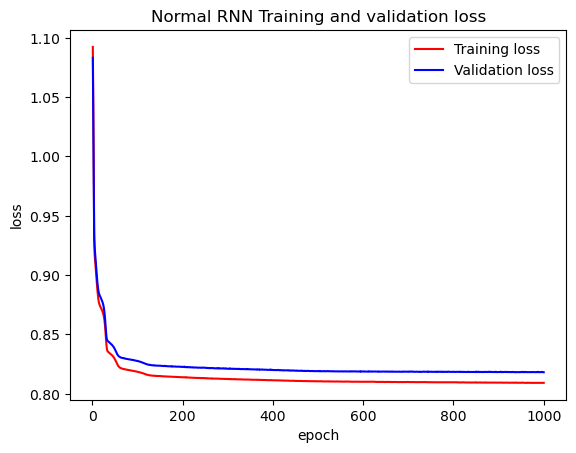

In [21]:
# plot training and validation losses against epochs

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Normal RNN Training and validation loss')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

C:\Users\zihaow19\AppData\Local\Temp\ipykernel_21536\151401212.py:12: RuntimeWarning: invalid value encountered in sqrt
  sqrt = np.sqrt(-2688000 * i**2 + 15772800000)


116/116 [==============================] - 1s 5ms/step
(3706, 10, 2)


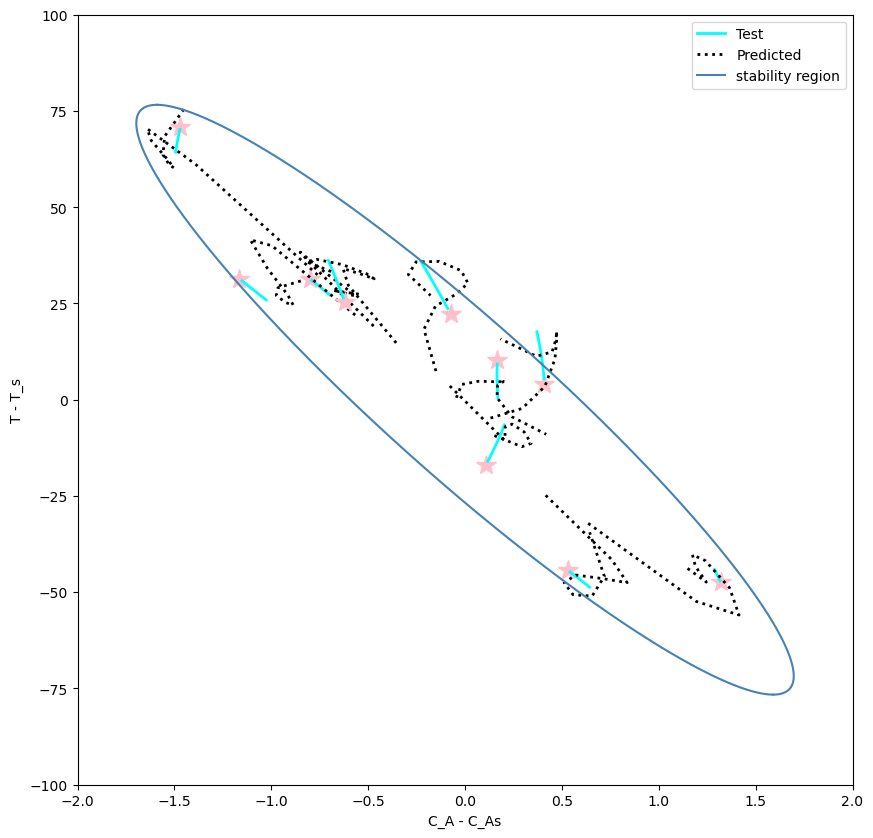

In [22]:
"""
    equation for the stability ellipse is 1060x^2 + 44xy + 0.52y^2 - 372 = 0
"""
# prepare x and y coordinates for plotting the stability region
y = np.linspace(-100, 100, 100000, endpoint=True)

x_upper = list()
x_lower = list()
y_plot = list()

for i in y:
    sqrt = np.sqrt(-2688000 * i**2 + 15772800000)
    if sqrt >= 0:
        y_plot.append(i)
        x_upper.append((-4400 * i + sqrt) / 212000)
        x_lower.append((-4400 * i - sqrt) / 212000)
        pass
    pass

plt.figure(figsize=(10,10))

# # plot the first 10 samples and their trajectories
y_predict = model.predict(X_test)
print(y_predict.shape)

y_predict = y_predict.reshape(-1,2)
y_predict = scaler_y.inverse_transform(y_predict)
y_predict = y_predict.reshape(-1,num_step,2)

X_plot = X_test.reshape(-1,num_dims)
X_plot = scaler_X.inverse_transform(X_plot)
X_plot = X_plot.reshape(-1,num_step,num_dims)

for i in range(10):
    if i == 0:  # only add label to 1 data point
        plt.plot(X_plot[i, 0, 1], X_plot[i, 0, 0], marker="*", markersize=15, color='pink')
        plt.plot(y_test[i, :, 1], y_test[i, :, 0], color='cyan', lw=2, label='Test')
        plt.plot(y_predict[i, :, 1], y_predict[i, :, 0], color='black', lw=2, ls=':', label='Predicted')
    else:
        plt.plot(X_plot[i, 0, 1], X_plot[i, 0, 0], marker="*", markersize=15, color='pink')
        plt.plot(y_test[i, :, 1], y_test[i, :, 0], color='cyan', lw=2)
        plt.plot(y_predict[i, :, 1], y_predict[i, :, 0], color='black', lw=2, ls=':')

# plot stability region
plt.plot(x_lower, y_plot, color='steelblue', label='stability region')
plt.plot(x_upper, y_plot, color='steelblue')
plt.ylim([-100, 100])
plt.xlim([-2, 2])

plt.xlabel("C_A - C_As")
plt.ylabel("T - T_s")
plt.legend()
# plt.savefig('iclrnn_noise_0.4.pdf')
plt.show()